In [1]:
# @title Utils
test = False

from google.colab import drive

drive.mount("/content/drive")

path = "/content/drive/My Drive/Colab Notebooks/nonmyopic/"

try:
    import gpytorch
except:
    !pip install gpytorch
try:
    import botorch
except:
    !pip install botorch

import torch
import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import math
from math import exp
import itertools

import numpy as np

np.random.seed(1)

from matplotlib import cm
from matplotlib import pyplot as plt

import botorch
import gpytorch
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings
from botorch.models import SingleTaskGP

import os

color = {
    "C0": "#1f77b4",
    "C1": "#ff7f0e",
    "C2": "#2ca02c",
    "C3": "#d62728",
    "C4": "#9467bd",
    "C5": "#bcbd22",
    "C6": "#e377c2",
    "C7": "#17becf",
    # 'C8':'#bcbd22',
    # 'C9':'#17becf',
}

figsize = [7, 3]
plt.rcParams["figure.figsize"] = figsize

SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 22


dpi = 100
imgtype = "png"

plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=16)  # fontsize of the tick labels
plt.rc("ytick", labelsize=16)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize


"""
Utilities for Gaussian process (GP) inference.
"""

import numpy as np
from scipy.linalg import solve_triangular
from scipy.spatial.distance import cdist
import itertools


def kern_exp_quad_ard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with
    dimensionwise lengthscales if ls is an ndarray.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff /= ls
    norm = np.sum(diff**2, axis=-1) / 2.0
    kern = alpha**2 * np.exp(-norm)
    return kern


def kern_exp_quad_ard_sklearn(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with dimensionwise lengthscales if ls is an
    ndarray, based on scikit-learn implementation.
    """
    dists = cdist(xmat1 / ls, xmat2 / ls, metric="sqeuclidean")
    exp_neg_norm = np.exp(-0.5 * dists)
    return alpha**2 * exp_neg_norm


def kern_exp_quad_ard_per(xmat1, xmat2, ls, alpha, pdims, period=2):
    """
    Exponentiated quadratic kernel function with
    - dimensionwise lengthscales if ls is an ndarray
    - periodic dimensions denoted by pdims. We assume that the period
    is 2.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff[..., pdims] = np.sin((np.pi * diff[..., pdims] / period) % (2 * np.pi))
    # diff[..., pdims] = np.cos( (np.pi/2) + (np.pi * diff[..., pdims] / period) )
    diff /= ls
    norm = np.sum(diff**2, axis=-1) / 2.0
    kern = alpha**2 * np.exp(-norm)

    return kern


def kern_exp_quad_noard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel).
    """
    kern = alpha**2 * kern_exp_quad_noard_noscale(xmat1, xmat2, ls)
    return kern


def kern_exp_quad_noard_noscale(xmat1, xmat2, ls):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel), without scale parameter.
    """
    distmat = squared_euc_distmat(xmat1, xmat2)
    norm = distmat / (2 * ls**2)
    exp_neg_norm = np.exp(-norm)
    return exp_neg_norm


def squared_euc_distmat(xmat1, xmat2, coef=1.0):
    """
    Distance matrix of squared euclidean distance (multiplied by coef) between
    points in xmat1 and xmat2.
    """
    return coef * cdist(xmat1, xmat2, "sqeuclidean")


def kern_distmat(xmat1, xmat2, ls, alpha, distfn):
    """
    Kernel for a given distmat, via passed in distfn (which is assumed to be fn
    of xmat1 and xmat2 only).
    """
    distmat = distfn(xmat1, xmat2)
    kernmat = alpha**2 * np.exp(-distmat / (2 * ls**2))
    return kernmat


def kern_simple_list(xlist1, xlist2, ls, alpha, base_dist=5.0):
    """
    Kernel for two lists containing elements that can be compared for equality.
    K(a,b) = 1 + base_dist if a and b are equal and K(a,b) = base_dist otherwise.
    """
    distmat = simple_list_distmat(xlist1, xlist2)
    distmat = distmat + base_dist
    kernmat = alpha**2 * np.exp(-distmat / (2 * ls**2))
    return kernmat


def simple_list_distmat(xlist1, xlist2, weight=1.0, additive=False):
    """
    Return distance matrix containing zeros when xlist1[i] == xlist2[j] and 0 otherwise.
    """
    prod_list = list(itertools.product(xlist1, xlist2))
    len1 = len(xlist1)
    len2 = len(xlist2)
    try:
        binary_mat = np.array([x[0] != x[1] for x in prod_list]).astype(int)
    except:
        # For cases where comparison returns iterable of bools
        binary_mat = np.array([all(x[0] != x[1]) for x in prod_list]).astype(int)

    binary_mat = binary_mat.reshape(len1, len2)

    if additive:
        distmat = weight + binary_mat
    else:
        distmat = weight * binary_mat

    return distmat


def get_product_kernel(kernel_list, additive=False):
    """Given a list of kernel functions, return product kernel."""

    def product_kernel(x1, x2, ls, alpha):
        """Kernel returning elementwise-product of kernel matrices from kernel_list."""
        mat_prod = kernel_list[0](x1, x2, ls, 1.0)
        for kernel in kernel_list[1:]:
            if additive:
                mat_prod = mat_prod + kernel(x1, x2, ls, 1.0)
            else:
                mat_prod = mat_prod * kernel(x1, x2, ls, 1.0)
        mat_prod = alpha**2 * mat_prod
        return mat_prod

    return product_kernel


def get_cholesky_decomp(k11_nonoise, sigma, psd_str):
    """Return cholesky decomposition."""
    if psd_str == "try_first":
        k11 = k11_nonoise + sigma**2 * np.eye(k11_nonoise.shape[0])
        try:
            return stable_cholesky(k11, False)
        except np.linalg.linalg.LinAlgError:
            return get_cholesky_decomp(k11_nonoise, sigma, "project_first")
    elif psd_str == "project_first":
        k11_nonoise = project_symmetric_to_psd_cone(k11_nonoise)
        return get_cholesky_decomp(k11_nonoise, sigma, "is_psd")
    elif psd_str == "is_psd":
        k11 = k11_nonoise + sigma**2 * np.eye(k11_nonoise.shape[0])
        return stable_cholesky(k11)


def stable_cholesky(mmat, make_psd=True, verbose=False):
    """Return a 'stable' cholesky decomposition of mmat."""
    if mmat.size == 0:
        return mmat
    try:
        lmat = np.linalg.cholesky(mmat)
    except np.linalg.linalg.LinAlgError as e:
        if not make_psd:
            raise e
        diag_noise_power = -11
        max_mmat = np.diag(mmat).max()
        diag_noise = np.diag(mmat).max() * 1e-11
        break_loop = False
        while not break_loop:
            try:
                lmat = np.linalg.cholesky(
                    mmat + ((10**diag_noise_power) * max_mmat) * np.eye(mmat.shape[0])
                )
                break_loop = True
            except np.linalg.linalg.LinAlgError:
                if diag_noise_power > -9:
                    if verbose:
                        print(
                            "\t*stable_cholesky failed with "
                            "diag_noise_power=%d." % (diag_noise_power)
                        )
                diag_noise_power += 1
            if diag_noise_power >= 5:
                print("\t*stable_cholesky failed: added diag noise = %e" % (diag_noise))
    return lmat


def project_symmetric_to_psd_cone(mmat, is_symmetric=True, epsilon=0):
    """Project symmetric matrix mmat to the PSD cone."""
    if is_symmetric:
        try:
            eigvals, eigvecs = np.linalg.eigh(mmat)
        except np.linalg.LinAlgError:
            print("\tLinAlgError encountered with np.eigh. Defaulting to eig.")
            eigvals, eigvecs = np.linalg.eig(mmat)
            eigvals = np.real(eigvals)
            eigvecs = np.real(eigvecs)
    else:
        eigvals, eigvecs = np.linalg.eig(mmat)
    clipped_eigvals = np.clip(eigvals, epsilon, np.inf)
    return (eigvecs * clipped_eigvals).dot(eigvecs.T)


def solve_lower_triangular(amat, b):
    """Solves amat*x=b when amat is lower triangular."""
    return solve_triangular_base(amat, b, lower=True)


def solve_upper_triangular(amat, b):
    """Solves amat*x=b when amat is upper triangular."""
    return solve_triangular_base(amat, b, lower=False)


def solve_triangular_base(amat, b, lower):
    """Solves amat*x=b when amat is a triangular matrix."""
    if amat.size == 0 and b.shape[0] == 0:
        return np.zeros((b.shape))
    else:
        return solve_triangular(amat, b, lower=lower)


def sample_mvn(mu, covmat, nsamp):
    """
    Sample from multivariate normal distribution with mean mu and covariance
    matrix covmat.
    """
    mu = mu.reshape(-1)
    ndim = len(mu)
    lmat = stable_cholesky(covmat)
    umat = np.random.normal(size=(ndim, nsamp))
    return lmat.dot(umat).T + mu


def gp_post(x_train, y_train, x_pred, ls, alpha, full_cov=True):
    """Compute parameters of GP posterior"""
    k11_nonoise = kern_exp_quad_noard(x_train, x_train, alpha=alpha, ls=ls)
    lmat = get_cholesky_decomp(k11_nonoise, 1e-2, "try_first")
    smat = solve_upper_triangular(lmat.T, solve_lower_triangular(lmat, y_train))
    k21 = kern_exp_quad_noard(x_pred, x_train, alpha=alpha, ls=ls)
    mu2 = k21.dot(smat)
    k22 = kern_exp_quad_noard(x_pred, x_pred, alpha=alpha, ls=ls)
    vmat = solve_lower_triangular(lmat, k21.T)
    k2 = k22 - vmat.T.dot(vmat)
    if full_cov is False:
        k2 = np.sqrt(np.diag(k2))
    return mu2, k2


# #!/usr/bin/env python3
# # Copyright (c) Meta Platforms, Inc. and affiliates.
# #
# # This source code is licensed under the MIT license found in the
# # LICENSE file in the root directory of this source tree.

# r"""
# Gaussian Process Regression models based on GPyTorch models.

# These models are often a good starting point and are further documented in the
# tutorials.

# `SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` are all
# single-task exact GP models, differing in how they treat noise. They use
# relatively strong priors on the Kernel hyperparameters, which work best when
# covariates are normalized to the unit cube and outcomes are standardized (zero
# mean, unit variance).

# These models all work in batch mode (each batch having its own hyperparameters).
# When the training observations include multiple outputs, these models use
# batching to model outputs independently.

# These models all support multiple outputs. However, as single-task models,
# `SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` should be
# used only when the outputs are independent and all use the same training data.
# If outputs are independent and outputs have different training data, use the
# `ModelListGP`. When modeling correlations between outputs, use a multi-task
# model like `MultiTaskGP`.
# """

# from __future__ import annotations

# from typing import Any, List, Optional, Union

# import torch
# from botorch import settings
# from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel
# from botorch.models.transforms.input import InputTransform
# from botorch.models.transforms.outcome import Log, OutcomeTransform
# from botorch.models.utils import fantasize as fantasize_flag, validate_input_scaling
# from botorch.sampling.samplers import MCSampler
# from gpytorch.constraints.constraints import GreaterThan
# from gpytorch.distributions.multivariate_normal import MultivariateNormal
# from gpytorch.kernels.matern_kernel import MaternKernel
# from gpytorch.kernels.scale_kernel import ScaleKernel
# from gpytorch.kernels import RBFKernel
# from gpytorch.likelihoods.gaussian_likelihood import (
#     _GaussianLikelihoodBase,
#     FixedNoiseGaussianLikelihood,
#     GaussianLikelihood,
# )
# from gpytorch.likelihoods.likelihood import Likelihood
# from gpytorch.likelihoods.noise_models import HeteroskedasticNoise
# from gpytorch.means.constant_mean import ConstantMean
# from gpytorch.means.mean import Mean
# from gpytorch.mlls.noise_model_added_loss_term import NoiseModelAddedLossTerm
# from gpytorch.models.exact_gp import ExactGP
# from gpytorch.module import Module
# from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior
# from gpytorch.priors.torch_priors import GammaPrior
# from torch import Tensor


# MIN_INFERRED_NOISE_LEVEL = 1e-4


# class SingleTaskGP(BatchedMultiOutputGPyTorchModel, ExactGP):
#     r"""A single-task exact GP model.

#     A single-task exact GP using relatively strong priors on the Kernel
#     hyperparameters, which work best when covariates are normalized to the unit
#     cube and outcomes are standardized (zero mean, unit variance).

#     This model works in batch mode (each batch having its own hyperparameters).
#     When the training observations include multiple outputs, this model will use
#     batching to model outputs independently.

#     Use this model when you have independent output(s) and all outputs use the
#     same training data. If outputs are independent and outputs have different
#     training data, use the ModelListGP. When modeling correlations between
#     outputs, use the MultiTaskGP.

#     Example:
#         >>> train_X = torch.rand(20, 2)
#         >>> train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
#         >>> model = SingleTaskGP(train_X, train_Y)
#     """

#     def __init__(
#         self,
#         train_X: Tensor,
#         train_Y: Tensor,
#         likelihood: Optional[Likelihood] = None,
#         covar_module: Optional[Module] = None,
#         mean_module: Optional[Mean] = None,
#         outcome_transform: Optional[OutcomeTransform] = None,
#         input_transform: Optional[InputTransform] = None,
#     ) -> None:
#         r"""
#         Args:
#             train_X: A `batch_shape x n x d` tensor of training features.
#             train_Y: A `batch_shape x n x m` tensor of training observations.
#             likelihood: A likelihood. If omitted, use a standard
#                 GaussianLikelihood with inferred noise level.
#             covar_module: The module computing the covariance (Kernel) matrix.
#                 If omitted, use a `MaternKernel`.
#             mean_module: The mean function to be used. If omitted, use a
#                 `ConstantMean`.
#             outcome_transform: An outcome transform that is applied to the
#                 training data during instantiation and to the posterior during
#                 inference (that is, the `Posterior` obtained by calling
#                 `.posterior` on the model will be on the original scale).
#             input_transform: An input transform that is applied in the model's
#                 forward pass.
#         """
#         with torch.no_grad():
#             transformed_X = self.transform_inputs(
#                 X=train_X, input_transform=input_transform
#             )
#         if outcome_transform is not None:
#             train_Y, _ = outcome_transform(train_Y)
#         self._validate_tensor_args(X=transformed_X, Y=train_Y)
#         ignore_X_dims = getattr(self, "_ignore_X_dims_scaling_check", None)
#         validate_input_scaling(
#             train_X=transformed_X, train_Y=train_Y, ignore_X_dims=ignore_X_dims
#         )
#         self._set_dimensions(train_X=train_X, train_Y=train_Y)
#         train_X, train_Y, _ = self._transform_tensor_args(X=train_X, Y=train_Y)
#         if likelihood is None:
#             # noise_prior = GammaPrior(1.1, 0.05)
#             noise_prior = GammaPrior(concentration=0.5, rate=1)
#             noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
#             likelihood = GaussianLikelihood(
#                 noise_prior=noise_prior,
#                 batch_shape=self._aug_batch_shape,
#                 noise_constraint=GreaterThan(
#                     MIN_INFERRED_NOISE_LEVEL,
#                     transform=None,
#                     initial_value=noise_prior_mode,
#                 ),
#             )
#         else:
#             self._is_custom_likelihood = True
#         ExactGP.__init__(self, train_X, train_Y, likelihood)
#         if mean_module is None:
#             mean_module = ConstantMean(batch_shape=self._aug_batch_shape)
#         self.mean_module = mean_module
#         if covar_module is None:
#             covar_module = \
#                 ScaleKernel(
#                     # MaternKernel(
#                     #     nu=2.5,
#                     #     ard_num_dims=transformed_X.shape[-1],
#                     #     batch_shape=self._aug_batch_shape,
#                     #     lengthscale_prior=GammaPrior(3.0, 6.0),),
#                     RBFKernel(
#                         ard_num_dims=transformed_X.shape[-1],
#                         batch_shape=self._aug_batch_shape,
#                         lengthscale_prior=GammaPrior(3.0, 6.0),),
#                     batch_shape=self._aug_batch_shape,
#                     outputscale_prior=GammaPrior(2.0, 0.15),
#                 )
#             self._subset_batch_dict = {
#                 "likelihood.noise_covar.raw_noise": -2,
#                 "mean_module.raw_constant": -1,
#                 "covar_module.raw_outputscale": -1,
#                 "covar_module.base_kernel.raw_lengthscale": -3,
#             }
#         self.covar_module = covar_module
#         # TODO: Allow subsetting of other covar modules
#         if outcome_transform is not None:
#             self.outcome_transform = outcome_transform
#         if input_transform is not None:
#             self.input_transform = input_transform
#         self.to(train_X)

#     def forward(self, x: Tensor) -> MultivariateNormal:
#         if self.training:
#             x = self.transform_inputs(x)
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 361 kB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 387 kB 7.6 MB/s 
     |████████████████████████████████| 722 kB 52.8 MB/s 


In [2]:
# @title GP Synthetic Function


def ground_truth(
    draw_true_model=False, n_dim=1, draw_3D=False, alpha=1, ls=math.sqrt(0.05)
):
    if n_dim == 1:
        xs = np.linspace(0, 1, 1000)[:, None]
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)

        np.random.seed(24)
        ys = sample_mvn(mean, cov, 1).squeeze()
        if draw_true_model:
            plt.plot(xs, ys, color="blue", alpha=0.1)
        return xs, ys

    elif n_dim == 2:
        grid = 20j
        xs = np.mgrid[0:1:grid, 0:1:grid].reshape(2, -1).T
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)

        np.random.seed(5)
        ys = sample_mvn(mean, cov, 1).squeeze()

        if draw_true_model:
            xpts = np.linspace(0, 1, int(abs(grid)))
            ypts = np.linspace(0, 1, int(abs(grid)))
            X, Y = np.meshgrid(xpts, ypts)
            resol = int(abs(grid))
            Z = ys.reshape(resol, resol).T

            if draw_3D:
                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                cf = ax.plot_surface(
                    X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False
                )
                cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

            plt.figure(figsize=figsize)
            plt.title("Ground truth function")
            cf = plt.contourf(
                X,
                Y,
                Z,
                40,
                cmap=cm.coolwarm,
                zorder=0,
                levels=np.linspace(-3, 3, 40),
                extend="both",
            )
            cbar = plt.colorbar(cf, fraction=0.046, pad=0.04, ticks=range(-3, 3, 1))

            plt.show()

        return xs, ys

    else:
        raise


def p_loss(x):
    return torch.maximum(torch.abs(x - 0.5) - 0.5, torch.tensor([0]))


def func(train_x):
    alpha = 1
    ls = math.sqrt(0.05)

    xs, ys = ground_truth(draw_true_model=False, n_dim=n_dim, alpha=alpha, ls=ls)

    train_y, _ = gp_post(x_train=xs, y_train=ys, x_pred=train_x, alpha=alpha, ls=ls)

    train_y = torch.tensor(train_y, dtype=torch.float64)

    return train_y


def init_data(n_init=4):
    if n_dim == 1:
        train_x = torch.linspace(0, 1, n_init).reshape(-1, n_dim)
    elif n_dim == 2:
        n_init = complex(0, n_init)
        train_x = np.mgrid[0:1:n_init, 0:1:n_init].reshape(2, -1).T
        train_x = torch.from_numpy(train_x)
    else:
        raise

    train_x = torch.cat([train_x, prev_x.reshape(-1, n_dim)], axis=0)
    train_y = func(train_x)

    train_x = train_x.double()
    train_y = train_y.double()

    return train_x, train_y


def init_model(n_dim, prev_x, train_x, train_y, train=False):
    train_y = train_y[:, None]
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    if train:
        model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-6))

    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    mll = mll.to(train_x)

    if not train:
        alpha = 1
        ls = math.sqrt(0.05)
        model.covar_module.base_kernel.lengthscale = ls
        model.covar_module.outputscale = alpha
        model.likelihood.noise = 1e-10
    else:
        optimizer = SGD([{"params": model.parameters()}], lr=0.05)
        NUM_EPOCHS = 20000

        model.train()

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, model.train_targets)
            loss.backward()
            if (epoch + 1) % 2000 == 0:
                print(
                    f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>2.2} ",
                    "lengthscale: ",
                    model.covar_module.base_kernel.lengthscale.data,
                    f"outputscale: {model.covar_module.outputscale.item():>2.2f} ",
                    f"noise: {model.likelihood.noise.item():>2.5f}",
                )

            optimizer.step()

    model.eval()

    return model


def draw_posterior(n_dim, model):
    plt.figure(figsize=figsize)

    if n_dim == 1:
        test_x = torch.linspace(0, 1, 100)
        posterior = model.posterior(test_x)
        test_y = posterior.mean.squeeze()
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze()
        upper = upper.squeeze()

        if len(test_y.shape) == 2:
            test_y = test_y[0, :]
            lower = lower[0, :]
            upper = upper[0, :]

        plt.plot(
            test_x.cpu().detach().numpy(),
            test_y.cpu().detach().numpy(),
            color["C1"],
            label="Best h-step Posterior mean (before observed data)",
        )
        plt.fill_between(
            test_x.cpu().detach().numpy(),
            lower.cpu().detach().numpy(),
            upper.cpu().detach().numpy(),
            alpha=0.25,
            color=color["C2"],
        )

    elif n_dim == 2:
        grid = 20j
        test_x = np.mgrid[0:1:grid, 0:1:grid].reshape(2, -1).T
        test_x = torch.tensor(test_x)

        posterior = model.posterior(test_x)
        test_y = posterior.mean.detach().numpy().squeeze()

        if len(test_y.shape) == 3:
            test_y = test_y[0, 0, :]
        elif len(test_y.shape) == 2:
            test_y = test_y[0, :]

        xpts = np.linspace(0, 1, int(abs(grid)))
        ypts = np.linspace(0, 1, int(abs(grid)))
        X, Y = np.meshgrid(xpts, ypts)
        resol = int(abs(grid))
        Z = test_y.reshape(resol, resol).T

        # levels = np.linspace(-1.5,2.5,40)

        cf = plt.contourf(
            X,
            Y,
            Z,
            40,
            cmap=cm.coolwarm,
            zorder=0,
            levels=np.linspace(-3, 3, 40),
            extend="both",
        )

        cbar = plt.colorbar(cf, fraction=0.046, pad=0.04, ticks=range(-3, 3, 1))

        plt.scatter(train_x[:, 0], train_x[:, 1], marker="*", color="black")

    else:
        raise

In [3]:
# @title EHIG


def sang_sampler(posterior, num_samples=5):
    assert num_samples >= 1
    assert num_samples % 2 == 1

    sample = []
    mean = posterior.mean
    std = torch.sqrt(posterior.variance)
    std_coeff = np.linspace(0, 2, num_samples // 2 + 1)
    for s in std_coeff:
        if s == 0:
            sample.append(mean)
        else:
            sample.append(mean + s * std)
            sample.append(mean - s * std)

    return sample


def compute_ehig(
    xi, horizon, neighbor_size, seed, draw_last_posterior, sampler_name="sang"
):
    with settings.propagate_grads(state=True):
        for h in range(0, horizon + 1):
            pvs_x = xi[h - 1] if h > 0 else prev_x
            xi[h] = torch.sigmoid(xi[h]) * (neighbor_size * 2) + (pvs_x - neighbor_size)

            if torch.any(xi[h] < 0) or torch.any(xi[h] > 1):
                xi[h] = torch.clamp(xi[h], min=0, max=1)

        ehigs = 0
        sample_yi_on_xi_Di = {}
        prev_ind = np.ones(horizon) * -1
        p_f_on_Di = {}
        p_f_on_Di[0] = model

        if sampler_name == "sang":
            sampler = sang_sampler
        elif sampler_name == "sobol":
            sampler = SobolQMCNormalSampler(
                num_samples=4, resample=False, collapse_batch_dims=True, seed=seed
            )
        else:
            raise
        p_y0_on_x0_D0 = model.posterior(xi[0])
        sample_yi_on_xi_Di[0] = sampler(p_y0_on_x0_D0)

        # if horizon >= 3:
        #     iter_range = itertools.product(range(5), range(5), range(5))
        #     norm_const = 5*5*5
        if horizon >= 2:
            iter_range = itertools.product(range(5), range(5))
            norm_const = 5 * 5
        elif horizon == 1:
            iter_range = itertools.product(range(5))
            norm_const = 5
        else:
            print("horizon has to be larger than 0")
            raise

        for ind in iter_range:
            ind = ind + tuple([2] * (horizon - len(ind)))
            equal_bool = np.equal(ind, prev_ind)
            # finding the first false
            comp_ind = np.argmin(equal_bool)
            prev_ind = ind

            for i in range(horizon):
                if i >= comp_ind:
                    p_f_on_Di[i + 1] = p_f_on_Di[i].condition_on_observations(
                        xi[i],
                        # xi[ind[:i]],
                        sample_yi_on_xi_Di[i][ind[i]],
                    )

                    sample_yi_on_xi_Di[i + 1] = sampler(
                        p_f_on_Di[i + 1].posterior(xi[i + 1])
                    )
                    # p_f_on_Di[i+1].posterior(xi[ind[:i+1]]))

            if sampler_name == "sang":
                ehig = sample_yi_on_xi_Di[horizon][0].mean()
            elif sampler_name == "sobol":
                ehig = sample_yi_on_xi_Di[horizon].mean()
            else:
                raise

            ehigs = ehigs + ehig

        ehig = ehigs / norm_const

        if draw_last_posterior:
            draw_posterior(model=p_f_on_Di[horizon], n_dim=len(xi[0].shape))

        return xi, ehig.squeeze()


def argmax_ehig(
    model,
    prev_x,
    seed,
    horizon=10,
    ehig_opt_epoch=100,
    ehig_opt_lr=0.1,
    neighbor_size=0.1,
    use_lr_schedule=False,
):
    xi = []
    for h in range(horizon + 1):
        xi.append((torch.rand(dim_xi)).requires_grad_(True))

        if h == 0:
            dim_xi.insert(0, 5)
        elif h == 1:
            dim_xi.insert(0, 5)
        # elif h == 2:
        #     dim_xi.insert(0, 5)
        else:
            dim_xi.insert(0, 1)

    optimizer = optim.Adam(xi, lr=ehig_opt_lr)
    if use_lr_schedule:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=0.0001
        )

    result = []
    metric = []
    for epoch in tqdm(range(ehig_opt_epoch)):
        optimizer.zero_grad()
        xi_in = [element_xi.clone() for element_xi in xi]

        if epoch == ehig_opt_epoch - 1:
            draw_last_posterior = True
        else:
            draw_last_posterior = False
        xi_out, ehig = compute_ehig(
            xi_in,
            horizon=horizon,
            neighbor_size=neighbor_size,
            seed=seed,
            draw_last_posterior=draw_last_posterior,
        )

        ehig.backward(retain_graph=True)
        optimizer.step()
        if use_lr_schedule:
            scheduler.step()

        result.append([xi_out[i].detach() for i in range(horizon + 1)])
        metric.append(ehig.clone().detach().numpy())
        if epoch % 10 == 0:
            print(
                "x0: ",
                result[epoch][0].data.tolist(),
                ", a: ",
                result[epoch][-1].tolist(),
                # 'xi', xi_out,
                ", loss: ",
                metric[epoch].item(),
            )

        del xi_in
        del xi_out
        del ehig

    metric = np.array(metric)
    metric_round = metric.round(decimals=3)

    best = np.random.choice(np.where(metric_round == metric_round.min())[0])

    # best = torch.argmin(metric, dim=0).item()
    best_result = result[best]

    return best_result

-------------------- Ground truth surface --------------------


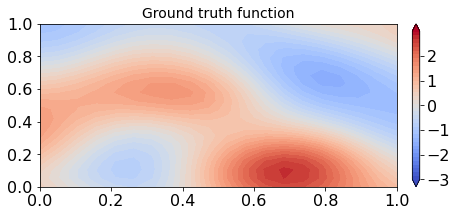

  2%|▏         | 1/50 [00:09<07:31,  9.21s/it]

x0:  [[0.40096738934516907, 0.41977459192276]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.6474028825759888, 0.7042697072029114]], [[0.6382309794425964, 0.6443724632263184]], [[0.6140443086624146, 0.6851962804794312]], [[0.6676311492919922, 0.6773291230201721]], [[0.6343237161636353, 0.6538854837417603]]], [[[0.629007875919342, 0.6623886823654175]], [[0.6377367377281189, 0.6935057640075684]], [[0.6183042526245117, 0.7057780027389526]], [[0.6066099405288696, 0.6775365471839905]], [[0.6226293444633484, 0.6725900173187256]]], [[[0.629836916923523, 0.6417222619056702]], [[0.6487913727760315, 0.6577783226966858]], [[0.6474615335464478, 0.705829381942749]], [[0.62419593334198, 0.629454493522644]], [[0.6621821522712708, 0.6878228187561035]]], [[[0.6499844789505005, 0.724495530128479]], [[0.666076123714447, 0.6771068572998047]], [[0.6440595388412476, 0.735740602016449]], [[0.646625280380249, 0.6693786382675171]], [[0.61095130443573, 0.6589104533195496]]], [[[0.619466245174408, 0.7077090740203857]], [[0.6346

 22%|██▏       | 11/50 [01:38<05:50,  9.00s/it]

x0:  [[0.41213279962539673, 0.43459999561309814]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.8072111010551453, 0.7922337651252747]], [[0.8113546967506409, 0.8415871262550354]], [[0.7938545942306519, 0.8959498405456543]], [[0.8213646411895752, 0.7898909449577332]], [[0.7885133624076843, 0.8206102848052979]]], [[[0.8259762525558472, 0.8300056457519531]], [[0.7564560770988464, 0.8347092866897583]], [[0.7778187394142151, 0.9009707570075989]], [[0.7920641899108887, 0.8838662505149841]], [[0.7960253953933716, 0.8396815657615662]]], [[[0.8542442321777344, 0.8267913460731506]], [[0.8540677428245544, 0.7720269560813904]], [[0.8040461540222168, 0.8578003644943237]], [[0.8423773050308228, 0.7909233570098877]], [[0.8318126797676086, 0.8196091055870056]]], [[[0.7179857492446899, 0.8637944459915161]], [[0.8235465884208679, 0.832362949848175]], [[0.722030520439148, 0.8848137259483337]], [[0.799764096736908, 0.7938717603683472]], [[0.8370653986930847, 0.8627510666847229]]], [[[0.7293114066123962, 0.884945869445800

 42%|████▏     | 21/50 [03:08<04:19,  8.93s/it]

x0:  [[0.4302022159099579, 0.4407007694244385]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.8156646490097046, 0.8104526400566101]], [[0.7974448204040527, 0.7923783659934998]], [[0.7552815079689026, 0.8668780326843262]], [[0.8582973480224609, 0.7948789000511169]], [[0.7584989666938782, 0.8094822764396667]]], [[[0.7968360185623169, 0.8061976432800293]], [[0.7905988693237305, 0.8575642704963684]], [[0.7582675218582153, 0.8695498704910278]], [[0.7743614315986633, 0.8248847126960754]], [[0.7843211889266968, 0.8129006624221802]]], [[[0.8400678038597107, 0.7775604724884033]], [[0.8662360310554504, 0.739926815032959]], [[0.7756580114364624, 0.8400253057479858]], [[0.8392757773399353, 0.7382962703704834]], [[0.8365160226821899, 0.7979788184165955]]], [[[0.7355242967605591, 0.899675726890564]], [[0.8096725940704346, 0.8033490777015686]], [[0.7594858407974243, 0.9308639764785767]], [[0.8126665353775024, 0.8158711194992065]], [[0.8121541738510132, 0.8067321181297302]]], [[[0.716971755027771, 0.8463974595069885]

 62%|██████▏   | 31/50 [04:39<02:55,  9.25s/it]

x0:  [[0.44024205207824707, 0.44353288412094116]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.8234168291091919, 0.8139089941978455]], [[0.8541754484176636, 0.8305444717407227]], [[0.7855064868927002, 0.9098050594329834]], [[0.8677356839179993, 0.7872645854949951]], [[0.7959699630737305, 0.8295474648475647]]], [[[0.8338928818702698, 0.8318322896957397]], [[0.7981240749359131, 0.8326597809791565]], [[0.8071508407592773, 0.8999401330947876]], [[0.8098419904708862, 0.842475175857544]], [[0.814504861831665, 0.8351933360099792]]], [[[0.8611024618148804, 0.7939431071281433]], [[0.8952720165252686, 0.7615958452224731]], [[0.8207520842552185, 0.8933587670326233]], [[0.8793967366218567, 0.7564669847488403]], [[0.8519747853279114, 0.8011254072189331]]], [[[0.7311651706695557, 0.8756527304649353]], [[0.8337704539299011, 0.8157154321670532]], [[0.7655543088912964, 0.9212303757667542]], [[0.8352173566818237, 0.8462875485420227]], [[0.8141822218894958, 0.814470648765564]]], [[[0.747322142124176, 0.8790019750595093

 82%|████████▏ | 41/50 [06:08<01:20,  8.90s/it]

x0:  [[0.4444611072540283, 0.44496864080429077]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.8319664597511292, 0.814767062664032]], [[0.8389984965324402, 0.8053017258644104]], [[0.778712272644043, 0.9046586155891418]], [[0.8728080987930298, 0.7894534468650818]], [[0.8043495416641235, 0.8211679458618164]]], [[[0.8283774852752686, 0.8256691098213196]], [[0.813355565071106, 0.8448902368545532]], [[0.803526759147644, 0.8809964060783386]], [[0.8110389113426208, 0.8322464823722839]], [[0.8012186288833618, 0.8255394101142883]]], [[[0.8612478375434875, 0.8037933111190796]], [[0.8746592998504639, 0.7654903531074524]], [[0.8188686966896057, 0.882931113243103]], [[0.881580114364624, 0.742481529712677]], [[0.8490338325500488, 0.8110886812210083]]], [[[0.7517544627189636, 0.8823857307434082]], [[0.8371407985687256, 0.8121989965438843]], [[0.768300473690033, 0.9190792441368103]], [[0.8193424940109253, 0.8376935124397278]], [[0.825951099395752, 0.8223188519477844]]], [[[0.7531472444534302, 0.8594093918800354]], [[

100%|██████████| 50/50 [07:30<00:00,  9.01s/it]


Current optimal loss 1.0709546565091306;optimal action: tensor([[0.4574, 0.4570]], grad_fn=<AddBackward0>)


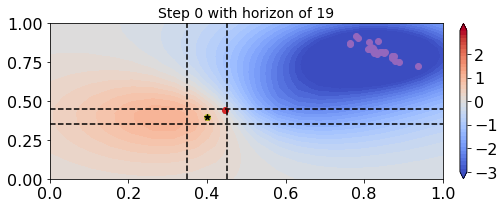

  2%|▏         | 1/50 [00:08<06:55,  8.48s/it]

x0:  [[0.4549008011817932, 0.45086023211479187]] , a:  [[[[[[[[[[[[[[[[[[[[[0.6553388237953186, 0.6658410429954529]], [[0.6373365521430969, 0.6654722690582275]], [[0.6848158836364746, 0.654773473739624]], [[0.6637113094329834, 0.6881344318389893]], [[0.6682918667793274, 0.7027800679206848]]], [[[0.6973501443862915, 0.6619313359260559]], [[0.6970676779747009, 0.6837939023971558]], [[0.6824616193771362, 0.6934128403663635]], [[0.6685488224029541, 0.7357149124145508]], [[0.7305140495300293, 0.6929455995559692]]], [[[0.6730561256408691, 0.6676025390625]], [[0.6951239705085754, 0.6834191679954529]], [[0.6703673005104065, 0.7170118689537048]], [[0.6839760541915894, 0.6751262545585632]], [[0.6772931814193726, 0.6444353461265564]]], [[[0.6636842489242554, 0.6334531903266907]], [[0.6752704381942749, 0.6783256530761719]], [[0.7020867466926575, 0.6839800477027893]], [[0.7181934118270874, 0.7344842553138733]], [[0.6769964098930359, 0.6639119386672974]]], [[[0.7424970865249634, 0.6905074715614319]]

 22%|██▏       | 11/50 [01:32<05:31,  8.50s/it]

x0:  [[0.47039663791656494, 0.4704119563102722]] , a:  [[[[[[[[[[[[[[[[[[[[[0.8640999794006348, 0.9214324951171875]], [[0.8832657933235168, 0.9169573783874512]], [[0.9284309148788452, 0.9044764637947083]], [[0.90411376953125, 0.9294381737709045]], [[0.8616188764572144, 0.950528621673584]]], [[[0.9298762679100037, 0.8961641192436218]], [[0.9096025228500366, 0.9261786341667175]], [[0.8701670169830322, 0.920819878578186]], [[0.8067225217819214, 0.907431960105896]], [[0.8839840292930603, 0.8743263483047485]]], [[[0.8872721195220947, 0.9220301508903503]], [[0.9104063510894775, 0.9044985771179199]], [[0.8695565462112427, 0.9296125769615173]], [[0.9121403098106384, 0.9144449234008789]], [[0.9226634502410889, 0.9225026965141296]]], [[[0.9151086807250977, 0.9131652116775513]], [[0.9194732904434204, 0.9142320156097412]], [[0.9181077480316162, 0.9055489897727966]], [[0.8487088084220886, 0.9104700684547424]], [[0.9038870930671692, 0.8518993258476257]]], [[[0.9084572196006775, 0.8626675009727478]],

 42%|████▏     | 21/50 [02:59<04:11,  8.69s/it]

x0:  [[0.4773547053337097, 0.47973981499671936]] , a:  [[[[[[[[[[[[[[[[[[[[[0.8415781259536743, 0.9206486344337463]], [[0.8768500089645386, 0.9119183421134949]], [[0.8952038288116455, 0.8738784193992615]], [[0.8718768954277039, 0.9073580503463745]], [[0.8187548518180847, 0.9236629009246826]]], [[[0.9044355154037476, 0.8430830240249634]], [[0.8765439391136169, 0.895745575428009]], [[0.8391666412353516, 0.8886222839355469]], [[0.8013879656791687, 0.8876379132270813]], [[0.8559545278549194, 0.8570269346237183]]], [[[0.8675996661186218, 0.9014899134635925]], [[0.8680862188339233, 0.8732332587242126]], [[0.8377892971038818, 0.9001453518867493]], [[0.8771530389785767, 0.8708282709121704]], [[0.9110864400863647, 0.912598192691803]]], [[[0.9243380427360535, 0.9193882346153259]], [[0.8966914415359497, 0.8903785347938538]], [[0.8676021695137024, 0.8558332324028015]], [[0.8052616715431213, 0.9042278528213501]], [[0.8940221071243286, 0.7982873916625977]]], [[[0.8764124512672424, 0.844994843006134]

 62%|██████▏   | 31/50 [04:23<02:38,  8.35s/it]

x0:  [[0.4819965064525604, 0.4849705696105957]] , a:  [[[[[[[[[[[[[[[[[[[[[0.834995448589325, 0.9095844626426697]], [[0.8378233313560486, 0.8684194684028625]], [[0.8928885459899902, 0.8769846558570862]], [[0.8601325154304504, 0.8890175819396973]], [[0.8337727189064026, 0.9310064911842346]]], [[[0.8995754718780518, 0.84389728307724]], [[0.8654526472091675, 0.876164972782135]], [[0.8672641515731812, 0.8893294334411621]], [[0.8458964824676514, 0.9118384122848511]], [[0.8875446319580078, 0.8966799974441528]]], [[[0.8674179315567017, 0.899655818939209]], [[0.8844522833824158, 0.8850411176681519]], [[0.8607236742973328, 0.9154112339019775]], [[0.8757924437522888, 0.8768855929374695]], [[0.857648491859436, 0.8716826438903809]]], [[[0.8744238018989563, 0.8613276481628418]], [[0.8739813566207886, 0.866808295249939]], [[0.8950703740119934, 0.8851099014282227]], [[0.8305792212486267, 0.9532396793365479]], [[0.8961763978004456, 0.7891518473625183]]], [[[0.8978757262229919, 0.8706735968589783]], [[

 82%|████████▏ | 41/50 [05:48<01:16,  8.55s/it]

x0:  [[0.48526522517204285, 0.4880289137363434]] , a:  [[[[[[[[[[[[[[[[[[[[[0.8485971689224243, 0.9306398034095764]], [[0.8707553148269653, 0.9104400277137756]], [[0.907050371170044, 0.8947802186012268]], [[0.8793512582778931, 0.9017341732978821]], [[0.8564187288284302, 0.9384872317314148]]], [[[0.9123971462249756, 0.8694357872009277]], [[0.8980303406715393, 0.8984628915786743]], [[0.8904339075088501, 0.8969548940658569]], [[0.8507559299468994, 0.8987834453582764]], [[0.8794904947280884, 0.8923743367195129]]], [[[0.8776866793632507, 0.9159671664237976]], [[0.8894398808479309, 0.8858056664466858]], [[0.869143545627594, 0.9144936203956604]], [[0.895977258682251, 0.902904212474823]], [[0.8859979510307312, 0.9034938216209412]]], [[[0.8893816471099854, 0.8816940188407898]], [[0.8997014760971069, 0.8930943608283997]], [[0.8949065208435059, 0.8913532495498657]], [[0.824265718460083, 0.9348819255828857]], [[0.9315395355224609, 0.8169143795967102]]], [[[0.8889731764793396, 0.8615730404853821]],

100%|██████████| 50/50 [07:04<00:00,  8.50s/it]


Current optimal loss 1.1043492723107147;optimal action: tensor([[0.4995, 0.5019]], grad_fn=<AddBackward0>)


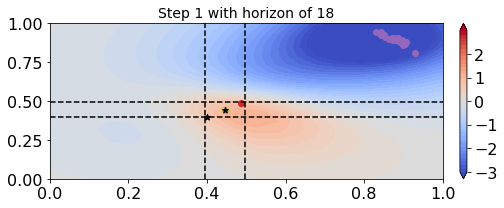

  2%|▏         | 1/50 [00:07<06:25,  7.86s/it]

x0:  [[0.5027011036872864, 0.5029327273368835]] , a:  [[[[[[[[[[[[[[[[[[[[0.6660804152488708, 0.7294945120811462]], [[0.7087380290031433, 0.7059112787246704]], [[0.7116270065307617, 0.7248361110687256]], [[0.7299119830131531, 0.7468292713165283]], [[0.7164138555526733, 0.7196398973464966]]], [[[0.7153889536857605, 0.7120547890663147]], [[0.7167630195617676, 0.7791627049446106]], [[0.7565168142318726, 0.7340677976608276]], [[0.7277597188949585, 0.7095789909362793]], [[0.7295451164245605, 0.7293878197669983]]], [[[0.693202793598175, 0.7331027388572693]], [[0.7467557787895203, 0.7146633863449097]], [[0.7703316807746887, 0.7334938049316406]], [[0.7004981637001038, 0.6826081871986389]], [[0.7082672119140625, 0.712023913860321]]], [[[0.7339810132980347, 0.688813328742981]], [[0.7693200707435608, 0.7071059942245483]], [[0.7219420671463013, 0.7409678101539612]], [[0.7003577947616577, 0.737246572971344]], [[0.7399241924285889, 0.7992580533027649]]], [[[0.7137497067451477, 0.6911961436271667]], 

 22%|██▏       | 11/50 [01:28<05:14,  8.07s/it]

x0:  [[0.5152981281280518, 0.5117525458335876]] , a:  [[[[[[[[[[[[[[[[[[[[0.9022939801216125, 0.9721983671188354]], [[0.9482364654541016, 0.9126034379005432]], [[0.944819450378418, 0.957371175289154]], [[0.9152269959449768, 0.9420595765113831]], [[0.932935893535614, 0.9331212043762207]]], [[[0.9199062585830688, 0.9302979707717896]], [[0.8799735307693481, 0.9411695599555969]], [[0.9484196901321411, 0.8937760591506958]], [[0.9314367175102234, 0.9530036449432373]], [[0.9101080298423767, 0.8864622116088867]]], [[[0.8921770453453064, 0.9509290456771851]], [[0.9785027503967285, 0.8801960349082947]], [[0.9686461091041565, 0.891936719417572]], [[0.937433123588562, 0.9500723481178284]], [[0.946219265460968, 0.9075613021850586]]], [[[0.9304012656211853, 0.918004035949707]], [[0.9640371799468994, 0.8985979557037354]], [[0.9465580582618713, 0.946133553981781]], [[0.8828921914100647, 0.9491889476776123]], [[0.9053958058357239, 0.9288209080696106]]], [[[0.9191935062408447, 0.9272571802139282]], [[0.

 42%|████▏     | 21/50 [02:48<03:50,  7.94s/it]

x0:  [[0.5211126208305359, 0.5193223357200623]] , a:  [[[[[[[[[[[[[[[[[[[[0.9032479524612427, 0.9717934727668762]], [[0.9341743588447571, 0.9199312925338745]], [[0.9166256785392761, 0.9363110065460205]], [[0.8660309910774231, 0.9101730585098267]], [[0.9100805521011353, 0.9140271544456482]]], [[[0.9100536704063416, 0.8991026878356934]], [[0.8436827063560486, 0.9108559489250183]], [[0.9272835850715637, 0.8476071357727051]], [[0.9074951410293579, 0.9347690939903259]], [[0.8791428804397583, 0.8688424229621887]]], [[[0.8495168089866638, 0.9316062331199646]], [[0.9373247027397156, 0.8258675336837769]], [[0.9487774968147278, 0.8490151166915894]], [[0.9452847838401794, 0.9614839553833008]], [[0.9528836607933044, 0.8968812823295593]]], [[[0.9164018630981445, 0.8887559175491333]], [[0.938593864440918, 0.8307397365570068]], [[0.9020798802375793, 0.9181579351425171]], [[0.8556920886039734, 0.9303819537162781]], [[0.8799933195114136, 0.8810986876487732]]], [[[0.9192177057266235, 0.9334547519683838]

 62%|██████▏   | 31/50 [04:08<02:31,  7.98s/it]

x0:  [[0.5253562331199646, 0.524127721786499]] , a:  [[[[[[[[[[[[[[[[[[[[0.8589129447937012, 0.9126622080802917]], [[0.8804819583892822, 0.8980376720428467]], [[0.9069238901138306, 0.9238868355751038]], [[0.8966996073722839, 0.9310760498046875]], [[0.8951718211174011, 0.8941328525543213]]], [[[0.8853686451911926, 0.8636307120323181]], [[0.8736311793327332, 0.9374736547470093]], [[0.9631919860839844, 0.8782356381416321]], [[0.8802823424339294, 0.9129929542541504]], [[0.8936458826065063, 0.8832480907440186]]], [[[0.8650376200675964, 0.9361141920089722]], [[0.9515758752822876, 0.8319793343544006]], [[0.9789108633995056, 0.8798614144325256]], [[0.8917338848114014, 0.9136197566986084]], [[0.9209840297698975, 0.8517100811004639]]], [[[0.9046298265457153, 0.8842251896858215]], [[0.9572198987007141, 0.8422222137451172]], [[0.9187141060829163, 0.9286144971847534]], [[0.8260727524757385, 0.9200543761253357]], [[0.932701587677002, 0.9117772579193115]]], [[[0.880565881729126, 0.9021648168563843]],

 82%|████████▏ | 41/50 [05:27<01:10,  7.87s/it]

x0:  [[0.528150737285614, 0.5277419686317444]] , a:  [[[[[[[[[[[[[[[[[[[[0.888990044593811, 0.9357467293739319]], [[0.899594247341156, 0.9268256425857544]], [[0.9316068291664124, 0.9460299015045166]], [[0.9028687477111816, 0.9394549131393433]], [[0.9152463674545288, 0.9166402816772461]]], [[[0.930266261100769, 0.8972637057304382]], [[0.8804864883422852, 0.9346830248832703]], [[0.9496540427207947, 0.8741958737373352]], [[0.9011512994766235, 0.9520826935768127]], [[0.915464460849762, 0.9127225279808044]]], [[[0.8812466263771057, 0.9422308206558228]], [[0.9646881818771362, 0.8533018827438354]], [[0.968988835811615, 0.8749347925186157]], [[0.9000445604324341, 0.9215342402458191]], [[0.9489578604698181, 0.8800682425498962]]], [[[0.9272419214248657, 0.9059476256370544]], [[0.9665554165840149, 0.856547474861145]], [[0.9291962385177612, 0.9341027736663818]], [[0.8492254614830017, 0.954779863357544]], [[0.9244438409805298, 0.8954799175262451]]], [[[0.9002808928489685, 0.9345491528511047]], [[0.

100%|██████████| 50/50 [06:39<00:00,  8.00s/it]


Current optimal loss 0.8145647414508642;optimal action: tensor([[0.5430, 0.5432]], grad_fn=<AddBackward0>)


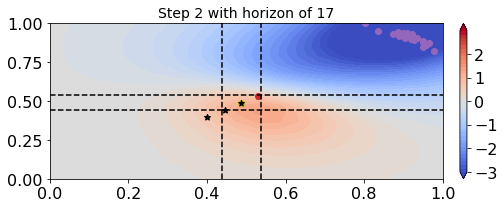

  2%|▏         | 1/50 [00:07<05:57,  7.30s/it]

x0:  [[0.5498178601264954, 0.5464909076690674]] , a:  [[[[[[[[[[[[[[[[[[[0.7499923706054688, 0.7259919047355652]], [[0.7528980374336243, 0.7256600260734558]], [[0.7841616868972778, 0.7398890256881714]], [[0.7554938197135925, 0.7539080381393433]], [[0.7433133125305176, 0.770500898361206]]], [[[0.7519652843475342, 0.789130449295044]], [[0.767536997795105, 0.7098121047019958]], [[0.7546464204788208, 0.7300418019294739]], [[0.72659832239151, 0.7496216297149658]], [[0.7556042671203613, 0.7544984221458435]]], [[[0.6841883063316345, 0.7411053776741028]], [[0.7429519891738892, 0.7860364317893982]], [[0.7540885806083679, 0.7392573952674866]], [[0.7491458058357239, 0.7194532752037048]], [[0.7562444806098938, 0.7782331109046936]]], [[[0.7615514397621155, 0.7617987394332886]], [[0.8167349696159363, 0.7411108613014221]], [[0.7119455337524414, 0.6955732703208923]], [[0.759596049785614, 0.7478625178337097]], [[0.7645900845527649, 0.7671686410903931]]], [[[0.7235274314880371, 0.7653294801712036]], [[0

 22%|██▏       | 11/50 [01:21<04:51,  7.48s/it]

x0:  [[0.5381678938865662, 0.5592418909072876]] , a:  [[[[[[[[[[[[[[[[[[[0.9391587376594543, 0.9387145042419434]], [[0.9460160732269287, 0.9184600114822388]], [[0.9682099223136902, 0.9229832887649536]], [[0.9187451601028442, 0.9478667378425598]], [[0.8956195116043091, 0.9901835322380066]]], [[[0.905784010887146, 0.9510680437088013]], [[0.967574954032898, 0.9016512036323547]], [[0.956828236579895, 0.9178658723831177]], [[0.9173054099082947, 0.9613168835639954]], [[0.9147273302078247, 0.9331984519958496]]], [[[0.8673775792121887, 0.998286783695221]], [[0.8923928141593933, 0.9576506018638611]], [[0.9404104948043823, 0.930418848991394]], [[0.9172241687774658, 0.950678288936615]], [[0.9080345630645752, 0.9333655834197998]]], [[[0.9010660648345947, 0.9402904510498047]], [[0.9673224687576294, 0.8613651990890503]], [[0.9437005519866943, 0.9212301969528198]], [[0.9224328398704529, 0.9552168846130371]], [[0.9156078100204468, 0.9542317390441895]]], [[[0.8623114228248596, 0.981383204460144]], [[0.

 42%|████▏     | 21/50 [02:37<03:38,  7.55s/it]

x0:  [[0.5380364060401917, 0.5635359287261963]] , a:  [[[[[[[[[[[[[[[[[[[0.930371105670929, 0.9295014142990112]], [[0.9330913424491882, 0.8730140328407288]], [[0.9513171911239624, 0.8791902661323547]], [[0.8778500556945801, 0.8926435708999634]], [[0.8434661626815796, 0.9651510715484619]]], [[[0.8728369474411011, 0.9020402431488037]], [[0.9558065533638, 0.8871335387229919]], [[0.9244326949119568, 0.8934206366539001]], [[0.8827630877494812, 0.9203353524208069]], [[0.8837000131607056, 0.8961260914802551]]], [[[0.8693118095397949, 1.0]], [[0.8420265913009644, 0.9213067293167114]], [[0.9249773025512695, 0.894603431224823]], [[0.8749535083770752, 0.9176608920097351]], [[0.8792673945426941, 0.9012668132781982]]], [[[0.8640257716178894, 0.9050174355506897]], [[0.9343491792678833, 0.832338809967041]], [[0.9723703265190125, 0.9417678117752075]], [[0.8812933564186096, 0.9085965156555176]], [[0.8742648363113403, 0.8894686102867126]]], [[[0.8341697454452515, 0.9438507556915283]], [[0.95919013023376

 62%|██████▏   | 31/50 [03:51<02:20,  7.38s/it]

x0:  [[0.5392194986343384, 0.5661534070968628]] , a:  [[[[[[[[[[[[[[[[[[[0.8786566853523254, 0.8941195011138916]], [[0.9240591526031494, 0.8556594252586365]], [[0.9366621971130371, 0.8418897390365601]], [[0.8975691795349121, 0.9042953848838806]], [[0.8287830948829651, 0.9431968331336975]]], [[[0.8981239199638367, 0.9046413898468018]], [[0.9196093678474426, 0.8384612798690796]], [[0.9202610850334167, 0.8856779336929321]], [[0.8720077276229858, 0.9114537239074707]], [[0.8959164023399353, 0.9181027412414551]]], [[[0.8156989216804504, 1.0]], [[0.8680139183998108, 0.938938558101654]], [[0.9183616042137146, 0.8612465262413025]], [[0.8493573665618896, 0.9026502966880798]], [[0.901572048664093, 0.9049926996231079]]], [[[0.892073929309845, 0.9249144792556763]], [[0.9499130249023438, 0.8724091053009033]], [[0.9238405227661133, 0.8916053175926208]], [[0.8922403454780579, 0.8967388868331909]], [[0.8877702951431274, 0.8946127891540527]]], [[[0.8386443257331848, 0.9408450126647949]], [[0.96870213747

 82%|████████▏ | 41/50 [05:07<01:10,  7.78s/it]

x0:  [[0.5418729782104492, 0.5679558515548706]] , a:  [[[[[[[[[[[[[[[[[[[0.8880388140678406, 0.9206717014312744]], [[0.9520222544670105, 0.880145788192749]], [[0.9641461372375488, 0.8619494438171387]], [[0.9029801487922668, 0.9073665738105774]], [[0.8629146814346313, 0.9704450368881226]]], [[[0.9004349112510681, 0.9065365791320801]], [[0.9477242231369019, 0.8632397055625916]], [[0.9413127899169922, 0.9020581841468811]], [[0.8976978063583374, 0.933334231376648]], [[0.9093968868255615, 0.9213423132896423]]], [[[0.778315007686615, 1.0]], [[0.8819299340248108, 0.9355150461196899]], [[0.9485443234443665, 0.87782222032547]], [[0.8788322806358337, 0.9296185374259949]], [[0.9114987850189209, 0.8988823890686035]]], [[[0.893578290939331, 0.9188412427902222]], [[0.945888340473175, 0.8870143890380859]], [[0.9066409468650818, 0.885473370552063]], [[0.9175491333007812, 0.9072005152702332]], [[0.9123098850250244, 0.9087557792663574]]], [[[0.8600485920906067, 0.9582260251045227]], [[0.9783015251159668

100%|██████████| 50/50 [06:14<00:00,  7.48s/it]


Current optimal loss 0.628789558641461;optimal action: tensor([[0.5576, 0.5833]], grad_fn=<AddBackward0>)


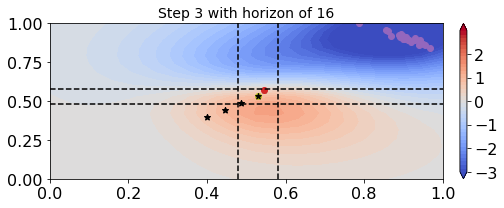

  2%|▏         | 1/50 [00:06<05:37,  6.88s/it]

x0:  [[0.549538254737854, 0.5852270722389221]] , a:  [[[[[[[[[[[[[[[[[[0.7503975033760071, 0.7636281251907349]], [[0.7825208306312561, 0.756293535232544]], [[0.7597945928573608, 0.7790783047676086]], [[0.7203178405761719, 0.7592533826828003]], [[0.7575134038925171, 0.8046039938926697]]], [[[0.745438814163208, 0.7832374572753906]], [[0.802854597568512, 0.7795548439025879]], [[0.7791684865951538, 0.7547391653060913]], [[0.7835370898246765, 0.7436246871948242]], [[0.7322223782539368, 0.7270816564559937]]], [[[0.7391164302825928, 0.7885007262229919]], [[0.7037229537963867, 0.7665565609931946]], [[0.7070801854133606, 0.7742666006088257]], [[0.7190264463424683, 0.7642046213150024]], [[0.7085809111595154, 0.7516518831253052]]], [[[0.7004908919334412, 0.8033967614173889]], [[0.7569515109062195, 0.7931889295578003]], [[0.7784067392349243, 0.732991635799408]], [[0.7234466671943665, 0.7558252811431885]], [[0.7349091172218323, 0.7486500144004822]]], [[[0.7236358523368835, 0.7472986578941345]], [[0

 22%|██▏       | 11/50 [01:17<04:46,  7.35s/it]

x0:  [[0.5500030517578125, 0.6009929776191711]] , a:  [[[[[[[[[[[[[[[[[[0.9506121873855591, 0.9480061531066895]], [[0.9423449039459229, 0.9414201974868774]], [[0.9522239565849304, 0.9723026156425476]], [[0.9244154095649719, 0.9816533327102661]], [[0.9385478496551514, 0.9824022054672241]]], [[[0.9219400882720947, 0.9582449197769165]], [[0.9468026757240295, 0.9043532609939575]], [[0.9850620627403259, 0.9404391050338745]], [[0.9628536105155945, 0.9362492561340332]], [[0.9651948809623718, 0.9414556622505188]]], [[[0.9487435817718506, 0.9770628213882446]], [[0.9111219644546509, 1.0]], [[0.9367256760597229, 0.9908961057662964]], [[0.9326366186141968, 0.987366259098053]], [[0.9222204089164734, 0.9639982581138611]]], [[[0.9122761487960815, 1.0]], [[0.9032844305038452, 0.9920530915260315]], [[0.9882069230079651, 0.9146767854690552]], [[0.9360758662223816, 0.9710888266563416]], [[0.9446170926094055, 0.9522425532341003]]], [[[0.933043360710144, 0.9499716758728027]], [[0.9296121597290039, 0.970097

 42%|████▏     | 21/50 [02:26<03:21,  6.93s/it]

x0:  [[0.5434821248054504, 0.6074867248535156]] , a:  [[[[[[[[[[[[[[[[[[0.9485453963279724, 0.9406245946884155]], [[0.8979312777519226, 0.893598198890686]], [[0.9440515041351318, 0.9595911502838135]], [[0.9168660640716553, 0.9720221161842346]], [[0.8811116814613342, 0.9442396759986877]]], [[[0.9112744331359863, 0.945746123790741]], [[0.9062983989715576, 0.883188784122467]], [[0.9626798033714294, 0.9342479705810547]], [[0.9280674457550049, 0.8937117457389832]], [[0.9803328514099121, 0.9536134600639343]]], [[[0.9155216813087463, 0.9679598808288574]], [[0.9171139597892761, 1.0]], [[0.9533590078353882, 1.0]], [[0.9272634983062744, 1.0]], [[0.9282918572425842, 0.9673503041267395]]], [[[0.9009832739830017, 1.0]], [[0.8808336853981018, 1.0]], [[1.0, 0.9084895849227905]], [[0.9357963800430298, 0.9628918766975403]], [[0.9305903315544128, 0.9420880079269409]]], [[[0.954571008682251, 0.9750434160232544]], [[0.9292768836021423, 0.9586910605430603]], [[0.901243269443512, 0.9711589813232422]], [[0.9

 62%|██████▏   | 31/50 [03:36<02:12,  6.97s/it]

x0:  [[0.5429264903068542, 0.6106245517730713]] , a:  [[[[[[[[[[[[[[[[[[0.9293254613876343, 0.9204806685447693]], [[0.8984335064888, 0.8816537261009216]], [[0.9087626338005066, 0.9310755133628845]], [[0.8744866251945496, 0.9297388792037964]], [[0.8847680687904358, 0.9436991214752197]]], [[[0.8962976932525635, 0.9234845638275146]], [[0.9081130623817444, 0.9079248905181885]], [[0.9247679114341736, 0.9118102788925171]], [[0.9090844392776489, 0.8699572086334229]], [[0.9315968155860901, 0.9065547585487366]]], [[[0.8769121170043945, 0.9509663581848145]], [[0.8753568530082703, 1.0]], [[0.9026960134506226, 1.0]], [[0.8704851269721985, 0.9849211573600769]], [[0.8822860717773438, 0.927090585231781]]], [[[0.8449149131774902, 1.0]], [[0.8447079062461853, 1.0]], [[1.0, 0.8693782687187195]], [[0.8927729725837708, 0.9115201830863953]], [[0.9006524085998535, 0.8996201157569885]]], [[[0.9165267944335938, 0.933402955532074]], [[0.8857049942016602, 0.9085373282432556]], [[0.9050813913345337, 0.9623825550

 82%|████████▏ | 41/50 [04:47<01:03,  7.00s/it]

x0:  [[0.5425611138343811, 0.6122698187828064]] , a:  [[[[[[[[[[[[[[[[[[0.9459218978881836, 0.9499111771583557]], [[0.9152622222900391, 0.8925487995147705]], [[0.931584358215332, 0.9661213159561157]], [[0.8935641646385193, 0.9467872977256775]], [[0.902897298336029, 0.9633887410163879]]], [[[0.908740222454071, 0.9440995454788208]], [[0.9050256013870239, 0.9153185486793518]], [[0.9528355002403259, 0.9391365051269531]], [[0.9296033382415771, 0.9001589417457581]], [[0.9255000352859497, 0.9095103740692139]]], [[[0.9120977520942688, 0.9838831424713135]], [[0.8351566791534424, 1.0]], [[0.8738017678260803, 1.0]], [[0.8570721745491028, 0.9720218777656555]], [[0.9025750756263733, 0.9484575390815735]]], [[[0.8443732857704163, 1.0]], [[0.850635826587677, 1.0]], [[1.0, 0.871703028678894]], [[0.9083521962165833, 0.9379688501358032]], [[0.9337024688720703, 0.9250770807266235]]], [[[0.9036746621131897, 0.931153416633606]], [[0.9013473391532898, 0.9326498508453369]], [[0.9249738454818726, 0.98003464937

100%|██████████| 50/50 [05:51<00:00,  7.02s/it]


Current optimal loss 0.49044898637724554;optimal action: tensor([[0.5567, 0.6282]], grad_fn=<AddBackward0>)


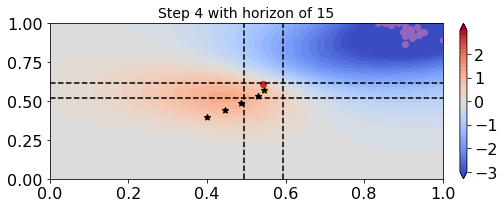

  2%|▏         | 1/50 [00:06<05:23,  6.61s/it]

x0:  [[0.5479758977890015, 0.6167965531349182]] , a:  [[[[[[[[[[[[[[[[[0.7677369713783264, 0.7877816557884216]], [[0.7520532011985779, 0.7903378009796143]], [[0.6923343539237976, 0.8110082149505615]], [[0.746515691280365, 0.7422435879707336]], [[0.7310565710067749, 0.8273234963417053]]], [[[0.7280694842338562, 0.8079732656478882]], [[0.7044848799705505, 0.7514957189559937]], [[0.7201665639877319, 0.7646132707595825]], [[0.7106136679649353, 0.8019037842750549]], [[0.76997309923172, 0.8047716021537781]]], [[[0.709749698638916, 0.835570752620697]], [[0.7083468437194824, 0.8559003472328186]], [[0.6907745003700256, 0.8417472839355469]], [[0.754996657371521, 0.7966333031654358]], [[0.7542486786842346, 0.7811189889907837]]], [[[0.702782154083252, 0.8287865519523621]], [[0.7522203922271729, 0.8311957716941833]], [[0.6880250573158264, 0.8191453814506531]], [[0.7185062170028687, 0.7866343855857849]], [[0.6911170482635498, 0.8269087076187134]]], [[[0.7271004319190979, 0.7768195867538452]], [[0.73

 22%|██▏       | 11/50 [01:12<04:15,  6.54s/it]

x0:  [[0.5538323521614075, 0.6247395277023315]] , a:  [[[[[[[[[[[[[[[[[0.9458460807800293, 0.9615216255187988]], [[0.9557212591171265, 0.9857431054115295]], [[0.8696644902229309, 1.0]], [[0.9661684036254883, 0.940221905708313]], [[0.927312970161438, 1.0]]], [[[0.9214634299278259, 1.0]], [[0.9503809809684753, 0.9749041199684143]], [[0.9061673879623413, 0.993050217628479]], [[0.9295878410339355, 0.9875914454460144]], [[0.9638004899024963, 0.9722834825515747]]], [[[0.9162821173667908, 1.0]], [[0.8922532796859741, 1.0]], [[0.8442609906196594, 1.0]], [[0.9547402262687683, 0.9845278859138489]], [[0.961127519607544, 0.9602818489074707]]], [[[0.885059654712677, 1.0]], [[0.9396393895149231, 0.992453396320343]], [[0.887633740901947, 1.0]], [[0.9346429109573364, 0.9959915280342102]], [[0.8835976719856262, 1.0]]], [[[0.9015210270881653, 1.0]], [[0.9615055918693542, 0.9606848359107971]], [[0.9287401437759399, 0.9647533893585205]], [[0.9459791779518127, 0.9939461946487427]], [[0.9532089233398438, 0.

 42%|████▏     | 21/50 [02:16<03:05,  6.38s/it]

x0:  [[0.5580644011497498, 0.6280855536460876]] , a:  [[[[[[[[[[[[[[[[[0.9327985644340515, 0.9559469819068909]], [[0.9594501256942749, 0.9829052090644836]], [[0.9032411575317383, 1.0]], [[1.0, 0.9768860936164856]], [[0.9362068772315979, 1.0]]], [[[0.9318286776542664, 1.0]], [[0.9986841678619385, 1.0]], [[0.935487687587738, 1.0]], [[0.94054114818573, 0.981436014175415]], [[0.9528858065605164, 0.9390692114830017]]], [[[0.9444229006767273, 1.0]], [[0.8924005031585693, 1.0]], [[0.885042667388916, 1.0]], [[0.9525936841964722, 0.9775739908218384]], [[0.9713484048843384, 0.9575236439704895]]], [[[0.911070704460144, 1.0]], [[0.9352882504463196, 1.0]], [[0.9280036091804504, 1.0]], [[0.9628032445907593, 1.0]], [[0.8896523118019104, 1.0]]], [[[0.9108508825302124, 1.0]], [[0.9762354493141174, 0.9804930686950684]], [[0.953036904335022, 0.9780905842781067]], [[0.9467118978500366, 0.9762057662010193]], [[0.9535295963287354, 0.9639285206794739]]]]]]]]]]]]]]]]] , loss:  -3.459278052244331


 62%|██████▏   | 31/50 [03:22<02:09,  6.79s/it]

x0:  [[0.5603682994842529, 0.6323950290679932]] , a:  [[[[[[[[[[[[[[[[[0.9092725515365601, 0.9389765858650208]], [[0.9191717505455017, 0.951120138168335]], [[0.8930678367614746, 1.0]], [[1.0, 0.9469503164291382]], [[0.9054591655731201, 1.0]]], [[[0.8955718278884888, 1.0]], [[0.9724659323692322, 1.0]], [[0.907573938369751, 1.0]], [[0.9105296730995178, 0.9474608898162842]], [[0.935597836971283, 0.9188781976699829]]], [[[0.9115296602249146, 1.0]], [[0.8708357810974121, 1.0]], [[0.8871566653251648, 1.0]], [[0.9195248484611511, 0.9365043044090271]], [[0.9382062554359436, 0.9213135242462158]]], [[[0.8858469128608704, 1.0]], [[0.8994371891021729, 1.0]], [[0.9214236736297607, 1.0]], [[0.9303986430168152, 1.0]], [[0.8632809519767761, 0.9985648989677429]]], [[[0.8868142366409302, 1.0]], [[0.9409648180007935, 0.9495909214019775]], [[0.9239339232444763, 0.9367077350616455]], [[0.9210590720176697, 0.9594269394874573]], [[0.9223251342773438, 0.9338669180870056]]]]]]]]]]]]]]]]] , loss:  -3.5035664832

 82%|████████▏ | 41/50 [04:27<00:58,  6.51s/it]

x0:  [[0.5620589852333069, 0.6361210942268372]] , a:  [[[[[[[[[[[[[[[[[0.9226901531219482, 0.9618852138519287]], [[0.9378029108047485, 0.9685413241386414]], [[0.8778818845748901, 1.0]], [[1.0, 0.9104230999946594]], [[0.8972960114479065, 1.0]]], [[[0.8874453902244568, 1.0]], [[0.9224570989608765, 1.0]], [[0.8803900480270386, 1.0]], [[0.9285361170768738, 0.9660156965255737]], [[0.9581445455551147, 0.9494861364364624]]], [[[0.8917059302330017, 1.0]], [[0.8852030634880066, 1.0]], [[0.8905429244041443, 1.0]], [[0.9390192031860352, 0.967809796333313]], [[0.9516319036483765, 0.9438647031784058]]], [[[0.8793725371360779, 1.0]], [[0.8996062874794006, 1.0]], [[0.9035769701004028, 1.0]], [[0.8989768624305725, 1.0]], [[0.8884543180465698, 1.0]]], [[[0.8865876793861389, 1.0]], [[0.9297246932983398, 0.9481518268585205]], [[0.9274222254753113, 0.946629524230957]], [[0.9369071125984192, 0.982571542263031]], [[0.9294008016586304, 0.9648153781890869]]]]]]]]]]]]]]]]] , loss:  -3.52316676546981


100%|██████████| 50/50 [05:25<00:00,  6.52s/it]


Current optimal loss 0.02164933513234081;optimal action: tensor([[0.5775, 0.6543]], grad_fn=<AddBackward0>)


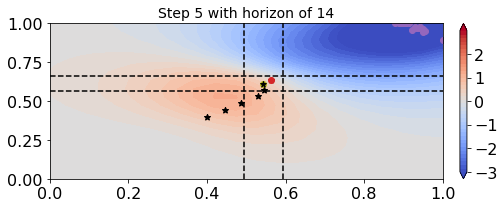

  2%|▏         | 1/50 [00:05<04:44,  5.81s/it]

x0:  [[0.5834646224975586, 0.6455731987953186]] , a:  [[[[[[[[[[[[[[[[0.7347353100776672, 0.8424279689788818]], [[0.7417281270027161, 0.7877524495124817]], [[0.7717999219894409, 0.8330117464065552]], [[0.7722283005714417, 0.8278972506523132]], [[0.7248003482818604, 0.7873236536979675]]], [[[0.7478952407836914, 0.7824041843414307]], [[0.8029686212539673, 0.7988298535346985]], [[0.7414705753326416, 0.8372587561607361]], [[0.7957669496536255, 0.8143473863601685]], [[0.6863402128219604, 0.7730066180229187]]], [[[0.7044156193733215, 0.8192943334579468]], [[0.6916871666908264, 0.7908056974411011]], [[0.7469940781593323, 0.8204270005226135]], [[0.7332966923713684, 0.7983425259590149]], [[0.7261397242546082, 0.8146919012069702]]], [[[0.7712427377700806, 0.8275678157806396]], [[0.7226271629333496, 0.8184472322463989]], [[0.7441091537475586, 0.8087025880813599]], [[0.7746284008026123, 0.8033239245414734]], [[0.7533053755760193, 0.8070667386054993]]], [[[0.7561628222465515, 0.8346073031425476]], 

 22%|██▏       | 11/50 [01:07<03:56,  6.06s/it]

x0:  [[0.5656694173812866, 0.636993944644928]] , a:  [[[[[[[[[[[[[[[[0.8849011659622192, 0.9974237084388733]], [[0.9002587795257568, 0.9361768960952759]], [[0.90308678150177, 0.9816823601722717]], [[0.8567497730255127, 0.9351789951324463]], [[0.896898090839386, 0.937762439250946]]], [[[0.9098744988441467, 0.9700289964675903]], [[0.9255940914154053, 0.9200288653373718]], [[0.8555615544319153, 0.9956227540969849]], [[0.8937765955924988, 0.9031452536582947]], [[0.8732786774635315, 0.9331810474395752]]], [[[0.8530739545822144, 0.9916595816612244]], [[0.8460402488708496, 0.9846268892288208]], [[0.8708767294883728, 0.9645441770553589]], [[0.8739460110664368, 0.9368056654930115]], [[0.8926352262496948, 0.9494637250900269]]], [[[0.8935381770133972, 0.9479914903640747]], [[0.8719622492790222, 0.9708657264709473]], [[0.8987603187561035, 0.9297782182693481]], [[0.8807856440544128, 0.9336462020874023]], [[0.8902919292449951, 0.941265344619751]]], [[[0.8872172832489014, 0.9942374229431152]], [[0.90

 42%|████▏     | 21/50 [02:07<02:53,  5.97s/it]

x0:  [[0.567152202129364, 0.6347475647926331]] , a:  [[[[[[[[[[[[[[[[0.8333389759063721, 1.0]], [[0.893928587436676, 0.9083172082901001]], [[0.8706198334693909, 0.9167871475219727]], [[0.849338710308075, 0.904815673828125]], [[0.8782227039337158, 0.9093308448791504]]], [[[0.8913151621818542, 0.9285693168640137]], [[0.8989062905311584, 0.8693901896476746]], [[0.814434289932251, 0.955564022064209]], [[0.8557480573654175, 0.8644897937774658]], [[0.9032647013664246, 0.9427413940429688]]], [[[0.8655123710632324, 1.0]], [[0.8669906854629517, 1.0]], [[0.8465409874916077, 0.9139977693557739]], [[0.8537154793739319, 0.9076032042503357]], [[0.8779416680335999, 0.8896001577377319]]], [[[0.8468128442764282, 0.8905327916145325]], [[0.8652641773223877, 0.9401170015335083]], [[0.8856989741325378, 0.9024478197097778]], [[0.8527497053146362, 0.8940011262893677]], [[0.8584648966789246, 0.899362325668335]]], [[[0.8469206094741821, 0.9602988362312317]], [[0.8807151913642883, 0.8611235618591309]], [[0.8480

 62%|██████▏   | 31/50 [03:09<01:59,  6.30s/it]

x0:  [[0.5709055662155151, 0.6309001445770264]] , a:  [[[[[[[[[[[[[[[[0.7800909876823425, 0.9850946068763733]], [[0.8606191873550415, 0.8373239636421204]], [[0.8473867774009705, 0.84755939245224]], [[0.8618067502975464, 0.8608857989311218]], [[0.8473562002182007, 0.8472867608070374]]], [[[0.8426778316497803, 0.8397265672683716]], [[0.8631959557533264, 0.8072364926338196]], [[0.8282694220542908, 0.9067464470863342]], [[0.8797577619552612, 0.8546528816223145]], [[0.8657573461532593, 0.8899296522140503]]], [[[0.8185727000236511, 0.9673885703086853]], [[0.8343589305877686, 1.0]], [[0.8344124555587769, 0.8573307394981384]], [[0.8458375930786133, 0.8649224042892456]], [[0.8668420910835266, 0.8312629461288452]]], [[[0.8691953420639038, 0.8533114194869995]], [[0.8366720080375671, 0.8686375617980957]], [[0.8432977795600891, 0.8385419249534607]], [[0.8643361330032349, 0.8373669385910034]], [[0.8612967729568481, 0.8519570231437683]]], [[[0.8263382911682129, 0.895643413066864]], [[0.87496823072433

 82%|████████▏ | 41/50 [04:09<00:54,  6.05s/it]

x0:  [[0.5738863945007324, 0.6262552738189697]] , a:  [[[[[[[[[[[[[[[[0.8136610388755798, 0.9439124464988708]], [[0.8816666603088379, 0.8278824090957642]], [[0.8915927410125732, 0.8430664539337158]], [[0.8914517164230347, 0.8380917906761169]], [[0.8931601047515869, 0.8330827355384827]]], [[[0.8750839233398438, 0.8393334150314331]], [[0.8961619138717651, 0.8402637243270874]], [[0.8638888001441956, 0.8770103454589844]], [[0.8847329616546631, 0.8322531580924988]], [[0.8521914482116699, 0.8554866313934326]]], [[[0.8074207305908203, 0.9219821691513062]], [[0.794804573059082, 1.0]], [[0.8747956156730652, 0.8492602109909058]], [[0.8832151889801025, 0.8474202156066895]], [[0.8998558521270752, 0.8220274448394775]]], [[[0.8840605616569519, 0.820439875125885]], [[0.8712836503982544, 0.8556637763977051]], [[0.879212498664856, 0.8356558084487915]], [[0.8943738341331482, 0.8329058885574341]], [[0.9029641151428223, 0.8333248496055603]]], [[[0.8685210943222046, 0.8697797060012817]], [[0.89632487297058

100%|██████████| 50/50 [05:03<00:00,  6.07s/it]


Current optimal loss -0.038208356545675816;optimal action: tensor([[0.5903, 0.6392]], grad_fn=<AddBackward0>)


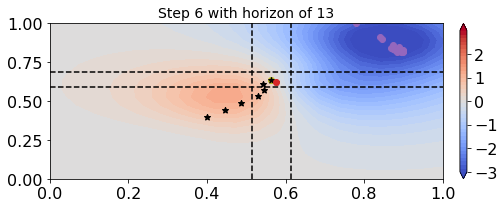

  2%|▏         | 1/50 [00:05<04:28,  5.47s/it]

x0:  [[0.5937736630439758, 0.6329817175865173]] , a:  [[[[[[[[[[[[[[[0.7442939281463623, 0.7975949048995972]], [[0.7607353925704956, 0.7609550952911377]], [[0.7558024525642395, 0.7702798843383789]], [[0.7663280963897705, 0.8080272078514099]], [[0.7751871943473816, 0.8493065237998962]]], [[[0.8055972456932068, 0.808242917060852]], [[0.6878570318222046, 0.7712457776069641]], [[0.7693829536437988, 0.7706717252731323]], [[0.7784002423286438, 0.7759745121002197]], [[0.7159318923950195, 0.8093356490135193]]], [[[0.7675131559371948, 0.7875455617904663]], [[0.7621501684188843, 0.8420641422271729]], [[0.7905595898628235, 0.7562412023544312]], [[0.7177795171737671, 0.7859070301055908]], [[0.7757660150527954, 0.8036788702011108]]], [[[0.752360999584198, 0.8103594183921814]], [[0.781485915184021, 0.8026542067527771]], [[0.7879281640052795, 0.8011035919189453]], [[0.7389435172080994, 0.7729755640029907]], [[0.7553746700286865, 0.768548309803009]]], [[[0.7379143238067627, 0.805051326751709]], [[0.72

 22%|██▏       | 11/50 [01:01<03:38,  5.59s/it]

x0:  [[0.5991013050079346, 0.6125498414039612]] , a:  [[[[[[[[[[[[[[[0.8899664282798767, 0.9298326373100281]], [[0.9221093058586121, 0.9108732342720032]], [[0.9334096908569336, 0.8901546001434326]], [[0.9103975892066956, 0.9247244000434875]], [[0.8825884461402893, 0.9522366523742676]]], [[[0.9278587102890015, 0.8739925622940063]], [[0.8546894788742065, 0.9345785975456238]], [[0.9422403573989868, 0.8855809569358826]], [[0.9206352829933167, 0.9068199396133423]], [[0.8860815763473511, 0.954069972038269]]], [[[0.9185178875923157, 0.922960638999939]], [[0.8727231025695801, 0.9307378530502319]], [[0.9575446844100952, 0.8672292828559875]], [[0.89173823595047, 0.9358723163604736]], [[0.9157919883728027, 0.9194046258926392]]], [[[0.8996350169181824, 0.9336144328117371]], [[0.912927508354187, 0.9105461835861206]], [[0.9280308485031128, 0.8999204039573669]], [[0.904719889163971, 0.9353868365287781]], [[0.9169438481330872, 0.9021203517913818]]], [[[0.897003173828125, 0.925183892250061]], [[0.87981

 42%|████▏     | 21/50 [01:56<02:38,  5.47s/it]

x0:  [[0.5995203256607056, 0.5985531806945801]] , a:  [[[[[[[[[[[[[[[0.8953827619552612, 0.888780415058136]], [[0.9265537261962891, 0.8668253421783447]], [[0.9074233174324036, 0.8622604012489319]], [[0.894058346748352, 0.841903805732727]], [[0.8639988303184509, 0.8690379858016968]]], [[[0.9198524355888367, 0.8183432817459106]], [[0.8789293169975281, 0.9362286925315857]], [[0.9255157709121704, 0.8331484198570251]], [[0.9120128750801086, 0.8512970209121704]], [[0.894010066986084, 0.9210386872291565]]], [[[0.918705403804779, 0.8762073516845703]], [[0.8570096492767334, 0.8875897526741028]], [[0.9334188103675842, 0.828723132610321]], [[0.9082538485527039, 0.9059171080589294]], [[0.9091426134109497, 0.8543564081192017]]], [[[0.8932444453239441, 0.8738579154014587]], [[0.8893455266952515, 0.8520322442054749]], [[0.8947054743766785, 0.8441281914710999]], [[0.9211685657501221, 0.9105774164199829]], [[0.9268869161605835, 0.8668996691703796]]], [[[0.9048900604248047, 0.8788427710533142]], [[0.882

 62%|██████▏   | 31/50 [02:51<01:43,  5.46s/it]

x0:  [[0.5986956357955933, 0.5909412503242493]] , a:  [[[[[[[[[[[[[[[0.8688104152679443, 0.809954822063446]], [[0.8864611387252808, 0.7913610339164734]], [[0.8652611970901489, 0.7999885082244873]], [[0.887115478515625, 0.8151257038116455]], [[0.8992608785629272, 0.8125085830688477]]], [[[0.8955656290054321, 0.7901197075843811]], [[0.8542953133583069, 0.8886674046516418]], [[0.8866400122642517, 0.7860545516014099]], [[0.8811649084091187, 0.8074289560317993]], [[0.864231526851654, 0.8489681482315063]]], [[[0.8817059993743896, 0.7937917709350586]], [[0.8663975596427917, 0.8429117798805237]], [[0.8796944618225098, 0.7907106876373291]], [[0.8774678707122803, 0.8495057225227356]], [[0.8913220763206482, 0.7946183085441589]]], [[[0.8767796158790588, 0.7985847592353821]], [[0.8951547145843506, 0.8221629858016968]], [[0.8706568479537964, 0.7965685129165649]], [[0.888012707233429, 0.8481510877609253]], [[0.8906909823417664, 0.7811945080757141]]], [[[0.8789260387420654, 0.822050154209137]], [[0.85

 82%|████████▏ | 41/50 [03:48<00:50,  5.58s/it]

x0:  [[0.5959858894348145, 0.5871389508247375]] , a:  [[[[[[[[[[[[[[[0.8962662816047668, 0.7953295111656189]], [[0.8990150094032288, 0.7932683825492859]], [[0.8996008038520813, 0.7856942415237427]], [[0.910431444644928, 0.8315885066986084]], [[0.9105386137962341, 0.7912185788154602]]], [[[0.9144590497016907, 0.7955382466316223]], [[0.8552249670028687, 0.8484112024307251]], [[0.9019325375556946, 0.7904242873191833]], [[0.9035543203353882, 0.8381859064102173]], [[0.8867396116256714, 0.8295376896858215]]], [[[0.9064911603927612, 0.7958100438117981]], [[0.8950239419937134, 0.8171918392181396]], [[0.8914286494255066, 0.8027649521827698]], [[0.8871454000473022, 0.8399860858917236]], [[0.9106700420379639, 0.7974578142166138]]], [[[0.9097141623497009, 0.8019993305206299]], [[0.9080833196640015, 0.8045226335525513]], [[0.9041455984115601, 0.7986750602722168]], [[0.8836135268211365, 0.8270841836929321]], [[0.9016908407211304, 0.7774360179901123]]], [[[0.8979707360267639, 0.8119467496871948]], [[

100%|██████████| 50/50 [04:38<00:00,  5.57s/it]


Current optimal loss -0.0709681180203772;optimal action: tensor([[0.6075, 0.5998]], grad_fn=<AddBackward0>)


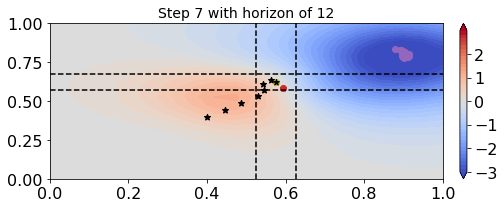

  2%|▏         | 1/50 [00:05<04:07,  5.05s/it]

x0:  [[0.6028538942337036, 0.5983749628067017]] , a:  [[[[[[[[[[[[[[0.7035616040229797, 0.7421915531158447]], [[0.7518131136894226, 0.7912129163742065]], [[0.7435188889503479, 0.7772775888442993]], [[0.7381951808929443, 0.7379283308982849]], [[0.7591588497161865, 0.7799116373062134]]], [[[0.7468546032905579, 0.7431014776229858]], [[0.7724040150642395, 0.7687059640884399]], [[0.7423818707466125, 0.7588359117507935]], [[0.7557544112205505, 0.6946631669998169]], [[0.7671623229980469, 0.7376783490180969]]], [[[0.7149888277053833, 0.7575416564941406]], [[0.7593846917152405, 0.7500138878822327]], [[0.7584559321403503, 0.7469657063484192]], [[0.7284495234489441, 0.7152976989746094]], [[0.7063565850257874, 0.7993788719177246]]], [[[0.7572240233421326, 0.7282587885856628]], [[0.7197852730751038, 0.7623270750045776]], [[0.726507306098938, 0.7744089961051941]], [[0.6977239847183228, 0.7332863807678223]], [[0.7671904563903809, 0.7291499972343445]]], [[[0.7494524121284485, 0.7896057963371277]], [[0

 22%|██▏       | 11/50 [00:55<03:20,  5.14s/it]

x0:  [[0.6165845394134521, 0.5759835243225098]] , a:  [[[[[[[[[[[[[[0.8867164850234985, 0.8943253755569458]], [[0.8826689124107361, 0.8984788060188293]], [[0.8920305967330933, 0.9110398292541504]], [[0.9379071593284607, 0.8602820634841919]], [[0.8891763687133789, 0.8955280780792236]]], [[[0.909546971321106, 0.8790040612220764]], [[0.9143458604812622, 0.8766227960586548]], [[0.9022278785705566, 0.8858221173286438]], [[0.9406025409698486, 0.8139866590499878]], [[0.9146901369094849, 0.8834782242774963]]], [[[0.8762122392654419, 0.8985296487808228]], [[0.9160515666007996, 0.8765660524368286]], [[0.9073853492736816, 0.8769650459289551]], [[0.9314466714859009, 0.8494439721107483]], [[0.8721165657043457, 0.9181676506996155]]], [[[0.9116290807723999, 0.8740556240081787]], [[0.893020749092102, 0.8982807993888855]], [[0.8901892900466919, 0.900396466255188]], [[0.9123250246047974, 0.8624202609062195]], [[0.9163873195648193, 0.8558207750320435]]], [[[0.8848701119422913, 0.8918143510818481]], [[0.9

 42%|████▏     | 21/50 [01:48<02:28,  5.14s/it]

x0:  [[0.6176744699478149, 0.5594869256019592]] , a:  [[[[[[[[[[[[[[0.9160419702529907, 0.886009693145752]], [[0.8997614979743958, 0.8624787330627441]], [[0.9087947607040405, 0.8873320817947388]], [[0.9572122693061829, 0.8394190073013306]], [[0.8790134191513062, 0.8506488800048828]]], [[[0.9229679703712463, 0.8545351028442383]], [[0.9116531610488892, 0.8265625238418579]], [[0.9162665605545044, 0.862438976764679]], [[0.9745153188705444, 0.8202130794525146]], [[0.9269218444824219, 0.8582562804222107]]], [[[0.8975110650062561, 0.8774640560150146]], [[0.9369298219680786, 0.8507745862007141]], [[0.9137402772903442, 0.8472706079483032]], [[0.9585512280464172, 0.8380102515220642]], [[0.8891850709915161, 0.8809141516685486]]], [[[0.9224141240119934, 0.8542995452880859]], [[0.9250562191009521, 0.8902416825294495]], [[0.9058505892753601, 0.86050945520401]], [[0.9487171173095703, 0.8605597019195557]], [[0.9287815093994141, 0.8315892815589905]]], [[[0.8934776186943054, 0.8492149114608765]], [[0.93

 62%|██████▏   | 31/50 [02:38<01:36,  5.09s/it]

x0:  [[0.614826500415802, 0.5486670136451721]] , a:  [[[[[[[[[[[[[[0.893994927406311, 0.824795663356781]], [[0.8786394596099854, 0.7877709865570068]], [[0.8853040933609009, 0.81890469789505]], [[0.9040104746818542, 0.7793006300926208]], [[0.8719776272773743, 0.794714629650116]]], [[[0.8900524377822876, 0.7806408405303955]], [[0.8878195285797119, 0.756773054599762]], [[0.8893888592720032, 0.8027262687683105]], [[0.9415387511253357, 0.7773057222366333]], [[0.8952258825302124, 0.7869704961776733]]], [[[0.8742876052856445, 0.8175502419471741]], [[0.9067088961601257, 0.7807064652442932]], [[0.8857361674308777, 0.7792268991470337]], [[0.9158769249916077, 0.7780317664146423]], [[0.8759434223175049, 0.8174737095832825]]], [[[0.8915886282920837, 0.7876110672950745]], [[0.8935738801956177, 0.826326310634613]], [[0.8789278864860535, 0.7883381247520447]], [[0.9108716249465942, 0.8078857660293579]], [[0.9002962708473206, 0.7717896103858948]]], [[[0.8803728818893433, 0.7957995533943176]], [[0.905533

 82%|████████▏ | 41/50 [03:29<00:45,  5.10s/it]

x0:  [[0.6074898838996887, 0.5439140796661377]] , a:  [[[[[[[[[[[[[[0.8813438415527344, 0.7807899713516235]], [[0.8951079249382019, 0.766558825969696]], [[0.8872966766357422, 0.7788918018341064]], [[0.8726503252983093, 0.7531160116195679]], [[0.907155454158783, 0.7750460505485535]]], [[[0.894882321357727, 0.7569807767868042]], [[0.9084150791168213, 0.7631655931472778]], [[0.8886720538139343, 0.7774780988693237]], [[0.8921204209327698, 0.7415844798088074]], [[0.8967707753181458, 0.7626408338546753]]], [[[0.880186140537262, 0.7901881337165833]], [[0.8906314969062805, 0.7570431232452393]], [[0.8973353505134583, 0.7674394845962524]], [[0.8781775236129761, 0.7435671091079712]], [[0.8856731057167053, 0.7812134027481079]]], [[[0.8921079635620117, 0.752726674079895]], [[0.8708962202072144, 0.7806735038757324]], [[0.891457736492157, 0.772235631942749]], [[0.8700151443481445, 0.7592794895172119]], [[0.904163122177124, 0.7592872381210327]]], [[[0.8945891261100769, 0.7906733155250549]], [[0.902915

100%|██████████| 50/50 [04:17<00:00,  5.15s/it]


Current optimal loss 0.011598299466432574;optimal action: tensor([[0.6193, 0.5560]], grad_fn=<AddBackward0>)


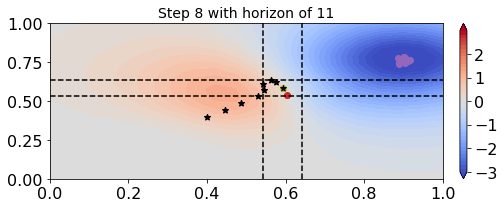

  2%|▏         | 1/50 [00:04<03:51,  4.72s/it]

x0:  [[0.6179521083831787, 0.5497509837150574]] , a:  [[[[[[[[[[[[[0.7464066743850708, 0.7275751233100891]], [[0.7484383583068848, 0.6595049500465393]], [[0.7375235557556152, 0.7102049589157104]], [[0.7802442908287048, 0.7018169164657593]], [[0.755348801612854, 0.6486994624137878]]], [[[0.7585034370422363, 0.6668869256973267]], [[0.7363296151161194, 0.6846601366996765]], [[0.726409375667572, 0.6847858428955078]], [[0.7540227174758911, 0.6950384378433228]], [[0.7486655116081238, 0.7156429886817932]]], [[[0.7642245292663574, 0.7055824398994446]], [[0.7472582459449768, 0.7005249857902527]], [[0.7799195051193237, 0.7034517526626587]], [[0.7527318000793457, 0.7329339981079102]], [[0.765708327293396, 0.6541801691055298]]], [[[0.7326538562774658, 0.6437959671020508]], [[0.7224794030189514, 0.6910490393638611]], [[0.7413483262062073, 0.7124674320220947]], [[0.7901172041893005, 0.6782532930374146]], [[0.7443805932998657, 0.6902603507041931]]], [[[0.7554346919059753, 0.6473316550254822]], [[0.69

 22%|██▏       | 11/50 [00:50<02:56,  4.53s/it]

x0:  [[0.6294983625411987, 0.5512983798980713]] , a:  [[[[[[[[[[[[[0.9207850098609924, 0.8417873382568359]], [[0.872990071773529, 0.8385903239250183]], [[0.9042789340019226, 0.8747132420539856]], [[0.939187228679657, 0.8657216429710388]], [[0.9028000831604004, 0.8145228028297424]]], [[[0.9290304183959961, 0.7976086139678955]], [[0.8793268799781799, 0.8557133674621582]], [[0.9008523225784302, 0.8627859354019165]], [[0.9295704364776611, 0.8675317764282227]], [[0.8917975425720215, 0.8707987666130066]]], [[[0.9320535659790039, 0.8296309113502502]], [[0.891716718673706, 0.865258514881134]], [[0.9260034561157227, 0.8649836182594299]], [[0.9151215553283691, 0.8847929239273071]], [[0.9086217284202576, 0.8357183337211609]]], [[[0.9201288223266602, 0.7906127572059631]], [[0.8745340704917908, 0.861877977848053]], [[0.8962609171867371, 0.8706494569778442]], [[0.9393027424812317, 0.8539243936538696]], [[0.891445517539978, 0.8606133460998535]]], [[[0.9345153570175171, 0.8012836575508118]], [[0.86420

 42%|████▏     | 21/50 [01:35<02:11,  4.53s/it]

x0:  [[0.6270043849945068, 0.5281793475151062]] , a:  [[[[[[[[[[[[[0.9277998208999634, 0.814415693283081]], [[0.8991726636886597, 0.8459721207618713]], [[0.9041397571563721, 0.8703674674034119]], [[0.9320600628852844, 0.8575639724731445]], [[0.9281566739082336, 0.822185218334198]]], [[[0.9532320499420166, 0.790888786315918]], [[0.9060937166213989, 0.857995331287384]], [[0.9120693802833557, 0.8741967082023621]], [[0.935210108757019, 0.8749175071716309]], [[0.9025201201438904, 0.8536405563354492]]], [[[0.9389446377754211, 0.8115164041519165]], [[0.9124073386192322, 0.8584610223770142]], [[0.9177553653717041, 0.846895158290863]], [[0.9085118770599365, 0.8748927116394043]], [[0.929821789264679, 0.8378671407699585]]], [[[0.9566686749458313, 0.7965523600578308]], [[0.9061070680618286, 0.8645431399345398]], [[0.9036353826522827, 0.8760188817977905]], [[0.9330461621284485, 0.8558070063591003]], [[0.913994312286377, 0.8587546944618225]]], [[[0.9616859555244446, 0.8084404468536377]], [[0.9045180

 62%|██████▏   | 31/50 [02:22<01:28,  4.67s/it]

x0:  [[0.6230376958847046, 0.515841543674469]] , a:  [[[[[[[[[[[[[0.8852325677871704, 0.7583329081535339]], [[0.8874033689498901, 0.8034112453460693]], [[0.870319128036499, 0.8191353678703308]], [[0.8878918886184692, 0.804702877998352]], [[0.9162895083427429, 0.7854440808296204]]], [[[0.9238752722740173, 0.7464544773101807]], [[0.8908841609954834, 0.8145735263824463]], [[0.8835311532020569, 0.83669513463974]], [[0.8856766819953918, 0.8349022269248962]], [[0.877443790435791, 0.8001223802566528]]], [[[0.8956472277641296, 0.7610127925872803]], [[0.8898758888244629, 0.8069005012512207]], [[0.880509614944458, 0.7873174548149109]], [[0.8673497438430786, 0.8314211368560791]], [[0.9146945476531982, 0.7962812781333923]]], [[[0.936199426651001, 0.7630161046981812]], [[0.8971829414367676, 0.8222280144691467]], [[0.878501832485199, 0.8369799256324768]], [[0.8778555989265442, 0.8103080987930298]], [[0.897571861743927, 0.8133957982063293]]], [[[0.9319425821304321, 0.7722508907318115]], [[0.893056392

 82%|████████▏ | 41/50 [03:08<00:41,  4.62s/it]

x0:  [[0.620261013507843, 0.5152512192726135]] , a:  [[[[[[[[[[[[[0.884831428527832, 0.7492997646331787]], [[0.8676596879959106, 0.7658412456512451]], [[0.8667975664138794, 0.780413806438446]], [[0.8817482590675354, 0.7918004393577576]], [[0.8945473432540894, 0.7536686062812805]]], [[[0.8935854434967041, 0.7251098155975342]], [[0.8715002536773682, 0.7740856409072876]], [[0.8621107339859009, 0.7943246364593506]], [[0.8668404221534729, 0.8044103980064392]], [[0.8731017112731934, 0.7674136161804199]]], [[[0.8813932538032532, 0.7422401905059814]], [[0.8756541013717651, 0.7709715366363525]], [[0.8789393901824951, 0.762771487236023]], [[0.8751528859138489, 0.8132019639015198]], [[0.8899731040000916, 0.7618050575256348]]], [[[0.8980814218521118, 0.7295377850532532]], [[0.877456784248352, 0.7778005599975586]], [[0.8647302389144897, 0.7980698347091675]], [[0.8700264096260071, 0.7923265099525452]], [[0.8757994771003723, 0.7691068053245544]]], [[[0.8882681131362915, 0.7373778820037842]], [[0.8699

100%|██████████| 50/50 [03:52<00:00,  4.65s/it]


Current optimal loss -0.020802346399319133;optimal action: tensor([[0.6348, 0.5271]], grad_fn=<AddBackward0>)


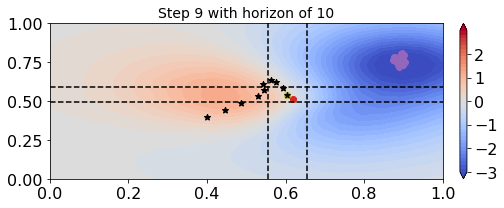

  2%|▏         | 1/50 [00:03<03:15,  3.98s/it]

x0:  [[0.6357001066207886, 0.5321651697158813]] , a:  [[[[[[[[[[[[0.7236639261245728, 0.5965327620506287]], [[0.7488171458244324, 0.6178650259971619]], [[0.7149693965911865, 0.6487420201301575]], [[0.7556939721107483, 0.6515488624572754]], [[0.780868411064148, 0.6502795815467834]]], [[[0.767312228679657, 0.6516866683959961]], [[0.7269441485404968, 0.6475337743759155]], [[0.7529286742210388, 0.6626181602478027]], [[0.7430111765861511, 0.6344337463378906]], [[0.7240073680877686, 0.6242955327033997]]], [[[0.744065523147583, 0.6383607983589172]], [[0.7160019278526306, 0.6256486177444458]], [[0.7344159483909607, 0.6475757956504822]], [[0.7615218162536621, 0.66460120677948]], [[0.7666945457458496, 0.6044089794158936]]], [[[0.7344469428062439, 0.629937469959259]], [[0.7791734337806702, 0.6630441546440125]], [[0.7702624797821045, 0.7212186455726624]], [[0.7505047917366028, 0.6588973999023438]], [[0.7607361674308777, 0.6461532115936279]]], [[[0.7872592210769653, 0.6236184239387512]], [[0.737204

 22%|██▏       | 11/50 [00:47<02:58,  4.59s/it]

x0:  [[0.6461554169654846, 0.543282687664032]] , a:  [[[[[[[[[[[[0.9053694605827332, 0.7404512166976929]], [[0.9145342111587524, 0.7789656519889832]], [[0.8738489151000977, 0.8289470076560974]], [[0.886452853679657, 0.8223023414611816]], [[0.9396775364875793, 0.7839473485946655]]], [[[0.9291219711303711, 0.7893183827400208]], [[0.8931534290313721, 0.828446626663208]], [[0.8778375387191772, 0.8087253570556641]], [[0.8553149104118347, 0.7857604622840881]], [[0.9084256887435913, 0.7728109955787659]]], [[[0.9077443480491638, 0.7832010388374329]], [[0.9002114534378052, 0.81224524974823]], [[0.8837345242500305, 0.826424241065979]], [[0.8919039964675903, 0.8317668437957764]], [[0.9281578063964844, 0.7571906447410583]]], [[[0.9099104404449463, 0.7779984474182129]], [[0.933597207069397, 0.8332709670066833]], [[0.8976473808288574, 0.8665337562561035]], [[0.8701294660568237, 0.824722945690155]], [[0.9267740845680237, 0.7840278744697571]]], [[[0.9439135193824768, 0.7739070653915405]], [[0.91581875

 42%|████▏     | 21/50 [01:29<02:02,  4.23s/it]

x0:  [[0.6393366456031799, 0.5397233366966248]] , a:  [[[[[[[[[[[[0.9465576410293579, 0.7838101387023926]], [[0.9279851913452148, 0.8241251707077026]], [[0.8978182077407837, 0.8716328144073486]], [[0.9023212790489197, 0.847490668296814]], [[0.9526562094688416, 0.8084204196929932]]], [[[0.9451278448104858, 0.814467191696167]], [[0.9167554378509521, 0.8778420686721802]], [[0.8949630260467529, 0.8506686091423035]], [[0.8811584711074829, 0.820214033126831]], [[0.9468821287155151, 0.810957670211792]]], [[[0.9402800798416138, 0.8179309368133545]], [[0.9287856817245483, 0.8632400035858154]], [[0.9032804369926453, 0.8656731247901917]], [[0.9070298075675964, 0.858808159828186]], [[0.9584363698959351, 0.7964975237846375]]], [[[0.9426378607749939, 0.8135983347892761]], [[0.9313364028930664, 0.8656818270683289]], [[0.8812589049339294, 0.8752044439315796]], [[0.8929847478866577, 0.8612078428268433]], [[0.944463849067688, 0.8110405206680298]]], [[[0.9613587856292725, 0.8075201511383057]], [[0.938943

 62%|██████▏   | 31/50 [02:11<01:20,  4.25s/it]

x0:  [[0.6283490061759949, 0.530329704284668]] , a:  [[[[[[[[[[[[0.9365428686141968, 0.780005931854248]], [[0.8914844393730164, 0.8158440589904785]], [[0.8810403347015381, 0.8608688116073608]], [[0.8867348432540894, 0.819304347038269]], [[0.9134842753410339, 0.791435182094574]]], [[[0.907963216304779, 0.7940605878829956]], [[0.8818263411521912, 0.8703774809837341]], [[0.882601261138916, 0.8361537456512451]], [[0.8890693187713623, 0.8043340444564819]], [[0.929588794708252, 0.8048215508460999]]], [[[0.9186983704566956, 0.8073078989982605]], [[0.898377001285553, 0.8559589982032776]], [[0.8864794373512268, 0.8485737442970276]], [[0.8882953524589539, 0.8297268748283386]], [[0.9378575682640076, 0.7874789834022522]]], [[[0.9242766499519348, 0.8022318482398987]], [[0.8769446611404419, 0.8399488925933838]], [[0.8461500406265259, 0.838586688041687]], [[0.8849920034408569, 0.8396661877632141]], [[0.9089587926864624, 0.7964954972267151]]], [[[0.9299122095108032, 0.7904602885246277]], [[0.905977725

 82%|████████▏ | 41/50 [02:52<00:38,  4.23s/it]

x0:  [[0.6240202188491821, 0.5226151347160339]] , a:  [[[[[[[[[[[[0.9182863831520081, 0.762497067451477]], [[0.8712153434753418, 0.789858341217041]], [[0.868588924407959, 0.8364133238792419]], [[0.8811636567115784, 0.7846904397010803]], [[0.8825685381889343, 0.7692114114761353]]], [[[0.8803589344024658, 0.7676327228546143]], [[0.8548938632011414, 0.8423718810081482]], [[0.8747438788414001, 0.8048994541168213]], [[0.9002432823181152, 0.7703980207443237]], [[0.9045252799987793, 0.7876321077346802]]], [[[0.8938907980918884, 0.7844732403755188]], [[0.8734394907951355, 0.8296804428100586]], [[0.8736265301704407, 0.8183028101921082]], [[0.8744373917579651, 0.7912499904632568]], [[0.9121677279472351, 0.7651336193084717]]], [[[0.9004952311515808, 0.7779089212417603]], [[0.8513551950454712, 0.8064135909080505]], [[0.8579311370849609, 0.8100714683532715]], [[0.8767175078392029, 0.8011533617973328]], [[0.8825905919075012, 0.774838924407959]]], [[[0.895367443561554, 0.7632972598075867]], [[0.87789

100%|██████████| 50/50 [03:32<00:00,  4.24s/it]


Current optimal loss -0.1710389706232806;optimal action: tensor([[0.6387, 0.5323]], grad_fn=<AddBackward0>)


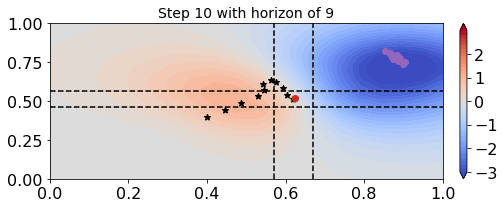

  2%|▏         | 1/50 [00:03<03:04,  3.78s/it]

x0:  [[0.6359372138977051, 0.5414949655532837]] , a:  [[[[[[[[[[[0.7645565867424011, 0.6076481342315674]], [[0.7183822393417358, 0.6460457444190979]], [[0.7517927885055542, 0.6228148341178894]], [[0.7794864773750305, 0.6570824980735779]], [[0.7320519685745239, 0.6775704622268677]]], [[[0.7399884462356567, 0.6652189493179321]], [[0.7047114372253418, 0.6299576163291931]], [[0.7371296882629395, 0.6384570598602295]], [[0.740544319152832, 0.6538019180297852]], [[0.7423167824745178, 0.6695588827133179]]], [[[0.7440798282623291, 0.6372095346450806]], [[0.7267698645591736, 0.6304043531417847]], [[0.7221571803092957, 0.6544849872589111]], [[0.7171387672424316, 0.6471832990646362]], [[0.7346265316009521, 0.6857322454452515]]], [[[0.7686270475387573, 0.642435610294342]], [[0.7360385060310364, 0.6720020771026611]], [[0.7256617546081543, 0.6432745456695557]], [[0.7280142307281494, 0.649125337600708]], [[0.7550445199012756, 0.6425392627716064]]], [[[0.7548058032989502, 0.6533237099647522]], [[0.7161

 22%|██▏       | 11/50 [00:40<02:23,  3.68s/it]

x0:  [[0.6501951217651367, 0.5437319278717041]] , a:  [[[[[[[[[[[0.9106312990188599, 0.6912373304367065]], [[0.8592753410339355, 0.7971985936164856]], [[0.9130712747573853, 0.7486246228218079]], [[0.9259231090545654, 0.7703846096992493]], [[0.8656386733055115, 0.8165915608406067]]], [[[0.9010873436927795, 0.7732486724853516]], [[0.8523373007774353, 0.7894852757453918]], [[0.9028065204620361, 0.7512198686599731]], [[0.9038707613945007, 0.7695090770721436]], [[0.8720396161079407, 0.809058666229248]]], [[[0.905228853225708, 0.7549576163291931]], [[0.8676673173904419, 0.7833085060119629]], [[0.8919333219528198, 0.7718772292137146]], [[0.8896318674087524, 0.7682704329490662]], [[0.8655489683151245, 0.820511519908905]]], [[[0.9203941822052002, 0.7607181668281555]], [[0.8693394064903259, 0.8073214888572693]], [[0.8796074390411377, 0.7491387128829956]], [[0.8951384425163269, 0.7688310146331787]], [[0.8750553131103516, 0.7937214970588684]]], [[[0.9090902805328369, 0.7473558187484741]], [[0.8577

 42%|████▏     | 21/50 [01:17<01:47,  3.70s/it]

x0:  [[0.6495522856712341, 0.5240474343299866]] , a:  [[[[[[[[[[[0.9510184526443481, 0.71913081407547]], [[0.8990910053253174, 0.8177869915962219]], [[0.9509141445159912, 0.7665141820907593]], [[0.9488261938095093, 0.7760860919952393]], [[0.8936442136764526, 0.823645293712616]]], [[[0.9337033033370972, 0.780039370059967]], [[0.8990672826766968, 0.8184880614280701]], [[0.9461017847061157, 0.769821286201477]], [[0.9403966069221497, 0.7811751365661621]], [[0.8992564678192139, 0.813284695148468]]], [[[0.943816602230072, 0.768555223941803]], [[0.9066798090934753, 0.8075296878814697]], [[0.9349035024642944, 0.7853214740753174]], [[0.9345688819885254, 0.7855081558227539]], [[0.8926199674606323, 0.8237977623939514]]], [[[0.9482614994049072, 0.7747644782066345]], [[0.9016276001930237, 0.8142530918121338]], [[0.9238147735595703, 0.7633814215660095]], [[0.935059130191803, 0.7828893065452576]], [[0.9003745913505554, 0.808103084564209]]], [[[0.943057119846344, 0.755219042301178]], [[0.8975446224212

 62%|██████▏   | 31/50 [01:54<01:09,  3.68s/it]

x0:  [[0.6419879198074341, 0.5011657476425171]] , a:  [[[[[[[[[[[0.9480438232421875, 0.7133840322494507]], [[0.8932827711105347, 0.7901660203933716]], [[0.9355126023292542, 0.745248556137085]], [[0.9208161234855652, 0.7395415306091309]], [[0.879929780960083, 0.7850959300994873]]], [[[0.9125339388847351, 0.754934549331665]], [[0.8961916565895081, 0.7987658977508545]], [[0.9368710517883301, 0.7507917881011963]], [[0.9233224987983704, 0.7509961128234863]], [[0.8877214193344116, 0.7686331272125244]]], [[[0.9315615892410278, 0.7442827224731445]], [[0.8989248275756836, 0.7855570316314697]], [[0.9179275035858154, 0.764241635799408]], [[0.9246102571487427, 0.7608209848403931]], [[0.8801534175872803, 0.7822311520576477]]], [[[0.9268224835395813, 0.7508935928344727]], [[0.8901657462120056, 0.775995135307312]], [[0.9171459674835205, 0.7421841025352478]], [[0.9209024906158447, 0.7524979114532471]], [[0.8917856812477112, 0.7688158750534058]]], [[[0.9268497228622437, 0.7340026497840881]], [[0.890913

 82%|████████▏ | 41/50 [02:33<00:34,  3.83s/it]

x0:  [[0.6385536193847656, 0.49705368280410767]] , a:  [[[[[[[[[[[0.9349709749221802, 0.7109243869781494]], [[0.878207802772522, 0.762259304523468]], [[0.9068260788917542, 0.7292850017547607]], [[0.8886035084724426, 0.7221031785011292]], [[0.8787626624107361, 0.7554056644439697]]], [[[0.8850089907646179, 0.7374581694602966]], [[0.8812633156776428, 0.7802512645721436]], [[0.9142280220985413, 0.7369902729988098]], [[0.8964967727661133, 0.7285909652709961]], [[0.8824050426483154, 0.7345706820487976]]], [[[0.906430721282959, 0.7246900200843811]], [[0.8802940249443054, 0.7650814056396484]], [[0.8912756443023682, 0.7501739859580994]], [[0.9024372100830078, 0.7422581911087036]], [[0.8750410079956055, 0.7494116425514221]]], [[[0.8948970437049866, 0.7322430610656738]], [[0.872397243976593, 0.7459994554519653]], [[0.8998880982398987, 0.7263399958610535]], [[0.8972288370132446, 0.7341302633285522]], [[0.8890224695205688, 0.746532678604126]]], [[[0.9027389287948608, 0.7283957004547119]], [[0.87608

100%|██████████| 50/50 [03:07<00:00,  3.74s/it]


Current optimal loss -0.20590623859411916;optimal action: tensor([[0.6565, 0.5141]], grad_fn=<AddBackward0>)


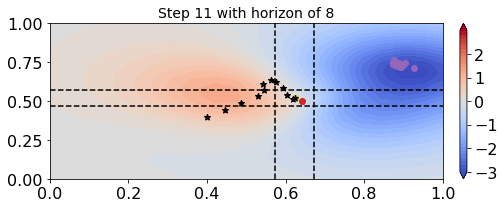

  2%|▏         | 1/50 [00:03<02:35,  3.17s/it]

x0:  [[0.6551513075828552, 0.5069287419319153]] , a:  [[[[[[[[[[0.7429577112197876, 0.6243242025375366]], [[0.7463515996932983, 0.6083884239196777]], [[0.786361813545227, 0.6095740795135498]], [[0.7656213045120239, 0.6127123236656189]], [[0.7528124451637268, 0.5980439782142639]]], [[[0.7762010097503662, 0.5996999740600586]], [[0.7488123774528503, 0.5748217105865479]], [[0.712258517742157, 0.6301061511039734]], [[0.7160282731056213, 0.60605788230896]], [[0.7615854740142822, 0.6275967955589294]]], [[[0.7800878286361694, 0.6044605374336243]], [[0.7513806819915771, 0.6199113130569458]], [[0.7082821130752563, 0.6255350708961487]], [[0.7545162439346313, 0.6017846465110779]], [[0.7263739109039307, 0.6008516550064087]]], [[[0.7668613791465759, 0.5908108353614807]], [[0.7629841566085815, 0.6084201335906982]], [[0.7295535206794739, 0.5997431874275208]], [[0.7563247084617615, 0.6012246608734131]], [[0.7115446329116821, 0.6278569102287292]]], [[[0.7871285676956177, 0.6038540601730347]], [[0.748753

 22%|██▏       | 11/50 [00:35<02:06,  3.23s/it]

x0:  [[0.6687668561935425, 0.5216786861419678]] , a:  [[[[[[[[[[0.8889872431755066, 0.7347667813301086]], [[0.8527965545654297, 0.7540499567985535]], [[0.9055414199829102, 0.7598215937614441]], [[0.9056521058082581, 0.7292149066925049]], [[0.8680412769317627, 0.7519266605377197]]], [[[0.9123245477676392, 0.7168228030204773]], [[0.8623279929161072, 0.7369893193244934]], [[0.8576563000679016, 0.7758241891860962]], [[0.8751506805419922, 0.7265999913215637]], [[0.872076690196991, 0.7692349553108215]]], [[[0.9162151217460632, 0.721041202545166]], [[0.8644512295722961, 0.762822151184082]], [[0.8569706678390503, 0.7730346322059631]], [[0.8993315696716309, 0.7209473848342896]], [[0.8528205156326294, 0.7561333179473877]]], [[[0.9074012041091919, 0.7144519090652466]], [[0.8726828098297119, 0.7564071416854858]], [[0.8704171180725098, 0.7561225295066833]], [[0.9008141160011292, 0.7229073643684387]], [[0.8408819437026978, 0.7720020413398743]]], [[[0.9169924855232239, 0.7093225121498108]], [[0.86536

 42%|████▏     | 21/50 [01:07<01:33,  3.22s/it]

x0:  [[0.667026162147522, 0.5129041075706482]] , a:  [[[[[[[[[[0.9201202988624573, 0.7592369318008423]], [[0.8834136724472046, 0.7879921197891235]], [[0.9119728207588196, 0.7942739129066467]], [[0.9333207607269287, 0.7550747394561768]], [[0.8912167549133301, 0.7884578108787537]]], [[[0.937455415725708, 0.7466303110122681]], [[0.892884373664856, 0.7810724377632141]], [[0.8847583532333374, 0.8095933794975281]], [[0.9184916615486145, 0.7567827105522156]], [[0.8907425999641418, 0.7974048852920532]]], [[[0.9413007497787476, 0.7494598031044006]], [[0.8914871215820312, 0.7932894229888916]], [[0.8848768472671509, 0.8075220584869385]], [[0.9324617385864258, 0.75184565782547]], [[0.8840105533599854, 0.794224739074707]]], [[[0.9366844296455383, 0.7477548122406006]], [[0.8981768488883972, 0.7896804213523865]], [[0.8937321901321411, 0.7965378165245056]], [[0.9332917332649231, 0.7537083029747009]], [[0.8748614192008972, 0.8026360273361206]]], [[[0.937415361404419, 0.7401624917984009]], [[0.896111071

 62%|██████▏   | 31/50 [01:40<01:03,  3.34s/it]

x0:  [[0.659712553024292, 0.4920596480369568]] , a:  [[[[[[[[[[0.904892086982727, 0.7493209838867188]], [[0.8809913396835327, 0.7750125527381897]], [[0.8914429545402527, 0.7779074311256409]], [[0.9171467423439026, 0.7415080070495605]], [[0.8908243775367737, 0.774462103843689]]], [[[0.9192560911178589, 0.739139199256897]], [[0.8916716575622559, 0.7714065313339233]], [[0.8763181567192078, 0.7963383197784424]], [[0.9133106470108032, 0.7466972470283508]], [[0.88583904504776, 0.7785079479217529]]], [[[0.9233639240264893, 0.7409370541572571]], [[0.8846956491470337, 0.7779521942138672]], [[0.8771908283233643, 0.7946382164955139]], [[0.9207392930984497, 0.7426604628562927]], [[0.8871760368347168, 0.7824894189834595]]], [[[0.921220600605011, 0.741347074508667]], [[0.8917227983474731, 0.7748308181762695]], [[0.8843644261360168, 0.7854323387145996]], [[0.9205218553543091, 0.7437061667442322]], [[0.8799089789390564, 0.7866913676261902]]], [[[0.9122940301895142, 0.7346457242965698]], [[0.8937448859

 82%|████████▏ | 41/50 [02:14<00:29,  3.24s/it]

x0:  [[0.6512983441352844, 0.47424304485321045]] , a:  [[[[[[[[[[0.8768054842948914, 0.7329686880111694]], [[0.8646976947784424, 0.7499082088470459]], [[0.8671810030937195, 0.7481951117515564]], [[0.885704755783081, 0.7197130918502808]], [[0.8748993873596191, 0.7443737983703613]]], [[[0.886488139629364, 0.724015474319458]], [[0.878010094165802, 0.7473354339599609]], [[0.8624899983406067, 0.7717719078063965]], [[0.8911940455436707, 0.7283613085746765]], [[0.8652207851409912, 0.7449174523353577]]], [[[0.8905586004257202, 0.7249515056610107]], [[0.8653880953788757, 0.7507142424583435]], [[0.8636983633041382, 0.7705016732215881]], [[0.8934125900268555, 0.7252156734466553]], [[0.8731262683868408, 0.7559757828712463]]], [[[0.8902684450149536, 0.7267181873321533]], [[0.8722069263458252, 0.7473297715187073]], [[0.869945764541626, 0.7613734006881714]], [[0.8919910788536072, 0.7254406213760376]], [[0.8675295114517212, 0.7559158802032471]]], [[[0.877720296382904, 0.7213146686553955]], [[0.8783794

100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


Current optimal loss -0.13736354258241062;optimal action: tensor([[0.6689, 0.4840]], grad_fn=<AddBackward0>)


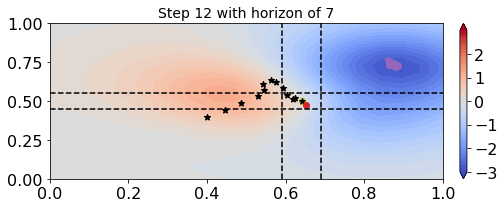

  2%|▏         | 1/50 [00:02<02:21,  2.88s/it]

x0:  [[0.6753756999969482, 0.4773649573326111]] , a:  [[[[[[[[[0.7465083003044128, 0.5843026638031006]], [[0.7778895497322083, 0.5719951391220093]], [[0.7636884450912476, 0.5862312912940979]], [[0.7494944334030151, 0.5503228306770325]], [[0.7640379071235657, 0.5542609691619873]]], [[[0.7244728803634644, 0.5649253129959106]], [[0.7727289795875549, 0.5922777056694031]], [[0.734276294708252, 0.5516555905342102]], [[0.7376249432563782, 0.5364711880683899]], [[0.7604179382324219, 0.5508427023887634]]], [[[0.7604267001152039, 0.546640157699585]], [[0.7431204319000244, 0.5823473930358887]], [[0.729469358921051, 0.5603501200675964]], [[0.7668606638908386, 0.5471932888031006]], [[0.7535353302955627, 0.5628408193588257]]], [[[0.7568399310112, 0.5630531907081604]], [[0.774445116519928, 0.5729320645332336]], [[0.7529889345169067, 0.5450286269187927]], [[0.7614830732345581, 0.5770926475524902]], [[0.7543214559555054, 0.5637742280960083]]], [[[0.7510502338409424, 0.5512288212776184]], [[0.7542151808

 22%|██▏       | 11/50 [00:31<01:53,  2.92s/it]

x0:  [[0.6858050227165222, 0.49574965238571167]] , a:  [[[[[[[[[0.8440362215042114, 0.7080861926078796]], [[0.899324893951416, 0.7125065922737122]], [[0.8595130443572998, 0.7195566892623901]], [[0.8461716175079346, 0.694988489151001]], [[0.869717538356781, 0.7010181546211243]]], [[[0.832858681678772, 0.6974422931671143]], [[0.8946848511695862, 0.7248077988624573]], [[0.8422781229019165, 0.7004479169845581]], [[0.8373094201087952, 0.6869035959243774]], [[0.8673701882362366, 0.6993929147720337]]], [[[0.8547400236129761, 0.6861803531646729]], [[0.8762648105621338, 0.7204645872116089]], [[0.8411186933517456, 0.7034215927124023]], [[0.857391357421875, 0.6934667229652405]], [[0.8638579249382019, 0.7057554721832275]]], [[[0.8520767688751221, 0.695900022983551]], [[0.8971260786056519, 0.7139955759048462]], [[0.8552637696266174, 0.6953588128089905]], [[0.8528050184249878, 0.7118715047836304]], [[0.8644935488700867, 0.7077997326850891]]], [[[0.8492045402526855, 0.6887815594673157]], [[0.88578283

 42%|████▏     | 21/50 [00:59<01:19,  2.73s/it]

x0:  [[0.6818963885307312, 0.49566495418548584]] , a:  [[[[[[[[[0.8731995820999146, 0.7382487058639526]], [[0.9180185794830322, 0.76028972864151]], [[0.8732590079307556, 0.7605991959571838]], [[0.8737269043922424, 0.7422454357147217]], [[0.8817906379699707, 0.7523226737976074]]], [[[0.868647575378418, 0.7338151931762695]], [[0.9142078757286072, 0.7666347026824951]], [[0.8648486733436584, 0.7524502277374268]], [[0.8675695657730103, 0.7390244007110596]], [[0.878832995891571, 0.7514932155609131]]], [[[0.8810607194900513, 0.7275987863540649]], [[0.9055272340774536, 0.7661992311477661]], [[0.8665794134140015, 0.7516231536865234]], [[0.8792915344238281, 0.7418337464332581]], [[0.8775895237922668, 0.7545261979103088]]], [[[0.8791030645370483, 0.733229398727417]], [[0.9185521006584167, 0.7622597217559814]], [[0.8736915588378906, 0.7495619654655457]], [[0.875434935092926, 0.7511052489280701]], [[0.8786284327507019, 0.755608081817627]]], [[[0.8784602284431458, 0.7294962406158447]], [[0.912343800

 62%|██████▏   | 31/50 [01:26<00:51,  2.74s/it]

x0:  [[0.6714819073677063, 0.48405736684799194]] , a:  [[[[[[[[[0.8733103275299072, 0.7419551014900208]], [[0.8902636766433716, 0.7640349864959717]], [[0.866066575050354, 0.7606783509254456]], [[0.8720136880874634, 0.7398200035095215]], [[0.8710619807243347, 0.7563658952713013]]], [[[0.8716818690299988, 0.7405760288238525]], [[0.8868927955627441, 0.7677009701728821]], [[0.8620778322219849, 0.7567546367645264]], [[0.8679274320602417, 0.7382994890213013]], [[0.8677496314048767, 0.755917489528656]]], [[[0.8800515532493591, 0.7359263300895691]], [[0.8833136558532715, 0.7691919803619385]], [[0.865248441696167, 0.7546406984329224]], [[0.874343752861023, 0.7399788498878479]], [[0.866701066493988, 0.7578127384185791]]], [[[0.8782569169998169, 0.7401877641677856]], [[0.8930056095123291, 0.7660852670669556]], [[0.8689796924591064, 0.7548529505729675]], [[0.8714143633842468, 0.7447739839553833]], [[0.8676700592041016, 0.7583160400390625]]], [[[0.8786522746086121, 0.7379245162010193]], [[0.8887709

 82%|████████▏ | 41/50 [01:56<00:24,  2.77s/it]

x0:  [[0.6612321138381958, 0.46603402495384216]] , a:  [[[[[[[[[0.8670102953910828, 0.7341988682746887]], [[0.8561140298843384, 0.7486339211463928]], [[0.8554672002792358, 0.7426586747169495]], [[0.8691791892051697, 0.7276139855384827]], [[0.8589481711387634, 0.7408856749534607]]], [[[0.8672008514404297, 0.7350984215736389]], [[0.854300856590271, 0.7507190704345703]], [[0.8541780710220337, 0.7407570481300354]], [[0.8672027587890625, 0.7266244292259216]], [[0.855650007724762, 0.7404578924179077]]], [[[0.8733971118927002, 0.7304604053497314]], [[0.8536962270736694, 0.7539063692092896]], [[0.8583853244781494, 0.7380871176719666]], [[0.869147777557373, 0.7282707095146179]], [[0.8540029525756836, 0.7420505285263062]]], [[[0.8715314269065857, 0.7344477772712708]], [[0.8609798550605774, 0.7507923245429993]], [[0.8600038886070251, 0.7391270399093628]], [[0.867529571056366, 0.7302039265632629]], [[0.8549746870994568, 0.7422982454299927]]], [[[0.8724812269210815, 0.7329968214035034]], [[0.857786

100%|██████████| 50/50 [02:21<00:00,  2.83s/it]


Current optimal loss -0.15073872743151057;optimal action: tensor([[0.6809, 0.4724]], grad_fn=<AddBackward0>)


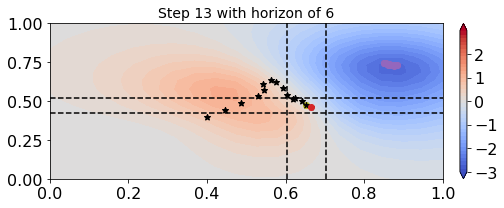

  2%|▏         | 1/50 [00:02<01:53,  2.31s/it]

x0:  [[0.6833820939064026, 0.47184449434280396]] , a:  [[[[[[[[0.7518468499183655, 0.5284304022789001]], [[0.749277651309967, 0.5321395397186279]], [[0.7692387700080872, 0.534762978553772]], [[0.7556518316268921, 0.555853009223938]], [[0.7398611307144165, 0.5426647663116455]]], [[[0.7464520931243896, 0.5519627332687378]], [[0.7370519638061523, 0.5667346119880676]], [[0.7667120099067688, 0.5610328316688538]], [[0.7374191880226135, 0.5297563672065735]], [[0.7593897581100464, 0.558490514755249]]], [[[0.761791467666626, 0.5206591486930847]], [[0.7118005156517029, 0.5393357276916504]], [[0.7271489500999451, 0.5478900671005249]], [[0.7560368180274963, 0.5537991523742676]], [[0.7611348032951355, 0.5575355291366577]]], [[[0.7378847599029541, 0.5644243955612183]], [[0.7486687898635864, 0.5555084943771362]], [[0.7575979232788086, 0.5645153522491455]], [[0.7331428527832031, 0.5193126201629639]], [[0.7595070004463196, 0.5666124224662781]]], [[[0.7534570097923279, 0.5504227876663208]], [[0.73126381

 22%|██▏       | 11/50 [00:25<01:28,  2.26s/it]

x0:  [[0.6946886777877808, 0.48976895213127136]] , a:  [[[[[[[[0.843156099319458, 0.6635551452636719]], [[0.8306369781494141, 0.6633340120315552]], [[0.8623932600021362, 0.6655468940734863]], [[0.8702768087387085, 0.6413528919219971]], [[0.8557707667350769, 0.6721066236495972]]], [[[0.840134859085083, 0.6776072382926941]], [[0.8209218978881836, 0.6842487454414368]], [[0.8595962524414062, 0.6828281879425049]], [[0.8600517511367798, 0.625187337398529]], [[0.86797034740448, 0.6819434762001038]]], [[[0.8509596586227417, 0.6589747071266174]], [[0.8055340647697449, 0.6687701344490051]], [[0.8350529074668884, 0.6752870082855225]], [[0.8701775670051575, 0.6402772068977356]], [[0.8694517016410828, 0.6797817349433899]]], [[[0.8348619937896729, 0.6848507523536682]], [[0.8284595608711243, 0.6779018640518188]], [[0.8545089960098267, 0.684459388256073]], [[0.85674649477005, 0.6192561388015747]], [[0.8690697550773621, 0.6865587830543518]]], [[[0.8419456481933594, 0.6682282090187073]], [[0.81869649887

 42%|████▏     | 21/50 [00:48<01:06,  2.31s/it]

x0:  [[0.6886155605316162, 0.4955636262893677]] , a:  [[[[[[[[0.8528656363487244, 0.7209580540657043]], [[0.8521866798400879, 0.7184246778488159]], [[0.8655965924263, 0.7228384613990784]], [[0.8957192897796631, 0.6812456250190735]], [[0.8722161650657654, 0.7260519862174988]]], [[[0.8522257804870605, 0.726833701133728]], [[0.8445593118667603, 0.7288201451301575]], [[0.8629847764968872, 0.7310172319412231]], [[0.8925779461860657, 0.6737710237503052]], [[0.8783018589019775, 0.7321228384971619]]], [[[0.8588981628417969, 0.7200047969818115]], [[0.8383693695068359, 0.7213703989982605]], [[0.8509705066680908, 0.7279072403907776]], [[0.8961173892021179, 0.6810292601585388]], [[0.8789816498756409, 0.729335606098175]]], [[[0.8481444120407104, 0.7308619022369385]], [[0.8496487140655518, 0.7250872850418091]], [[0.8604635000228882, 0.7312780618667603]], [[0.8907615542411804, 0.6704087853431702]], [[0.8808901309967041, 0.7341790199279785]]], [[[0.8515937924385071, 0.7205732464790344]], [[0.845242142

 62%|██████▏   | 31/50 [01:10<00:42,  2.25s/it]

x0:  [[0.6741271615028381, 0.4963821768760681]] , a:  [[[[[[[[0.842117965221405, 0.7398889660835266]], [[0.8493070006370544, 0.7366076111793518]], [[0.848361611366272, 0.7421509027481079]], [[0.8795468211174011, 0.6970917582511902]], [[0.8488336801528931, 0.7439111471176147]]], [[[0.8425389528274536, 0.7426269054412842]], [[0.8430072665214539, 0.7427034974098206]], [[0.8462510704994202, 0.7462028861045837]], [[0.8796868324279785, 0.692983865737915]], [[0.8516697287559509, 0.7481721639633179]]], [[[0.8470615148544312, 0.7400450706481934]], [[0.840397834777832, 0.7383734583854675]], [[0.839876115322113, 0.7449363470077515]], [[0.8797464370727539, 0.6972291469573975]], [[0.8518334031105042, 0.7458591461181641]]], [[[0.8387482762336731, 0.7454718947410583]], [[0.8469506502151489, 0.7399820685386658]], [[0.8448725938796997, 0.7463133931159973]], [[0.8789517283439636, 0.6906546354293823]], [[0.8547046184539795, 0.7493835091590881]]], [[[0.8416037559509277, 0.7385333180427551]], [[0.844582557

 82%|████████▏ | 41/50 [01:33<00:20,  2.26s/it]

x0:  [[0.6599461436271667, 0.49530407786369324]] , a:  [[[[[[[[0.8316985368728638, 0.7455300688743591]], [[0.8486931920051575, 0.7416051626205444]], [[0.834742546081543, 0.7479138374328613]], [[0.8576179146766663, 0.7104038596153259]], [[0.8312819004058838, 0.7488977313041687]]], [[[0.8327239155769348, 0.7470954656600952]], [[0.8431925177574158, 0.7458768486976624]], [[0.8334153890609741, 0.7500198483467102]], [[0.8594602942466736, 0.7075044512748718]], [[0.8321483135223389, 0.7521221041679382]]], [[[0.8358730673789978, 0.7458626627922058]], [[0.8420125842094421, 0.7429580092430115]], [[0.8297258615493774, 0.749750554561615]], [[0.8570762872695923, 0.7107251286506653]], [[0.8317536115646362, 0.7505251169204712]]], [[[0.8287919163703918, 0.7496066093444824]], [[0.8465728759765625, 0.7435399293899536]], [[0.8326261043548584, 0.7504557371139526]], [[0.8597042560577393, 0.7056825160980225]], [[0.8352064490318298, 0.753144383430481]]], [[[0.8318008184432983, 0.7442951202392578]], [[0.844974

100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


Current optimal loss -0.23418355982850286;optimal action: tensor([[0.6633, 0.5050]], grad_fn=<AddBackward0>)


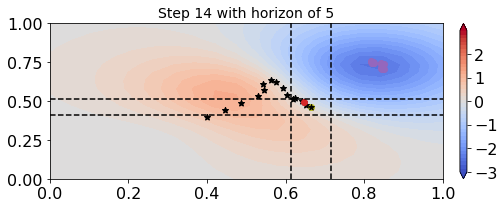

  2%|▏         | 1/50 [00:01<01:28,  1.82s/it]

x0:  [[0.6583430767059326, 0.5129991769790649]] , a:  [[[[[[[0.7252835631370544, 0.594560444355011]], [[0.7257566452026367, 0.5520269870758057]], [[0.7448756694793701, 0.5592483282089233]], [[0.7302723526954651, 0.5420529246330261]], [[0.7098386287689209, 0.567298412322998]]], [[[0.7409084439277649, 0.5640604496002197]], [[0.7382177114486694, 0.5362651944160461]], [[0.7063184380531311, 0.5644353032112122]], [[0.7215115427970886, 0.5770514607429504]], [[0.7023745179176331, 0.5534098148345947]]], [[[0.7375169396400452, 0.6019350290298462]], [[0.7045687437057495, 0.5852392315864563]], [[0.7057474255561829, 0.5770171880722046]], [[0.7094765901565552, 0.550599217414856]], [[0.6877235174179077, 0.5549193024635315]]], [[[0.7354863286018372, 0.5638542175292969]], [[0.7292587757110596, 0.573428750038147]], [[0.7138800024986267, 0.5787999629974365]], [[0.7285574078559875, 0.5535587072372437]], [[0.6857901811599731, 0.5698079466819763]]], [[[0.7235922813415527, 0.6017786860466003]], [[0.701950311

 22%|██▏       | 11/50 [00:20<01:10,  1.82s/it]

x0:  [[0.6729838848114014, 0.527090847492218]] , a:  [[[[[[[0.8247412443161011, 0.6927991509437561]], [[0.8263209462165833, 0.6659888625144958]], [[0.8393605947494507, 0.6713720560073853]], [[0.8301112055778503, 0.6596054434776306]], [[0.7911423444747925, 0.6750784516334534]]], [[[0.8353999853134155, 0.6738501787185669]], [[0.8345911502838135, 0.6566283702850342]], [[0.8145481944084167, 0.6753043532371521]], [[0.8228615522384644, 0.6815613508224487]], [[0.7846621870994568, 0.6670628190040588]]], [[[0.8329328894615173, 0.6969570517539978]], [[0.8113364577293396, 0.6874954700469971]], [[0.8136857748031616, 0.6823795437812805]], [[0.8175247311592102, 0.6655380725860596]], [[0.7773318886756897, 0.6681548357009888]]], [[[0.8315590620040894, 0.6736449003219604]], [[0.8283103108406067, 0.6798791289329529]], [[0.8194324970245361, 0.6833969354629517]], [[0.8298115730285645, 0.6670354604721069]], [[0.7746224403381348, 0.6773696541786194]]], [[[0.8236107230186462, 0.6980527639389038]], [[0.810492

 42%|████▏     | 21/50 [00:38<00:52,  1.82s/it]

x0:  [[0.6685868501663208, 0.5296594500541687]] , a:  [[[[[[[0.8484910726547241, 0.7316962480545044]], [[0.8491226434707642, 0.7166910767555237]], [[0.861618161201477, 0.7220394611358643]], [[0.8591070175170898, 0.7113974094390869]], [[0.8064828515052795, 0.7191527485847473]]], [[[0.8556401133537292, 0.7227294445037842]], [[0.8547307252883911, 0.7136852741241455]], [[0.8467916250228882, 0.7224087119102478]], [[0.8539214134216309, 0.7224161028862]], [[0.802553653717041, 0.7158902883529663]]], [[[0.8532112240791321, 0.732743501663208]], [[0.8394573330879211, 0.7277723550796509]], [[0.8465112447738647, 0.7258391380310059]], [[0.8527743816375732, 0.7155108451843262]], [[0.7993701696395874, 0.716141402721405]]], [[[0.8533549308776855, 0.7219005227088928]], [[0.8499104976654053, 0.7238985300064087]], [[0.8496305346488953, 0.7254267334938049]], [[0.8594304323196411, 0.7157862782478333]], [[0.7973445057868958, 0.7213460803031921]]], [[[0.8480710387229919, 0.7339901924133301]], [[0.839554727077

 62%|██████▏   | 31/50 [00:56<00:33,  1.78s/it]

x0:  [[0.6533704996109009, 0.5269447565078735]] , a:  [[[[[[[0.8294462561607361, 0.7424264550209045]], [[0.8307496309280396, 0.7325096130371094]], [[0.8485717177391052, 0.7372674942016602]], [[0.8540284633636475, 0.7262936234474182]], [[0.804495096206665, 0.7318145632743835]]], [[[0.8345540761947632, 0.7374480962753296]], [[0.8349065780639648, 0.7319869995117188]], [[0.8381754755973816, 0.736331582069397]], [[0.8502758145332336, 0.7326459288597107]], [[0.8021723031997681, 0.7302440404891968]]], [[[0.8324136137962341, 0.7424213290214539]], [[0.8239524364471436, 0.739159345626831]], [[0.8385421633720398, 0.7382522225379944]], [[0.8504756689071655, 0.7291166186332703]], [[0.8002961277961731, 0.7300920486450195]]], [[[0.8331401348114014, 0.7367127537727356]], [[0.831066370010376, 0.7369441390037537]], [[0.8402224183082581, 0.7375142574310303]], [[0.8545098304748535, 0.7292783260345459]], [[0.7990052103996277, 0.7333551049232483]]], [[[0.8292482495307922, 0.7433393597602844]], [[0.824371933

 82%|████████▏ | 41/50 [01:14<00:16,  1.83s/it]

x0:  [[0.6357746720314026, 0.5203003287315369]] , a:  [[[[[[[0.7960801720619202, 0.7406524419784546]], [[0.8003641366958618, 0.7327413558959961]], [[0.8193511366844177, 0.737197756767273]], [[0.8371688723564148, 0.7248255014419556]], [[0.8041961193084717, 0.7313486933708191]]], [[[0.7997092008590698, 0.7369474172592163]], [[0.8035114407539368, 0.7331056594848633]], [[0.8112375736236572, 0.7361782789230347]], [[0.8342728614807129, 0.7292911410331726]], [[0.8027410507202148, 0.7303413152694702]]], [[[0.7981014251708984, 0.7403730154037476]], [[0.7954484224319458, 0.7378228902816772]], [[0.8120714426040649, 0.7373141050338745]], [[0.8349437713623047, 0.7268304228782654]], [[0.8012931942939758, 0.7300132513046265]]], [[[0.7987105250358582, 0.7365109324455261]], [[0.8004965782165527, 0.7362141013145447]], [[0.8129608631134033, 0.7367135882377625]], [[0.8376849889755249, 0.7271152138710022]], [[0.8005269765853882, 0.7323204874992371]]], [[[0.7960098385810852, 0.7410353422164917]], [[0.795955

100%|██████████| 50/50 [01:31<00:00,  1.82s/it]


Current optimal loss -0.12597472037593174;optimal action: tensor([[0.6433, 0.5266]], grad_fn=<AddBackward0>)


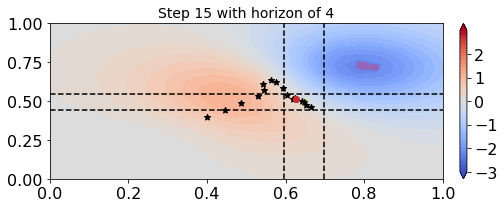

  2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

x0:  [[0.630872905254364, 0.5310916304588318]] , a:  [[[[[[0.6753284931182861, 0.5902219414710999]], [[0.6934148073196411, 0.5603302717208862]], [[0.683800220489502, 0.5866763591766357]], [[0.6646369695663452, 0.5705609917640686]], [[0.6903313994407654, 0.5685778856277466]]], [[[0.6490358114242554, 0.5695303082466125]], [[0.6974213719367981, 0.5585853457450867]], [[0.6808512806892395, 0.568223774433136]], [[0.6526355147361755, 0.571954071521759]], [[0.6818705201148987, 0.5752034187316895]]], [[[0.6692390441894531, 0.5764007568359375]], [[0.6589785814285278, 0.5726626515388489]], [[0.6558952927589417, 0.5638636350631714]], [[0.6713953018188477, 0.5732948184013367]], [[0.6670348644256592, 0.5965322852134705]]], [[[0.6832590103149414, 0.5761556029319763]], [[0.6943709850311279, 0.5631058812141418]], [[0.6647496223449707, 0.5723590850830078]], [[0.6725048422813416, 0.5829021334648132]], [[0.6858812570571899, 0.5859376192092896]]], [[[0.6725643873214722, 0.570688784122467]], [[0.69327437877

 22%|██▏       | 11/50 [00:14<00:51,  1.32s/it]

x0:  [[0.6504024267196655, 0.5469496846199036]] , a:  [[[[[[0.7685804963111877, 0.6760653257369995]], [[0.7808203101158142, 0.6563372611999512]], [[0.7744494676589966, 0.6740924119949341]], [[0.7618820667266846, 0.6649793386459351]], [[0.7787806391716003, 0.6621689796447754]]], [[[0.748616635799408, 0.6630699634552002]], [[0.783176600933075, 0.655354917049408]], [[0.7728621363639832, 0.6629223227500916]], [[0.7537049651145935, 0.6654291152954102]], [[0.7728187441825867, 0.6675223708152771]]], [[[0.765181303024292, 0.6677849292755127]], [[0.7576456665992737, 0.6653204560279846]], [[0.7551562786102295, 0.6594927310943604]], [[0.7658184170722961, 0.6663103103637695]], [[0.7631369829177856, 0.6807228922843933]]], [[[0.7740382552146912, 0.6673067808151245]], [[0.7816482186317444, 0.6589376330375671]], [[0.7618111371994019, 0.6659336686134338]], [[0.7661448121070862, 0.6723603010177612]], [[0.7761136293411255, 0.6735028028488159]]], [[[0.7674680948257446, 0.6642586588859558]], [[0.7804472446

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

x0:  [[0.6552468538284302, 0.5510085821151733]] , a:  [[[[[[0.804948627948761, 0.7095366716384888]], [[0.8128740787506104, 0.6991627812385559]], [[0.8072907328605652, 0.709648609161377]], [[0.7998360991477966, 0.7059381604194641]], [[0.811551570892334, 0.7041257619857788]]], [[[0.7922215461730957, 0.703373908996582]], [[0.8145958185195923, 0.6979141235351562]], [[0.8067550659179688, 0.7045113444328308]], [[0.7950263023376465, 0.7063277363777161]], [[0.8082491755485535, 0.706611156463623]]], [[[0.8034099340438843, 0.7051305174827576]], [[0.7989949584007263, 0.7041375041007996]], [[0.7956469058990479, 0.7038865089416504]], [[0.8019101619720459, 0.7063097357749939]], [[0.8018147945404053, 0.7131665945053101]]], [[[0.8086066246032715, 0.7048715353012085]], [[0.8133669495582581, 0.7003015875816345]], [[0.8002421855926514, 0.7059081792831421]], [[0.8020031452178955, 0.7095533609390259]], [[0.8097851276397705, 0.7086827754974365]]], [[[0.8049378395080566, 0.7035067081451416]], [[0.81226605176

 62%|██████▏   | 31/50 [00:42<00:27,  1.46s/it]

x0:  [[0.651917040348053, 0.5496383905410767]] , a:  [[[[[[0.8135247230529785, 0.7176803946495056]], [[0.8190631866455078, 0.7118176817893982]], [[0.8126426339149475, 0.7201319336891174]], [[0.8069728016853333, 0.7186455726623535]], [[0.8179181814193726, 0.7170761227607727]]], [[[0.8047543168067932, 0.7143926024436951]], [[0.8206673860549927, 0.7106711268424988]], [[0.8125507831573486, 0.7175684571266174]], [[0.8037534952163696, 0.7191453576087952]], [[0.8159071803092957, 0.7180157899856567]]], [[[0.8125618696212769, 0.714850664138794]], [[0.8098261952400208, 0.7145668864250183]], [[0.8047190308570862, 0.7179562449455261]], [[0.8082460761070251, 0.7188838720321655]], [[0.8112913370132446, 0.7217936515808105]]], [[[0.8160577416419983, 0.7148743271827698]], [[0.8195018768310547, 0.7121349573135376]], [[0.8082783222198486, 0.7182312607765198]], [[0.8083130121231079, 0.7206994891166687]], [[0.8167558312416077, 0.7187862992286682]]], [[[0.8136539459228516, 0.714150071144104]], [[0.818654119

 82%|████████▏ | 41/50 [00:56<00:12,  1.37s/it]

x0:  [[0.6428807973861694, 0.5444289445877075]] , a:  [[[[[[0.8094070553779602, 0.7142311930656433]], [[0.8134073615074158, 0.7105754017829895]], [[0.8048895001411438, 0.7197834253311157]], [[0.7993444204330444, 0.7192660570144653]], [[0.8120848536491394, 0.7170685529708862]]], [[[0.8027005791664124, 0.71213299036026]], [[0.8150392770767212, 0.7096647024154663]], [[0.8049936294555664, 0.718263566493988]], [[0.7968987226486206, 0.7198137044906616]], [[0.8106729984283447, 0.7173815965652466]]], [[[0.8085678815841675, 0.7120688557624817]], [[0.8066068291664124, 0.7122588157653809]], [[0.7988095879554749, 0.718913733959198]], [[0.8002464771270752, 0.7195478677749634]], [[0.8071936964988708, 0.7200419902801514]]], [[[0.8111966252326965, 0.7122771739959717]], [[0.8139027953147888, 0.7105624675750732]], [[0.801872193813324, 0.7186796069145203]], [[0.800315797328949, 0.7206829190254211]], [[0.8113552927970886, 0.7178145051002502]]], [[[0.809377908706665, 0.7117964625358582]], [[0.8133014440536

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


Current optimal loss -0.3068710177990965;optimal action: tensor([[0.6465, 0.5495]], grad_fn=<AddBackward0>)


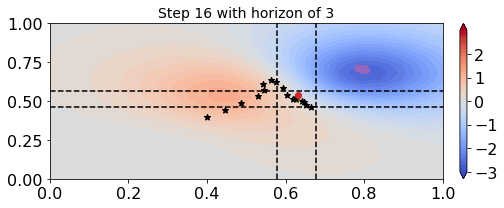

  2%|▏         | 1/50 [00:00<00:42,  1.16it/s]

x0:  [[0.65043705701828, 0.5401100516319275]] , a:  [[[[[0.6802436709403992, 0.5648943781852722]], [[0.6683654189109802, 0.5660371780395508]], [[0.6926908493041992, 0.5711885690689087]], [[0.6876472234725952, 0.565933346748352]], [[0.6727944612503052, 0.5727094411849976]]], [[[0.691878080368042, 0.561802327632904]], [[0.6900378465652466, 0.584028959274292]], [[0.7006122469902039, 0.5976811051368713]], [[0.657405436038971, 0.5631781220436096]], [[0.6710303425788879, 0.5744739770889282]]], [[[0.7060631513595581, 0.5717088580131531]], [[0.6692085862159729, 0.5741206407546997]], [[0.6837854981422424, 0.5890394449234009]], [[0.654782235622406, 0.571032702922821]], [[0.6626195907592773, 0.5659248232841492]]], [[[0.7027105689048767, 0.5735403299331665]], [[0.6929634809494019, 0.574008584022522]], [[0.7042231559753418, 0.5907618403434753]], [[0.6656526327133179, 0.5698890089988708]], [[0.6785764694213867, 0.5787627100944519]]], [[[0.6888457536697388, 0.5746030807495117]], [[0.6797441244125366,

 22%|██▏       | 11/50 [00:09<00:34,  1.15it/s]

x0:  [[0.6654940843582153, 0.5600451827049255]] , a:  [[[[[0.7523193359375, 0.644504964351654]], [[0.7444658279418945, 0.645699143409729]], [[0.7597957253456116, 0.6482298374176025]], [[0.7559635639190674, 0.6454393267631531]], [[0.7463242411613464, 0.6499898433685303]]], [[[0.7593774199485779, 0.642882227897644]], [[0.7582321763038635, 0.6564062237739563]], [[0.7650107145309448, 0.6649543642997742]], [[0.7362317442893982, 0.6439992189407349]], [[0.7454360723495483, 0.6511573791503906]]], [[[0.7685874104499817, 0.64876389503479]], [[0.7447320818901062, 0.6507421731948853]], [[0.7545350790023804, 0.659408450126648]], [[0.7341364026069641, 0.6490375995635986]], [[0.7397653460502625, 0.6459760069847107]]], [[[0.7664970755577087, 0.6493605375289917]], [[0.7599819302558899, 0.6503580212593079]], [[0.7671458721160889, 0.6608110070228577]], [[0.7417770624160767, 0.6472052931785583]], [[0.750041127204895, 0.6536703109741211]]], [[[0.7578262686729431, 0.6508039832115173]], [[0.7511132955551147,

 42%|████▏     | 21/50 [00:18<00:25,  1.16it/s]

x0:  [[0.6701419353485107, 0.5654592514038086]] , a:  [[[[[0.7822092771530151, 0.6773627400398254]], [[0.7766040563583374, 0.6784321069717407]], [[0.7856082916259766, 0.6801527142524719]], [[0.7821774482727051, 0.6786338090896606]], [[0.7759677171707153, 0.6815685033798218]]], [[[0.7860338687896729, 0.6771588325500488]], [[0.7843452095985413, 0.6838394999504089]], [[0.7884234189987183, 0.6888384819030762]], [[0.7708979249000549, 0.6786064505577087]], [[0.7753883004188538, 0.6821157932281494]]], [[[0.7913105487823486, 0.6797168254852295]], [[0.7765811681747437, 0.6810305118560791]], [[0.7827496528625488, 0.6857709288597107]], [[0.7694810628890991, 0.6813423037528992]], [[0.7722477912902832, 0.679645836353302]]], [[[0.7900713086128235, 0.6796265244483948]], [[0.7854915261268616, 0.6806277632713318]], [[0.7897128462791443, 0.6866145133972168]], [[0.7743447422981262, 0.6796506643295288]], [[0.7780313491821289, 0.6834444999694824]]], [[[0.7853724956512451, 0.6805746555328369]], [[0.78016006

 62%|██████▏   | 31/50 [00:27<00:17,  1.08it/s]

x0:  [[0.6707136631011963, 0.561676561832428]] , a:  [[[[[0.7920593619346619, 0.6836903691291809]], [[0.7868059873580933, 0.6849430203437805]], [[0.7932287454605103, 0.6865042448043823]], [[0.7892367839813232, 0.6855913400650024]], [[0.7842642664909363, 0.6878938674926758]]], [[[0.7944440841674805, 0.6840417981147766]], [[0.7918962240219116, 0.6881252527236938]], [[0.7950729727745056, 0.6916390061378479]], [[0.7817876935005188, 0.6859737038612366]], [[0.7837175726890564, 0.6880375742912292]]], [[[0.7980290055274963, 0.6852896213531494]], [[0.7867147326469421, 0.6864654421806335]], [[0.7915677428245544, 0.6897338628768921]], [[0.7807874083518982, 0.687641978263855]], [[0.7817303538322449, 0.6867296695709229]]], [[[0.7973008751869202, 0.6850407719612122]], [[0.7927743196487427, 0.6861578226089478]], [[0.7959898114204407, 0.6902584433555603]], [[0.7843837141990662, 0.6864557862281799]], [[0.7855955958366394, 0.6889844536781311]]], [[[0.7941924929618835, 0.6855581998825073]], [[0.789028525

 82%|████████▏ | 41/50 [00:36<00:08,  1.10it/s]

x0:  [[0.6695220470428467, 0.5504431128501892]] , a:  [[[[[0.7941979765892029, 0.6765203475952148]], [[0.788232147693634, 0.6781772375106812]], [[0.793602466583252, 0.6795977354049683]], [[0.7883328795433044, 0.6791568994522095]], [[0.783229649066925, 0.6811763644218445]]], [[[0.7959036827087402, 0.6770861744880676]], [[0.792100727558136, 0.6803897619247437]], [[0.7950736284255981, 0.6831612586975098]], [[0.782691478729248, 0.6795858144760132]], [[0.7826736569404602, 0.6810868978500366]]], [[[0.7987517714500427, 0.6778507232666016]], [[0.7881348729133606, 0.679217517375946]], [[0.7925926446914673, 0.6818089485168457]], [[0.7819317579269409, 0.6807541251182556]], [[0.7812138199806213, 0.6802756786346436]]], [[[0.7983351945877075, 0.6775996088981628]], [[0.7928364276885986, 0.6789972186088562]], [[0.7958049774169922, 0.6821857690811157]], [[0.7849189043045044, 0.6799867153167725]], [[0.784228503704071, 0.6819222569465637]]], [[[0.7958636283874512, 0.6778193116188049]], [[0.78982704877853

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Current optimal loss -0.5937515206416842;optimal action: tensor([[0.6838, 0.5495]], grad_fn=<AddBackward0>)


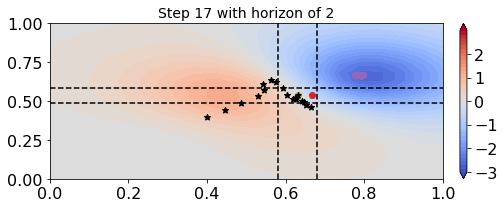

  2%|▏         | 1/50 [00:00<00:22,  2.22it/s]

x0:  [[0.67859947681427, 0.536453366279602]] , a:  [[[[0.7076772451400757, 0.5489716529846191]], [[0.6892948746681213, 0.541963517665863]], [[0.7126376032829285, 0.5527452826499939]], [[0.7089511156082153, 0.5607973337173462]], [[0.7032548785209656, 0.5505364537239075]]], [[[0.7040349841117859, 0.5625510811805725]], [[0.702556312084198, 0.5443140864372253]], [[0.7209465503692627, 0.552489697933197]], [[0.7048991322517395, 0.5526807308197021]], [[0.7003283500671387, 0.5613558888435364]]], [[[0.7185474634170532, 0.5527923703193665]], [[0.6889448761940002, 0.5411376953125]], [[0.7076601386070251, 0.542677640914917]], [[0.6933064460754395, 0.565349817276001]], [[0.6915998458862305, 0.5491980910301208]]], [[[0.7193291783332825, 0.5426427125930786]], [[0.6823996305465698, 0.5521621108055115]], [[0.7235527634620667, 0.5525321364402771]], [[0.693007230758667, 0.5657613277435303]], [[0.6885915398597717, 0.5575020909309387]]], [[[0.7103126645088196, 0.5448293089866638]], [[0.702515184879303, 0.5

 22%|██▏       | 11/50 [00:05<00:18,  2.13it/s]

x0:  [[0.6969406008720398, 0.5581638813018799]] , a:  [[[[0.7597029805183411, 0.6110299825668335]], [[0.7482926249504089, 0.6063248515129089]], [[0.7629178762435913, 0.6133251786231995]], [[0.7609946727752686, 0.6188045740127563]], [[0.7573456764221191, 0.6121970415115356]]], [[[0.7570589184761047, 0.6193983554840088]], [[0.7565476298332214, 0.6079835891723633]], [[0.767991304397583, 0.6131344437599182]], [[0.7585488557815552, 0.6131376624107361]], [[0.7555261850357056, 0.6192970871925354]]], [[[0.7666198015213013, 0.6134897470474243]], [[0.7480583190917969, 0.6056997179985046]], [[0.7596626877784729, 0.6065802574157715]], [[0.7505607008934021, 0.6218046545982361]], [[0.7498638033866882, 0.6113132834434509]]], [[[0.7671394944190979, 0.606497585773468]], [[0.7432811856269836, 0.6134873628616333]], [[0.7694801688194275, 0.6131532788276672]], [[0.7503356337547302, 0.6220605373382568]], [[0.747677206993103, 0.6169680953025818]]], [[[0.761505126953125, 0.6081347465515137]], [[0.756523787975

 42%|████▏     | 21/50 [00:09<00:12,  2.23it/s]

x0:  [[0.7036850452423096, 0.5679959654808044]] , a:  [[[[0.7781158685684204, 0.6377841234207153]], [[0.7721164226531982, 0.6355389356613159]], [[0.7799257636070251, 0.6391351222991943]], [[0.7793450355529785, 0.6420268416404724]], [[0.777480959892273, 0.638515055179596]]], [[[0.776365339756012, 0.6429188847541809]], [[0.7771759033203125, 0.6363850831985474]], [[0.7830569744110107, 0.6389649510383606]], [[0.777899444103241, 0.6386439204216003]], [[0.7762660980224609, 0.6428529024124146]]], [[[0.7823020219802856, 0.6391873359680176]], [[0.7719824910163879, 0.6351699233055115]], [[0.7780756950378418, 0.635109543800354]], [[0.7728722095489502, 0.6440402269363403]], [[0.7728814482688904, 0.6381179094314575]]], [[[0.7827484607696533, 0.6349559426307678]], [[0.7689650654792786, 0.6399121880531311]], [[0.7839922904968262, 0.6389621496200562]], [[0.7727311253547668, 0.6442010998725891]], [[0.7714661359786987, 0.641560435295105]]], [[[0.7792616486549377, 0.6360152363777161]], [[0.77716040611267

 62%|██████▏   | 31/50 [00:14<00:08,  2.26it/s]

x0:  [[0.7051395177841187, 0.5705333948135376]] , a:  [[[[0.7814623117446899, 0.6448044776916504]], [[0.7782630324363708, 0.6437636017799377]], [[0.7825362086296082, 0.6458048820495605]], [[0.7830230593681335, 0.6473016738891602]], [[0.7821137309074402, 0.6452947854995728]]], [[[0.7800715565681458, 0.6487841010093689]], [[0.7821097373962402, 0.6442290544509888]], [[0.7848132848739624, 0.6456168293952942]], [[0.7820059657096863, 0.644907534122467]], [[0.7810893654823303, 0.6485780477523804]]], [[[0.7844074964523315, 0.6457608938217163]], [[0.7781718373298645, 0.6435096859931946]], [[0.7813772559165955, 0.6428835391998291]], [[0.7782152891159058, 0.6490435004234314]], [[0.7786545753479004, 0.6451408863067627]]], [[[0.7849051356315613, 0.6426690816879272]], [[0.7759112119674683, 0.6470196843147278]], [[0.7855104207992554, 0.6455979943275452]], [[0.7781122922897339, 0.6491726636886597]], [[0.7775601744651794, 0.647717297077179]]], [[[0.7823314666748047, 0.6434958577156067]], [[0.7820969223

 82%|████████▏ | 41/50 [00:18<00:03,  2.26it/s]

x0:  [[0.7045906782150269, 0.570152223110199]] , a:  [[[[0.7789126038551331, 0.6442111134529114]], [[0.7777853608131409, 0.6439138054847717]], [[0.7793740630149841, 0.6450657248497009]], [[0.7810534834861755, 0.645521879196167]], [[0.7809062004089355, 0.6445353627204895]]], [[[0.7776796817779541, 0.6477856636047363]], [[0.7811231017112732, 0.6441654562950134]], [[0.7809315919876099, 0.6448306441307068]], [[0.7803263664245605, 0.6436347365379333]], [[0.77991783618927, 0.6474013328552246]]], [[[0.7808963656425476, 0.6449303030967712]], [[0.7777149677276611, 0.6437091827392578]], [[0.7787505388259888, 0.6426171660423279]], [[0.7771316766738892, 0.6472935676574707]], [[0.777972400188446, 0.6445510983467102]]], [[[0.7815225720405579, 0.6423245668411255]], [[0.7757658958435059, 0.6467703580856323]], [[0.7813823819160461, 0.6447932124137878]], [[0.7770469188690186, 0.6474132537841797]], [[0.7770019769668579, 0.6467980742454529]]], [[[0.7796215415000916, 0.6430850625038147]], [[0.7811108827590

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Current optimal loss -1.0168820484469645;optimal action: tensor([[0.7197, 0.5802]], grad_fn=<AddBackward0>)


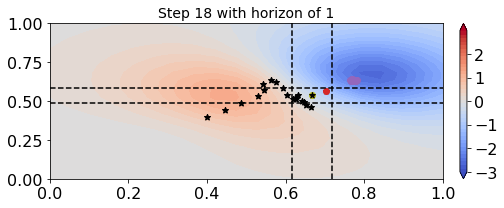

  4%|▍         | 2/50 [00:00<00:03, 13.74it/s]

x0:  [[0.7184249758720398, 0.578349232673645]] , a:  [[[0.7387174367904663, 0.5869641304016113]], [[0.7346747517585754, 0.5969683527946472]], [[0.7226992249488831, 0.5891862511634827]], [[0.7201836705207825, 0.5897219777107239]], [[0.719529926776886, 0.5967583656311035]]] , loss:  -1.0947851163383011


 24%|██▍       | 12/50 [00:00<00:02, 13.60it/s]

x0:  [[0.735357403755188, 0.596625030040741]] , a:  [[[0.7706783413887024, 0.6247544288635254]], [[0.7682785987854004, 0.6309964060783386]], [[0.7604467272758484, 0.626266598701477]], [[0.7586086392402649, 0.6266234517097473]], [[0.7581037878990173, 0.6309325098991394]]] , loss:  -1.275951206438204


 44%|████▍     | 22/50 [00:01<00:02, 13.82it/s]

x0:  [[0.7419103384017944, 0.6038594245910645]] , a:  [[[0.7824522256851196, 0.6402168273925781]], [[0.7810035347938538, 0.643800675868988]], [[0.7765483260154724, 0.6411870121955872]], [[0.7754924297332764, 0.64141446352005]], [[0.7751737236976624, 0.643893837928772]]] , loss:  -1.2922116496557972


 64%|██████▍   | 32/50 [00:02<00:01, 13.76it/s]

x0:  [[0.7439730763435364, 0.6059424877166748]] , a:  [[[0.7858604192733765, 0.644824206829071]], [[0.7847867012023926, 0.6472647190093994]], [[0.781875491142273, 0.645598292350769]], [[0.7811995148658752, 0.6457766890525818]], [[0.780966579914093, 0.647492527961731]]] , loss:  -1.2916272151116974


 84%|████████▍ | 42/50 [00:03<00:00, 12.76it/s]

x0:  [[0.7444667816162109, 0.6061453223228455]] , a:  [[[0.7862852215766907, 0.6454530358314514]], [[0.7853832840919495, 0.6473010778427124]], [[0.7832817435264587, 0.646187961101532]], [[0.7827895283699036, 0.6463522911071777]], [[0.7825861573219299, 0.6476903557777405]]] , loss:  -1.2913200941117384


100%|██████████| 50/50 [00:03<00:00, 12.97it/s]


Current optimal loss -1.3859006637405298;optimal action: tensor([[0.7607, 0.6195]], grad_fn=<AddBackward0>)


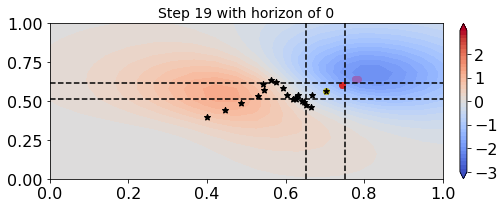

-------------------- Ground truth surface --------------------


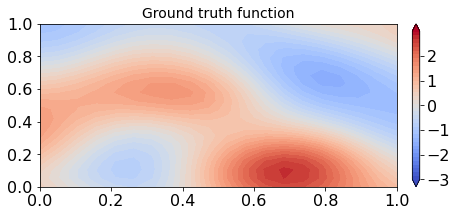

  2%|▏         | 1/50 [00:09<07:31,  9.21s/it]

x0:  [[0.41736918687820435, 0.413275808095932]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.6563698053359985, 0.6656057238578796]], [[0.635088324546814, 0.6909789443016052]], [[0.6217372417449951, 0.5985367298126221]], [[0.6849215030670166, 0.6608688831329346]], [[0.6872372627258301, 0.6487777233123779]]], [[[0.6399069428443909, 0.6251236796379089]], [[0.6266849040985107, 0.6059280037879944]], [[0.6917455196380615, 0.6138479709625244]], [[0.6645910739898682, 0.659786581993103]], [[0.6670327186584473, 0.7168115973472595]]], [[[0.5969390273094177, 0.6652012467384338]], [[0.6402202248573303, 0.5890206098556519]], [[0.7094412446022034, 0.6446453928947449]], [[0.6556985378265381, 0.6058014631271362]], [[0.6682765483856201, 0.6765671372413635]]], [[[0.6578742265701294, 0.656415581703186]], [[0.6860085725784302, 0.6507915258407593]], [[0.6062317490577698, 0.6310310959815979]], [[0.6937357187271118, 0.6382388472557068]], [[0.6837266087532043, 0.6564642190933228]]], [[[0.6527378559112549, 0.6513088345527649]

 22%|██▏       | 11/50 [01:40<05:52,  9.05s/it]

x0:  [[0.43261945247650146, 0.42258909344673157]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.8005433082580566, 0.855004072189331]], [[0.768416166305542, 0.8362157344818115]], [[0.8522230386734009, 0.8291275501251221]], [[0.8277544975280762, 0.7945199012756348]], [[0.8495363593101501, 0.7813533544540405]]], [[[0.8282063007354736, 0.85683673620224]], [[0.8541862368583679, 0.815285861492157]], [[0.8578653931617737, 0.7772147059440613]], [[0.8234602212905884, 0.819455623626709]], [[0.7406433820724487, 0.8284575939178467]]], [[[0.8061059713363647, 0.898120105266571]], [[0.8806363940238953, 0.7969288229942322]], [[0.8457533121109009, 0.7125071287155151]], [[0.8686522245407104, 0.7635562419891357]], [[0.7811787128448486, 0.7717410326004028]]], [[[0.7997753024101257, 0.807455837726593]], [[0.8767714500427246, 0.7361799478530884]], [[0.8313491344451904, 0.8447849750518799]], [[0.8862227201461792, 0.7604765295982361]], [[0.8175508379936218, 0.7894383072853088]]], [[[0.7968298196792603, 0.779921293258667]], [

 42%|████▏     | 21/50 [03:10<04:19,  8.96s/it]

x0:  [[0.4389450252056122, 0.4331464469432831]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.7510234117507935, 0.8355140686035156]], [[0.7767975926399231, 0.8162952661514282]], [[0.8033899068832397, 0.7984852194786072]], [[0.7974575757980347, 0.7820870876312256]], [[0.8278300762176514, 0.7546484470367432]]], [[[0.7662491202354431, 0.8201894760131836]], [[0.8236002922058105, 0.7706167697906494]], [[0.8259527087211609, 0.7482682466506958]], [[0.7958598136901855, 0.7948961853981018]], [[0.7894694209098816, 0.8472331166267395]]], [[[0.7678335309028625, 0.8699230551719666]], [[0.8500946760177612, 0.7423928380012512]], [[0.8790951371192932, 0.7602336406707764]], [[0.8353602886199951, 0.7154847383499146]], [[0.814774751663208, 0.807200014591217]]], [[[0.8126027584075928, 0.7894604206085205]], [[0.860244870185852, 0.7277877330780029]], [[0.8049471974372864, 0.8071485757827759]], [[0.8424811363220215, 0.7102669477462769]], [[0.8069440722465515, 0.7793828248977661]]], [[[0.7999929189682007, 0.7800335884094238]

 62%|██████▏   | 31/50 [04:42<02:52,  9.10s/it]

x0:  [[0.44221603870391846, 0.4402436912059784]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.7958130240440369, 0.8764463663101196]], [[0.8086785674095154, 0.817497968673706]], [[0.7830489873886108, 0.7962636351585388]], [[0.8294639587402344, 0.8165785670280457]], [[0.8562714457511902, 0.785298764705658]]], [[[0.8092161417007446, 0.8474637866020203]], [[0.8427313566207886, 0.7798283100128174]], [[0.8593064546585083, 0.7910860776901245]], [[0.8406366109848022, 0.8199585676193237]], [[0.78727787733078, 0.8521231412887573]]], [[[0.7765470743179321, 0.8818092346191406]], [[0.8694422245025635, 0.7433441877365112]], [[0.8660971522331238, 0.7850875854492188]], [[0.8650201559066772, 0.7334964871406555]], [[0.8095426559448242, 0.821426272392273]]], [[[0.8388144373893738, 0.8033609390258789]], [[0.8877847194671631, 0.7427300810813904]], [[0.8224272131919861, 0.8060194849967957]], [[0.8798522353172302, 0.758785605430603]], [[0.8317441344261169, 0.8021973371505737]]], [[[0.835132896900177, 0.8148064017295837]], 

 82%|████████▏ | 41/50 [06:14<01:24,  9.41s/it]

x0:  [[0.44399356842041016, 0.4437546133995056]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.7897213697433472, 0.8769189119338989]], [[0.8137689232826233, 0.825820803642273]], [[0.805556058883667, 0.8398925065994263]], [[0.8244885206222534, 0.8019428253173828]], [[0.8437825441360474, 0.7841375470161438]]], [[[0.8015310168266296, 0.8442527055740356]], [[0.8422433733940125, 0.7902528047561646]], [[0.8367276191711426, 0.7813817858695984]], [[0.8235576748847961, 0.8102821111679077]], [[0.7949405312538147, 0.8575144410133362]]], [[[0.7876201868057251, 0.8827193379402161]], [[0.8811936378479004, 0.7564700841903687]], [[0.8599638938903809, 0.800723671913147]], [[0.8707259297370911, 0.7322941422462463]], [[0.8085022568702698, 0.8357446789741516]]], [[[0.8406854867935181, 0.8085653781890869]], [[0.8747479915618896, 0.7439371347427368]], [[0.841124415397644, 0.8253216743469238]], [[0.8580905199050903, 0.7438008785247803]], [[0.8225330710411072, 0.8041613101959229]]], [[[0.8249831199645996, 0.8218352198600769]

100%|██████████| 50/50 [07:35<00:00,  9.11s/it]


Current optimal loss 1.0703688152246689;optimal action: tensor([[0.4562, 0.4566]], grad_fn=<AddBackward0>)


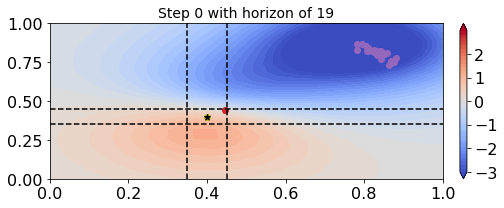

  2%|▏         | 1/50 [00:08<06:54,  8.47s/it]

x0:  [[0.45013198256492615, 0.44857290387153625]] , a:  [[[[[[[[[[[[[[[[[[[[[0.6448973417282104, 0.663576066493988]], [[0.7048101425170898, 0.719514012336731]], [[0.6543521881103516, 0.6918246150016785]], [[0.6800636053085327, 0.698340654373169]], [[0.6738197803497314, 0.6599002480506897]]], [[[0.6691100597381592, 0.6639522314071655]], [[0.6485475301742554, 0.6699613332748413]], [[0.680761992931366, 0.6769710779190063]], [[0.7020031213760376, 0.7012733817100525]], [[0.6312124133110046, 0.6091312766075134]]], [[[0.732639491558075, 0.6885437369346619]], [[0.6722079515457153, 0.7133737802505493]], [[0.6948300004005432, 0.6702876091003418]], [[0.719140887260437, 0.6858987212181091]], [[0.6566712856292725, 0.7032749056816101]]], [[[0.6692447066307068, 0.6903485059738159]], [[0.6491599082946777, 0.7485419511795044]], [[0.684740424156189, 0.6938706040382385]], [[0.6556273698806763, 0.6982449889183044]], [[0.7150475978851318, 0.6548429131507874]]], [[[0.6865993738174438, 0.6731793880462646]], 

 22%|██▏       | 11/50 [01:35<05:34,  8.59s/it]

x0:  [[0.46580326557159424, 0.45090678334236145]] , a:  [[[[[[[[[[[[[[[[[[[[[0.9224361777305603, 0.9052019119262695]], [[0.9117416739463806, 0.8952058553695679]], [[0.8793420195579529, 0.939416229724884]], [[0.9095650911331177, 0.8900222182273865]], [[0.935269296169281, 0.8908259272575378]]], [[[0.9216250777244568, 0.9025366306304932]], [[0.8901553750038147, 0.8985921740531921]], [[0.9201776385307312, 0.8686399459838867]], [[0.8464797735214233, 0.905205488204956]], [[0.9259008765220642, 0.8839770555496216]]], [[[0.9181378483772278, 0.849277138710022]], [[0.887797474861145, 0.925017774105072]], [[0.9313250184059143, 0.898967444896698]], [[0.9154724478721619, 0.850552499294281]], [[0.8711912631988525, 0.938713550567627]]], [[[0.9100919961929321, 0.9081087112426758]], [[0.821256697177887, 0.9473372101783752]], [[0.8863498568534851, 0.9171417355537415]], [[0.886530876159668, 0.939683198928833]], [[0.9442809820175171, 0.8525908589363098]]], [[[0.9416487812995911, 0.891563892364502]], [[0.88

 42%|████▏     | 21/50 [03:00<04:04,  8.45s/it]

x0:  [[0.47303301095962524, 0.4586511254310608]] , a:  [[[[[[[[[[[[[[[[[[[[[0.9336025714874268, 0.9135860204696655]], [[0.8812980055809021, 0.8426876068115234]], [[0.8797867894172668, 0.9519861936569214]], [[0.8963159918785095, 0.8512433767318726]], [[0.9079961180686951, 0.8772441744804382]]], [[[0.9046474099159241, 0.8765434622764587]], [[0.8816815614700317, 0.8813392519950867]], [[0.9005923867225647, 0.8296163082122803]], [[0.7839959263801575, 0.9109923839569092]], [[0.950981616973877, 0.9145651459693909]]], [[[0.9023308157920837, 0.8331388235092163]], [[0.8384556174278259, 0.8962444067001343]], [[0.8867052793502808, 0.8628027439117432]], [[0.8900095224380493, 0.8309044241905212]], [[0.8384385704994202, 0.9114748239517212]]], [[[0.8757631778717041, 0.8801268339157104]], [[0.7845264077186584, 0.9134533405303955]], [[0.8451650142669678, 0.8882125616073608]], [[0.8500887155532837, 0.9191187620162964]], [[0.9196965098381042, 0.8244655728340149]]], [[[0.9180014729499817, 0.834728002548217

 62%|██████▏   | 31/50 [04:27<02:43,  8.60s/it]

x0:  [[0.47826021909713745, 0.4651343822479248]] , a:  [[[[[[[[[[[[[[[[[[[[[0.8899379372596741, 0.8780787587165833]], [[0.9271823167800903, 0.8769856691360474]], [[0.8261883854866028, 0.9010140895843506]], [[0.9276532530784607, 0.863093376159668]], [[0.9011980295181274, 0.8659040927886963]]], [[[0.9012446999549866, 0.864290714263916]], [[0.8805704712867737, 0.850549578666687]], [[0.9253036975860596, 0.8594419360160828]], [[0.7978862524032593, 0.9535003304481506]], [[0.8929800391197205, 0.8617998361587524]]], [[[0.9267781376838684, 0.8723100423812866]], [[0.8529030680656433, 0.9214938282966614]], [[0.9030240774154663, 0.8813856840133667]], [[0.926572322845459, 0.8812101483345032]], [[0.8535998463630676, 0.9106318950653076]]], [[[0.8799834847450256, 0.8756704926490784]], [[0.82660973072052, 0.9394533634185791]], [[0.8657767176628113, 0.9077481627464294]], [[0.8496127724647522, 0.9206305742263794]], [[0.9322529435157776, 0.8410614132881165]]], [[[0.9254335165023804, 0.8214517831802368]], 

 82%|████████▏ | 41/50 [05:54<01:20,  8.90s/it]

x0:  [[0.4821223318576813, 0.47064298391342163]] , a:  [[[[[[[[[[[[[[[[[[[[[0.8888487219810486, 0.9021359086036682]], [[0.917018711566925, 0.8610014915466309]], [[0.8466532826423645, 0.9252379536628723]], [[0.9427074790000916, 0.8727688789367676]], [[0.9215978980064392, 0.8799208402633667]]], [[[0.925252377986908, 0.8767399191856384]], [[0.9280633926391602, 0.8776554465293884]], [[0.9348151683807373, 0.8706157207489014]], [[0.7833334803581238, 0.9561435580253601]], [[0.8971611857414246, 0.8706009984016418]]], [[[0.9170199036598206, 0.8639397025108337]], [[0.862882673740387, 0.9278170466423035]], [[0.9139382839202881, 0.8896594643592834]], [[0.923819899559021, 0.8755799531936646]], [[0.8740431666374207, 0.9238664507865906]]], [[[0.9003115296363831, 0.8936886191368103]], [[0.8445056080818176, 0.9312204122543335]], [[0.8728798627853394, 0.9133527874946594]], [[0.8799638748168945, 0.9460324645042419]], [[0.9476336240768433, 0.851291298866272]]], [[[0.9549445509910583, 0.8405779004096985]],

100%|██████████| 50/50 [07:10<00:00,  8.62s/it]


Current optimal loss 1.0505336696563103;optimal action: tensor([[0.4967, 0.4870]], grad_fn=<AddBackward0>)


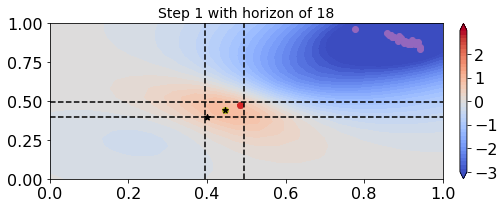

  2%|▏         | 1/50 [00:07<06:30,  7.96s/it]

x0:  [[0.48500603437423706, 0.4908790588378906]] , a:  [[[[[[[[[[[[[[[[[[[[0.7000398635864258, 0.7339023947715759]], [[0.6500520706176758, 0.7382710576057434]], [[0.672232449054718, 0.7442043423652649]], [[0.6932146549224854, 0.7809934616088867]], [[0.7280638217926025, 0.6783792972564697]]], [[[0.7136915326118469, 0.7431135177612305]], [[0.7125792503356934, 0.6955897212028503]], [[0.7486152052879333, 0.6976260542869568]], [[0.7365312576293945, 0.693230926990509]], [[0.7236272096633911, 0.7071529626846313]]], [[[0.6723781228065491, 0.7089071869850159]], [[0.7212092280387878, 0.702608585357666]], [[0.7087334990501404, 0.7717168927192688]], [[0.6628128290176392, 0.7163208723068237]], [[0.6888965368270874, 0.7940124869346619]]], [[[0.6792895197868347, 0.6718750596046448]], [[0.7048919200897217, 0.7265878915786743]], [[0.6709503531455994, 0.6803169846534729]], [[0.6777898073196411, 0.6864331364631653]], [[0.7024052739143372, 0.6820735931396484]]], [[[0.721141517162323, 0.7385894060134888]],

 22%|██▏       | 11/50 [01:29<05:20,  8.22s/it]

x0:  [[0.5045850276947021, 0.5062751770019531]] , a:  [[[[[[[[[[[[[[[[[[[[0.9086164236068726, 0.917749285697937]], [[0.8506361842155457, 0.9793139100074768]], [[0.9031923413276672, 0.9708115458488464]], [[0.8615336418151855, 0.9794716835021973]], [[0.9672259092330933, 0.905234694480896]]], [[[0.9117841720581055, 0.9309800267219543]], [[0.9410022497177124, 0.9135511517524719]], [[0.9661810994148254, 0.8786988258361816]], [[0.9699008464813232, 0.8772481083869934]], [[0.9559979438781738, 0.905443549156189]]], [[[0.8889477252960205, 0.9227600693702698]], [[0.9445239305496216, 0.8906350135803223]], [[0.8932566046714783, 0.9545831680297852]], [[0.9252568483352661, 0.9433228969573975]], [[0.8781853914260864, 0.9529483318328857]]], [[[0.9375848174095154, 0.9156196117401123]], [[0.8821127414703369, 0.9342042207717896]], [[0.9388601779937744, 0.9352031946182251]], [[0.9505929946899414, 0.9244159460067749]], [[0.9524551630020142, 0.9046168923377991]]], [[[0.9109373092651367, 0.9093508124351501]],

 42%|████▏     | 21/50 [02:50<03:54,  8.07s/it]

x0:  [[0.513748288154602, 0.5122528672218323]] , a:  [[[[[[[[[[[[[[[[[[[[0.8940116763114929, 0.8723108768463135]], [[0.8357390761375427, 0.9729954600334167]], [[0.8822438716888428, 0.9453827142715454]], [[0.850986123085022, 0.9563380479812622]], [[0.9492346048355103, 0.8617352247238159]]], [[[0.8747936487197876, 0.8832837343215942]], [[0.8992254137992859, 0.8971371650695801]], [[0.9462370276451111, 0.824913501739502]], [[0.9588128924369812, 0.8298620581626892]], [[0.9335582256317139, 0.88224858045578]]], [[[0.8479981422424316, 0.9002853631973267]], [[0.9152979850769043, 0.8777403235435486]], [[0.8617130517959595, 0.9259604811668396]], [[0.9253746867179871, 0.9406054615974426]], [[0.8701724410057068, 0.9231395721435547]]], [[[0.9421663880348206, 0.9046241641044617]], [[0.8575490117073059, 0.8973870873451233]], [[0.9670981764793396, 0.9343423247337341]], [[0.9580034613609314, 0.9018266201019287]], [[0.9504411220550537, 0.8738353252410889]]], [[[0.876106321811676, 0.8709851503372192]], [[

 62%|██████▏   | 31/50 [04:12<02:35,  8.19s/it]

x0:  [[0.5195550918579102, 0.5155295133590698]] , a:  [[[[[[[[[[[[[[[[[[[[0.9183449745178223, 0.8941349387168884]], [[0.8370808959007263, 0.9446997046470642]], [[0.8906650543212891, 0.9414563179016113]], [[0.8669657707214355, 0.9624335169792175]], [[0.9467679858207703, 0.8528749942779541]]], [[[0.9103531241416931, 0.9096947312355042]], [[0.8921860456466675, 0.9023209810256958]], [[0.9777394533157349, 0.8455172181129456]], [[0.9802725315093994, 0.8090968728065491]], [[0.9341097474098206, 0.881219208240509]]], [[[0.8439050316810608, 0.908871591091156]], [[0.9136231541633606, 0.8746699690818787]], [[0.8973877429962158, 0.9636951684951782]], [[0.8958200216293335, 0.907699465751648]], [[0.8892071843147278, 0.9288161993026733]]], [[[0.9092040657997131, 0.8547161817550659]], [[0.9083792567253113, 0.9203922152519226]], [[0.9278910160064697, 0.8724192976951599]], [[0.9274697303771973, 0.8610045909881592]], [[0.929664134979248, 0.8314634561538696]]], [[[0.9197367429733276, 0.9025726914405823]], 

 82%|████████▏ | 41/50 [05:32<01:12,  8.11s/it]

x0:  [[0.523411214351654, 0.5175548791885376]] , a:  [[[[[[[[[[[[[[[[[[[[0.9312368035316467, 0.904842734336853]], [[0.8776153326034546, 0.952541708946228]], [[0.9062768816947937, 0.9493593573570251]], [[0.8816713094711304, 0.9661800861358643]], [[0.9649559259414673, 0.8674602508544922]]], [[[0.9095824956893921, 0.8968877196311951]], [[0.9124359488487244, 0.9209378361701965]], [[0.9781493544578552, 0.8548045754432678]], [[1.0, 0.8192490935325623]], [[0.9395684003829956, 0.8946022391319275]]], [[[0.8706018328666687, 0.9267453551292419]], [[0.9383562803268433, 0.8888689279556274]], [[0.8919205665588379, 0.9390532970428467]], [[0.9326249361038208, 0.9352633357048035]], [[0.8939628601074219, 0.9154118299484253]]], [[[0.9455773830413818, 0.8810850381851196]], [[0.9051156640052795, 0.9138538837432861]], [[0.9443675875663757, 0.8802265524864197]], [[0.9669058322906494, 0.8966071605682373]], [[0.9613907933235168, 0.8540951013565063]]], [[[0.9190645217895508, 0.8895485401153564]], [[0.9035633802

100%|██████████| 50/50 [06:46<00:00,  8.14s/it]


Current optimal loss 0.8752807910853915;optimal action: tensor([[0.5389, 0.5317]], grad_fn=<AddBackward0>)


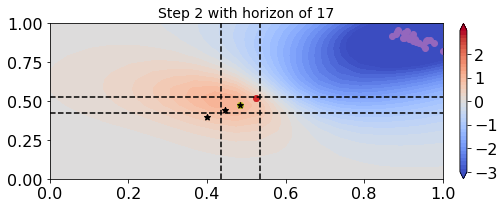

  2%|▏         | 1/50 [00:07<06:06,  7.48s/it]

x0:  [[0.5437572598457336, 0.5383471846580505]] , a:  [[[[[[[[[[[[[[[[[[[0.7122585773468018, 0.72474205493927]], [[0.7427229881286621, 0.7373331189155579]], [[0.7599265575408936, 0.7526440024375916]], [[0.7428227663040161, 0.6963995695114136]], [[0.7286607623100281, 0.7606611847877502]]], [[[0.7214365005493164, 0.7099573612213135]], [[0.7656310796737671, 0.746322512626648]], [[0.8014719486236572, 0.7874730825424194]], [[0.7532774209976196, 0.7184260487556458]], [[0.7115597724914551, 0.7175322771072388]]], [[[0.7413024306297302, 0.6982796788215637]], [[0.7296454906463623, 0.6967053413391113]], [[0.7628838419914246, 0.7072245478630066]], [[0.7531548142433167, 0.7771491408348083]], [[0.7419832944869995, 0.7164378762245178]]], [[[0.7023016810417175, 0.7836986184120178]], [[0.7381969690322876, 0.7345829606056213]], [[0.7567484974861145, 0.7306311130523682]], [[0.7393938302993774, 0.7573175430297852]], [[0.7082309126853943, 0.7543798089027405]]], [[[0.7353695631027222, 0.7082690596580505]], 

 22%|██▏       | 11/50 [01:22<04:52,  7.50s/it]

x0:  [[0.5562272667884827, 0.5477449893951416]] , a:  [[[[[[[[[[[[[[[[[[[0.9295042157173157, 0.9622894525527954]], [[0.9436119794845581, 0.9379999041557312]], [[0.9639052748680115, 0.9708315134048462]], [[0.94167160987854, 0.906502366065979]], [[0.9458244442939758, 0.9490052461624146]]], [[[0.9554131627082825, 0.9427773356437683]], [[0.9517673850059509, 0.9110053777694702]], [[0.9308686256408691, 0.9437432289123535]], [[0.9573158025741577, 0.9334921836853027]], [[0.9530388116836548, 0.9163491725921631]]], [[[0.9720553159713745, 0.9326024055480957]], [[0.964159369468689, 0.9600273966789246]], [[0.9862887859344482, 0.9375640749931335]], [[0.918042778968811, 0.9772709012031555]], [[0.9583977460861206, 0.9266687035560608]]], [[[0.8863723278045654, 1.0]], [[0.9552063941955566, 0.9565163254737854]], [[0.9778228402137756, 0.9127603769302368]], [[0.9497550129890442, 0.9333745837211609]], [[0.9364364743232727, 0.9596529006958008]]], [[[0.9710298776626587, 0.9337522983551025]], [[0.8972011208534

 42%|████▏     | 21/50 [02:40<03:39,  7.57s/it]

x0:  [[0.5602356791496277, 0.5557785034179688]] , a:  [[[[[[[[[[[[[[[[[[[0.9072030186653137, 0.9769097566604614]], [[0.9232453107833862, 0.9109504818916321]], [[0.9250359535217285, 0.9424697756767273]], [[0.9597715735435486, 0.9158132672309875]], [[0.9045583605766296, 0.9225541353225708]]], [[[0.9554032683372498, 0.9264540672302246]], [[0.9349109530448914, 0.8676906228065491]], [[0.8706836700439453, 0.9211554527282715]], [[0.971688985824585, 0.9138054251670837]], [[0.9716287851333618, 0.9221211671829224]]], [[[0.9708386063575745, 0.9310154914855957]], [[0.9824306964874268, 0.9769311547279358]], [[0.9800606369972229, 0.9170005917549133]], [[0.8653101325035095, 0.951560914516449]], [[0.9701108336448669, 0.9339200258255005]]], [[[0.8623042106628418, 1.0]], [[0.9555861353874207, 0.951730489730835]], [[0.9728410840034485, 0.8945866823196411]], [[0.9281818270683289, 0.9093392491340637]], [[0.9063655138015747, 0.9564830660820007]]], [[[0.98321932554245, 0.9236937165260315]], [[0.8643901348114

 62%|██████▏   | 31/50 [03:56<02:24,  7.59s/it]

x0:  [[0.5619841814041138, 0.5606526136398315]] , a:  [[[[[[[[[[[[[[[[[[[0.8792553544044495, 0.9561511874198914]], [[0.9146184325218201, 0.897527813911438]], [[0.9050135612487793, 0.9141683578491211]], [[0.9313435554504395, 0.8774623274803162]], [[0.9136135578155518, 0.9250756502151489]]], [[[0.9143801331520081, 0.8891230821609497]], [[0.9549527168273926, 0.8861566185951233]], [[0.9137150049209595, 0.9571049213409424]], [[0.9447513818740845, 0.8678197264671326]], [[0.931785523891449, 0.8756144642829895]]], [[[0.9293562769889832, 0.9046158194541931]], [[0.927708625793457, 0.9294822216033936]], [[0.9449740648269653, 0.8746502995491028]], [[0.8782342672348022, 0.9665012359619141]], [[0.9308195114135742, 0.8883970975875854]]], [[[0.8342352509498596, 1.0]], [[0.89955735206604, 0.9098911881446838]], [[0.937145471572876, 0.8412438631057739]], [[0.9053026437759399, 0.8943453431129456]], [[0.8860575556755066, 0.9327021837234497]]], [[[0.9401864409446716, 0.8625324964523315]], [[0.86845469474792

 82%|████████▏ | 41/50 [05:15<01:09,  7.73s/it]

x0:  [[0.5628855228424072, 0.5633655190467834]] , a:  [[[[[[[[[[[[[[[[[[[0.9004823565483093, 0.9662525057792664]], [[0.9404063820838928, 0.920728325843811]], [[0.9292457699775696, 0.9370386600494385]], [[0.9400720000267029, 0.8918128609657288]], [[0.9266151785850525, 0.9429812431335449]]], [[[0.9376919865608215, 0.9243236184120178]], [[0.959455132484436, 0.8945095539093018]], [[0.9172243475914001, 0.9461646676063538]], [[0.959490954875946, 0.8788913488388062]], [[0.9498882293701172, 0.8896538019180298]]], [[[0.9363729357719421, 0.929307222366333]], [[0.9077950119972229, 0.9366095066070557]], [[0.9627251029014587, 0.8929075598716736]], [[0.8893757462501526, 0.9745932817459106]], [[0.9480078220367432, 0.9020571112632751]]], [[[0.8605725169181824, 1.0]], [[0.9240689277648926, 0.9313191771507263]], [[0.9689302444458008, 0.8493539690971375]], [[0.930645227432251, 0.9215654134750366]], [[0.9096948504447937, 0.9546674489974976]]], [[[0.9598017334938049, 0.871638298034668]], [[0.88185614347457

100%|██████████| 50/50 [06:23<00:00,  7.68s/it]


Current optimal loss 0.39784051324744374;optimal action: tensor([[0.5773, 0.5787]], grad_fn=<AddBackward0>)


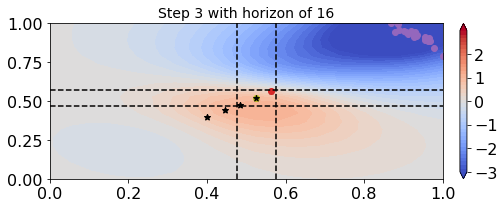

  2%|▏         | 1/50 [00:06<05:42,  6.98s/it]

x0:  [[0.5654918551445007, 0.5876206755638123]] , a:  [[[[[[[[[[[[[[[[[[0.7704819440841675, 0.7947205901145935]], [[0.7459562420845032, 0.7982597947120667]], [[0.743159294128418, 0.8148531913757324]], [[0.7898285388946533, 0.8186454772949219]], [[0.676476776599884, 0.8525794744491577]]], [[[0.7624956965446472, 0.7923109531402588]], [[0.7541166543960571, 0.8017189502716064]], [[0.7683385610580444, 0.7621423602104187]], [[0.7461843490600586, 0.7869303226470947]], [[0.7429097890853882, 0.7611047029495239]]], [[[0.7689453959465027, 0.7991276979446411]], [[0.7415633201599121, 0.7493693828582764]], [[0.7831277847290039, 0.7827368974685669]], [[0.7384562492370605, 0.7705127000808716]], [[0.7941625118255615, 0.7758099436759949]]], [[[0.7149286866188049, 0.7620617747306824]], [[0.724058985710144, 0.8064404726028442]], [[0.7577422261238098, 0.7950222492218018]], [[0.8108269572257996, 0.7628481984138489]], [[0.7845326066017151, 0.7186036705970764]]], [[[0.7437949776649475, 0.7857341766357422]], [

 22%|██▏       | 11/50 [01:19<04:38,  7.13s/it]

x0:  [[0.5873820781707764, 0.5732824206352234]] , a:  [[[[[[[[[[[[[[[[[[0.967991828918457, 0.9363747835159302]], [[0.952704906463623, 0.9310479760169983]], [[0.9134289026260376, 0.9577233791351318]], [[0.9553837776184082, 0.923927903175354]], [[0.8274677395820618, 0.9968553781509399]]], [[[0.9668618440628052, 0.9301577210426331]], [[0.9344013929367065, 0.9299277663230896]], [[0.9767587780952454, 0.9150133728981018]], [[0.9423303604125977, 0.9349882006645203]], [[0.9599097967147827, 0.9346917271614075]]], [[[0.9831954836845398, 0.9280537962913513]], [[0.977279007434845, 0.9032304286956787]], [[0.9638736844062805, 0.9096197485923767]], [[0.9494411945343018, 0.932498037815094]], [[0.9703454375267029, 0.8626338839530945]]], [[[0.9233689308166504, 0.9093801379203796]], [[0.9189853668212891, 0.9478529691696167]], [[0.9510911703109741, 0.9554842114448547]], [[0.9870745539665222, 0.8784741163253784]], [[1.0, 0.8624793887138367]]], [[[0.9499520063400269, 0.9476750493049622]], [[0.97166079282760

 42%|████▏     | 21/50 [02:30<03:25,  7.09s/it]

x0:  [[0.5946693420410156, 0.5663325786590576]] , a:  [[[[[[[[[[[[[[[[[[0.9277361035346985, 0.8923376202583313]], [[0.9106322526931763, 0.8612586855888367]], [[0.8773921728134155, 0.9153872132301331]], [[0.9088513851165771, 0.8655033707618713]], [[0.8111424446105957, 0.933539867401123]]], [[[0.9141284227371216, 0.8591342568397522]], [[0.8996227979660034, 0.8783180713653564]], [[0.9334883093833923, 0.8731799125671387]], [[0.9008722901344299, 0.89515221118927]], [[0.9230867624282837, 0.8848103880882263]]], [[[0.9375172257423401, 0.8740391731262207]], [[0.9815716743469238, 0.8898378610610962]], [[0.9152562022209167, 0.8503408432006836]], [[0.9318646788597107, 0.8934797644615173]], [[0.9519365429878235, 0.8189411759376526]]], [[[0.9181222915649414, 0.8850180506706238]], [[0.8870158195495605, 0.9073438048362732]], [[0.9150935411453247, 0.9030997157096863]], [[0.9309551119804382, 0.8235169053077698]], [[1.0, 0.8387912511825562]]], [[[0.9335317611694336, 0.8968482613563538]], [[0.937047600746

 62%|██████▏   | 31/50 [03:43<02:16,  7.18s/it]

x0:  [[0.5966326594352722, 0.5596874952316284]] , a:  [[[[[[[[[[[[[[[[[[0.9097557067871094, 0.872331976890564]], [[0.9216578602790833, 0.8735864162445068]], [[0.8703839778900146, 0.9015755653381348]], [[0.9228035807609558, 0.8873252272605896]], [[0.8435755372047424, 0.9126453995704651]]], [[[0.9199087619781494, 0.8754462003707886]], [[0.9201169610023499, 0.8860084414482117]], [[0.9049180150032043, 0.8540651798248291]], [[0.8855789303779602, 0.8795163035392761]], [[0.9097541570663452, 0.8548229336738586]]], [[[0.9068077206611633, 0.8603512048721313]], [[0.9226285815238953, 0.8343430757522583]], [[0.9218051433563232, 0.8687074780464172]], [[0.8975021243095398, 0.8491948246955872]], [[0.9364433288574219, 0.809859573841095]]], [[[0.8711562752723694, 0.8295232057571411]], [[0.8752390742301941, 0.8816284537315369]], [[0.893342912197113, 0.8712948560714722]], [[0.9478211402893066, 0.8614998459815979]], [[1.0, 0.7823659777641296]]], [[[0.9094026684761047, 0.8584915399551392]], [[0.930747091770

 82%|████████▏ | 41/50 [04:54<01:03,  7.09s/it]

x0:  [[0.5973698496818542, 0.5613277554512024]] , a:  [[[[[[[[[[[[[[[[[[0.9189174771308899, 0.8961853384971619]], [[0.9141084551811218, 0.8788915872573853]], [[0.8849219679832458, 0.9187480211257935]], [[0.9078854918479919, 0.8828549385070801]], [[0.8652892708778381, 0.9118378162384033]]], [[[0.9151319861412048, 0.884239912033081]], [[0.90606689453125, 0.8820346593856812]], [[0.9171426892280579, 0.8840947151184082]], [[0.9069497585296631, 0.9060024619102478]], [[0.9210298657417297, 0.8746436238288879]]], [[[0.9161822199821472, 0.8961403965950012]], [[0.9229458570480347, 0.8694120049476624]], [[0.9118247032165527, 0.8821274042129517]], [[0.9154676795005798, 0.8726502060890198]], [[0.9531052112579346, 0.830000638961792]]], [[[0.8919813632965088, 0.8437315225601196]], [[0.8837949633598328, 0.8932085037231445]], [[0.8991047739982605, 0.8927041888237]], [[0.9268961548805237, 0.8640866875648499]], [[1.0, 0.7945224046707153]]], [[[0.9162434339523315, 0.8792016506195068]], [[0.9359676837921143

100%|██████████| 50/50 [06:00<00:00,  7.20s/it]


Current optimal loss -0.011573842996936593;optimal action: tensor([[0.6121, 0.5763]], grad_fn=<AddBackward0>)


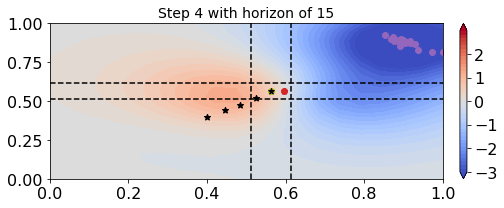

  2%|▏         | 1/50 [00:06<05:28,  6.71s/it]

x0:  [[0.6084104180335999, 0.581817090511322]] , a:  [[[[[[[[[[[[[[[[[0.7861629724502563, 0.7711597084999084]], [[0.8342992067337036, 0.7549923062324524]], [[0.7662950158119202, 0.7539618611335754]], [[0.7941591739654541, 0.7207626700401306]], [[0.8156453967094421, 0.7684718370437622]]], [[[0.7874412536621094, 0.7260939478874207]], [[0.7849788069725037, 0.7735978364944458]], [[0.7574383616447449, 0.7625657320022583]], [[0.8025648593902588, 0.7287755012512207]], [[0.7762479782104492, 0.7621452808380127]]], [[[0.8023706078529358, 0.7405086755752563]], [[0.7875500321388245, 0.7462010979652405]], [[0.7831430435180664, 0.7998756766319275]], [[0.820095956325531, 0.7520495057106018]], [[0.8056720495223999, 0.739323079586029]]], [[[0.7968220710754395, 0.7196023464202881]], [[0.8363389372825623, 0.7986950874328613]], [[0.7903690338134766, 0.785821795463562]], [[0.7621199488639832, 0.7129651308059692]], [[0.7637746930122375, 0.7554836869239807]]], [[[0.7959750294685364, 0.737200915813446]], [[0.

 22%|██▏       | 11/50 [01:12<04:16,  6.59s/it]

x0:  [[0.6148923635482788, 0.5590499043464661]] , a:  [[[[[[[[[[[[[[[[[0.9725764989852905, 0.8590636253356934]], [[1.0, 0.8378248810768127]], [[0.9659126996994019, 0.8875038623809814]], [[0.983571469783783, 0.8366039395332336]], [[0.9837256669998169, 0.8736628293991089]]], [[[0.9921489953994751, 0.8392796516418457]], [[0.980008065700531, 0.8824732303619385]], [[0.9514750242233276, 0.8986684083938599]], [[0.984154462814331, 0.7998223900794983]], [[0.9815974235534668, 0.8940030336380005]]], [[[0.9854257106781006, 0.82674640417099]], [[0.9723540544509888, 0.875506579875946]], [[0.9288393259048462, 0.9148274064064026]], [[0.9863421320915222, 0.827358067035675]], [[0.9770448207855225, 0.8530268669128418]]], [[[0.9881613254547119, 0.8537518978118896]], [[0.9579006433486938, 0.8086529970169067]], [[0.9632921814918518, 0.8858317136764526]], [[0.9499596953392029, 0.8857364654541016]], [[0.9888562560081482, 0.902502715587616]]], [[[0.975738525390625, 0.8321922421455383]], [[0.9925916194915771, 0

 42%|████▏     | 21/50 [02:19<03:11,  6.62s/it]

x0:  [[0.6233798265457153, 0.5494769811630249]] , a:  [[[[[[[[[[[[[[[[[0.9606022238731384, 0.7650967836380005]], [[1.0, 0.767192006111145]], [[0.983385443687439, 0.8365024328231812]], [[1.0, 0.8038507699966431]], [[0.9612749218940735, 0.77638840675354]]], [[[1.0, 0.789459228515625]], [[0.9463648796081543, 0.8033302426338196]], [[0.9637241363525391, 0.8154590129852295]], [[0.9936568737030029, 0.7470705509185791]], [[0.9804088473320007, 0.8233510255813599]]], [[[0.9798981547355652, 0.7596650719642639]], [[0.9665893316268921, 0.7982096076011658]], [[0.9186767935752869, 0.8398192524909973]], [[0.980353593826294, 0.7651963829994202]], [[0.9603931307792664, 0.7791368365287781]]], [[[1.0, 0.800430178642273]], [[0.9468616247177124, 0.7485684156417847]], [[0.9540609121322632, 0.803431510925293]], [[0.9735516309738159, 0.8452373743057251]], [[1.0, 0.8527952432632446]]], [[[0.963922917842865, 0.7779548168182373]], [[0.9613505601882935, 0.7443045377731323]], [[0.9698203802108765, 0.744980096817016

 62%|██████▏   | 31/50 [03:27<02:07,  6.70s/it]

x0:  [[0.625113308429718, 0.5426623225212097]] , a:  [[[[[[[[[[[[[[[[[0.9703465700149536, 0.7249526977539062]], [[1.0, 0.6947655081748962]], [[0.9373776316642761, 0.7459126710891724]], [[1.0, 0.749138355255127]], [[0.9524984359741211, 0.733858585357666]]], [[[1.0, 0.7086672186851501]], [[0.931969165802002, 0.7540948390960693]], [[0.9445410370826721, 0.7419832944869995]], [[0.9873904585838318, 0.7353487610816956]], [[0.9400781989097595, 0.7315282821655273]]], [[[0.9515123963356018, 0.702126681804657]], [[0.9341235756874084, 0.73482346534729]], [[0.9127112030982971, 0.7804002165794373]], [[0.9785313010215759, 0.7463381886482239]], [[0.9323620796203613, 0.7244768142700195]]], [[[1.0, 0.7017138600349426]], [[0.9560438394546509, 0.7399576902389526]], [[0.9476819038391113, 0.7463698387145996]], [[0.9460662007331848, 0.762709379196167]], [[0.972312867641449, 0.7482874393463135]]], [[[0.9343385100364685, 0.7265973091125488]], [[0.9743255376815796, 0.7411484122276306]], [[0.9830882549285889, 0.

 82%|████████▏ | 41/50 [04:35<01:00,  6.71s/it]

x0:  [[0.6251676082611084, 0.5381684303283691]] , a:  [[[[[[[[[[[[[[[[[0.9795297384262085, 0.7195430994033813]], [[1.0, 0.6757416129112244]], [[0.9523922204971313, 0.7195872664451599]], [[1.0, 0.699708878993988]], [[0.963005006313324, 0.7317060232162476]]], [[[1.0, 0.6763687133789062]], [[0.9607671499252319, 0.7468202114105225]], [[0.9769023060798645, 0.7285527586936951]], [[0.9936363697052002, 0.7215473055839539]], [[0.9714325070381165, 0.7400407195091248]]], [[[0.9818835854530334, 0.7132571339607239]], [[0.9671090841293335, 0.7517362833023071]], [[0.9438597559928894, 0.7508581876754761]], [[0.991356372833252, 0.7223472595214844]], [[0.9609507918357849, 0.7356421947479248]]], [[[1.0, 0.6677740812301636]], [[0.9603783488273621, 0.71633380651474]], [[0.9751713871955872, 0.7308157086372375]], [[0.9630821347236633, 0.7414495944976807]], [[0.9655055999755859, 0.7171009182929993]]], [[[0.9640798568725586, 0.7314144372940063]], [[0.9577350616455078, 0.7262042760848999]], [[0.980597734451294,

100%|██████████| 50/50 [05:34<00:00,  6.70s/it]


Current optimal loss -0.13790187424411213;optimal action: tensor([[0.6392, 0.5487]], grad_fn=<AddBackward0>)


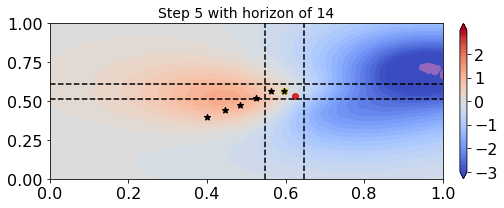

  2%|▏         | 1/50 [00:06<05:03,  6.18s/it]

x0:  [[0.6292555332183838, 0.5498883724212646]] , a:  [[[[[[[[[[[[[[[[0.8131996393203735, 0.7062598466873169]], [[0.8056867122650146, 0.7283636927604675]], [[0.8036657571792603, 0.6887019276618958]], [[0.7868379354476929, 0.7073298692703247]], [[0.7893081307411194, 0.7237293720245361]]], [[[0.7921637296676636, 0.6961565017700195]], [[0.8199172616004944, 0.7335920333862305]], [[0.82025545835495, 0.6931777596473694]], [[0.7987889647483826, 0.7475644946098328]], [[0.8007820248603821, 0.7305883169174194]]], [[[0.7747520208358765, 0.75022953748703]], [[0.7779906988143921, 0.7243590354919434]], [[0.8153486251831055, 0.7048166394233704]], [[0.7793616056442261, 0.7258778810501099]], [[0.7919149398803711, 0.6862911581993103]]], [[[0.795779287815094, 0.7109134197235107]], [[0.7630992531776428, 0.7341030836105347]], [[0.8252413272857666, 0.7063747644424438]], [[0.8181972503662109, 0.716230571269989]], [[0.7754147052764893, 0.7146913409233093]]], [[[0.803395688533783, 0.715448260307312]], [[0.8073

 22%|██▏       | 11/50 [01:08<04:07,  6.34s/it]

x0:  [[0.6106806993484497, 0.5310303568840027]] , a:  [[[[[[[[[[[[[[[[0.9423935413360596, 0.871306836605072]], [[0.9339308738708496, 0.8526612520217896]], [[0.9802244305610657, 0.8344513177871704]], [[0.9554085731506348, 0.8405437469482422]], [[0.9385180473327637, 0.8737382888793945]]], [[[0.9404787421226501, 0.8672589659690857]], [[0.9499765634536743, 0.8351884484291077]], [[0.979690670967102, 0.8151589632034302]], [[0.9270601272583008, 0.8540076017379761]], [[0.9455744028091431, 0.8392633199691772]]], [[[0.9197459816932678, 0.9065456390380859]], [[0.9428238272666931, 0.8751696348190308]], [[0.9730506539344788, 0.8013941645622253]], [[0.9655632376670837, 0.8571426868438721]], [[0.9503113031387329, 0.8447126746177673]]], [[[0.9410372972488403, 0.8538334369659424]], [[0.9273446798324585, 0.8759328126907349]], [[0.9791983962059021, 0.8397380709648132]], [[0.9706964492797852, 0.8187931776046753]], [[0.9226799607276917, 0.881277859210968]]], [[[0.9321470260620117, 0.8644456267356873]], [[0

 42%|████▏     | 21/50 [02:09<02:56,  6.09s/it]

x0:  [[0.6152521967887878, 0.5244347453117371]] , a:  [[[[[[[[[[[[[[[[0.9569336771965027, 0.8496842384338379]], [[0.9435814023017883, 0.8227352499961853]], [[0.9853443503379822, 0.8157917261123657]], [[0.9754908680915833, 0.8049592971801758]], [[0.9521737098693848, 0.8550184369087219]]], [[[0.9518330693244934, 0.849148154258728]], [[0.9420143961906433, 0.7747900485992432]], [[0.9696745276451111, 0.7740099430084229]], [[0.9121387600898743, 0.787276029586792]], [[0.9552325010299683, 0.8057377934455872]]], [[[0.9214921593666077, 0.8780917525291443]], [[0.9644690155982971, 0.8601899743080139]], [[0.9703686237335205, 0.7574273347854614]], [[0.9709634780883789, 0.8196016550064087]], [[0.977141261100769, 0.834511935710907]]], [[[0.9601130485534668, 0.8181495070457458]], [[0.9598363637924194, 0.8661554455757141]], [[0.9807811975479126, 0.7965706586837769]], [[0.9779977202415466, 0.7643445730209351]], [[0.9395957589149475, 0.873725414276123]]], [[[0.9343847036361694, 0.822894275188446]], [[0.93

 62%|██████▏   | 31/50 [03:10<01:55,  6.10s/it]

x0:  [[0.618706226348877, 0.5122648477554321]] , a:  [[[[[[[[[[[[[[[[0.9337973594665527, 0.7684291005134583]], [[0.933999240398407, 0.7772595882415771]], [[0.9642190933227539, 0.7508560419082642]], [[0.9606623649597168, 0.7408909201622009]], [[0.9198315739631653, 0.7912495136260986]]], [[[0.9222196340560913, 0.7759842872619629]], [[0.951396107673645, 0.752812385559082]], [[0.9653077125549316, 0.7464142441749573]], [[0.9330351948738098, 0.7693189382553101]], [[0.9387672543525696, 0.7823426723480225]]], [[[0.9001386761665344, 0.7941064834594727]], [[0.9248502850532532, 0.7862336039543152]], [[0.9660154581069946, 0.7153702974319458]], [[0.9284955263137817, 0.7513050436973572]], [[0.9463257789611816, 0.7818387150764465]]], [[[0.9382752776145935, 0.7583073973655701]], [[0.9274468421936035, 0.7902541756629944]], [[0.9566680192947388, 0.742115318775177]], [[0.9561259150505066, 0.7134324312210083]], [[0.9024648070335388, 0.8117119073867798]]], [[[0.9211511611938477, 0.7563048601150513]], [[0.9

 82%|████████▏ | 41/50 [04:12<00:55,  6.13s/it]

x0:  [[0.6182853579521179, 0.5085445642471313]] , a:  [[[[[[[[[[[[[[[[0.9514720439910889, 0.7650849223136902]], [[0.9591306447982788, 0.7884562015533447]], [[0.9710234999656677, 0.7543582916259766]], [[0.9733315706253052, 0.7585870027542114]], [[0.9361218810081482, 0.7922951579093933]]], [[[0.9372342228889465, 0.7745532989501953]], [[0.9654035568237305, 0.7668106555938721]], [[0.9736000299453735, 0.7676964998245239]], [[0.9546852111816406, 0.7700997591018677]], [[0.9401280879974365, 0.7856898903846741]]], [[[0.9411872625350952, 0.7918604016304016]], [[0.9402954578399658, 0.7794721126556396]], [[0.9834604263305664, 0.7310953140258789]], [[0.9549593329429626, 0.7635247111320496]], [[0.9420396089553833, 0.7718002200126648]]], [[[0.9491821527481079, 0.7816728353500366]], [[0.9379615783691406, 0.7815929651260376]], [[0.9635351300239563, 0.766006588935852]], [[0.9748700857162476, 0.7454187870025635]], [[0.9139214158058167, 0.802144467830658]]], [[[0.9525970220565796, 0.7693529725074768]], [[

100%|██████████| 50/50 [05:08<00:00,  6.16s/it]


Current optimal loss -0.006679637322249613;optimal action: tensor([[0.6343, 0.5179]], grad_fn=<AddBackward0>)


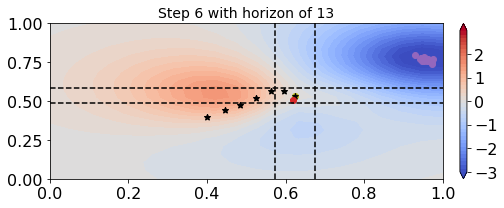

  2%|▏         | 1/50 [00:05<04:49,  5.90s/it]

x0:  [[0.6377984285354614, 0.5213122367858887]] , a:  [[[[[[[[[[[[[[[0.7959868311882019, 0.6913403272628784]], [[0.8715718388557434, 0.6737964749336243]], [[0.7789971232414246, 0.7266445755958557]], [[0.7545021772384644, 0.6628241539001465]], [[0.7836586236953735, 0.6901200413703918]]], [[[0.7976902723312378, 0.6456990838050842]], [[0.8304440975189209, 0.6770702004432678]], [[0.8263469934463501, 0.6768175959587097]], [[0.8024284839630127, 0.6568915843963623]], [[0.8184256553649902, 0.6838440299034119]]], [[[0.8496474623680115, 0.6763616800308228]], [[0.8414896726608276, 0.6510138511657715]], [[0.8367745876312256, 0.6902018785476685]], [[0.7529522180557251, 0.6907088160514832]], [[0.7869278192520142, 0.6579472422599792]]], [[[0.7942314743995667, 0.6921157836914062]], [[0.8175089359283447, 0.674289882183075]], [[0.7552108764648438, 0.6963034272193909]], [[0.7868078947067261, 0.6950350403785706]], [[0.8106533288955688, 0.6940522193908691]]], [[[0.7656095623970032, 0.6785316467285156]], [[

 22%|██▏       | 11/50 [01:03<03:41,  5.67s/it]

x0:  [[0.6186418533325195, 0.5130631923675537]] , a:  [[[[[[[[[[[[[[[0.9327560067176819, 0.8355576992034912]], [[0.9676433801651001, 0.7881766557693481]], [[0.9408460855484009, 0.8712063431739807]], [[0.9465697407722473, 0.8424412608146667]], [[0.9436643719673157, 0.851119339466095]]], [[[0.9393163323402405, 0.7921459078788757]], [[0.9542814493179321, 0.8186662197113037]], [[0.970160186290741, 0.8165770173072815]], [[0.9597689509391785, 0.8052139282226562]], [[0.9683857560157776, 0.8206139802932739]]], [[[0.9574967622756958, 0.8012987971305847]], [[0.9625205993652344, 0.7979380488395691]], [[0.9642093777656555, 0.8193103075027466]], [[0.8828869462013245, 0.8570449352264404]], [[0.9443840980529785, 0.8124643564224243]]], [[[0.9362682104110718, 0.8391470313072205]], [[0.9527430534362793, 0.8007369637489319]], [[0.9212037920951843, 0.8449757099151611]], [[0.9609467387199402, 0.8517630696296692]], [[0.9643265008926392, 0.8417242169380188]]], [[[0.8916718363761902, 0.8238493204116821]], [[0

 42%|████▏     | 21/50 [01:59<02:44,  5.66s/it]

x0:  [[0.6177412867546082, 0.5072212815284729]] , a:  [[[[[[[[[[[[[[[0.9386804103851318, 0.7980411052703857]], [[0.9416008591651917, 0.7281588315963745]], [[0.9385391473770142, 0.8187296986579895]], [[0.9796038269996643, 0.8321148157119751]], [[0.9583829045295715, 0.8258323669433594]]], [[[0.9749723672866821, 0.804069995880127]], [[0.9459729790687561, 0.7803119421005249]], [[0.9584054946899414, 0.7462883591651917]], [[0.9828588962554932, 0.7809664607048035]], [[0.9633793234825134, 0.7952508330345154]]], [[[0.9476629495620728, 0.7539574503898621]], [[0.9549471139907837, 0.7732670903205872]], [[0.9449986219406128, 0.7497034072875977]], [[0.911902904510498, 0.8504974842071533]], [[0.9437522292137146, 0.7989131808280945]]], [[[0.9493153095245361, 0.7878773808479309]], [[0.9591652750968933, 0.7773839831352234]], [[0.9361592531204224, 0.8035515546798706]], [[0.9661498665809631, 0.8115670680999756]], [[0.9342374801635742, 0.7883164286613464]]], [[[0.9285211563110352, 0.8236815333366394]], [[0

 62%|██████▏   | 31/50 [02:56<01:48,  5.71s/it]

x0:  [[0.6142818927764893, 0.5078816413879395]] , a:  [[[[[[[[[[[[[[[0.9234370589256287, 0.7462289333343506]], [[0.9419031143188477, 0.7252094745635986]], [[0.9140519499778748, 0.7513988018035889]], [[0.9449659585952759, 0.7721219658851624]], [[0.9192304611206055, 0.761947512626648]]], [[[0.9529326558113098, 0.7724716067314148]], [[0.9136411547660828, 0.7355628609657288]], [[0.9399547576904297, 0.7140370011329651]], [[0.9511770009994507, 0.7284688949584961]], [[0.917458713054657, 0.750481128692627]]], [[[0.9394866228103638, 0.736157238483429]], [[0.9189638495445251, 0.7350622415542603]], [[0.9500232934951782, 0.733741283416748]], [[0.8913897275924683, 0.8003888726234436]], [[0.8989988565444946, 0.7508577704429626]]], [[[0.9272658228874207, 0.7342414855957031]], [[0.9249627590179443, 0.7369738221168518]], [[0.9198192358016968, 0.741256833076477]], [[0.9220423698425293, 0.739352285861969]], [[0.9171303510665894, 0.7541272044181824]]], [[[0.9215136170387268, 0.7697171568870544]], [[0.9210

 82%|████████▏ | 41/50 [03:54<00:50,  5.57s/it]

x0:  [[0.6106271743774414, 0.5078203082084656]] , a:  [[[[[[[[[[[[[[[0.9526371955871582, 0.7515853643417358]], [[0.9488839507102966, 0.727984607219696]], [[0.9454408884048462, 0.7538616061210632]], [[0.9225203990936279, 0.7315815091133118]], [[0.9176324605941772, 0.7627356648445129]]], [[[0.9335596561431885, 0.7562276124954224]], [[0.9351890087127686, 0.7412340641021729]], [[0.9587387442588806, 0.7366524934768677]], [[0.9406988024711609, 0.7310343384742737]], [[0.9224190711975098, 0.7621303200721741]]], [[[0.9482202529907227, 0.7468745112419128]], [[0.9331234693527222, 0.7432276010513306]], [[0.9509258270263672, 0.7438335418701172]], [[0.9034335613250732, 0.7679783701896667]], [[0.9163755178451538, 0.7527998089790344]]], [[[0.9460135698318481, 0.7443952560424805]], [[0.9339026808738708, 0.7467138171195984]], [[0.9343189597129822, 0.752950131893158]], [[0.9396820068359375, 0.7528430819511414]], [[0.9319695830345154, 0.7593336701393127]]], [[[0.9174748659133911, 0.7393910884857178]], [[0

100%|██████████| 50/50 [04:45<00:00,  5.71s/it]


Current optimal loss 0.10258746334256144;optimal action: tensor([[0.6233, 0.5136]], grad_fn=<AddBackward0>)


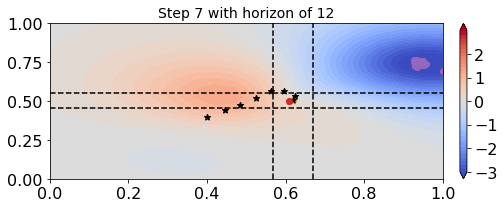

  2%|▏         | 1/50 [00:05<04:17,  5.25s/it]

x0:  [[0.618625283241272, 0.5183292627334595]] , a:  [[[[[[[[[[[[[[0.7890323996543884, 0.6546002626419067]], [[0.7814601063728333, 0.650753915309906]], [[0.8052541017532349, 0.6706138849258423]], [[0.7497346997261047, 0.6368964314460754]], [[0.7582476735115051, 0.6791847944259644]]], [[[0.7483987808227539, 0.6756685376167297]], [[0.770649254322052, 0.6517478227615356]], [[0.766554057598114, 0.6424657702445984]], [[0.7304341197013855, 0.6294946670532227]], [[0.778494656085968, 0.6463227272033691]]], [[[0.7752884030342102, 0.6927397847175598]], [[0.7600110769271851, 0.6900568008422852]], [[0.7636457681655884, 0.6861897706985474]], [[0.7752994298934937, 0.7007903456687927]], [[0.7924037575721741, 0.636434018611908]]], [[[0.7511435747146606, 0.677539050579071]], [[0.7383170127868652, 0.6373539566993713]], [[0.7493460178375244, 0.6700805425643921]], [[0.7899331450462341, 0.6805453300476074]], [[0.7823636531829834, 0.6673769950866699]]], [[[0.7597485780715942, 0.637584924697876]], [[0.774148

 22%|██▏       | 11/50 [00:58<03:30,  5.40s/it]

x0:  [[0.623590886592865, 0.5144354104995728]] , a:  [[[[[[[[[[[[[[0.9660437107086182, 0.8058499097824097]], [[0.9503777027130127, 0.8110987544059753]], [[0.9747282266616821, 0.8063897490501404]], [[0.9091331958770752, 0.7900181412696838]], [[0.9419580698013306, 0.8185511827468872]]], [[[0.9406738877296448, 0.8182246685028076]], [[0.956963062286377, 0.8151065111160278]], [[0.950273334980011, 0.7955732345581055]], [[0.914374828338623, 0.8182721138000488]], [[0.9598069787025452, 0.8015074729919434]]], [[[0.9559226036071777, 0.8260133266448975]], [[0.9406998157501221, 0.8320610523223877]], [[0.9455077052116394, 0.8192111253738403]], [[0.932485818862915, 0.8461973667144775]], [[0.9715539216995239, 0.7933421730995178]]], [[[0.9322438836097717, 0.8235839605331421]], [[0.9409300088882446, 0.8168299198150635]], [[0.9427220225334167, 0.8173709511756897]], [[0.9418935775756836, 0.8221086263656616]], [[0.9624875783920288, 0.8101712465286255]]], [[[0.9485153555870056, 0.7802433371543884]], [[0.956

 42%|████▏     | 21/50 [01:51<02:31,  5.23s/it]

x0:  [[0.6234264969825745, 0.5089769959449768]] , a:  [[[[[[[[[[[[[[0.9792145490646362, 0.7830405831336975]], [[0.9686120748519897, 0.8048528432846069]], [[0.9809092283248901, 0.7845653891563416]], [[0.943244457244873, 0.7897464036941528]], [[0.9603603482246399, 0.7886383533477783]]], [[[0.9658230543136597, 0.7987024784088135]], [[0.9824075102806091, 0.8006030917167664]], [[0.9818105101585388, 0.7976140975952148]], [[0.9556703567504883, 0.8434883952140808]], [[0.9808856248855591, 0.786194920539856]]], [[[0.9666019678115845, 0.7897824645042419]], [[0.9543375968933105, 0.7938697934150696]], [[0.9659181237220764, 0.7987399101257324]], [[0.9421080946922302, 0.8231879472732544]], [[0.9918999075889587, 0.7735032439231873]]], [[[0.9625416994094849, 0.8091298341751099]], [[0.982124388217926, 0.825390100479126]], [[0.9748178720474243, 0.8159288167953491]], [[0.9463724493980408, 0.7867777943611145]], [[0.9819475412368774, 0.7889665365219116]]], [[[0.9821236729621887, 0.7766400575637817]], [[0.98

 62%|██████▏   | 31/50 [02:43<01:39,  5.26s/it]

x0:  [[0.6228069067001343, 0.5091473460197449]] , a:  [[[[[[[[[[[[[[0.9401404857635498, 0.7227715253829956]], [[0.9456263780593872, 0.7512001395225525]], [[0.9390422701835632, 0.723760187625885]], [[0.9336284399032593, 0.748970627784729]], [[0.9279623627662659, 0.7268653512001038]]], [[[0.9443762898445129, 0.7420182824134827]], [[0.9501953125, 0.7351914644241333]], [[0.9594392776489258, 0.7481514811515808]], [[0.9446765184402466, 0.8074203133583069]], [[0.9513676166534424, 0.7308991551399231]]], [[[0.9353427290916443, 0.72965407371521]], [[0.9270105361938477, 0.7345420718193054]], [[0.937290370464325, 0.7408565878868103]], [[0.914036750793457, 0.762317955493927]], [[0.9550051093101501, 0.7168949246406555]]], [[[0.9405015110969543, 0.7555326223373413]], [[0.9595350623130798, 0.7796725630760193]], [[0.9468919634819031, 0.7632805109024048]], [[0.9204322695732117, 0.7338835000991821]], [[0.9445995688438416, 0.7334815263748169]]], [[[0.9772879481315613, 0.7465132474899292]], [[0.94784319400

 82%|████████▏ | 41/50 [03:37<00:46,  5.21s/it]

x0:  [[0.6222524642944336, 0.509350597858429]] , a:  [[[[[[[[[[[[[[0.936353862285614, 0.7172243595123291]], [[0.9355316162109375, 0.7340251207351685]], [[0.9438120722770691, 0.7262929677963257]], [[0.9235445857048035, 0.7193424105644226]], [[0.9327747225761414, 0.7164591550827026]]], [[[0.9312978982925415, 0.7151228189468384]], [[0.9342600703239441, 0.7187103033065796]], [[0.9329767227172852, 0.7162434458732605]], [[0.9206233024597168, 0.7548153400421143]], [[0.9357588291168213, 0.7096482515335083]]], [[[0.9450527429580688, 0.7245387434959412]], [[0.9376969933509827, 0.7287665009498596]], [[0.933333158493042, 0.7226004600524902]], [[0.9212107062339783, 0.7406481504440308]], [[0.9334508180618286, 0.714348316192627]]], [[[0.9265353679656982, 0.7226714491844177]], [[0.9267728924751282, 0.7338513731956482]], [[0.9213503003120422, 0.7254654765129089]], [[0.9321539998054504, 0.7338446378707886]], [[0.9315786361694336, 0.7184056043624878]]], [[[0.9545208811759949, 0.7195729613304138]], [[0.92

100%|██████████| 50/50 [04:24<00:00,  5.28s/it]


Current optimal loss -0.04801542990826889;optimal action: tensor([[0.6375, 0.5218]], grad_fn=<AddBackward0>)


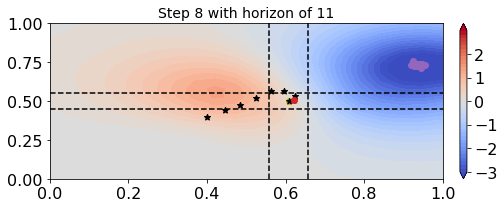

  2%|▏         | 1/50 [00:04<03:55,  4.81s/it]

x0:  [[0.6260824203491211, 0.5282270312309265]] , a:  [[[[[[[[[[[[[0.7409733533859253, 0.6817953586578369]], [[0.7430076599121094, 0.6134764552116394]], [[0.747617244720459, 0.6938095092773438]], [[0.7416394948959351, 0.6276960968971252]], [[0.7760988473892212, 0.697046160697937]]], [[[0.7008344531059265, 0.6475454568862915]], [[0.7455122470855713, 0.6404333114624023]], [[0.7883559465408325, 0.6682745218276978]], [[0.7918035984039307, 0.6639554500579834]], [[0.7706752419471741, 0.6759960055351257]]], [[[0.752585232257843, 0.6901242136955261]], [[0.7534241080284119, 0.6310614347457886]], [[0.7850436568260193, 0.6676596999168396]], [[0.7396688461303711, 0.6803498864173889]], [[0.776155948638916, 0.6838271617889404]]], [[[0.771857500076294, 0.677533745765686]], [[0.7889687418937683, 0.6463449597358704]], [[0.7704735398292542, 0.6522082686424255]], [[0.7499822974205017, 0.657470703125]], [[0.7576904296875, 0.6446765661239624]]], [[[0.7369771003723145, 0.6812441349029541]], [[0.775178194046

 22%|██▏       | 11/50 [00:52<03:04,  4.74s/it]

x0:  [[0.6255761384963989, 0.5149416327476501]] , a:  [[[[[[[[[[[[[0.899978756904602, 0.8263571262359619]], [[0.9235775470733643, 0.7495505809783936]], [[0.9224469661712646, 0.8283311724662781]], [[0.9268385767936707, 0.7874495387077332]], [[0.9236645698547363, 0.8161056041717529]]], [[[0.8989784717559814, 0.8117626309394836]], [[0.9245809316635132, 0.7781255841255188]], [[0.9477841854095459, 0.8063942193984985]], [[0.9510895013809204, 0.7915797829627991]], [[0.9395059943199158, 0.8131383061408997]]], [[[0.9294754266738892, 0.8301593065261841]], [[0.9332908391952515, 0.7708653211593628]], [[0.9450161457061768, 0.7810404300689697]], [[0.9098744988441467, 0.8152946829795837]], [[0.9461497068405151, 0.8026826977729797]]], [[[0.939947247505188, 0.8146479725837708]], [[0.95206618309021, 0.7776216268539429]], [[0.9389153122901917, 0.8007683753967285]], [[0.929786741733551, 0.8051608800888062]], [[0.933627724647522, 0.7945702075958252]]], [[[0.920305073261261, 0.8257623910903931]], [[0.941245

 42%|████▏     | 21/50 [01:39<02:14,  4.65s/it]

x0:  [[0.6232848167419434, 0.5014186501502991]] , a:  [[[[[[[[[[[[[0.9374783039093018, 0.8281898498535156]], [[0.969963788986206, 0.7638030648231506]], [[0.9590245485305786, 0.8083818554878235]], [[0.9742859601974487, 0.7980545163154602]], [[0.9501957297325134, 0.7767202854156494]]], [[[0.9569875001907349, 0.826056182384491]], [[0.966904878616333, 0.7926678657531738]], [[0.9697076082229614, 0.7725862860679626]], [[0.9761497378349304, 0.7629548907279968]], [[0.9688510894775391, 0.7917602062225342]]], [[[0.9693899154663086, 0.8139858841896057]], [[0.9759521484375, 0.7743369340896606]], [[0.9735672473907471, 0.7435169816017151]], [[0.9482296109199524, 0.8027759194374084]], [[0.9744241237640381, 0.781637966632843]]], [[[0.9708629250526428, 0.7825480103492737]], [[0.9752697348594666, 0.7716552019119263]], [[0.9732376337051392, 0.7816901803016663]], [[0.9710978269577026, 0.802021861076355]], [[0.9731338024139404, 0.7834488749504089]]], [[[0.9650946259498596, 0.8176307678222656]], [[0.9674557

 62%|██████▏   | 31/50 [02:26<01:27,  4.62s/it]

x0:  [[0.6242548823356628, 0.48639464378356934]] , a:  [[[[[[[[[[[[[0.9233410358428955, 0.7630058526992798]], [[0.9707570672035217, 0.7271535992622375]], [[0.9460639357566833, 0.7339081764221191]], [[0.9710484743118286, 0.7579580545425415]], [[0.9339819550514221, 0.7132417559623718]]], [[[0.9592007398605347, 0.7754979729652405]], [[0.9623000621795654, 0.7613143920898438]], [[0.9536481499671936, 0.6878327131271362]], [[0.9586377143859863, 0.7099217772483826]], [[0.9527078866958618, 0.724513828754425]]], [[[0.957804799079895, 0.7398088574409485]], [[0.968846321105957, 0.7432340979576111]], [[0.9573900699615479, 0.667452335357666]], [[0.9361562728881836, 0.7519994974136353]], [[0.9501883387565613, 0.7157289385795593]]], [[[0.9556788206100464, 0.6953262090682983]], [[0.9572875499725342, 0.7192093729972839]], [[0.9637249708175659, 0.7056224346160889]], [[0.9627350568771362, 0.7529383897781372]], [[0.9656751155853271, 0.7265969514846802]]], [[[0.9564915895462036, 0.7435960173606873]], [[0.94

 82%|████████▏ | 41/50 [03:12<00:41,  4.61s/it]

x0:  [[0.6261083483695984, 0.4789864718914032]] , a:  [[[[[[[[[[[[[0.9117498397827148, 0.7143959403038025]], [[0.9573115706443787, 0.687263548374176]], [[0.9357300996780396, 0.6897121071815491]], [[0.9512168169021606, 0.7138230204582214]], [[0.9391978979110718, 0.7072877883911133]]], [[[0.9460046887397766, 0.7256096601486206]], [[0.9555246829986572, 0.7234302163124084]], [[0.9572704434394836, 0.682172954082489]], [[0.9463164210319519, 0.696896493434906]], [[0.9412989020347595, 0.690877377986908]]], [[[0.9407342076301575, 0.6883028149604797]], [[0.9497266411781311, 0.7146561741828918]], [[0.9572824239730835, 0.6708316802978516]], [[0.9281156659126282, 0.7144197821617126]], [[0.939420759677887, 0.6874526739120483]]], [[[0.9532829523086548, 0.6774942874908447]], [[0.941236138343811, 0.6944906711578369]], [[0.9572296142578125, 0.6725293397903442]], [[0.941830039024353, 0.707368016242981]], [[0.9501490592956543, 0.6959853172302246]]], [[[0.9408109188079834, 0.6901000142097473]], [[0.9429880

100%|██████████| 50/50 [03:57<00:00,  4.75s/it]


Current optimal loss 0.014714221710001193;optimal action: tensor([[0.6431, 0.4883]], grad_fn=<AddBackward0>)


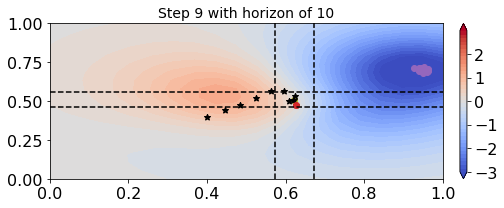

  2%|▏         | 1/50 [00:04<03:23,  4.16s/it]

x0:  [[0.6446088552474976, 0.47904807329177856]] , a:  [[[[[[[[[[[[0.7740129232406616, 0.5920745730400085]], [[0.7744042873382568, 0.5802779793739319]], [[0.7335055470466614, 0.5846334099769592]], [[0.7554326057434082, 0.579119086265564]], [[0.7334246635437012, 0.6012997031211853]]], [[[0.7883294820785522, 0.6079584360122681]], [[0.7815711498260498, 0.594664990901947]], [[0.756905198097229, 0.5990564823150635]], [[0.7742048501968384, 0.5801776051521301]], [[0.7061047554016113, 0.5898845195770264]]], [[[0.7670880556106567, 0.6019333004951477]], [[0.771868109703064, 0.5607511401176453]], [[0.7595308423042297, 0.6188934445381165]], [[0.7929137945175171, 0.622272789478302]], [[0.7552761435508728, 0.5980188250541687]]], [[[0.802883505821228, 0.5815432071685791]], [[0.7643001079559326, 0.5804559588432312]], [[0.7408157587051392, 0.53770911693573]], [[0.7332201600074768, 0.6035993099212646]], [[0.7449427247047424, 0.5957766175270081]]], [[[0.763788640499115, 0.5724326968193054]], [[0.76300472

 22%|██▏       | 11/50 [00:46<02:43,  4.19s/it]

x0:  [[0.6549980640411377, 0.4856315851211548]] , a:  [[[[[[[[[[[[0.9418798089027405, 0.7632315158843994]], [[0.9465951323509216, 0.7541540861129761]], [[0.9158530235290527, 0.7625772356987]], [[0.9312295317649841, 0.7610281705856323]], [[0.9177480340003967, 0.774009108543396]]], [[[0.9537613391876221, 0.7728350162506104]], [[0.948165237903595, 0.7674854397773743]], [[0.9266088008880615, 0.7691569328308105]], [[0.9396634101867676, 0.7595551609992981]], [[0.8893691897392273, 0.760063886642456]]], [[[0.9383223652839661, 0.7709330916404724]], [[0.9378170967102051, 0.7183898091316223]], [[0.9291443824768066, 0.7839229702949524]], [[0.9492647647857666, 0.7833033204078674]], [[0.9326200485229492, 0.7699117660522461]]], [[[0.9592834115028381, 0.7536507844924927]], [[0.9366172552108765, 0.7607529759407043]], [[0.9234140515327454, 0.7377081513404846]], [[0.9052775502204895, 0.773987889289856]], [[0.9254658818244934, 0.772057831287384]]], [[[0.9390165209770203, 0.7531198859214783]], [[0.92477095

 42%|████▏     | 21/50 [01:27<02:01,  4.17s/it]

x0:  [[0.6507137417793274, 0.46722084283828735]] , a:  [[[[[[[[[[[[0.9751037955284119, 0.7848118543624878]], [[0.984978437423706, 0.7895769476890564]], [[0.9564127326011658, 0.794641375541687]], [[0.9676827788352966, 0.7940133810043335]], [[0.9637832641601562, 0.8014886379241943]]], [[[0.9814934134483337, 0.7901540398597717]], [[0.9783134460449219, 0.7949708104133606]], [[0.9594873189926147, 0.7910553812980652]], [[0.9687216877937317, 0.7867106795310974]], [[0.9484653472900391, 0.7997890710830688]]], [[[0.9713136553764343, 0.7910071611404419]], [[0.9816320538520813, 0.7467392086982727]], [[0.9587680697441101, 0.8005984425544739]], [[0.9667943120002747, 0.7911142706871033]], [[0.9723368287086487, 0.7973540425300598]]], [[[0.9842022657394409, 0.7718847393989563]], [[0.9750000834465027, 0.7927058339118958]], [[0.9666789174079895, 0.7833489179611206]], [[0.9464755654335022, 0.7975152134895325]], [[0.9662914872169495, 0.7991341948509216]]], [[[0.9785192608833313, 0.7829312086105347]], [[0.9

 62%|██████▏   | 31/50 [02:11<01:21,  4.27s/it]

x0:  [[0.6403253078460693, 0.44925743341445923]] , a:  [[[[[[[[[[[[0.9553645253181458, 0.7554906606674194]], [[0.9685704112052917, 0.772297739982605]], [[0.9421016573905945, 0.7751871347427368]], [[0.9494218826293945, 0.7726970911026001]], [[0.9525450468063354, 0.780510663986206]]], [[[0.9539059400558472, 0.7604461908340454]], [[0.9529280066490173, 0.7731610536575317]], [[0.941392183303833, 0.7648854851722717]], [[0.9469915628433228, 0.7578730583190918]], [[0.9458211064338684, 0.7912601828575134]]], [[[0.9497280120849609, 0.7620534300804138]], [[0.9711734056472778, 0.7241219878196716]], [[0.936625599861145, 0.7654529213905334]], [[0.9325495362281799, 0.7496348023414612]], [[0.9564934968948364, 0.7762051224708557]]], [[[0.9602192640304565, 0.7356849908828735]], [[0.9595932960510254, 0.7725684642791748]], [[0.9558501243591309, 0.7667651772499084]], [[0.9315894842147827, 0.7704015970230103]], [[0.951228141784668, 0.7747541069984436]]], [[[0.9633944034576416, 0.76216721534729]], [[0.947099

 82%|████████▏ | 41/50 [02:53<00:37,  4.16s/it]

x0:  [[0.6303426027297974, 0.44078147411346436]] , a:  [[[[[[[[[[[[0.9251804351806641, 0.7181418538093567]], [[0.9364038705825806, 0.7425096035003662]], [[0.9203956127166748, 0.7437767386436462]], [[0.9236572980880737, 0.7382174134254456]], [[0.9249841570854187, 0.748038113117218]]], [[[0.917769730091095, 0.7242960929870605]], [[0.914517343044281, 0.7428640723228455]], [[0.9179934859275818, 0.734332263469696]], [[0.9217771291732788, 0.7246996760368347]], [[0.9248957633972168, 0.7730896472930908]]], [[[0.9160036444664001, 0.7254182696342468]], [[0.9436032772064209, 0.6891315579414368]], [[0.9112452864646912, 0.7198558449745178]], [[0.9058818817138672, 0.7154650688171387]], [[0.9245504140853882, 0.7438133358955383]]], [[[0.9273056983947754, 0.7036989331245422]], [[0.9273205399513245, 0.7401272058486938]], [[0.9369173049926758, 0.7361176013946533]], [[0.9122540950775146, 0.7313497066497803]], [[0.9210342764854431, 0.7386832237243652]]], [[[0.9327400326728821, 0.7352819442749023]], [[0.916

100%|██████████| 50/50 [03:31<00:00,  4.23s/it]


Current optimal loss 0.14898972440570038;optimal action: tensor([[0.6462, 0.4501]], grad_fn=<AddBackward0>)


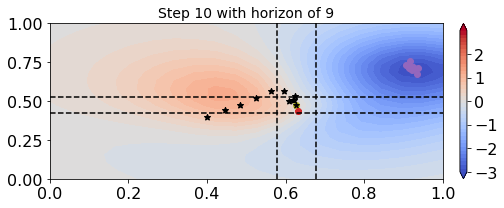

  2%|▏         | 1/50 [00:03<03:11,  3.91s/it]

x0:  [[0.6440744996070862, 0.4551072120666504]] , a:  [[[[[[[[[[[0.7578995227813721, 0.550438404083252]], [[0.7505518794059753, 0.5532518625259399]], [[0.7488670349121094, 0.5418872833251953]], [[0.7554515600204468, 0.5637818574905396]], [[0.7664918899536133, 0.589392900466919]]], [[[0.7996240854263306, 0.5787320733070374]], [[0.7287853956222534, 0.5588600039482117]], [[0.7586817741394043, 0.5390218496322632]], [[0.7688640356063843, 0.5873445868492126]], [[0.800129234790802, 0.5444479584693909]]], [[[0.7299864888191223, 0.5683203339576721]], [[0.7116084694862366, 0.5764121413230896]], [[0.702978253364563, 0.5382705926895142]], [[0.7379590272903442, 0.5481452941894531]], [[0.770135223865509, 0.5651655793190002]]], [[[0.7522143125534058, 0.5660297870635986]], [[0.7447082996368408, 0.5777313709259033]], [[0.7643138766288757, 0.5611810088157654]], [[0.7418080568313599, 0.5495995879173279]], [[0.7622652649879456, 0.5536927580833435]]], [[[0.7620137333869934, 0.5399566888809204]], [[0.732541

 22%|██▏       | 11/50 [00:42<02:32,  3.90s/it]

x0:  [[0.6570199728012085, 0.468476802110672]] , a:  [[[[[[[[[[[0.9180260896682739, 0.7225986123085022]], [[0.9028629660606384, 0.7215285897254944]], [[0.9116172790527344, 0.7166406512260437]], [[0.9163773059844971, 0.7314752340316772]], [[0.9209967851638794, 0.7450121641159058]]], [[[0.9418967366218567, 0.736419677734375]], [[0.9012643694877625, 0.7305760383605957]], [[0.9192157983779907, 0.7144842147827148]], [[0.9235425591468811, 0.7458340525627136]], [[0.9452782273292542, 0.7163935899734497]]], [[[0.8942334055900574, 0.7353336811065674]], [[0.8879262208938599, 0.7407115697860718]], [[0.8828262090682983, 0.7191370725631714]], [[0.907124936580658, 0.723173975944519]], [[0.9256411194801331, 0.7310830354690552]]], [[[0.913631021976471, 0.731165885925293]], [[0.9078209400177002, 0.7398197650909424]], [[0.9189937114715576, 0.7279473543167114]], [[0.9076505899429321, 0.7217861413955688]], [[0.9217907786369324, 0.7248340845108032]]], [[[0.9239694476127625, 0.7169327139854431]], [[0.9002681

 42%|████▏     | 21/50 [01:19<01:46,  3.69s/it]

x0:  [[0.6544353365898132, 0.46815842390060425]] , a:  [[[[[[[[[[[0.9593597650527954, 0.7730399966239929]], [[0.9443691968917847, 0.7698614001274109]], [[0.9425676465034485, 0.7698946595191956]], [[0.9540635347366333, 0.7793516516685486]], [[0.9552088379859924, 0.7839248180389404]]], [[[0.9661176204681396, 0.7708150148391724]], [[0.9485844969749451, 0.7805542945861816]], [[0.9493245482444763, 0.7680981755256653]], [[0.9547927975654602, 0.7850942015647888]], [[0.9753517508506775, 0.7621932029724121]]], [[[0.9371991753578186, 0.7817572355270386]], [[0.9380564093589783, 0.7865815162658691]], [[0.9278528094291687, 0.777397096157074]], [[0.9514983892440796, 0.7772760987281799]], [[0.9601598978042603, 0.7745887041091919]]], [[[0.953675389289856, 0.7757576107978821]], [[0.9489147067070007, 0.7829899787902832]], [[0.9453124403953552, 0.7726010084152222]], [[0.9507349133491516, 0.7743395566940308]], [[0.9616817235946655, 0.7735527157783508]]], [[[0.9672784805297852, 0.7709591388702393]], [[0.94

 62%|██████▏   | 31/50 [01:57<01:10,  3.72s/it]

x0:  [[0.6454812288284302, 0.4622829556465149]] , a:  [[[[[[[[[[[0.9536665081977844, 0.772369384765625]], [[0.9387696981430054, 0.7686131596565247]], [[0.9219233989715576, 0.7685936689376831]], [[0.9440034627914429, 0.7768420577049255]], [[0.942060649394989, 0.7758278846740723]]], [[[0.9467957615852356, 0.7555893063545227]], [[0.9458121061325073, 0.7816559672355652]], [[0.9288213849067688, 0.7678931355476379]], [[0.9380633234977722, 0.7767258286476135]], [[0.9623491764068604, 0.7541159987449646]]], [[[0.9315417408943176, 0.778456449508667]], [[0.9367271661758423, 0.7854388356208801]], [[0.9143463373184204, 0.782438337802887]], [[0.9451084733009338, 0.7800844311714172]], [[0.948250412940979, 0.7683411240577698]]], [[[0.945085883140564, 0.7710886001586914]], [[0.9423652291297913, 0.7783420085906982]], [[0.9220342040061951, 0.7655751705169678]], [[0.9442133903503418, 0.7752714157104492]], [[0.9539567828178406, 0.7713597416877747]]], [[[0.9629042148590088, 0.7703244090080261]], [[0.9413644

 82%|████████▏ | 41/50 [02:34<00:33,  3.74s/it]

x0:  [[0.6326539516448975, 0.4528551697731018]] , a:  [[[[[[[[[[[0.927850067615509, 0.74998539686203]], [[0.912456214427948, 0.7451468110084534]], [[0.8962183594703674, 0.7413027882575989]], [[0.9135064482688904, 0.7507245540618896]], [[0.9095267653465271, 0.7463210821151733]]], [[[0.9116460680961609, 0.7217409610748291]], [[0.9224659204483032, 0.7617184519767761]], [[0.9034214615821838, 0.7425959706306458]], [[0.9026778936386108, 0.7476934194564819]], [[0.9293735027313232, 0.7230631709098816]]], [[[0.9060455560684204, 0.7525799870491028]], [[0.9147207736968994, 0.7629887461662292]], [[0.8929483294487, 0.7647792100906372]], [[0.9174835681915283, 0.7604452967643738]], [[0.916504442691803, 0.7397050261497498]]], [[[0.9166545271873474, 0.7448174357414246]], [[0.9165495038032532, 0.7515323162078857]], [[0.8942124843597412, 0.733460009098053]], [[0.9161856174468994, 0.753322958946228]], [[0.9262755513191223, 0.7471344470977783]]], [[[0.9379000067710876, 0.7461161613464355]], [[0.91708910465

100%|██████████| 50/50 [03:09<00:00,  3.78s/it]


Current optimal loss 0.1649265157051793;optimal action: tensor([[0.6399, 0.4584]], grad_fn=<AddBackward0>)


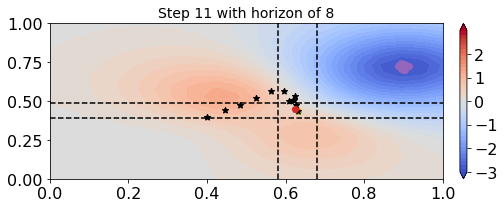

  2%|▏         | 1/50 [00:03<02:37,  3.22s/it]

x0:  [[0.6249260306358337, 0.46738970279693604]] , a:  [[[[[[[[[[0.7447652816772461, 0.5711551904678345]], [[0.7146707773208618, 0.5598688721656799]], [[0.7012839913368225, 0.5513399839401245]], [[0.754577100276947, 0.5687823295593262]], [[0.7193530797958374, 0.5604100823402405]]], [[[0.7350195646286011, 0.5861977934837341]], [[0.7316589951515198, 0.5696108341217041]], [[0.7019662857055664, 0.5767084360122681]], [[0.6870602369308472, 0.5439995527267456]], [[0.720689594745636, 0.5684967041015625]]], [[[0.7344797849655151, 0.5613037943840027]], [[0.7433132529258728, 0.594153642654419]], [[0.7465968132019043, 0.567244827747345]], [[0.7324903607368469, 0.5262256264686584]], [[0.6761372685432434, 0.5815738439559937]]], [[[0.6951726675033569, 0.5735492706298828]], [[0.689704179763794, 0.5405592918395996]], [[0.7121384143829346, 0.5473494529724121]], [[0.6972845196723938, 0.5496023297309875]], [[0.7174993753433228, 0.5892727971076965]]], [[[0.7094336748123169, 0.5807483792304993]], [[0.711605

 22%|██▏       | 11/50 [00:35<02:04,  3.20s/it]

x0:  [[0.6410661339759827, 0.4787367284297943]] , a:  [[[[[[[[[[0.8893738985061646, 0.7195378541946411]], [[0.8714765906333923, 0.7134284377098083]], [[0.862838864326477, 0.7091691493988037]], [[0.893787682056427, 0.7174490690231323]], [[0.8729047775268555, 0.712770402431488]]], [[[0.881363570690155, 0.7287852168083191]], [[0.8815799355506897, 0.7191667556762695]], [[0.8611565828323364, 0.724767804145813]], [[0.8525018095970154, 0.705685555934906]], [[0.8721708655357361, 0.719098687171936]]], [[[0.8833936452865601, 0.7137355804443359]], [[0.8879801034927368, 0.7334468960762024]], [[0.8886232972145081, 0.7170644402503967]], [[0.881269097328186, 0.6925027370452881]], [[0.8441414833068848, 0.7286106944084167]]], [[[0.858697235584259, 0.7229240536689758]], [[0.8569208979606628, 0.7043362855911255]], [[0.8694347143173218, 0.706439733505249]], [[0.858966588973999, 0.708965539932251]], [[0.870100200176239, 0.7311270833015442]]], [[[0.8670951128005981, 0.7270770072937012]], [[0.867132842540741

 42%|████▏     | 21/50 [01:07<01:32,  3.21s/it]

x0:  [[0.6436015963554382, 0.47713160514831543]] , a:  [[[[[[[[[[0.9327607154846191, 0.7631121873855591]], [[0.9232131838798523, 0.7626321911811829]], [[0.9177121520042419, 0.7594663500785828]], [[0.9333025813102722, 0.7604515552520752]], [[0.9224475622177124, 0.7613124847412109]]], [[[0.925963819026947, 0.7674403190612793]], [[0.9279969930648804, 0.7643400430679321]], [[0.9143075346946716, 0.768195629119873]], [[0.9100866317749023, 0.7601508498191833]], [[0.920258641242981, 0.7639807462692261]]], [[[0.9285942912101746, 0.7615724205970764]], [[0.9303613901138306, 0.7711969614028931]], [[0.930734395980835, 0.7598609924316406]], [[0.9277041554450989, 0.7498821020126343]], [[0.9037081599235535, 0.7728146314620972]]], [[[0.9154875874519348, 0.7691816687583923]], [[0.9157665967941284, 0.7612642645835876]], [[0.921125054359436, 0.7572411894798279]], [[0.9129037261009216, 0.7614952921867371]], [[0.9183022975921631, 0.7716152667999268]]], [[[0.9186142086982727, 0.7699941992759705]], [[0.917127

 62%|██████▏   | 31/50 [01:40<01:02,  3.29s/it]

x0:  [[0.6395337581634521, 0.469005286693573]] , a:  [[[[[[[[[[0.9364446401596069, 0.7614208459854126]], [[0.9310157299041748, 0.7654983401298523]], [[0.927340030670166, 0.7626579999923706]], [[0.9352755546569824, 0.7583098411560059]], [[0.9296146035194397, 0.7632172107696533]]], [[[0.9298384785652161, 0.7635962963104248]], [[0.933154284954071, 0.7645263671875]], [[0.9228388667106628, 0.7688580751419067]], [[0.9207994341850281, 0.7654703259468079]], [[0.927104115486145, 0.7639486789703369]]], [[[0.9324693083763123, 0.7632023692131042]], [[0.9330155849456787, 0.7670533657073975]], [[0.93410325050354, 0.7576963305473328]], [[0.9339052438735962, 0.7548884749412537]], [[0.915431797504425, 0.7738415598869324]]], [[[0.925710916519165, 0.7710055112838745]], [[0.9268941283226013, 0.767083466053009]], [[0.929307222366333, 0.7601256966590881]], [[0.9217740297317505, 0.7661736011505127]], [[0.9240481853485107, 0.770208477973938]]], [[[0.9262537956237793, 0.7699452638626099]], [[0.923862874507904,

 82%|████████▏ | 41/50 [02:14<00:30,  3.36s/it]

x0:  [[0.6317927837371826, 0.4557061791419983]] , a:  [[[[[[[[[[0.9234647750854492, 0.7387450933456421]], [[0.921172559261322, 0.7473733425140381]], [[0.9191264510154724, 0.7456241846084595]], [[0.9219338893890381, 0.7353450655937195]], [[0.9200124144554138, 0.7439412474632263]]], [[[0.9167436361312866, 0.7396159768104553]], [[0.9217380881309509, 0.7436184287071228]], [[0.9135051965713501, 0.7509403228759766]], [[0.9133642911911011, 0.7499142289161682]], [[0.9174299240112305, 0.7434405088424683]]], [[[0.9191281795501709, 0.7439904808998108]], [[0.9190221428871155, 0.7424096465110779]], [[0.9213151931762695, 0.7351908087730408]], [[0.924301266670227, 0.7369266748428345]], [[0.9083594083786011, 0.7552766799926758]]], [[[0.917573094367981, 0.7532968521118164]], [[0.9194765686988831, 0.7504168748855591]], [[0.9202263951301575, 0.7422443628311157]], [[0.9129601716995239, 0.7502530813217163]], [[0.9128127098083496, 0.7494487166404724]]], [[[0.9163089394569397, 0.7505131363868713]], [[0.91327

100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


Current optimal loss 0.18553762806179447;optimal action: tensor([[0.6383, 0.4562]], grad_fn=<AddBackward0>)


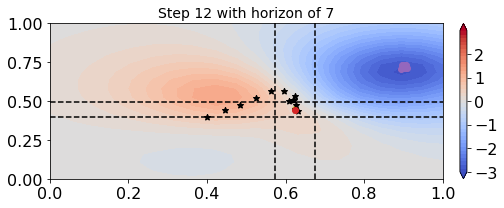

  2%|▏         | 1/50 [00:02<02:07,  2.59s/it]

x0:  [[0.6331272721290588, 0.46132782101631165]] , a:  [[[[[[[[[0.7323404550552368, 0.5395846962928772]], [[0.7112228870391846, 0.513654351234436]], [[0.6956732869148254, 0.5223742723464966]], [[0.7051583528518677, 0.5392105579376221]], [[0.7023721933364868, 0.544727623462677]]], [[[0.7275612950325012, 0.552788496017456]], [[0.7202638983726501, 0.5123976469039917]], [[0.7045331001281738, 0.5827802419662476]], [[0.7342269420623779, 0.5319148898124695]], [[0.7243247628211975, 0.5389423370361328]]], [[[0.6884323358535767, 0.5472237467765808]], [[0.722172737121582, 0.5249469876289368]], [[0.7317346930503845, 0.5512421727180481]], [[0.7164275050163269, 0.5661308169364929]], [[0.7063290476799011, 0.5487216114997864]]], [[[0.7286903262138367, 0.5246744155883789]], [[0.729664146900177, 0.5234951972961426]], [[0.7022425532341003, 0.5503745675086975]], [[0.7072649598121643, 0.5631405711174011]], [[0.7495440244674683, 0.5599212646484375]]], [[[0.7018184661865234, 0.5496305823326111]], [[0.7248136

 22%|██▏       | 11/50 [00:31<01:50,  2.82s/it]

x0:  [[0.6494662761688232, 0.4762016534805298]] , a:  [[[[[[[[[0.8651819229125977, 0.6834230422973633]], [[0.8527907133102417, 0.6665263175964355]], [[0.8428906202316284, 0.6663948893547058]], [[0.8487871289253235, 0.682968258857727]], [[0.8472784161567688, 0.6869970560073853]]], [[[0.8624224662780762, 0.6913489103317261]], [[0.8594814538955688, 0.6656884551048279]], [[0.8462346196174622, 0.708927571773529]], [[0.8680835366249084, 0.677727997303009]], [[0.8622088432312012, 0.6822789311408997]]], [[[0.8372762799263, 0.6891237497329712]], [[0.8604927062988281, 0.6724396347999573]], [[0.8645248413085938, 0.6892448663711548]], [[0.8538150787353516, 0.698668897151947]], [[0.8499804139137268, 0.6890662908554077]]], [[[0.8644943237304688, 0.6740098595619202]], [[0.8653162121772766, 0.6721706986427307]], [[0.8459873199462891, 0.6902881860733032]], [[0.8487067818641663, 0.6982816457748413]], [[0.8770555257797241, 0.6942864656448364]]], [[[0.8460625410079956, 0.6894533038139343]], [[0.8594883084

 42%|████▏     | 21/50 [00:58<01:19,  2.75s/it]

x0:  [[0.6510648131370544, 0.47821739315986633]] , a:  [[[[[[[[[0.9069557785987854, 0.7360819578170776]], [[0.9023674130439758, 0.725670337677002]], [[0.8967514038085938, 0.7259708046913147]], [[0.8989818096160889, 0.7361366748809814]], [[0.8989002108573914, 0.7381040453910828]]], [[[0.905018150806427, 0.7404577136039734]], [[0.907180666923523, 0.7253307104110718]], [[0.8936874866485596, 0.7511327862739563]], [[0.9110915660858154, 0.7331088781356812]], [[0.908372700214386, 0.7337968349456787]]], [[[0.8907533288002014, 0.7414290308952332]], [[0.9068116545677185, 0.7278100252151489]], [[0.9066423177719116, 0.7388848662376404]], [[0.8995054364204407, 0.7449616193771362]], [[0.9002538919448853, 0.7385987639427185]]], [[[0.9084529280662537, 0.7325173616409302]], [[0.9096693992614746, 0.7272738218307495]], [[0.8952112793922424, 0.7412338852882385]], [[0.8973024487495422, 0.7452613711357117]], [[0.916252851486206, 0.7403151988983154]]], [[[0.8953749537467957, 0.7403865456581116]], [[0.9032845

 62%|██████▏   | 31/50 [01:26<00:51,  2.74s/it]

x0:  [[0.6463092565536499, 0.4748500883579254]] , a:  [[[[[[[[[0.9125427007675171, 0.7477414011955261]], [[0.9123454689979553, 0.7396783232688904]], [[0.9077197313308716, 0.7422568798065186]], [[0.9086546897888184, 0.7482959628105164]], [[0.9094883799552917, 0.7489274144172668]]], [[[0.9106815457344055, 0.7512756586074829]], [[0.9165514707565308, 0.7395422458648682]], [[0.9015095233917236, 0.7591356039047241]], [[0.9176769852638245, 0.7458006143569946]], [[0.9167241454124451, 0.7445200681686401]]], [[[0.9013034105300903, 0.7532683610916138]], [[0.9153633117675781, 0.7400833964347839]], [[0.9124995470046997, 0.7496321797370911]], [[0.9077664017677307, 0.7538163065910339]], [[0.9102458953857422, 0.7488089799880981]]], [[[0.9146533608436584, 0.7468963861465454]], [[0.9172422289848328, 0.7394231557846069]], [[0.904139518737793, 0.7527401447296143]], [[0.9058484435081482, 0.7550742030143738]], [[0.9209566712379456, 0.7489559650421143]]], [[[0.9041268229484558, 0.7519682049751282]], [[0.9100

 82%|████████▏ | 41/50 [01:55<00:25,  2.84s/it]

x0:  [[0.6372690200805664, 0.4675822854042053]] , a:  [[[[[[[[[0.9028892517089844, 0.742283046245575]], [[0.9061212539672852, 0.7352221608161926]], [[0.9013230204582214, 0.7400636672973633]], [[0.9015445113182068, 0.743374764919281]], [[0.9030882716178894, 0.7429861426353455]]], [[[0.9007469415664673, 0.74610435962677]], [[0.9103012084960938, 0.7350906729698181]], [[0.8928776383399963, 0.7525875568389893]], [[0.9091445207595825, 0.7404810190200806]], [[0.9095646142959595, 0.7379488945007324]]], [[[0.894054114818573, 0.7485612034797668]], [[0.9085144996643066, 0.7343885898590088]], [[0.9033284783363342, 0.7438012957572937]], [[0.9000787138938904, 0.7461321353912354]], [[0.9035955667495728, 0.7425872087478638]]], [[[0.9050909876823425, 0.7430946230888367]], [[0.9097472429275513, 0.7337384223937988]], [[0.8965274691581726, 0.7479426264762878]], [[0.8974352478981018, 0.7494020462036133]], [[0.9110146164894104, 0.7415105700492859]]], [[[0.8960535526275635, 0.7471728920936584]], [[0.90088254

100%|██████████| 50/50 [02:20<00:00,  2.81s/it]


Current optimal loss 0.12187991759271634;optimal action: tensor([[0.6411, 0.4701]], grad_fn=<AddBackward0>)


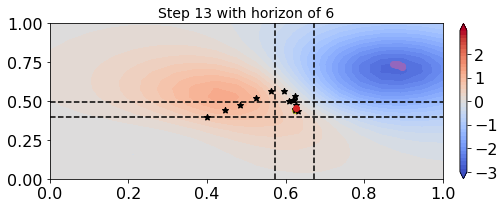

  2%|▏         | 1/50 [00:02<01:48,  2.21s/it]

x0:  [[0.6361334323883057, 0.46576833724975586]] , a:  [[[[[[[[0.693548858165741, 0.5287544131278992]], [[0.677770733833313, 0.4990774393081665]], [[0.7077808380126953, 0.5603064298629761]], [[0.7065999507904053, 0.5356994271278381]], [[0.6709870100021362, 0.5327655076980591]]], [[[0.6899628043174744, 0.5330245494842529]], [[0.6864085793495178, 0.5499250888824463]], [[0.7085511684417725, 0.5472546219825745]], [[0.6946748495101929, 0.548840343952179]], [[0.693688154220581, 0.5369309782981873]]], [[[0.6879762411117554, 0.5253397226333618]], [[0.6820279955863953, 0.5370838642120361]], [[0.7158615589141846, 0.5159866809844971]], [[0.7241937518119812, 0.5564079880714417]], [[0.7192783355712891, 0.5598891973495483]]], [[[0.7280845642089844, 0.545434832572937]], [[0.6878538131713867, 0.5196512937545776]], [[0.6741427183151245, 0.5508282780647278]], [[0.7074534296989441, 0.5342254042625427]], [[0.6842067241668701, 0.5549187064170837]]], [[[0.6801533102989197, 0.530417799949646]], [[0.696180641

 22%|██▏       | 11/50 [00:25<01:29,  2.29s/it]

x0:  [[0.6530434489250183, 0.48401468992233276]] , a:  [[[[[[[[0.8212103247642517, 0.6611394882202148]], [[0.8131886720657349, 0.6421863436698914]], [[0.8310636281967163, 0.6780012845993042]], [[0.8315089344978333, 0.664029061794281]], [[0.8083401322364807, 0.6630923748016357]]], [[[0.8189229369163513, 0.66441410779953]], [[0.8169113397598267, 0.6736961007118225]], [[0.8312497735023499, 0.6710960865020752]], [[0.8229306936264038, 0.673039972782135]], [[0.8232057094573975, 0.6652523279190063]]], [[[0.8183559775352478, 0.6595103144645691]], [[0.8151116967201233, 0.6656713485717773]], [[0.8380353450775146, 0.6516216993331909]], [[0.8419110178947449, 0.6770738959312439]], [[0.8386260867118835, 0.6791711449623108]]], [[[0.8436731100082397, 0.6697890162467957]], [[0.8187163472175598, 0.6549925208091736]], [[0.809052586555481, 0.6745086312294006]], [[0.8311058282852173, 0.6624113321304321]], [[0.816544234752655, 0.6772738099098206]]], [[[0.8134845495223999, 0.6617525815963745]], [[0.822075605

 42%|████▏     | 21/50 [00:48<01:07,  2.32s/it]

x0:  [[0.6562403440475464, 0.4867280125617981]] , a:  [[[[[[[[0.8683983683586121, 0.7118415236473083]], [[0.8671964406967163, 0.7014822363853455]], [[0.8751958012580872, 0.7179352045059204]], [[0.8765233755111694, 0.7117757201194763]], [[0.8637537956237793, 0.7144224643707275]]], [[[0.8666694760322571, 0.7144381999969482]], [[0.8663941025733948, 0.7176325917243958]], [[0.8755486607551575, 0.7148225903511047]], [[0.8705366253852844, 0.7180536389350891]], [[0.8724551796913147, 0.7148248553276062]]], [[[0.8670136332511902, 0.7116384506225586]], [[0.8663392066955566, 0.7138748168945312]], [[0.881516695022583, 0.7043692469596863]], [[0.8823307752609253, 0.7195991277694702]], [[0.8801587820053101, 0.7220887541770935]]], [[[0.8820909857749939, 0.7154402732849121]], [[0.8701706528663635, 0.7081402540206909]], [[0.8618835210800171, 0.7179132699966431]], [[0.8763114809989929, 0.7117224931716919]], [[0.8677020072937012, 0.7218807935714722]]], [[[0.8651710152626038, 0.7132255434989929]], [[0.86851

 62%|██████▏   | 31/50 [01:12<00:44,  2.33s/it]

x0:  [[0.6537638306617737, 0.4814988374710083]] , a:  [[[[[[[[0.8793867826461792, 0.7226522564888]], [[0.8819640278816223, 0.7151436805725098]], [[0.8862298727035522, 0.7236410975456238]], [[0.8874662518501282, 0.721772313117981]], [[0.8793203234672546, 0.7259647846221924]]], [[[0.8778201341629028, 0.7250741720199585]], [[0.8797140121459961, 0.7253485918045044]], [[0.8866197466850281, 0.7220209836959839]], [[0.8826876282691956, 0.7268785834312439]], [[0.8853455781936646, 0.7256154417991638]]], [[[0.8784750699996948, 0.7230106592178345]], [[0.8800897002220154, 0.7232690453529358]], [[0.8921220302581787, 0.7152066230773926]], [[0.8912151455879211, 0.7274840474128723]], [[0.8898374438285828, 0.7302703857421875]]], [[[0.8891379237174988, 0.7248101830482483]], [[0.8842955231666565, 0.7195054292678833]], [[0.8768366575241089, 0.7245981097221375]], [[0.8874117136001587, 0.7223213315010071]], [[0.8814740180969238, 0.7307461500167847]]], [[[0.8777660727500916, 0.7247800230979919]], [[0.88072109

 82%|████████▏ | 41/50 [01:36<00:22,  2.54s/it]

x0:  [[0.647800087928772, 0.4709963798522949]] , a:  [[[[[[[[0.8753823041915894, 0.7168084979057312]], [[0.8812604546546936, 0.7101521492004395]], [[0.8839038014411926, 0.7145172953605652]], [[0.8844469785690308, 0.7156628966331482]], [[0.8785845041275024, 0.7207319736480713]]], [[[0.873719334602356, 0.7193923592567444]], [[0.8785051107406616, 0.7179979085922241]], [[0.8843047022819519, 0.7136237025260925]], [[0.8801833391189575, 0.7203193306922913]], [[0.8833693265914917, 0.7197710275650024]]], [[[0.874629557132721, 0.7174704074859619]], [[0.8788977265357971, 0.7166042327880859]], [[0.8897273540496826, 0.7082211375236511]], [[0.8869724869728088, 0.7205007076263428]], [[0.8863887190818787, 0.7234811782836914]]], [[[0.8830664753913879, 0.7186309099197388]], [[0.8834497332572937, 0.7136355042457581]], [[0.8765079975128174, 0.7157694101333618]], [[0.8843966722488403, 0.7163336277008057]], [[0.8798782229423523, 0.7244007587432861]]], [[[0.8741108179092407, 0.719556450843811]], [[0.87917107

100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


Current optimal loss 0.008367702465445671;optimal action: tensor([[0.6560, 0.4712]], grad_fn=<AddBackward0>)


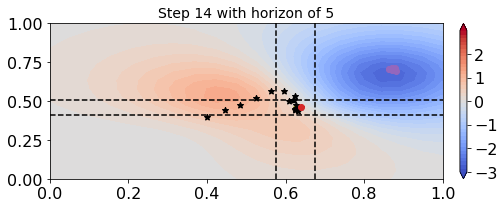

  2%|▏         | 1/50 [00:01<01:25,  1.75s/it]

x0:  [[0.642964780330658, 0.4778381288051605]] , a:  [[[[[[[0.7273737192153931, 0.5513378977775574]], [[0.7125898599624634, 0.5468458533287048]], [[0.7259664535522461, 0.5192752480506897]], [[0.718364953994751, 0.5037506222724915]], [[0.7175503373146057, 0.5337627530097961]]], [[[0.7232508063316345, 0.5382453203201294]], [[0.6967811584472656, 0.5413172245025635]], [[0.7116757035255432, 0.530474066734314]], [[0.7237690687179565, 0.5228786468505859]], [[0.6976813673973083, 0.5350169539451599]]], [[[0.7198658585548401, 0.5616469383239746]], [[0.6872845888137817, 0.5521901845932007]], [[0.7300106883049011, 0.5498952269554138]], [[0.7166407704353333, 0.5140551328659058]], [[0.7002059817314148, 0.5304912328720093]]], [[[0.7135373950004578, 0.5629357695579529]], [[0.6966614127159119, 0.5360961556434631]], [[0.7009439468383789, 0.5058302879333496]], [[0.707664966583252, 0.524345338344574]], [[0.6805936098098755, 0.5362285375595093]]], [[[0.7336198687553406, 0.5353541374206543]], [[0.7101802825

 22%|██▏       | 11/50 [00:19<01:10,  1.81s/it]

x0:  [[0.660552442073822, 0.49262237548828125]] , a:  [[[[[[[0.8265491127967834, 0.6504217386245728]], [[0.8161118030548096, 0.6492236852645874]], [[0.8250145316123962, 0.6291328072547913]], [[0.820663332939148, 0.621942400932312]], [[0.8201472759246826, 0.6415591835975647]]], [[[0.8238028287887573, 0.6421169638633728]], [[0.8070208430290222, 0.6467636823654175]], [[0.8166729211807251, 0.636778712272644]], [[0.8234518766403198, 0.6340665221214294]], [[0.8073530197143555, 0.6425560712814331]]], [[[0.8212965130805969, 0.6568225622177124]], [[0.8007428050041199, 0.6534627676010132]], [[0.8276734352111816, 0.6487827897071838]], [[0.8192926645278931, 0.6286142468452454]], [[0.8100557327270508, 0.6391598582267761]]], [[[0.8160734176635742, 0.6575623154640198]], [[0.8073227405548096, 0.6435806155204773]], [[0.8105613589286804, 0.6213483810424805]], [[0.8139512538909912, 0.63657546043396]], [[0.7962766289710999, 0.6432695984840393]]], [[[0.8300896286964417, 0.6389695405960083]], [[0.8146254420

 42%|████▏     | 21/50 [00:37<00:51,  1.77s/it]

x0:  [[0.6601513028144836, 0.4944778382778168]] , a:  [[[[[[[0.8583126068115234, 0.6802486181259155]], [[0.8502671718597412, 0.6887288689613342]], [[0.8574855327606201, 0.6672515869140625]], [[0.8527787327766418, 0.6732953786849976]], [[0.8538597822189331, 0.6822879910469055]]], [[[0.856433093547821, 0.6759890913963318]], [[0.8449713587760925, 0.6875780820846558]], [[0.8527235388755798, 0.6717681884765625]], [[0.8537509441375732, 0.6791138648986816]], [[0.8465175628662109, 0.6830146312713623]]], [[[0.8542056679725647, 0.683987021446228]], [[0.8416014909744263, 0.691089928150177]], [[0.8583234548568726, 0.6779792904853821]], [[0.851747989654541, 0.676875650882721]], [[0.8480483889579773, 0.6808775663375854]]], [[[0.8508633375167847, 0.6844067573547363]], [[0.8453782200813293, 0.6854594349861145]], [[0.8503201007843018, 0.6637738943099976]], [[0.8480871915817261, 0.6812363862991333]], [[0.8394705653190613, 0.6839268803596497]]], [[[0.860265851020813, 0.673827588558197]], [[0.849000096321

 62%|██████▏   | 31/50 [00:56<00:35,  1.86s/it]

x0:  [[0.6500054597854614, 0.49016261100769043]] , a:  [[[[[[[0.8600383996963501, 0.674737274646759]], [[0.8521875739097595, 0.6973444819450378]], [[0.859674334526062, 0.6650291085243225]], [[0.8531568050384521, 0.6868036389350891]], [[0.8561619520187378, 0.6896367073059082]]], [[[0.8585836291313171, 0.6722025871276855]], [[0.8485637903213501, 0.6965592503547668]], [[0.8562477827072144, 0.6678085327148438]], [[0.8535389304161072, 0.6897529363632202]], [[0.8513587713241577, 0.6900017857551575]]], [[[0.856610119342804, 0.677260160446167]], [[0.8464215397834778, 0.6984356641769409]], [[0.8597171306610107, 0.6716052293777466]], [[0.8522553443908691, 0.6888417601585388]], [[0.8520753979682922, 0.6886501312255859]]], [[[0.8544965386390686, 0.67752605676651]], [[0.848901629447937, 0.6949235200881958]], [[0.8552683591842651, 0.6630262732505798]], [[0.8493958711624146, 0.6914002895355225]], [[0.8460535407066345, 0.6910944581031799]]], [[[0.8613952398300171, 0.6709816455841064]], [[0.85103958845

 82%|████████▏ | 41/50 [01:14<00:16,  1.84s/it]

x0:  [[0.6365400552749634, 0.4812898635864258]] , a:  [[[[[[[0.8516706228256226, 0.6538059115409851]], [[0.8430050611495972, 0.6910936236381531]], [[0.8516480326652527, 0.6475695371627808]], [[0.8429913520812988, 0.682991087436676]], [[0.8477563261985779, 0.680512547492981]]], [[[0.8504422903060913, 0.651970386505127]], [[0.8403631448745728, 0.690534234046936]], [[0.84869384765625, 0.6494417786598206]], [[0.8432013988494873, 0.684565544128418]], [[0.8442527055740356, 0.68061763048172]]], [[[0.8486928939819336, 0.6557180881500244]], [[0.8387073278427124, 0.6915799975395203]], [[0.8512980937957764, 0.6521914005279541]], [[0.8421074748039246, 0.6841857433319092]], [[0.8444705009460449, 0.6797049641609192]]], [[[0.8473742008209229, 0.6558844447135925]], [[0.8406033515930176, 0.6891747117042542]], [[0.8483138680458069, 0.6461066007614136]], [[0.8397333025932312, 0.6860361099243164]], [[0.8397126197814941, 0.6818566918373108]]], [[[0.8527869582176208, 0.6513412594795227]], [[0.84205645322799

100%|██████████| 50/50 [01:31<00:00,  1.82s/it]


Current optimal loss -0.06207427242656753;optimal action: tensor([[0.6454, 0.4841]], grad_fn=<AddBackward0>)


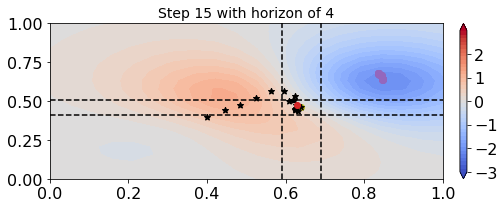

  2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

x0:  [[0.6324160099029541, 0.48500996828079224]] , a:  [[[[[[0.6864513158798218, 0.5223270654678345]], [[0.6869301795959473, 0.5354807376861572]], [[0.7026141285896301, 0.5239039063453674]], [[0.674102246761322, 0.5188652276992798]], [[0.6721322536468506, 0.5442129969596863]]], [[[0.6750454306602478, 0.5454565286636353]], [[0.7093813419342041, 0.541541337966919]], [[0.680086612701416, 0.5357981324195862]], [[0.6617457866668701, 0.5467953085899353]], [[0.6857759356498718, 0.5415806770324707]]], [[[0.6791638731956482, 0.5350261330604553]], [[0.710191547870636, 0.5330016613006592]], [[0.6913049817085266, 0.5189237594604492]], [[0.6713005304336548, 0.5238523483276367]], [[0.6885616779327393, 0.5549477338790894]]], [[[0.677505373954773, 0.5585977435112]], [[0.6957941055297852, 0.5185853838920593]], [[0.7018517255783081, 0.5309215784072876]], [[0.6823247075080872, 0.5605872273445129]], [[0.6894515156745911, 0.553566038608551]]], [[[0.6597877740859985, 0.5316893458366394]], [[0.68973112106323

 22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

x0:  [[0.6524621844291687, 0.5017827153205872]] , a:  [[[[[[0.7765191793441772, 0.6168947219848633]], [[0.7770301103591919, 0.6249780058860779]], [[0.7878851294517517, 0.616960883140564]], [[0.7691333889961243, 0.6150124073028564]], [[0.7679473757743835, 0.629860520362854]]], [[[0.7699455618858337, 0.6313297152519226]], [[0.7919081449508667, 0.6281954050064087]], [[0.7721801400184631, 0.6251883506774902]], [[0.7604084014892578, 0.632993221282959]], [[0.7768598794937134, 0.6278703808784485]]], [[[0.773097038269043, 0.6249558925628662]], [[0.7922418117523193, 0.6233978271484375]], [[0.7805317044258118, 0.6137643456459045]], [[0.7672010064125061, 0.6181358098983765]], [[0.7786640524864197, 0.6373410224914551]]], [[[0.7712244987487793, 0.6401274800300598]], [[0.783494770526886, 0.6142448782920837]], [[0.7873839139938354, 0.6213777661323547]], [[0.773908257484436, 0.6412339210510254]], [[0.7786433696746826, 0.6362163424491882]]], [[[0.7604407072067261, 0.6235742568969727]], [[0.778772532939

 42%|████▏     | 21/50 [00:29<00:39,  1.36s/it]

x0:  [[0.6592490077018738, 0.504164457321167]] , a:  [[[[[[0.8133134245872498, 0.6559267640113831]], [[0.814620316028595, 0.6599612236022949]], [[0.8211472630500793, 0.6514095067977905]], [[0.8087964653968811, 0.6553469896316528]], [[0.8092586994171143, 0.6619566679000854]]], [[[0.8094059228897095, 0.6635782718658447]], [[0.8235214948654175, 0.6614608764648438]], [[0.8114969730377197, 0.6564549803733826]], [[0.8031917214393616, 0.6649346351623535]], [[0.8146991729736328, 0.6603086590766907]]], [[[0.8117889761924744, 0.660443902015686]], [[0.823476254940033, 0.6592592000961304]], [[0.8168980479240417, 0.6499425172805786]], [[0.8075919151306152, 0.6571112275123596]], [[0.8153287172317505, 0.6657852530479431]]], [[[0.8100862503051758, 0.6684150099754333]], [[0.8187099695205688, 0.6548504829406738]], [[0.8207029700279236, 0.6537679433822632]], [[0.8107573986053467, 0.6688024401664734]], [[0.8151413202285767, 0.6651161313056946]]], [[[0.8045309782028198, 0.6600974202156067]], [[0.8155752420

 62%|██████▏   | 31/50 [00:43<00:25,  1.34s/it]

x0:  [[0.6592384576797485, 0.4990234375]] , a:  [[[[[[0.8247602581977844, 0.664862334728241]], [[0.8266949653625488, 0.6667386293411255]], [[0.8313103318214417, 0.6550309658050537]], [[0.8208824992179871, 0.6648113131523132]], [[0.822913646697998, 0.6672555208206177]]], [[[0.8219123482704163, 0.6696035265922546]], [[0.8327130675315857, 0.6677127480506897]], [[0.8246028423309326, 0.6583846807479858]], [[0.8171016573905945, 0.6704846024513245]], [[0.8268426656723022, 0.6658673286437988]]], [[[0.8238325715065002, 0.6677221655845642]], [[0.8324609994888306, 0.6667177081108093]], [[0.8285227417945862, 0.6542136669158936]], [[0.820177435874939, 0.6659521460533142]], [[0.8268765211105347, 0.669192373752594]]], [[[0.8225136399269104, 0.6724534630775452]], [[0.8294951319694519, 0.6642106175422668]], [[0.8308087587356567, 0.6563237309455872]], [[0.8218771815299988, 0.6726186871528625]], [[0.8268678784370422, 0.6688082814216614]]], [[[0.8190125226974487, 0.6676949262619019]], [[0.8272632360458374

 82%|████████▏ | 41/50 [00:56<00:11,  1.31s/it]

x0:  [[0.6554996371269226, 0.4872957468032837]] , a:  [[[[[[0.8257812857627869, 0.6585116982460022]], [[0.8281136155128479, 0.65896075963974]], [[0.8320772647857666, 0.6414662599563599]], [[0.8218033909797668, 0.65877366065979]], [[0.825099766254425, 0.6581280827522278]]], [[[0.8233732581138611, 0.6620174050331116]], [[0.8327252864837646, 0.6598310470581055]], [[0.8267618417739868, 0.6439054012298584]], [[0.819054901599884, 0.6626304388046265]], [[0.8283498883247375, 0.6569210290908813]]], [[[0.8250357508659363, 0.6605780124664307]], [[0.8323518633842468, 0.6593445539474487]], [[0.8300063610076904, 0.6408466100692749]], [[0.8214289546012878, 0.659591555595398]], [[0.8281022310256958, 0.6591670513153076]]], [[[0.8240476846694946, 0.663884162902832]], [[0.8302441239356995, 0.6575618982315063]], [[0.8314964771270752, 0.6421974897384644]], [[0.8225119709968567, 0.6640907526016235]], [[0.8282663822174072, 0.6589330434799194]]], [[[0.8213234543800354, 0.6606688499450684]], [[0.82844042778015

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


Current optimal loss -0.13279534353291547;optimal action: tensor([[0.6656, 0.4859]], grad_fn=<AddBackward0>)


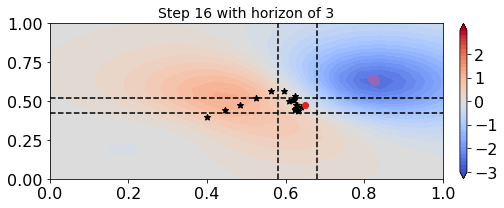

  2%|▏         | 1/50 [00:00<00:41,  1.17it/s]

x0:  [[0.6686025857925415, 0.4885841906070709]] , a:  [[[[[0.698781430721283, 0.5119322538375854]], [[0.7105640769004822, 0.5241468548774719]], [[0.6947801113128662, 0.5250555872917175]], [[0.7146959900856018, 0.5349498987197876]], [[0.6915011405944824, 0.5278553366661072]]], [[[0.71242755651474, 0.5190313458442688]], [[0.6915693283081055, 0.5301550030708313]], [[0.6921382546424866, 0.5384675860404968]], [[0.702042281627655, 0.5147032737731934]], [[0.6940985321998596, 0.5148955583572388]]], [[[0.69145667552948, 0.4980647563934326]], [[0.6992807388305664, 0.5335913300514221]], [[0.6974872946739197, 0.5218640565872192]], [[0.7067387104034424, 0.5139945149421692]], [[0.7089537382125854, 0.5346347093582153]]], [[[0.7023202180862427, 0.49669405817985535]], [[0.6877736449241638, 0.5401009321212769]], [[0.7122512459754944, 0.5182845592498779]], [[0.7094404697418213, 0.518399715423584]], [[0.6898549795150757, 0.520466685295105]]], [[[0.6945747137069702, 0.5014280080795288]], [[0.69312959909439

 22%|██▏       | 11/50 [00:09<00:35,  1.11it/s]

x0:  [[0.683684229850769, 0.5056201219558716]] , a:  [[[[[0.7706013321876526, 0.5880841016769409]], [[0.77604740858078, 0.5961286425590515]], [[0.7685068249702454, 0.5974016189575195]], [[0.781191349029541, 0.6038466691970825]], [[0.7656733989715576, 0.5998976230621338]]], [[[0.7798205614089966, 0.5931593179702759]], [[0.7643463611602783, 0.6011148691177368]], [[0.7666272521018982, 0.6060941815376282]], [[0.7728005647659302, 0.5914468765258789]], [[0.7681457996368408, 0.5912159085273743]]], [[[0.7664735317230225, 0.5795391798019409]], [[0.7689749598503113, 0.6031745672225952]], [[0.7704684734344482, 0.595228910446167]], [[0.7761489152908325, 0.5907542705535889]], [[0.776630699634552, 0.6039516925811768]]], [[[0.7737163305282593, 0.5785579085350037]], [[0.7615779638290405, 0.6073501110076904]], [[0.7796889543533325, 0.5935689806938171]], [[0.7771899700164795, 0.592876136302948]], [[0.764653742313385, 0.5951029062271118]]], [[[0.7688828706741333, 0.5819153189659119]], [[0.764385938644409

 42%|████▏     | 21/50 [00:18<00:25,  1.12it/s]

x0:  [[0.6880715489387512, 0.5109803080558777]] , a:  [[[[[0.8003867864608765, 0.6235029101371765]], [[0.7994289398193359, 0.6269353032112122]], [[0.799187958240509, 0.6275156736373901]], [[0.8065853118896484, 0.6309804320335388]], [[0.7978670597076416, 0.629178524017334]]], [[[0.8057336807250977, 0.6262319684028625]], [[0.7926344871520996, 0.6302655935287476]], [[0.7978003025054932, 0.6322539448738098]], [[0.8022041320800781, 0.6242484450340271]], [[0.7999776601791382, 0.6242235898971558]]], [[[0.7985366582870483, 0.6190314292907715]], [[0.7952287793159485, 0.6312238574028015]], [[0.800114095211029, 0.626902163028717]], [[0.8044983744621277, 0.6236312389373779]], [[0.8039841055870056, 0.6310416460037231]]], [[[0.8026400804519653, 0.6184449195861816]], [[0.7909421324729919, 0.6338013410568237]], [[0.8056319355964661, 0.6256978511810303]], [[0.8045637607574463, 0.6248201727867126]], [[0.7976822257041931, 0.6265673637390137]]], [[[0.7999302744865417, 0.6202196478843689]], [[0.79244655370

 62%|██████▏   | 31/50 [00:27<00:17,  1.10it/s]

x0:  [[0.6881769895553589, 0.5110577344894409]] , a:  [[[[[0.810022234916687, 0.6349939703941345]], [[0.8037604689598083, 0.6372871994972229]], [[0.8090031147003174, 0.6371209025382996]], [[0.8145455121994019, 0.6385677456855774]], [[0.8090424537658691, 0.637881875038147]]], [[[0.8135819435119629, 0.6367111802101135]], [[0.7992035746574402, 0.6395752429962158]], [[0.8078073859214783, 0.6399654150009155]], [[0.8119481801986694, 0.6342977285385132]], [[0.8107038736343384, 0.6347429752349854]]], [[[0.8090716004371643, 0.6323474645614624]], [[0.800883412361145, 0.6400748491287231]], [[0.8093304634094238, 0.637108325958252]], [[0.813679575920105, 0.6338218450546265]], [[0.8128749132156372, 0.6388894319534302]]], [[[0.8116761445999146, 0.6320319175720215]], [[0.7981430888175964, 0.6418732404708862]], [[0.8131033182144165, 0.6361623406410217]], [[0.8133790493011475, 0.6345981359481812]], [[0.8091720342636108, 0.6362578868865967]]], [[[0.8099831342697144, 0.633025586605072]], [[0.7991546988487

 82%|████████▏ | 41/50 [00:36<00:07,  1.15it/s]

x0:  [[0.6861190795898438, 0.5082499384880066]] , a:  [[[[[0.8116748929023743, 0.6366825103759766]], [[0.7988427877426147, 0.6390440464019775]], [[0.8103833794593811, 0.6383219957351685]], [[0.8156769871711731, 0.6381269097328186]], [[0.8116683959960938, 0.6382472515106201]]], [[[0.8144179582595825, 0.637999951839447]], [[0.7953997850418091, 0.6407803893089294]], [[0.809292197227478, 0.640253484249115]], [[0.8138437867164612, 0.6349664330482483]], [[0.813003659248352, 0.6359753012657166]]], [[[0.8110820055007935, 0.6348612904548645]], [[0.7966344952583313, 0.6410860419273376]], [[0.8104181289672852, 0.6384944915771484]], [[0.8152831196784973, 0.6346058249473572]], [[0.8144029974937439, 0.638933002948761]]], [[[0.8129788637161255, 0.6347082853317261]], [[0.7946966290473938, 0.6425113081932068]], [[0.8132991194725037, 0.637718677520752]], [[0.8148263096809387, 0.6351501941680908]], [[0.8118817806243896, 0.6370669007301331]]], [[[0.8117932081222534, 0.6353427767753601]], [[0.7954846024513

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Current optimal loss -0.5550947685310393;optimal action: tensor([[0.6994, 0.5157]], grad_fn=<AddBackward0>)


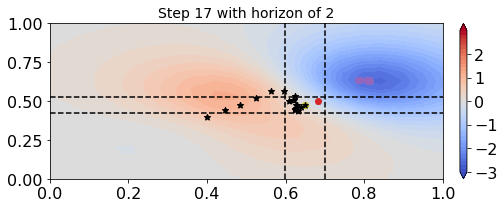

  2%|▏         | 1/50 [00:00<00:21,  2.24it/s]

x0:  [[0.6840375661849976, 0.5079259276390076]] , a:  [[[[0.7117593288421631, 0.5223159193992615]], [[0.6993261575698853, 0.5296325087547302]], [[0.7126632928848267, 0.5381807088851929]], [[0.7098875641822815, 0.5450623035430908]], [[0.7116976976394653, 0.5255926251411438]]], [[[0.6934314370155334, 0.534834086894989]], [[0.711727499961853, 0.529015839099884]], [[0.7136113047599792, 0.5389155745506287]], [[0.7005646824836731, 0.5465024709701538]], [[0.7003579139709473, 0.5286881923675537]]], [[[0.7085825204849243, 0.5229000449180603]], [[0.7025176286697388, 0.5367310643196106]], [[0.70204758644104, 0.5290601253509521]], [[0.6915469169616699, 0.5326160788536072]], [[0.7121899724006653, 0.5308745503425598]]], [[[0.7061246633529663, 0.5245361328125]], [[0.699054479598999, 0.5262008905410767]], [[0.7030447721481323, 0.5320507884025574]], [[0.7019859552383423, 0.537432849407196]], [[0.696397602558136, 0.5216812491416931]]], [[[0.7014563083648682, 0.535575270652771]], [[0.6905434131622314, 0.

 22%|██▏       | 11/50 [00:05<00:17,  2.20it/s]

x0:  [[0.7053298354148865, 0.5280522108078003]] , a:  [[[[0.7677021026611328, 0.5815922617912292]], [[0.7599304914474487, 0.5865240097045898]], [[0.7681707739830017, 0.591546893119812]], [[0.7661383748054504, 0.5957813262939453]], [[0.767565906047821, 0.5838170051574707]]], [[[0.7557480931282043, 0.5894107818603516]], [[0.767485499382019, 0.5860642790794373]], [[0.768708348274231, 0.5920161008834839]], [[0.7605663537979126, 0.5966679453849792]], [[0.7606119513511658, 0.5859686136245728]]], [[[0.7658399343490601, 0.5819968581199646]], [[0.7619756460189819, 0.5908286571502686]], [[0.761705219745636, 0.5852934122085571]], [[0.7545014023780823, 0.588045597076416]], [[0.7678323984146118, 0.5873266458511353]]], [[[0.7643433213233948, 0.583084225654602]], [[0.7597618699073792, 0.5842877626419067]], [[0.7623440027236938, 0.5874534249305725]], [[0.7614749073982239, 0.5911620855331421]], [[0.7579501271247864, 0.5811306834220886]]], [[[0.7613421082496643, 0.5897877216339111]], [[0.753744661808013

 42%|████▏     | 21/50 [00:09<00:13,  2.19it/s]

x0:  [[0.7148046493530273, 0.5352534055709839]] , a:  [[[[0.7903081178665161, 0.6031789779663086]], [[0.7856420874595642, 0.6062185168266296]], [[0.7904270887374878, 0.6086705923080444]], [[0.789463460445404, 0.6110706329345703]], [[0.790213942527771, 0.6046444773674011]]], [[[0.7829526662826538, 0.6081865429878235]], [[0.7902936935424805, 0.6058186292648315]], [[0.7907613515853882, 0.6089394688606262]], [[0.786025881767273, 0.6117655634880066]], [[0.7859247922897339, 0.606063723564148]]], [[[0.7891527414321899, 0.6034495830535889]], [[0.7868710160255432, 0.6088612079620361]], [[0.7864727973937988, 0.6050979495048523]], [[0.7823728919029236, 0.6066282987594604]], [[0.7903639078140259, 0.6067736148834229]]], [[[0.788224995136261, 0.6041333675384521]], [[0.7855527997016907, 0.6048566102981567]], [[0.7868502140045166, 0.6063616275787354]], [[0.7865984439849854, 0.6083449721336365]], [[0.7843407988548279, 0.6031925678253174]]], [[[0.7863524556159973, 0.6083472371101379]], [[0.7818992137908

 62%|██████▏   | 31/50 [00:14<00:08,  2.15it/s]

x0:  [[0.7175222039222717, 0.5356098413467407]] , a:  [[[[0.7965078353881836, 0.6055388450622559]], [[0.7931110262870789, 0.6077699065208435]], [[0.7964125275611877, 0.6086342930793762]], [[0.796083927154541, 0.6099694967269897]], [[0.7964342832565308, 0.606775164604187]]], [[[0.7909964919090271, 0.6095642447471619]], [[0.7966759204864502, 0.6073263883590698]], [[0.7966752052307129, 0.608788788318634]], [[0.7934321165084839, 0.6107214689254761]], [[0.793147623538971, 0.6079307794570923]]], [[[0.7956048250198364, 0.6057637333869934]], [[0.7940119504928589, 0.6097409725189209]], [[0.7934145331382751, 0.6065157055854797]], [[0.7907886505126953, 0.6072858572006226]], [[0.7965388298034668, 0.6082906723022461]]], [[[0.7948877811431885, 0.6062899827957153]], [[0.7930548191070557, 0.6067723035812378]], [[0.7936855554580688, 0.6073189377784729]], [[0.7938796281814575, 0.6082537174224854]], [[0.7920135855674744, 0.6059486865997314]]], [[[0.7934517860412598, 0.6095955967903137]], [[0.790426433086

 82%|████████▏ | 41/50 [00:18<00:04,  2.09it/s]

x0:  [[0.7176042795181274, 0.5331307649612427]] , a:  [[[[0.7965197563171387, 0.6003344058990479]], [[0.7937210202217102, 0.6020725965499878]], [[0.7962201833724976, 0.601371705532074]], [[0.7963709831237793, 0.6015104651451111]], [[0.7964489459991455, 0.6015151739120483]]], [[[0.7917705774307251, 0.6038877367973328]], [[0.7968571782112122, 0.6015282273292542]], [[0.7964541912078857, 0.6014010310173035]], [[0.7940217852592468, 0.6023927330970764]], [[0.7935604453086853, 0.6025529503822327]]], [[[0.7957122921943665, 0.600544810295105]], [[0.7944747805595398, 0.6035423278808594]], [[0.7936325669288635, 0.6005761027336121]], [[0.7918251156806946, 0.6006677150726318]], [[0.7965264916419983, 0.6025864481925964]]], [[[0.795076847076416, 0.600989043712616]], [[0.7936831712722778, 0.6013105511665344]], [[0.7938532829284668, 0.6010169982910156]], [[0.7944310903549194, 0.6009472012519836]], [[0.7926290035247803, 0.601158082485199]]], [[[0.7938076257705688, 0.6037718653678894]], [[0.7914997935295

100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Current optimal loss -0.9281065854969792;optimal action: tensor([[0.7343, 0.5436]], grad_fn=<AddBackward0>)


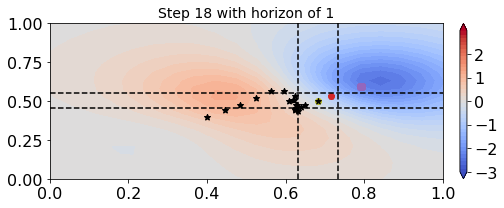

  4%|▍         | 2/50 [00:00<00:03, 12.85it/s]

x0:  [[0.721836507320404, 0.534420907497406]] , a:  [[[0.7436239719390869, 0.5405115485191345]], [[0.7354451417922974, 0.5436077117919922]], [[0.7405017614364624, 0.5491600036621094]], [[0.7327139973640442, 0.5410845279693604]], [[0.7326748371124268, 0.5428156852722168]]] , loss:  -0.9402801745179394


 24%|██▍       | 12/50 [00:01<00:03, 12.48it/s]

x0:  [[0.7425550818443298, 0.5553228855133057]] , a:  [[[0.7789856195449829, 0.5817878246307373]], [[0.7741411328315735, 0.5839061141014099]], [[0.7771855592727661, 0.5874307751655579]], [[0.7724075317382812, 0.5822113752365112]], [[0.7723782658576965, 0.5833867788314819]]] , loss:  -1.1734358609801085


 44%|████▍     | 22/50 [00:01<00:02, 13.25it/s]

x0:  [[0.752242386341095, 0.5647304654121399]] , a:  [[[0.7941166758537292, 0.6001955270767212]], [[0.7913215160369873, 0.601436197757721]], [[0.7930611968040466, 0.6034342050552368]], [[0.7903361916542053, 0.6004846692085266]], [[0.790314793586731, 0.601154625415802]]] , loss:  -1.2011341620568579


 64%|██████▍   | 32/50 [00:02<00:01, 13.13it/s]

x0:  [[0.7557799816131592, 0.5676151514053345]] , a:  [[[0.7994626760482788, 0.6059056520462036]], [[0.797497570514679, 0.6067655086517334]], [[0.7987013459205627, 0.6081017851829529]], [[0.7968310713768005, 0.6061476469039917]], [[0.7968140244483948, 0.6065923571586609]]] , loss:  -1.2020273800732517


 84%|████████▍ | 42/50 [00:03<00:00, 12.85it/s]

x0:  [[0.7570428252220154, 0.5680100321769714]] , a:  [[[0.8013160824775696, 0.6068273782730103]], [[0.7997081875801086, 0.6075210571289062]], [[0.8006773591041565, 0.6085135340690613]], [[0.7991818189620972, 0.6070706248283386]], [[0.7991664409637451, 0.6074072122573853]]] , loss:  -1.2018246025672885


100%|██████████| 50/50 [00:03<00:00, 12.57it/s]


Current optimal loss -1.3164966660636928;optimal action: tensor([[0.7758, 0.5818]], grad_fn=<AddBackward0>)


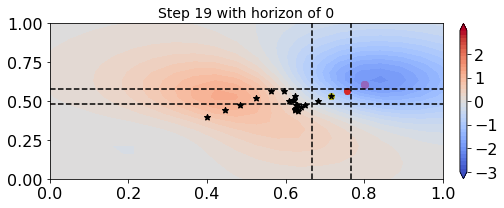

-------------------- Ground truth surface --------------------


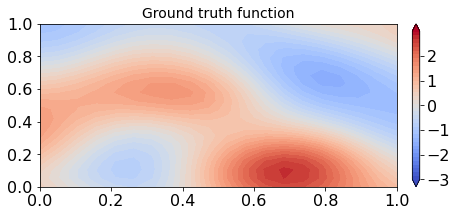

  2%|▏         | 1/50 [00:09<07:44,  9.47s/it]

x0:  [[0.4007406234741211, 0.42199158668518066]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.6520938277244568, 0.6966513991355896]], [[0.6971579790115356, 0.6597237586975098]], [[0.583552360534668, 0.6390715837478638]], [[0.6222200989723206, 0.6169485449790955]], [[0.6637628078460693, 0.6161702275276184]]], [[[0.5860346555709839, 0.6411522626876831]], [[0.6501670479774475, 0.7217361330986023]], [[0.6606025695800781, 0.6511513590812683]], [[0.6487876772880554, 0.6265832185745239]], [[0.6444835066795349, 0.6379108428955078]]], [[[0.6412107348442078, 0.6581361293792725]], [[0.6839619874954224, 0.6931886672973633]], [[0.6630378365516663, 0.61363285779953]], [[0.6691651344299316, 0.6691884994506836]], [[0.6195340752601624, 0.661422073841095]]], [[[0.6569726467132568, 0.6414897441864014]], [[0.6547750234603882, 0.6530827879905701]], [[0.6591819524765015, 0.6584030389785767]], [[0.5796006321907043, 0.7216611504554749]], [[0.6477809548377991, 0.7099192142486572]]], [[[0.6128506660461426, 0.6496409177780151]

 22%|██▏       | 11/50 [01:42<05:56,  9.15s/it]

x0:  [[0.4153609871864319, 0.43632447719573975]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.8185593485832214, 0.8187782168388367]], [[0.8451079726219177, 0.7431836128234863]], [[0.8226308226585388, 0.8636681437492371]], [[0.8505259156227112, 0.8386298418045044]], [[0.8208343982696533, 0.7533851861953735]]], [[[0.8057166337966919, 0.8508252501487732]], [[0.7744544744491577, 0.8311011791229248]], [[0.8404191136360168, 0.8037941455841064]], [[0.8678967952728271, 0.815298318862915]], [[0.8168749213218689, 0.8140082359313965]]], [[[0.8363024592399597, 0.8173160552978516]], [[0.8006080389022827, 0.7930726408958435]], [[0.878220796585083, 0.7943235039710999]], [[0.8403831124305725, 0.8060616850852966]], [[0.7721309661865234, 0.8537933826446533]]], [[[0.8398391008377075, 0.790493905544281]], [[0.8543667197227478, 0.839740514755249]], [[0.8412923812866211, 0.7324681282043457]], [[0.6963942050933838, 0.8969448804855347]], [[0.744924783706665, 0.8384310007095337]]], [[[0.8295732736587524, 0.7999335527420044]]

 42%|████▏     | 21/50 [03:15<04:28,  9.27s/it]

x0:  [[0.4250001907348633, 0.44212475419044495]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.8085723519325256, 0.8069773316383362]], [[0.8711739182472229, 0.770082950592041]], [[0.8076932430267334, 0.8387105464935303]], [[0.8148000836372375, 0.7838237881660461]], [[0.8175240755081177, 0.7363590598106384]]], [[[0.7583943605422974, 0.8356780409812927]], [[0.788886547088623, 0.8233335614204407]], [[0.8327669501304626, 0.7543477416038513]], [[0.8186002969741821, 0.7573005557060242]], [[0.7776832580566406, 0.8003840446472168]]], [[[0.8144991993904114, 0.8045322895050049]], [[0.8176199197769165, 0.821565568447113]], [[0.8369690179824829, 0.7348476648330688]], [[0.8286656737327576, 0.7957305908203125]], [[0.7438890933990479, 0.8376349806785583]]], [[[0.8212341070175171, 0.7957533001899719]], [[0.8079898953437805, 0.787479043006897]], [[0.8461232781410217, 0.6908795237541199]], [[0.7219656705856323, 0.8740750551223755]], [[0.7708037495613098, 0.8547709584236145]]], [[[0.8128066062927246, 0.7788273692131042]

 62%|██████▏   | 31/50 [04:49<03:01,  9.54s/it]

x0:  [[0.43227267265319824, 0.4447268843650818]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.837114691734314, 0.8234188556671143]], [[0.8649527430534363, 0.7649380564689636]], [[0.7877472043037415, 0.8134331107139587]], [[0.8400318622589111, 0.7944234609603882]], [[0.8602170944213867, 0.754580557346344]]], [[[0.7728739380836487, 0.8544299602508545]], [[0.8043907284736633, 0.8496683835983276]], [[0.8790863752365112, 0.7743681073188782]], [[0.8571022152900696, 0.8014011979103088]], [[0.8142912983894348, 0.8267168998718262]]], [[[0.8404744267463684, 0.8251959085464478]], [[0.8244551420211792, 0.8255870342254639]], [[0.8792048692703247, 0.7709493041038513]], [[0.8372983932495117, 0.8065537214279175]], [[0.7771421670913696, 0.8685188293457031]]], [[[0.8449358344078064, 0.825389564037323]], [[0.8457109332084656, 0.8293061852455139]], [[0.8945866823196411, 0.7143662571907043]], [[0.7599703073501587, 0.865646243095398]], [[0.7776650786399841, 0.8623098134994507]]], [[[0.846727728843689, 0.8043338656425476]]

 82%|████████▏ | 41/50 [06:20<01:22,  9.13s/it]

x0:  [[0.43688708543777466, 0.4459894001483917]] , a:  [[[[[[[[[[[[[[[[[[[[[[0.8426380753517151, 0.8164774179458618]], [[0.8695326447486877, 0.7849529981613159]], [[0.8185189962387085, 0.830403745174408]], [[0.8525683879852295, 0.7953901886940002]], [[0.8553801774978638, 0.7656593918800354]]], [[[0.7786931395530701, 0.8667066693305969]], [[0.8031235337257385, 0.8483710885047913]], [[0.8673146963119507, 0.7612850666046143]], [[0.8502351641654968, 0.7998816967010498]], [[0.8048344850540161, 0.8173803687095642]]], [[[0.8320539593696594, 0.8139820098876953]], [[0.8323641419410706, 0.8261768817901611]], [[0.8693557977676392, 0.7629492282867432]], [[0.8327001929283142, 0.8064082860946655]], [[0.7692439556121826, 0.8543335199356079]]], [[[0.8273894786834717, 0.8178148865699768]], [[0.8280922174453735, 0.8144009709358215]], [[0.8963921070098877, 0.7044047713279724]], [[0.7759935855865479, 0.8571199774742126]], [[0.7875211238861084, 0.8607339859008789]]], [[[0.8330658674240112, 0.78719747066497

100%|██████████| 50/50 [07:45<00:00,  9.30s/it]


Current optimal loss 1.0407111442484485;optimal action: tensor([[0.4507, 0.4579]], grad_fn=<AddBackward0>)


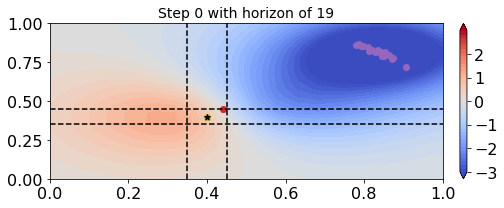

  2%|▏         | 1/50 [00:08<07:10,  8.79s/it]

x0:  [[0.4474407434463501, 0.4575793147087097]] , a:  [[[[[[[[[[[[[[[[[[[[[0.7222931385040283, 0.7400597333908081]], [[0.638830840587616, 0.7293630242347717]], [[0.6747093796730042, 0.6770036220550537]], [[0.6571373343467712, 0.6920390725135803]], [[0.6533499360084534, 0.676774799823761]]], [[[0.6435016393661499, 0.6494292616844177]], [[0.7089700102806091, 0.6933466196060181]], [[0.6824869513511658, 0.6752238273620605]], [[0.6818228363990784, 0.6735208034515381]], [[0.6678335666656494, 0.664630115032196]]], [[[0.6127879023551941, 0.6775482892990112]], [[0.7117554545402527, 0.6506364345550537]], [[0.6625573635101318, 0.660925567150116]], [[0.6620091199874878, 0.7075796723365784]], [[0.6551316380500793, 0.6277037858963013]]], [[[0.6901901364326477, 0.6828797459602356]], [[0.684536337852478, 0.66267991065979]], [[0.6944161057472229, 0.673880398273468]], [[0.6759529709815979, 0.683083713054657]], [[0.6580287218093872, 0.636762797832489]]], [[[0.627947211265564, 0.645325243473053]], [[0.673

 22%|██▏       | 11/50 [01:36<05:54,  9.10s/it]

x0:  [[0.4599877595901489, 0.4662854075431824]] , a:  [[[[[[[[[[[[[[[[[[[[[0.8748907446861267, 0.870009183883667]], [[0.8416229486465454, 0.9453222155570984]], [[0.9091798067092896, 0.9030336141586304]], [[0.8688879013061523, 0.9153306484222412]], [[0.9027805328369141, 0.9074445962905884]]], [[[0.9008538722991943, 0.8753383755683899]], [[0.8933272361755371, 0.860023558139801]], [[0.9116306304931641, 0.8793678879737854]], [[0.905880331993103, 0.9191404581069946]], [[0.9092932343482971, 0.8881974220275879]]], [[[0.890632152557373, 0.9398765563964844]], [[0.9150000214576721, 0.8478147983551025]], [[0.9172308444976807, 0.8902472257614136]], [[0.84478360414505, 0.9322309494018555]], [[0.9162071347236633, 0.8946865797042847]]], [[[0.9270097613334656, 0.911491870880127]], [[0.909253716468811, 0.8676555156707764]], [[0.9586212038993835, 0.8541185259819031]], [[0.8789645433425903, 0.9110825061798096]], [[0.933066725730896, 0.8964458703994751]]], [[[0.9056736826896667, 0.9159417748451233]], [[0.

 42%|████▏     | 21/50 [03:03<04:12,  8.70s/it]

x0:  [[0.46749889850616455, 0.4722030758857727]] , a:  [[[[[[[[[[[[[[[[[[[[[0.893848180770874, 0.862650990486145]], [[0.807676374912262, 0.9362598061561584]], [[0.8749609589576721, 0.881666898727417]], [[0.8721789121627808, 0.8854345083236694]], [[0.8692877888679504, 0.8926107883453369]]], [[[0.9360433220863342, 0.8622232675552368]], [[0.8629043102264404, 0.8339921236038208]], [[0.8903031349182129, 0.8405134081840515]], [[0.8754883408546448, 0.8840909004211426]], [[0.8744144439697266, 0.8705863356590271]]], [[[0.8943117260932922, 0.9317880272865295]], [[0.8830011487007141, 0.8107895851135254]], [[0.8986527919769287, 0.8829904794692993]], [[0.808120846748352, 0.9238802790641785]], [[0.9323221445083618, 0.9102513790130615]]], [[[0.9055992960929871, 0.8896600008010864]], [[0.8760414719581604, 0.8431433439254761]], [[0.9566552639007568, 0.7934542894363403]], [[0.8631641268730164, 0.8985615968704224]], [[0.9407035708427429, 0.884087324142456]]], [[[0.9164537191390991, 0.9157805442810059]], 

 62%|██████▏   | 31/50 [04:31<02:47,  8.81s/it]

x0:  [[0.4727831482887268, 0.4768248200416565]] , a:  [[[[[[[[[[[[[[[[[[[[[0.9108481407165527, 0.8770247101783752]], [[0.7799363136291504, 0.9070475101470947]], [[0.8559343814849854, 0.8601745963096619]], [[0.8577900528907776, 0.8617845177650452]], [[0.851040780544281, 0.8799806833267212]]], [[[0.9031848907470703, 0.7841047644615173]], [[0.910942554473877, 0.8639371991157532]], [[0.8975645303726196, 0.8396213054656982]], [[0.8532962203025818, 0.8635753393173218]], [[0.8761873841285706, 0.8770530819892883]]], [[[0.853371262550354, 0.8778184056282043]], [[0.8846208453178406, 0.8034374117851257]], [[0.8697112202644348, 0.8460756540298462]], [[0.8142608404159546, 0.9147770404815674]], [[0.8805286288261414, 0.8444634675979614]]], [[[0.8849714994430542, 0.8674179911613464]], [[0.8895128965377808, 0.8574275970458984]], [[0.9329155683517456, 0.7520540952682495]], [[0.8404346704483032, 0.8866042494773865]], [[0.9039102792739868, 0.8317556977272034]]], [[[0.8719956278800964, 0.8683651089668274]]

 82%|████████▏ | 41/50 [05:57<01:17,  8.58s/it]

x0:  [[0.47654813528060913, 0.48085105419158936]] , a:  [[[[[[[[[[[[[[[[[[[[[0.9092932939529419, 0.8806616067886353]], [[0.8215376734733582, 0.9361283183097839]], [[0.8819265365600586, 0.8870590329170227]], [[0.8825466632843018, 0.8853062987327576]], [[0.8797580003738403, 0.90208899974823]]], [[[0.9108844995498657, 0.7653485536575317]], [[0.9071367979049683, 0.8598423004150391]], [[0.914438009262085, 0.8517517447471619]], [[0.8825216293334961, 0.8959147334098816]], [[0.8938378095626831, 0.8931003212928772]]], [[[0.8978438973426819, 0.9120665788650513]], [[0.9056733250617981, 0.8308612704277039]], [[0.9054141640663147, 0.8723278045654297]], [[0.8374002575874329, 0.9291781187057495]], [[0.8987826704978943, 0.8556682467460632]]], [[[0.9153743982315063, 0.8982077836990356]], [[0.8887172937393188, 0.8664547204971313]], [[0.9599435329437256, 0.7699697017669678]], [[0.8580811023712158, 0.9049431681632996]], [[0.9158608913421631, 0.8375180959701538]]], [[[0.8868155479431152, 0.8793067932128906

100%|██████████| 50/50 [07:17<00:00,  8.75s/it]


Current optimal loss 1.1219537721502342;optimal action: tensor([[0.4909, 0.4958]], grad_fn=<AddBackward0>)


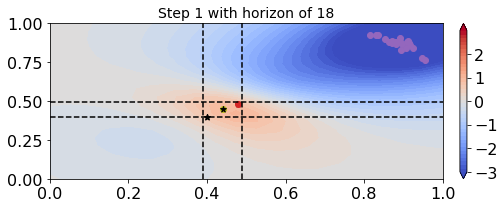

  2%|▏         | 1/50 [00:08<06:42,  8.20s/it]

x0:  [[0.49020034074783325, 0.48831868171691895]] , a:  [[[[[[[[[[[[[[[[[[[[0.7047326564788818, 0.6818801164627075]], [[0.7141444087028503, 0.6744118928909302]], [[0.6903401017189026, 0.6847445368766785]], [[0.6722545623779297, 0.7644491791725159]], [[0.7117679119110107, 0.7185810208320618]]], [[[0.7085761427879333, 0.6488007307052612]], [[0.7209919095039368, 0.651818037033081]], [[0.7258028984069824, 0.7039492130279541]], [[0.7172371745109558, 0.7302608489990234]], [[0.6766605377197266, 0.709596574306488]]], [[[0.6827730536460876, 0.7109253406524658]], [[0.6498692631721497, 0.7323433756828308]], [[0.74137282371521, 0.6958326697349548]], [[0.6889081597328186, 0.7587308883666992]], [[0.7302702069282532, 0.6676920652389526]]], [[[0.7244415879249573, 0.7079927921295166]], [[0.6969729661941528, 0.6839157938957214]], [[0.7500280737876892, 0.6965408325195312]], [[0.7267585396766663, 0.6843064427375793]], [[0.7560078501701355, 0.6680088043212891]]], [[[0.6378219127655029, 0.649738073348999]],

 22%|██▏       | 11/50 [01:32<05:29,  8.46s/it]

x0:  [[0.5062618255615234, 0.49418139457702637]] , a:  [[[[[[[[[[[[[[[[[[[[0.9265238046646118, 0.8796667456626892]], [[0.9430705308914185, 0.8780975937843323]], [[0.9274605512619019, 0.9223800301551819]], [[0.8885594606399536, 0.9665185809135437]], [[0.9422092437744141, 0.9298378825187683]]], [[[0.9609689116477966, 0.8758563995361328]], [[0.9621874690055847, 0.8624131679534912]], [[0.9376344680786133, 0.873923122882843]], [[0.9177067875862122, 0.939395546913147]], [[0.9206441640853882, 0.952305793762207]]], [[[0.8955518007278442, 0.9503521919250488]], [[0.8640056848526001, 0.9336951375007629]], [[0.9542829990386963, 0.9151620268821716]], [[0.8704172372817993, 0.9503660798072815]], [[0.9816915988922119, 0.8971188068389893]]], [[[0.9239262938499451, 0.9089474081993103]], [[0.9359607696533203, 0.8997016549110413]], [[0.9753146171569824, 0.8660111427307129]], [[0.9538329243659973, 0.924107015132904]], [[0.9829130172729492, 0.8640241026878357]]], [[[0.9221150875091553, 0.8824288249015808]],

 42%|████▏     | 21/50 [02:56<04:02,  8.36s/it]

x0:  [[0.5132318735122681, 0.4987921416759491]] , a:  [[[[[[[[[[[[[[[[[[[[0.9116125106811523, 0.8616524338722229]], [[0.9048799276351929, 0.8660174012184143]], [[0.9184203147888184, 0.9298568964004517]], [[0.8548410534858704, 0.9299991130828857]], [[0.9167618155479431, 0.883721113204956]]], [[[0.9648542404174805, 0.8706081509590149]], [[0.9476919770240784, 0.8585411310195923]], [[0.9295427203178406, 0.8132551908493042]], [[0.8976747393608093, 0.9196802377700806]], [[0.9087235927581787, 0.9495024085044861]]], [[[0.8579891920089722, 0.9338667392730713]], [[0.84770268201828, 0.9245259761810303]], [[0.9390804767608643, 0.884678840637207]], [[0.8272925615310669, 0.9247043132781982]], [[0.9720061421394348, 0.8847212195396423]]], [[[0.8732800483703613, 0.8756328821182251]], [[0.9341398477554321, 0.8811811208724976]], [[0.9485469460487366, 0.8251753449440002]], [[0.9558088183403015, 0.9198158979415894]], [[0.9593980312347412, 0.8392559289932251]]], [[[0.9641073346138, 0.9027703404426575]], [[0

 62%|██████▏   | 31/50 [04:21<02:39,  8.39s/it]

x0:  [[0.5172366499900818, 0.5031920671463013]] , a:  [[[[[[[[[[[[[[[[[[[[0.8981618285179138, 0.8344128727912903]], [[0.8863471746444702, 0.8584522008895874]], [[0.8638355731964111, 0.8922954201698303]], [[0.8842799663543701, 0.943508505821228]], [[0.9460566639900208, 0.862599790096283]]], [[[0.9116408824920654, 0.8236913084983826]], [[0.9210129380226135, 0.8357074856758118]], [[0.9619004130363464, 0.8385053277015686]], [[0.9113904237747192, 0.924461841583252]], [[0.8673808574676514, 0.9097449779510498]]], [[[0.8543134331703186, 0.9245593547821045]], [[0.8536151647567749, 0.9029900431632996]], [[0.93767249584198, 0.8772487640380859]], [[0.866703450679779, 0.9466428756713867]], [[0.9340532422065735, 0.8481183052062988]]], [[[0.9007376432418823, 0.8949098587036133]], [[0.8967646360397339, 0.8458706736564636]], [[0.9723249673843384, 0.8582810163497925]], [[0.9200469851493835, 0.8743399977684021]], [[0.9549095034599304, 0.8561869859695435]]], [[[0.9296241998672485, 0.8446475267410278]], [[

 82%|████████▏ | 41/50 [05:45<01:16,  8.48s/it]

x0:  [[0.5198912620544434, 0.5076510906219482]] , a:  [[[[[[[[[[[[[[[[[[[[0.935109555721283, 0.8631235361099243]], [[0.9134376645088196, 0.8901568651199341]], [[0.892861545085907, 0.9213725924491882]], [[0.902349054813385, 0.9465263485908508]], [[0.9616122841835022, 0.8692913055419922]]], [[[0.939793050289154, 0.8429341316223145]], [[0.9440073370933533, 0.866660475730896]], [[0.9683064222335815, 0.8428422212600708]], [[0.924080491065979, 0.9229407906532288]], [[0.9102570414543152, 0.9414142966270447]]], [[[0.8870888948440552, 0.9428280591964722]], [[0.8908169865608215, 0.9181120991706848]], [[0.9523776769638062, 0.8887708783149719]], [[0.876189112663269, 0.9399099946022034]], [[0.9706506133079529, 0.8808783292770386]]], [[[0.9166799783706665, 0.901650071144104]], [[0.9191064834594727, 0.883368730545044]], [[0.9624400734901428, 0.8536287546157837]], [[0.953065037727356, 0.8980728983879089]], [[0.9715837240219116, 0.8779327869415283]]], [[[0.9285507202148438, 0.8276481032371521]], [[0.92

100%|██████████| 50/50 [07:00<00:00,  8.40s/it]


Current optimal loss 0.8677005201962283;optimal action: tensor([[0.5345, 0.5238]], grad_fn=<AddBackward0>)


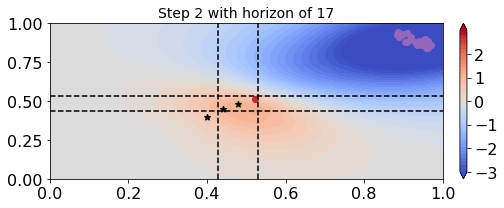

  2%|▏         | 1/50 [00:07<06:21,  7.78s/it]

x0:  [[0.5242451429367065, 0.5303411483764648]] , a:  [[[[[[[[[[[[[[[[[[[0.773410975933075, 0.7732225060462952]], [[0.7363337278366089, 0.7635635137557983]], [[0.7170543670654297, 0.7418201565742493]], [[0.6875372529029846, 0.7076109051704407]], [[0.7492700219154358, 0.7422425746917725]]], [[[0.8187815546989441, 0.7341788411140442]], [[0.7571346759796143, 0.7082501649856567]], [[0.7459139227867126, 0.7010878920555115]], [[0.7432863712310791, 0.7260348796844482]], [[0.6882594227790833, 0.7054903507232666]]], [[[0.7162408828735352, 0.720090389251709]], [[0.7240198254585266, 0.7088524103164673]], [[0.7035649418830872, 0.7000687718391418]], [[0.7165509462356567, 0.7263035774230957]], [[0.7634856700897217, 0.7223675847053528]]], [[[0.7152448296546936, 0.7318400740623474]], [[0.699880063533783, 0.6806877851486206]], [[0.6720390319824219, 0.732793390750885]], [[0.7382603883743286, 0.7008776068687439]], [[0.7520845532417297, 0.7060122489929199]]], [[[0.7317286729812622, 0.6906992793083191]], [

 22%|██▏       | 11/50 [01:27<05:07,  7.88s/it]

x0:  [[0.5428801774978638, 0.542944073677063]] , a:  [[[[[[[[[[[[[[[[[[[0.9543923735618591, 0.8814989328384399]], [[0.9493486881256104, 0.9444757699966431]], [[0.9123609662055969, 0.935116708278656]], [[0.9182720184326172, 0.9482311606407166]], [[0.9281684756278992, 0.8932700753211975]]], [[[0.9522455930709839, 0.8326315879821777]], [[0.9714609384536743, 0.8811178803443909]], [[0.9598016738891602, 0.909360408782959]], [[0.9309695959091187, 0.8810441493988037]], [[0.9024096131324768, 0.953794002532959]]], [[[0.9288802146911621, 0.9198437333106995]], [[0.9786614775657654, 0.8719321489334106]], [[0.959912896156311, 0.9317589402198792]], [[0.9133442640304565, 0.9304646253585815]], [[0.9591593742370605, 0.866608202457428]]], [[[0.95404052734375, 0.93132084608078]], [[0.9076082706451416, 0.893221914768219]], [[0.91819167137146, 0.9446857571601868]], [[0.9315487146377563, 0.9180627465248108]], [[0.9687396883964539, 0.9139362573623657]]], [[[0.9786596298217773, 0.9076141119003296]], [[0.975773

 42%|████▏     | 21/50 [02:43<03:43,  7.69s/it]

x0:  [[0.5508535504341125, 0.5482146739959717]] , a:  [[[[[[[[[[[[[[[[[[[0.9428374171257019, 0.8613317608833313]], [[0.9245724678039551, 0.9061851501464844]], [[0.9213804602622986, 0.9483031034469604]], [[0.9166558980941772, 0.9448347687721252]], [[0.9191309809684753, 0.8540961146354675]]], [[[0.9562258720397949, 0.8507276773452759]], [[0.9490438103675842, 0.8528109788894653]], [[0.9322273135185242, 0.8822477459907532]], [[0.9042801856994629, 0.8276616334915161]], [[0.8959973454475403, 0.9847813844680786]]], [[[0.9159278273582458, 0.8763814568519592]], [[1.0, 0.878793478012085]], [[0.9668794870376587, 0.943722128868103]], [[0.8983131051063538, 0.8877317905426025]], [[0.9331747889518738, 0.8519937992095947]]], [[[0.9385499358177185, 0.9068397879600525]], [[0.9249477386474609, 0.9329578280448914]], [[0.9349784851074219, 0.9591137766838074]], [[0.9167929887771606, 0.9070124626159668]], [[0.955882728099823, 0.9026524424552917]]], [[[0.9828500747680664, 0.881986141204834]], [[0.951616883277

 62%|██████▏   | 31/50 [04:01<02:25,  7.66s/it]

x0:  [[0.5554414391517639, 0.5508697032928467]] , a:  [[[[[[[[[[[[[[[[[[[0.965778648853302, 0.8824183940887451]], [[0.9163294434547424, 0.8875224590301514]], [[0.9078043103218079, 0.9129541516304016]], [[0.8732876181602478, 0.8987467288970947]], [[0.9440499544143677, 0.8671354651451111]]], [[[0.9699430465698242, 0.8721088171005249]], [[0.9581074714660645, 0.8601977825164795]], [[0.933102011680603, 0.8787631392478943]], [[0.9244012236595154, 0.8472473621368408]], [[0.8265712261199951, 0.93907231092453]]], [[[0.911899745464325, 0.8845853209495544]], [[0.9923316240310669, 0.8397746086120605]], [[0.9096190333366394, 0.8930529356002808]], [[0.8992435932159424, 0.8876917362213135]], [[0.9379321932792664, 0.8573158979415894]]], [[[0.9133012294769287, 0.8754568696022034]], [[0.8875887989997864, 0.9088085889816284]], [[0.8987061381340027, 0.9044588804244995]], [[0.8922073245048523, 0.8902467489242554]], [[0.933582603931427, 0.8767205476760864]]], [[[0.956627368927002, 0.849854052066803]], [[0.9

 82%|████████▏ | 41/50 [05:20<01:13,  8.13s/it]

x0:  [[0.5585725903511047, 0.5522820949554443]] , a:  [[[[[[[[[[[[[[[[[[[0.953105628490448, 0.8719151020050049]], [[0.9463216662406921, 0.9122982025146484]], [[0.9257439970970154, 0.916383683681488]], [[0.906485378742218, 0.9166085720062256]], [[0.9514631628990173, 0.8678610920906067]]], [[[0.9670722484588623, 0.8750752806663513]], [[0.9666789174079895, 0.8765667676925659]], [[0.9551764726638794, 0.8968671560287476]], [[0.9409898519515991, 0.8436408638954163]], [[0.8380893468856812, 0.9417716860771179]]], [[[0.9346116185188293, 0.8986344933509827]], [[0.9770817160606384, 0.8180657029151917]], [[0.9185908436775208, 0.9050503969192505]], [[0.921864926815033, 0.8999823331832886]], [[0.9522445201873779, 0.8699563145637512]]], [[[0.9481218457221985, 0.903057873249054]], [[0.8757420182228088, 0.8986318111419678]], [[0.9062037467956543, 0.8978420495986938]], [[0.9180458188056946, 0.909789502620697]], [[0.9592486023902893, 0.8969820141792297]]], [[[0.9815531969070435, 0.8748007416725159]], [[0

100%|██████████| 50/50 [06:29<00:00,  7.79s/it]


Current optimal loss 0.4751454177294336;optimal action: tensor([[0.5745, 0.5667]], grad_fn=<AddBackward0>)


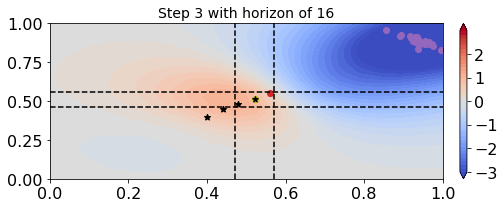

  2%|▏         | 1/50 [00:07<05:56,  7.27s/it]

x0:  [[0.5807254910469055, 0.5737085342407227]] , a:  [[[[[[[[[[[[[[[[[[0.7799952030181885, 0.7668212652206421]], [[0.7757315039634705, 0.7775205373764038]], [[0.7882938385009766, 0.771699845790863]], [[0.7439777851104736, 0.7774974703788757]], [[0.793255627155304, 0.7216995358467102]]], [[[0.7677149772644043, 0.7820452451705933]], [[0.7939448356628418, 0.7990120053291321]], [[0.7621943950653076, 0.7781753540039062]], [[0.7920464873313904, 0.7690830230712891]], [[0.7464888095855713, 0.8139148354530334]]], [[[0.7474579215049744, 0.7892875671386719]], [[0.7735224962234497, 0.7266992926597595]], [[0.7657877206802368, 0.7701071500778198]], [[0.7979564070701599, 0.7530972361564636]], [[0.7313106060028076, 0.7905300855636597]]], [[[0.7397733330726624, 0.8258740901947021]], [[0.7812711596488953, 0.7444256544113159]], [[0.7972557544708252, 0.8080765008926392]], [[0.7647147178649902, 0.7977060079574585]], [[0.7348592877388, 0.7452543377876282]]], [[[0.7604315280914307, 0.7733487486839294]], [[0

 22%|██▏       | 11/50 [01:20<04:53,  7.53s/it]

x0:  [[0.5860112905502319, 0.5837364196777344]] , a:  [[[[[[[[[[[[[[[[[[0.9678609371185303, 0.9294304251670837]], [[0.9404919147491455, 0.9513473510742188]], [[0.9749560952186584, 0.9599049091339111]], [[0.9160439372062683, 0.9902554750442505]], [[1.0, 0.8990398645401001]]], [[[0.9520030617713928, 0.9473565816879272]], [[0.9054786562919617, 0.9608826041221619]], [[0.9584373235702515, 0.9971286058425903]], [[0.9352630972862244, 0.9449703097343445]], [[0.9104294180870056, 0.9800716638565063]]], [[[0.9543583393096924, 0.9448379874229431]], [[0.9776968359947205, 0.9337652325630188]], [[0.9342643618583679, 0.9728209376335144]], [[0.9677109122276306, 0.9530171751976013]], [[0.9510731101036072, 0.9813028573989868]]], [[[0.8625232577323914, 0.9673781991004944]], [[0.941308856010437, 0.9234011769294739]], [[0.912930428981781, 0.9828418493270874]], [[0.9150153398513794, 0.9737280607223511]], [[0.9626796245574951, 0.9443625807762146]]], [[[0.9250909686088562, 0.9559677839279175]], [[0.96908307075

 42%|████▏     | 21/50 [02:32<03:26,  7.14s/it]

x0:  [[0.5821657776832581, 0.5895510911941528]] , a:  [[[[[[[[[[[[[[[[[[0.9298646450042725, 0.8991249203681946]], [[0.9296307563781738, 0.9503557085990906]], [[0.9514983296394348, 0.9143367409706116]], [[0.8876013159751892, 0.9707862734794617]], [[0.9909602999687195, 0.8790678977966309]]], [[[0.9141678810119629, 0.9106200933456421]], [[0.8706756830215454, 0.9410930275917053]], [[0.9335671663284302, 1.0]], [[0.9032717943191528, 0.917208194732666]], [[0.8986944556236267, 0.9474358558654785]]], [[[0.9272066950798035, 0.9194390773773193]], [[0.9646838307380676, 0.9444708824157715]], [[0.9259511232376099, 0.9726184010505676]], [[0.938224732875824, 0.9245492815971375]], [[0.9168006777763367, 0.9537819027900696]]], [[[0.8512991666793823, 0.9589961171150208]], [[0.9089244604110718, 0.9024813175201416]], [[0.8745238184928894, 0.941112220287323]], [[0.8884315490722656, 0.9644871354103088]], [[0.9535186886787415, 0.9531847834587097]]], [[[0.9083912968635559, 0.9683523774147034]], [[0.947472512722

 62%|██████▏   | 31/50 [03:45<02:18,  7.30s/it]

x0:  [[0.564111590385437, 0.5941445827484131]] , a:  [[[[[[[[[[[[[[[[[[0.9145795106887817, 0.8971619009971619]], [[0.882224977016449, 0.919370174407959]], [[0.9064337611198425, 0.8641317486763]], [[0.8598779439926147, 0.9439929127693176]], [[0.9481062889099121, 0.8555760383605957]]], [[[0.8910551071166992, 0.9082439541816711]], [[0.8771032094955444, 0.9610103368759155]], [[0.8500157594680786, 1.0]], [[0.889711320400238, 0.9205658435821533]], [[0.8925882577896118, 0.9446333050727844]]], [[[0.9067760109901428, 0.9175111055374146]], [[0.8868829607963562, 0.8931068181991577]], [[0.8692988753318787, 0.9227885007858276]], [[0.8984917998313904, 0.9112164974212646]], [[0.8883187770843506, 0.9287452697753906]]], [[[0.8362992405891418, 0.9510379433631897]], [[0.8849669694900513, 0.8889048099517822]], [[0.8662155866622925, 0.9432162642478943]], [[0.8526365756988525, 0.9470697045326233]], [[0.8829640746116638, 0.9177709221839905]]], [[[0.8477477431297302, 0.935844361782074]], [[0.9017236232757568,

 82%|████████▏ | 41/50 [04:58<01:05,  7.26s/it]

x0:  [[0.5640334486961365, 0.5950542092323303]] , a:  [[[[[[[[[[[[[[[[[[0.9394775032997131, 0.9139317274093628]], [[0.8912199139595032, 0.9219691753387451]], [[0.9340616464614868, 0.86802738904953]], [[0.8853644132614136, 0.9520841836929321]], [[0.9714064598083496, 0.8808574676513672]]], [[[0.912972092628479, 0.9314170479774475]], [[0.8688126802444458, 0.9458284378051758]], [[0.8298038244247437, 1.0]], [[0.9044507145881653, 0.9269095063209534]], [[0.9048567414283752, 0.9597594738006592]]], [[[0.932113528251648, 0.9404618144035339]], [[0.9064815044403076, 0.9048589468002319]], [[0.8898504376411438, 0.9182335138320923]], [[0.9121105670928955, 0.9219955205917358]], [[0.9300642609596252, 0.9498558044433594]]], [[[0.8650938272476196, 0.9698810577392578]], [[0.9124970436096191, 0.8928875923156738]], [[0.8788840770721436, 0.9414049386978149]], [[0.8715054392814636, 0.954771876335144]], [[0.9085838198661804, 0.9401419758796692]]], [[[0.8623566031455994, 0.9456878900527954]], [[0.92493271827697

100%|██████████| 50/50 [06:05<00:00,  7.30s/it]


Current optimal loss 0.38291369840866424;optimal action: tensor([[0.5727, 0.6099]], grad_fn=<AddBackward0>)


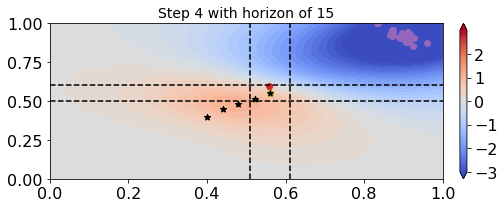

  2%|▏         | 1/50 [00:06<05:26,  6.66s/it]

x0:  [[0.5636768937110901, 0.6127143502235413]] , a:  [[[[[[[[[[[[[[[[[0.6705496311187744, 0.8020100593566895]], [[0.7372167110443115, 0.7294390797615051]], [[0.6963609457015991, 0.799022376537323]], [[0.7585653066635132, 0.7591390013694763]], [[0.7425142526626587, 0.7807790637016296]]], [[[0.7610890865325928, 0.7609399557113647]], [[0.7737943530082703, 0.7967523336410522]], [[0.8123040795326233, 0.776862621307373]], [[0.7408936023712158, 0.7798199653625488]], [[0.7767948508262634, 0.7706514596939087]]], [[[0.7567363381385803, 0.7833160161972046]], [[0.7198966145515442, 0.8004719614982605]], [[0.7293452024459839, 0.7928820848464966]], [[0.6809448599815369, 0.7929742932319641]], [[0.7514710426330566, 0.8234697580337524]]], [[[0.7483171820640564, 0.7639545798301697]], [[0.751156210899353, 0.8032659292221069]], [[0.7434453964233398, 0.7852639555931091]], [[0.714864194393158, 0.8133667707443237]], [[0.7321742177009583, 0.7780437469482422]]], [[[0.7696532011032104, 0.747446596622467]], [[0.

 22%|██▏       | 11/50 [01:14<04:26,  6.83s/it]

x0:  [[0.5498680472373962, 0.6251927614212036]] , a:  [[[[[[[[[[[[[[[[[0.870417594909668, 1.0]], [[0.9449974894523621, 0.9335768222808838]], [[0.8729068040847778, 1.0]], [[0.937849760055542, 0.9320583939552307]], [[0.9463227987289429, 0.9670064449310303]]], [[[0.9597790241241455, 0.9526316523551941]], [[0.9556394219398499, 0.9407932758331299]], [[0.9423916935920715, 0.9107174873352051]], [[0.9189494252204895, 0.9503429532051086]], [[0.969876229763031, 0.9370254278182983]]], [[[0.9234135150909424, 0.9741596579551697]], [[0.9295211434364319, 0.99252849817276]], [[0.8881480097770691, 0.9873214960098267]], [[0.9020677804946899, 0.9855572581291199]], [[0.9338870048522949, 0.9759740233421326]]], [[[0.9354701042175293, 0.9522188305854797]], [[0.9155973196029663, 0.9753623008728027]], [[0.8990767002105713, 0.9415892362594604]], [[0.9212552309036255, 1.0]], [[0.922137439250946, 0.9498952031135559]]], [[[0.9673539400100708, 0.938168466091156]], [[0.9542832970619202, 0.9254820346832275]], [[0.915

 42%|████▏     | 21/50 [02:24<03:18,  6.86s/it]

x0:  [[0.5474663376808167, 0.6292170882225037]] , a:  [[[[[[[[[[[[[[[[[0.9230340123176575, 1.0]], [[0.9835382699966431, 0.9371402263641357]], [[0.8867400884628296, 1.0]], [[0.9498975872993469, 0.9234928488731384]], [[0.9674640893936157, 0.9499696493148804]]], [[[0.9777945280075073, 0.9321639537811279]], [[0.9563803672790527, 0.8955203294754028]], [[0.9186192750930786, 0.8512108325958252]], [[0.9448350667953491, 0.9474334120750427]], [[0.9822127819061279, 0.9160890579223633]]], [[[0.9274436831474304, 0.9843093156814575]], [[0.951718807220459, 1.0]], [[0.8958318829536438, 0.949616551399231]], [[0.9392275810241699, 1.0]], [[0.9200120568275452, 0.9528063535690308]]], [[[0.9605323076248169, 0.9370524287223816]], [[0.9227858781814575, 0.9564996957778931]], [[0.895171582698822, 0.9199284911155701]], [[0.9300035238265991, 1.0]], [[0.9530715942382812, 0.9635331034660339]]], [[[0.9818657636642456, 0.9231070280075073]], [[0.9673082232475281, 0.8885939121246338]], [[0.9281825423240662, 0.906016767

 62%|██████▏   | 31/50 [03:31<02:09,  6.84s/it]

x0:  [[0.5468410849571228, 0.6331864595413208]] , a:  [[[[[[[[[[[[[[[[[0.8991603255271912, 1.0]], [[0.962054967880249, 0.8790318965911865]], [[0.8474612236022949, 1.0]], [[0.9237544536590576, 0.8663610219955444]], [[0.9364650249481201, 0.8970912098884583]]], [[[0.9509167671203613, 0.889931321144104]], [[0.9446973204612732, 0.866182267665863]], [[0.9312692880630493, 0.8367441892623901]], [[0.9215508103370667, 0.8985874056816101]], [[0.9523836374282837, 0.8665449023246765]]], [[[0.9032004475593567, 0.9507138133049011]], [[0.9074174761772156, 1.0]], [[0.8829098343849182, 0.8947206735610962]], [[0.9059697985649109, 1.0]], [[0.9169557690620422, 0.9276549816131592]]], [[[0.9391611814498901, 0.8806472420692444]], [[0.9046343564987183, 0.9152221083641052]], [[0.8812205195426941, 0.882375955581665]], [[0.8816680312156677, 1.0]], [[0.9257052540779114, 0.9181968569755554]]], [[[0.9487863779067993, 0.875015914440155]], [[0.9544336795806885, 0.8468047380447388]], [[0.9045841693878174, 0.85440617799

 82%|████████▏ | 41/50 [04:39<00:59,  6.65s/it]

x0:  [[0.5478724837303162, 0.6358555555343628]] , a:  [[[[[[[[[[[[[[[[[0.8746612071990967, 1.0]], [[0.9464551210403442, 0.8530099391937256]], [[0.8441990613937378, 1.0]], [[0.9512838125228882, 0.8699895143508911]], [[0.9500711560249329, 0.8971043825149536]]], [[[0.9610258936882019, 0.9023944735527039]], [[0.9676678776741028, 0.8755055069923401]], [[0.9485442638397217, 0.8368544578552246]], [[0.940994143486023, 0.898766040802002]], [[0.9667475819587708, 0.8749897480010986]]], [[[0.9190098643302917, 0.9563711881637573]], [[0.8707423210144043, 1.0]], [[0.911126434803009, 0.8933606147766113]], [[0.8635852932929993, 1.0]], [[0.9488695859909058, 0.938792884349823]]], [[[0.9606626629829407, 0.8741352558135986]], [[0.9435104131698608, 0.9200472235679626]], [[0.9121651649475098, 0.8920881152153015]], [[0.8698545694351196, 1.0]], [[0.9175022840499878, 0.8997970223426819]]], [[[0.9691585302352905, 0.8879683613777161]], [[0.977616012096405, 0.8521407842636108]], [[0.9195085763931274, 0.85213983058

100%|██████████| 50/50 [05:40<00:00,  6.82s/it]


Current optimal loss 0.3059730679763726;optimal action: tensor([[0.5625, 0.6518]], grad_fn=<AddBackward0>)


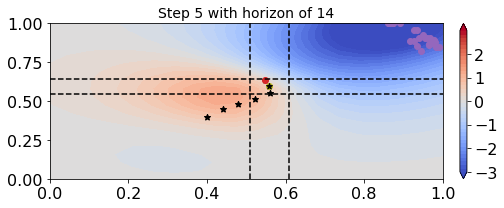

  2%|▏         | 1/50 [00:06<05:00,  6.13s/it]

x0:  [[0.5634926557540894, 0.638631284236908]] , a:  [[[[[[[[[[[[[[[[0.7616890072822571, 0.8191249370574951]], [[0.7281227111816406, 0.8398107290267944]], [[0.7434422373771667, 0.7923429012298584]], [[0.7223294377326965, 0.8344233632087708]], [[0.7049822807312012, 0.7563312649726868]]], [[[0.7372686266899109, 0.8208085894584656]], [[0.7106567025184631, 0.8168022632598877]], [[0.7240526080131531, 0.8116285800933838]], [[0.6788557171821594, 0.8372962474822998]], [[0.7764772176742554, 0.8382624983787537]]], [[[0.7573308348655701, 0.818395733833313]], [[0.7647402286529541, 0.7925782799720764]], [[0.7572098970413208, 0.80731600522995]], [[0.7546605467796326, 0.8067927360534668]], [[0.7080366611480713, 0.7943804860115051]]], [[[0.7347168326377869, 0.8109577894210815]], [[0.6998173594474792, 0.8339189291000366]], [[0.7340637445449829, 0.8475863933563232]], [[0.7407310009002686, 0.8107254505157471]], [[0.7316043376922607, 0.7710984945297241]]], [[[0.732217013835907, 0.8193684220314026]], [[0.6

 22%|██▏       | 11/50 [01:10<04:03,  6.25s/it]

x0:  [[0.5790736079216003, 0.6341714262962341]] , a:  [[[[[[[[[[[[[[[[0.9652629494667053, 0.9952926635742188]], [[0.9106805324554443, 1.0]], [[0.9114253520965576, 0.9797588586807251]], [[0.9550392031669617, 1.0]], [[0.9154669046401978, 0.9282693266868591]]], [[[0.9410673379898071, 1.0]], [[0.8947973251342773, 1.0]], [[0.9140663146972656, 1.0]], [[0.8930476903915405, 1.0]], [[0.9364699721336365, 0.9944208860397339]]], [[[0.9531950354576111, 0.9958336353302002]], [[0.9427180290222168, 0.9589375853538513]], [[0.9304123520851135, 0.9821939468383789]], [[0.9737179279327393, 1.0]], [[0.913659930229187, 1.0]]], [[[0.9512233734130859, 1.0]], [[0.8961740136146545, 1.0]], [[0.9162492752075195, 1.0]], [[0.9680700302124023, 1.0]], [[0.9146112203598022, 0.9493594169616699]]], [[[0.939732015132904, 1.0]], [[0.8791670203208923, 1.0]], [[0.8781898021697998, 1.0]], [[0.9623898863792419, 0.9765451550483704]], [[0.8924809098243713, 1.0]]]]]]]]]]]]]]]] , loss:  -3.299255108311384


 42%|████▏     | 21/50 [02:12<03:01,  6.26s/it]

x0:  [[0.5876885056495667, 0.6377723813056946]] , a:  [[[[[[[[[[[[[[[[0.9808387756347656, 1.0]], [[0.9288970232009888, 1.0]], [[0.9423709511756897, 1.0]], [[1.0, 1.0]], [[0.9775457978248596, 0.9840134382247925]]], [[[0.9839848875999451, 1.0]], [[0.9218370914459229, 1.0]], [[0.947311520576477, 1.0]], [[0.9394586682319641, 1.0]], [[0.9370281100273132, 0.9784461259841919]]], [[[0.9812461137771606, 1.0]], [[0.9515677690505981, 0.9543036222457886]], [[0.9553953409194946, 0.9923609495162964]], [[1.0, 1.0]], [[0.9625245928764343, 1.0]]], [[[1.0, 1.0]], [[0.9106404781341553, 1.0]], [[0.9280622005462646, 1.0]], [[1.0, 1.0]], [[0.9549378752708435, 0.9748860001564026]]], [[[0.9914993643760681, 1.0]], [[0.9098697304725647, 1.0]], [[0.9368025064468384, 1.0]], [[1.0, 1.0]], [[0.9001415967941284, 1.0]]]]]]]]]]]]]]]] , loss:  -3.336042463592057


 62%|██████▏   | 31/50 [03:16<01:57,  6.19s/it]

x0:  [[0.5919173955917358, 0.6443710923194885]] , a:  [[[[[[[[[[[[[[[[0.9598421454429626, 1.0]], [[0.8935577273368835, 1.0]], [[0.9244178533554077, 1.0]], [[1.0, 1.0]], [[0.9804929494857788, 0.9827019572257996]]], [[[0.9714449644088745, 1.0]], [[0.9059985280036926, 1.0]], [[0.9306009411811829, 1.0]], [[0.9396475553512573, 1.0]], [[0.9271669387817383, 0.95249342918396]]], [[[0.9556980133056641, 1.0]], [[0.9240133166313171, 0.9339559674263]], [[0.9375891089439392, 0.9581940174102783]], [[0.9969841241836548, 1.0]], [[0.9560275077819824, 1.0]]], [[[1.0, 1.0]], [[0.8799114227294922, 1.0]], [[0.8919724225997925, 1.0]], [[0.9931819438934326, 1.0]], [[0.9407159686088562, 0.9444469213485718]]], [[[0.9809746146202087, 1.0]], [[0.8926108479499817, 1.0]], [[0.9426470994949341, 1.0]], [[1.0, 1.0]], [[0.8748737573623657, 1.0]]]]]]]]]]]]]]]] , loss:  -3.381941489588556


 82%|████████▏ | 41/50 [04:18<00:55,  6.21s/it]

x0:  [[0.5941808223724365, 0.6521425247192383]] , a:  [[[[[[[[[[[[[[[[0.9646185040473938, 1.0]], [[0.8920574188232422, 1.0]], [[0.9065269827842712, 1.0]], [[1.0, 1.0]], [[0.9601233005523682, 0.9620489478111267]]], [[[0.9581989049911499, 1.0]], [[0.8902356028556824, 1.0]], [[0.9086021184921265, 1.0]], [[0.937534749507904, 1.0]], [[0.9520790576934814, 0.9623019695281982]]], [[[0.9590335488319397, 1.0]], [[0.9418067336082458, 0.9504216909408569]], [[0.9367406368255615, 0.955564022064209]], [[0.9784350991249084, 1.0]], [[0.9295210838317871, 1.0]]], [[[1.0, 1.0]], [[0.881100594997406, 1.0]], [[0.8928372859954834, 1.0]], [[0.9702631831169128, 1.0]], [[0.922961413860321, 0.9235618710517883]]], [[[0.9615499377250671, 1.0]], [[0.8927801251411438, 1.0]], [[0.9221348166465759, 1.0]], [[1.0, 1.0]], [[0.89262855052948, 1.0]]]]]]]]]]]]]]]] , loss:  -3.398134668385768


100%|██████████| 50/50 [05:15<00:00,  6.31s/it]


Current optimal loss -0.4030187447048143;optimal action: tensor([[0.6100, 0.6684]], grad_fn=<AddBackward0>)


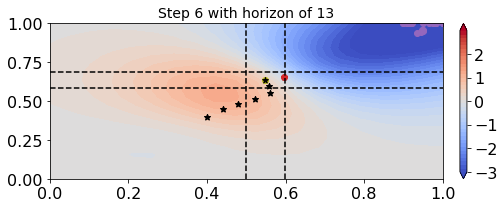

  2%|▏         | 1/50 [00:05<04:36,  5.64s/it]

x0:  [[0.6106311678886414, 0.6604394912719727]] , a:  [[[[[[[[[[[[[[[0.787864625453949, 0.8422436118125916]], [[0.7627876400947571, 0.8209559917449951]], [[0.7604643702507019, 0.838422954082489]], [[0.7925646305084229, 0.8154233694076538]], [[0.7790275812149048, 0.8142722249031067]]], [[[0.7843993902206421, 0.857369601726532]], [[0.7423872947692871, 0.7926534414291382]], [[0.7923683524131775, 0.8148988485336304]], [[0.7777264714241028, 0.8431954383850098]], [[0.7634844183921814, 0.8026064038276672]]], [[[0.7965543866157532, 0.7920560240745544]], [[0.7644141316413879, 0.8289353251457214]], [[0.7392176985740662, 0.8133768439292908]], [[0.7830466628074646, 0.8016088008880615]], [[0.7820875644683838, 0.7953134775161743]]], [[[0.7885944247245789, 0.8137158155441284]], [[0.7589356303215027, 0.8062825202941895]], [[0.7764049172401428, 0.8114364147186279]], [[0.7820231318473816, 0.845654308795929]], [[0.7553359270095825, 0.8221553564071655]]], [[[0.7716184854507446, 0.8223083019256592]], [[0.7

 22%|██▏       | 11/50 [01:01<03:38,  5.60s/it]

x0:  [[0.5947576761245728, 0.6564040184020996]] , a:  [[[[[[[[[[[[[[[0.9026620388031006, 0.9095795750617981]], [[0.8844953179359436, 0.9340328574180603]], [[0.9005028605461121, 0.9477094411849976]], [[0.9429304003715515, 0.9419785737991333]], [[0.9126865267753601, 0.9330994486808777]]], [[[0.9074593782424927, 0.9190341234207153]], [[0.895749568939209, 0.9261513948440552]], [[0.9510926008224487, 0.9252857565879822]], [[0.9303771257400513, 0.9598075747489929]], [[0.9077998399734497, 0.9259762167930603]]], [[[0.9101569056510925, 0.8922654390335083]], [[0.8898141384124756, 0.9400001168251038]], [[0.9164488911628723, 0.9571675658226013]], [[0.9267497658729553, 0.9384921193122864]], [[0.9195012450218201, 0.9005149602890015]]], [[[0.9181517362594604, 0.8981118202209473]], [[0.9023649096488953, 0.954409658908844]], [[0.9368895292282104, 0.933279275894165]], [[0.9130240082740784, 0.9298356771469116]], [[0.9008869528770447, 0.9597451686859131]]], [[[0.9058326482772827, 0.9205895066261292]], [[0.

 42%|████▏     | 21/50 [01:59<02:46,  5.73s/it]

x0:  [[0.5876872539520264, 0.6597093939781189]] , a:  [[[[[[[[[[[[[[[0.8755679726600647, 0.8509544730186462]], [[0.8762327432632446, 0.8935902118682861]], [[0.9050658941268921, 0.9086250066757202]], [[0.9047560691833496, 0.8848229050636292]], [[0.8973294496536255, 0.8672568202018738]]], [[[0.8745537996292114, 0.8155353665351868]], [[0.9022097587585449, 0.8933405876159668]], [[0.9344894886016846, 0.8832616209983826]], [[0.8834208250045776, 0.9021400213241577]], [[0.8892508745193481, 0.8609458804130554]]], [[[0.8919352889060974, 0.8477863669395447]], [[0.8864405155181885, 0.8661715984344482]], [[0.9014706611633301, 0.935843288898468]], [[0.9157639145851135, 0.8897333741188049]], [[0.9013379812240601, 0.8176808953285217]]], [[[0.8881470561027527, 0.8348145484924316]], [[0.8927218317985535, 0.8854557871818542]], [[0.9135978817939758, 0.8972269296646118]], [[0.8685797452926636, 0.8792778849601746]], [[0.8845449090003967, 0.904315173625946]]], [[[0.8857575058937073, 0.8559854626655579]], [[0

 62%|██████▏   | 31/50 [02:56<01:47,  5.65s/it]

x0:  [[0.5826703906059265, 0.6629555225372314]] , a:  [[[[[[[[[[[[[[[0.8817988038063049, 0.8230668902397156]], [[0.8530063033103943, 0.8275465965270996]], [[0.873665452003479, 0.8486096858978271]], [[0.8854013681411743, 0.819284975528717]], [[0.8706645369529724, 0.7948079109191895]]], [[[0.8937273621559143, 0.8091229796409607]], [[0.8690506219863892, 0.8185001611709595]], [[0.8849347829818726, 0.8125885725021362]], [[0.8698251843452454, 0.8451147079467773]], [[0.8626289963722229, 0.8045371174812317]]], [[[0.8708735704421997, 0.8107075691223145]], [[0.8688846826553345, 0.7961668372154236]], [[0.8476675748825073, 0.8629940152168274]], [[0.8826785683631897, 0.8245724439620972]], [[0.8810003399848938, 0.7885288000106812]]], [[[0.8762320876121521, 0.800487756729126]], [[0.8615289926528931, 0.7914101481437683]], [[0.8709976077079773, 0.8495056629180908]], [[0.8816439509391785, 0.8562694191932678]], [[0.8461001515388489, 0.8257935047149658]]], [[[0.8716357946395874, 0.8067800998687744]], [[0.

 82%|████████▏ | 41/50 [03:54<00:52,  5.89s/it]

x0:  [[0.5809031128883362, 0.6653656959533691]] , a:  [[[[[[[[[[[[[[[0.8932332396507263, 0.8148331046104431]], [[0.8799225687980652, 0.8188666701316833]], [[0.8873977661132812, 0.8310695886611938]], [[0.9132785797119141, 0.8087530136108398]], [[0.8972476124763489, 0.8057739734649658]]], [[[0.8958739042282104, 0.8062770366668701]], [[0.8704726696014404, 0.8156318068504333]], [[0.9066416025161743, 0.8239107728004456]], [[0.90512615442276, 0.8305480480194092]], [[0.8944475650787354, 0.8209150433540344]]], [[[0.8937935829162598, 0.8164370656013489]], [[0.8948730230331421, 0.8130400776863098]], [[0.88887619972229, 0.8430646657943726]], [[0.9059386253356934, 0.8194552659988403]], [[0.8947388529777527, 0.8150691986083984]]], [[[0.8985728025436401, 0.8109464049339294]], [[0.8909915089607239, 0.8196529746055603]], [[0.9010051488876343, 0.8373386263847351]], [[0.8963578343391418, 0.8196643590927124]], [[0.8830190300941467, 0.828475832939148]]], [[[0.8922247290611267, 0.8160728216171265]], [[0.88

100%|██████████| 50/50 [04:45<00:00,  5.71s/it]


Current optimal loss -0.31976581653328984;optimal action: tensor([[0.5964, 0.6832]], grad_fn=<AddBackward0>)


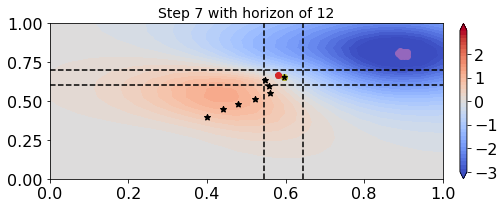

  2%|▏         | 1/50 [00:05<04:14,  5.19s/it]

x0:  [[0.5904380679130554, 0.6868182420730591]] , a:  [[[[[[[[[[[[[[0.7849986553192139, 0.8180113434791565]], [[0.7693494558334351, 0.7910821437835693]], [[0.7633576393127441, 0.8206170797348022]], [[0.7013281583786011, 0.8196677565574646]], [[0.7210054993629456, 0.869221568107605]]], [[[0.7168357968330383, 0.8079943060874939]], [[0.7342166304588318, 0.8407686948776245]], [[0.6924093961715698, 0.8192000985145569]], [[0.7706429958343506, 0.7933390140533447]], [[0.7086735367774963, 0.8590909838676453]]], [[[0.7592845559120178, 0.8581103086471558]], [[0.7240229845046997, 0.7768937945365906]], [[0.6961996555328369, 0.8100895881652832]], [[0.7478346824645996, 0.8296440839767456]], [[0.753420889377594, 0.8187622427940369]]], [[[0.7334197163581848, 0.8725812435150146]], [[0.7308168411254883, 0.8257837295532227]], [[0.727720320224762, 0.8271672129631042]], [[0.7748013734817505, 0.8321190476417542]], [[0.7613584399223328, 0.8322980403900146]]], [[[0.7362871766090393, 0.8066120147705078]], [[0.7

 22%|██▏       | 11/50 [00:57<03:23,  5.22s/it]

x0:  [[0.572178065776825, 0.6706414818763733]] , a:  [[[[[[[[[[[[[[0.9299877285957336, 0.9033187627792358]], [[0.9205101132392883, 0.9251854419708252]], [[0.8821551203727722, 0.9342895746231079]], [[0.8675895929336548, 0.9546644687652588]], [[0.8637237548828125, 0.9834023714065552]]], [[[0.8914778232574463, 0.9456803798675537]], [[0.8804259300231934, 0.9429793953895569]], [[0.8409538865089417, 0.9661171436309814]], [[0.9116445779800415, 0.9116417765617371]], [[0.8805182576179504, 0.9759068489074707]]], [[[0.9025595188140869, 0.9416370987892151]], [[0.8948793411254883, 0.8938440084457397]], [[0.841535210609436, 0.9640349745750427]], [[0.9022883772850037, 0.9150804281234741]], [[0.9100843667984009, 0.9216623306274414]]], [[[0.8955254554748535, 0.9565764665603638]], [[0.8950154781341553, 0.9237018823623657]], [[0.8442777395248413, 0.9482282996177673]], [[0.9156811833381653, 0.9161993861198425]], [[0.9168553948402405, 0.9119778871536255]]], [[[0.89410400390625, 0.9013952016830444]], [[0.91

 42%|████▏     | 21/50 [01:51<02:30,  5.21s/it]

x0:  [[0.5667133331298828, 0.6740286946296692]] , a:  [[[[[[[[[[[[[[0.9299445152282715, 0.8758973479270935]], [[0.930058479309082, 0.8957230448722839]], [[0.8873438835144043, 0.8527700304985046]], [[0.8993847370147705, 0.9673569202423096]], [[0.874382495880127, 0.9469441771507263]]], [[[0.9134953618049622, 0.949554979801178]], [[0.8925755023956299, 0.9335384368896484]], [[0.8699341416358948, 0.9550331830978394]], [[0.9181638360023499, 0.8810354471206665]], [[0.8909011483192444, 0.944699764251709]]], [[[0.8915604948997498, 0.8861187100410461]], [[0.9297448396682739, 0.910771906375885]], [[0.8719891309738159, 0.94034743309021]], [[0.9060266613960266, 0.8698753118515015]], [[0.9265329837799072, 0.8584603071212769]]], [[[0.8937034606933594, 0.9145210981369019]], [[0.9107934236526489, 0.9049995541572571]], [[0.8605989217758179, 0.9054675102233887]], [[0.9026792049407959, 0.8630677461624146]], [[0.931879997253418, 0.8576284646987915]]], [[[0.9209446907043457, 0.8917949199676514]], [[0.917845

 62%|██████▏   | 31/50 [02:42<01:38,  5.17s/it]

x0:  [[0.5663174986839294, 0.6714537143707275]] , a:  [[[[[[[[[[[[[[0.901477038860321, 0.8084243535995483]], [[0.9019956588745117, 0.7997925877571106]], [[0.8718529343605042, 0.768825352191925]], [[0.8752684593200684, 0.9152897596359253]], [[0.8586190938949585, 0.8779154419898987]]], [[[0.8849443197250366, 0.8846411108970642]], [[0.8642539381980896, 0.8779795169830322]], [[0.8556293249130249, 0.8615021109580994]], [[0.8937282562255859, 0.8120132684707642]], [[0.8620897531509399, 0.872900664806366]]], [[[0.8823912143707275, 0.8383768200874329]], [[0.9177073240280151, 0.8573697805404663]], [[0.8668036460876465, 0.8377218842506409]], [[0.8879534602165222, 0.8075886368751526]], [[0.9102290868759155, 0.795696496963501]]], [[[0.8721469044685364, 0.8576347231864929]], [[0.8826008439064026, 0.8336372375488281]], [[0.8513936400413513, 0.8189399242401123]], [[0.882748544216156, 0.8092684745788574]], [[0.9103440046310425, 0.7870190739631653]]], [[[0.9135059714317322, 0.8319711685180664]], [[0.885

 82%|████████▏ | 41/50 [03:35<00:47,  5.29s/it]

x0:  [[0.5676836967468262, 0.6747158169746399]] , a:  [[[[[[[[[[[[[[0.9129612445831299, 0.7998576164245605]], [[0.9006828665733337, 0.7740263938903809]], [[0.8942466378211975, 0.7969631552696228]], [[0.8600077629089355, 0.864799976348877]], [[0.8943155407905579, 0.856143593788147]]], [[[0.8770297765731812, 0.8591629862785339]], [[0.8715550303459167, 0.845424234867096]], [[0.8562239408493042, 0.8103810548782349]], [[0.9073375463485718, 0.8119056224822998]], [[0.8898831605911255, 0.8531607389450073]]], [[[0.9113091826438904, 0.8513439297676086]], [[0.8954973816871643, 0.8052117824554443]], [[0.8735957145690918, 0.7926642894744873]], [[0.909753143787384, 0.8094070553779602]], [[0.919901967048645, 0.7923098206520081]]], [[[0.904336154460907, 0.8441300392150879]], [[0.8817242980003357, 0.8052167892456055]], [[0.871954619884491, 0.8103348016738892]], [[0.9110192060470581, 0.8207808136940002]], [[0.9219924211502075, 0.7904443740844727]]], [[[0.9087679982185364, 0.8072916269302368]], [[0.89979

100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


Current optimal loss -0.21328826743349247;optimal action: tensor([[0.5843, 0.6859]], grad_fn=<AddBackward0>)


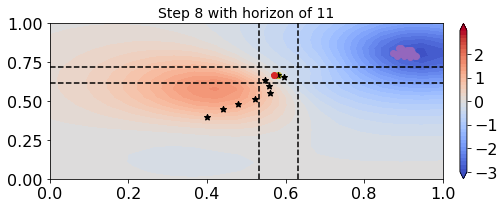

  2%|▏         | 1/50 [00:04<03:45,  4.60s/it]

x0:  [[0.5915336608886719, 0.6916184425354004]] , a:  [[[[[[[[[[[[[0.766728937625885, 0.812879741191864]], [[0.7097480297088623, 0.8106827735900879]], [[0.757222592830658, 0.8583878874778748]], [[0.7569082379341125, 0.8252783417701721]], [[0.7153525352478027, 0.8653848767280579]]], [[[0.700515866279602, 0.8142971992492676]], [[0.715426504611969, 0.8272873163223267]], [[0.7149786353111267, 0.8406718969345093]], [[0.7246048450469971, 0.782914400100708]], [[0.7321885824203491, 0.789798378944397]]], [[[0.7066289186477661, 0.8074517846107483]], [[0.7406730055809021, 0.7847858667373657]], [[0.7373234033584595, 0.823345422744751]], [[0.7480432987213135, 0.8235934376716614]], [[0.7550577521324158, 0.7887091636657715]]], [[[0.7289062738418579, 0.8138898015022278]], [[0.7392892241477966, 0.823600172996521]], [[0.7447277307510376, 0.8397446274757385]], [[0.7608553767204285, 0.8228340744972229]], [[0.7338109016418457, 0.8185852766036987]]], [[[0.7607278823852539, 0.8269622921943665]], [[0.73082560

 22%|██▏       | 11/50 [00:52<03:05,  4.75s/it]

x0:  [[0.5752806067466736, 0.6686810851097107]] , a:  [[[[[[[[[[[[[0.9087584614753723, 0.9004470705986023]], [[0.8639602661132812, 0.9272862076759338]], [[0.8923319578170776, 0.9381002187728882]], [[0.8924286365509033, 0.9210151433944702]], [[0.8402031660079956, 0.9613995552062988]]], [[[0.860296905040741, 0.9305260181427002]], [[0.8772508502006531, 0.9227553009986877]], [[0.8695145845413208, 0.9387816190719604]], [[0.8866438865661621, 0.9015250205993652]], [[0.8849874138832092, 0.8857567310333252]]], [[[0.8761459589004517, 0.9214850664138794]], [[0.8803657293319702, 0.9005268812179565]], [[0.8791294693946838, 0.9234323501586914]], [[0.8977881669998169, 0.9317282438278198]], [[0.9050700068473816, 0.8856707811355591]]], [[[0.8801112174987793, 0.9036952257156372]], [[0.8863770365715027, 0.9035317897796631]], [[0.8671547770500183, 0.9203121066093445]], [[0.9061416387557983, 0.9141936898231506]], [[0.8824229836463928, 0.9248735904693604]]], [[[0.8966742157936096, 0.900881290435791]], [[0.8

 42%|████▏     | 21/50 [01:41<02:17,  4.76s/it]

x0:  [[0.552094042301178, 0.6501634120941162]] , a:  [[[[[[[[[[[[[0.9066026210784912, 0.8666864633560181]], [[0.8881667852401733, 0.9170361757278442]], [[0.8847039937973022, 0.8790355324745178]], [[0.8978898525238037, 0.8944565057754517]], [[0.8533780574798584, 0.9403396248817444]]], [[[0.8876799941062927, 0.9270179271697998]], [[0.892562747001648, 0.9048289060592651]], [[0.877374529838562, 0.9115959405899048]], [[0.9030153155326843, 0.8925257921218872]], [[0.9036430716514587, 0.8617002964019775]]], [[[0.8985961675643921, 0.9166101217269897]], [[0.8966801762580872, 0.8960219621658325]], [[0.8902648687362671, 0.8872238397598267]], [[0.9032188057899475, 0.8898848295211792]], [[0.9174445867538452, 0.8709383606910706]]], [[[0.8991272449493408, 0.8933289051055908]], [[0.8988686800003052, 0.891251802444458]], [[0.8754892945289612, 0.8901233673095703]], [[0.9091954827308655, 0.8768092393875122]], [[0.8954605460166931, 0.9068045616149902]]], [[[0.895631730556488, 0.8369206786155701]], [[0.8887

 62%|██████▏   | 31/50 [02:28<01:29,  4.72s/it]

x0:  [[0.5482136011123657, 0.6399139761924744]] , a:  [[[[[[[[[[[[[0.8896117806434631, 0.7826952338218689]], [[0.8817075490951538, 0.8538910746574402]], [[0.8737925291061401, 0.808010995388031]], [[0.8821861743927002, 0.8197720050811768]], [[0.8478298187255859, 0.8897257447242737]]], [[[0.8786388635635376, 0.8753790259361267]], [[0.8814979791641235, 0.8381828665733337]], [[0.8622939586639404, 0.8384923934936523]], [[0.8912270665168762, 0.8349291086196899]], [[0.8965970277786255, 0.7936753034591675]]], [[[0.8871974945068359, 0.8580087423324585]], [[0.8956987857818604, 0.8454521298408508]], [[0.880462110042572, 0.8131232857704163]], [[0.8851858973503113, 0.8144137859344482]], [[0.9024693965911865, 0.8042100667953491]]], [[[0.8895673155784607, 0.843675434589386]], [[0.8825344443321228, 0.835073709487915]], [[0.8761150240898132, 0.8253223896026611]], [[0.89548659324646, 0.7978285551071167]], [[0.8835905194282532, 0.8316060304641724]]], [[[0.8870389461517334, 0.7669839859008789]], [[0.88825

 82%|████████▏ | 41/50 [03:16<00:44,  4.90s/it]

x0:  [[0.5489494204521179, 0.642117440700531]] , a:  [[[[[[[[[[[[[0.8923972249031067, 0.7485513687133789]], [[0.8757002949714661, 0.7969436645507812]], [[0.8989344239234924, 0.7840479612350464]], [[0.8803642392158508, 0.7813089489936829]], [[0.8627879023551941, 0.8350131511688232]]], [[[0.8654982447624207, 0.8176972270011902]], [[0.8838878870010376, 0.7897416949272156]], [[0.8783657550811768, 0.7875946760177612]], [[0.8794763088226318, 0.7834402918815613]], [[0.8914363980293274, 0.7530130743980408]]], [[[0.8747988939285278, 0.7985123991966248]], [[0.8918929100036621, 0.7966580986976624]], [[0.8879789113998413, 0.778873860836029]], [[0.8792528510093689, 0.7811596393585205]], [[0.8874094486236572, 0.7585388422012329]]], [[[0.8819117546081543, 0.8061221837997437]], [[0.8748893141746521, 0.8006958961486816]], [[0.8884814977645874, 0.7860837578773499]], [[0.8910841941833496, 0.7615839838981628]], [[0.8804720044136047, 0.7690299153327942]]], [[[0.9013888835906982, 0.7679274082183838]], [[0.8

100%|██████████| 50/50 [03:58<00:00,  4.78s/it]


Current optimal loss 0.12996840504252774;optimal action: tensor([[0.5630, 0.6599]], grad_fn=<AddBackward0>)


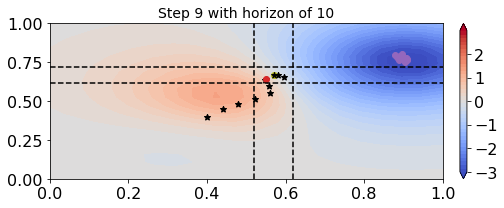

  2%|▏         | 1/50 [00:04<03:27,  4.24s/it]

x0:  [[0.5617941617965698, 0.663089394569397]] , a:  [[[[[[[[[[[[0.6796650290489197, 0.7697246670722961]], [[0.6841229796409607, 0.8045119047164917]], [[0.7016137838363647, 0.796565055847168]], [[0.6585354804992676, 0.7687884569168091]], [[0.6636375188827515, 0.7462377548217773]]], [[[0.713468074798584, 0.7837685346603394]], [[0.7058691382408142, 0.8286045789718628]], [[0.6700003147125244, 0.7778609395027161]], [[0.6508349180221558, 0.7463390827178955]], [[0.6978169679641724, 0.7570102214813232]]], [[[0.6799890398979187, 0.8034083247184753]], [[0.6844459176063538, 0.7850428819656372]], [[0.6674773693084717, 0.7542043328285217]], [[0.7005407810211182, 0.7854310870170593]], [[0.666946291923523, 0.766156017780304]]], [[[0.6732732653617859, 0.7781901955604553]], [[0.6875850558280945, 0.8119389414787292]], [[0.6988876461982727, 0.7753227353096008]], [[0.6978758573532104, 0.7713370323181152]], [[0.6572513580322266, 0.7805597186088562]]], [[[0.6560267806053162, 0.7677294015884399]], [[0.69196

 22%|██▏       | 11/50 [00:46<02:43,  4.18s/it]

x0:  [[0.5598961114883423, 0.6621894836425781]] , a:  [[[[[[[[[[[[0.840096116065979, 0.9269412755966187]], [[0.8467463850975037, 0.9439469575881958]], [[0.8548745512962341, 0.9287739396095276]], [[0.8261497616767883, 0.9097029566764832]], [[0.813885509967804, 0.9096619486808777]]], [[[0.86026930809021, 0.9236365556716919]], [[0.8576242923736572, 0.9492771625518799]], [[0.8396421670913696, 0.9221010804176331]], [[0.815954327583313, 0.8836773633956909]], [[0.8325167894363403, 0.9160292148590088]]], [[[0.8392654061317444, 0.9473714828491211]], [[0.8440893888473511, 0.9306809902191162]], [[0.8379654288291931, 0.914576530456543]], [[0.8493848443031311, 0.9109081029891968]], [[0.8144227266311646, 0.9251298904418945]]], [[[0.8350462913513184, 0.9322800040245056]], [[0.842475175857544, 0.9475044012069702]], [[0.855897068977356, 0.9208685159683228]], [[0.8494265079498291, 0.9057877063751221]], [[0.8088995814323425, 0.937231719493866]]], [[[0.8255183696746826, 0.9282030463218689]], [[0.852145135

 42%|████▏     | 21/50 [01:29<02:06,  4.36s/it]

x0:  [[0.5518118143081665, 0.6610831022262573]] , a:  [[[[[[[[[[[[0.876842737197876, 0.9360262155532837]], [[0.8828308582305908, 0.9336574077606201]], [[0.8878136873245239, 0.9115018248558044]], [[0.8698033094406128, 0.9377764463424683]], [[0.8582659959793091, 0.9481720328330994]]], [[[0.8879252076148987, 0.8996655344963074]], [[0.8849967122077942, 0.9243529438972473]], [[0.8860477209091187, 0.9342234134674072]], [[0.8647183179855347, 0.9134120941162109]], [[0.864311695098877, 0.9283356070518494]]], [[[0.873807430267334, 0.9463173747062683]], [[0.8813568353652954, 0.9348077774047852]], [[0.8834680318832397, 0.935486912727356]], [[0.8785640001296997, 0.9078158736228943]], [[0.855999231338501, 0.9530787467956543]]], [[[0.8729249238967896, 0.9424313902854919]], [[0.8797361850738525, 0.9408773183822632]], [[0.8915386199951172, 0.9209312200546265]], [[0.881608247756958, 0.9149665832519531]], [[0.8534905910491943, 0.9685745239257812]]], [[[0.86934894323349, 0.9459254145622253]], [[0.89016085

 62%|██████▏   | 31/50 [02:11<01:19,  4.19s/it]

x0:  [[0.5549529790878296, 0.6591612696647644]] , a:  [[[[[[[[[[[[0.8815920352935791, 0.8981047868728638]], [[0.8795592784881592, 0.8951405882835388]], [[0.8906164169311523, 0.8549451231956482]], [[0.8781284093856812, 0.9169411659240723]], [[0.8709444999694824, 0.9244784116744995]]], [[[0.8899750113487244, 0.8450754880905151]], [[0.8807997107505798, 0.8725178837776184]], [[0.8960222005844116, 0.9040820002555847]], [[0.8813806176185608, 0.8992093801498413]], [[0.8690297603607178, 0.8782111406326294]]], [[[0.874914824962616, 0.9176658987998962]], [[0.8867937326431274, 0.8979879021644592]], [[0.8931775093078613, 0.9091298580169678]], [[0.8810220956802368, 0.8600298166275024]], [[0.8653915524482727, 0.9224132299423218]]], [[[0.8777137398719788, 0.9068401455879211]], [[0.8832831382751465, 0.896144449710846]], [[0.8962907195091248, 0.8855820298194885]], [[0.8846116662025452, 0.8758506774902344]], [[0.8636793494224548, 0.9446157813072205]]], [[[0.8779235482215881, 0.9197207093238831]], [[0.90

 82%|████████▏ | 41/50 [02:53<00:37,  4.22s/it]

x0:  [[0.5533611178398132, 0.6588015556335449]] , a:  [[[[[[[[[[[[0.8697145581245422, 0.8430601954460144]], [[0.8624566793441772, 0.8369193077087402]], [[0.8830143213272095, 0.810299813747406]], [[0.8650957942008972, 0.8769286274909973]], [[0.8645689487457275, 0.8773001432418823]]], [[[0.8827603459358215, 0.8145784139633179]], [[0.8665525913238525, 0.7997625470161438]], [[0.8844723701477051, 0.85931396484375]], [[0.8766660690307617, 0.8687177300453186]], [[0.8599830865859985, 0.8202688097953796]]], [[[0.8589879870414734, 0.8632939457893372]], [[0.8708435893058777, 0.8361138701438904]], [[0.8805987238883972, 0.8618680834770203]], [[0.8744346499443054, 0.8235782384872437]], [[0.8560041189193726, 0.8707677125930786]]], [[[0.8644099235534668, 0.8529844284057617]], [[0.8719689846038818, 0.8374601602554321]], [[0.884671688079834, 0.8432396650314331]], [[0.8727928996086121, 0.8273417353630066]], [[0.8533464074134827, 0.8935311436653137]]], [[[0.8657399415969849, 0.873193621635437]], [[0.88992

100%|██████████| 50/50 [03:33<00:00,  4.27s/it]


Current optimal loss 0.006830501164572788;optimal action: tensor([[0.5676, 0.6744]], grad_fn=<AddBackward0>)


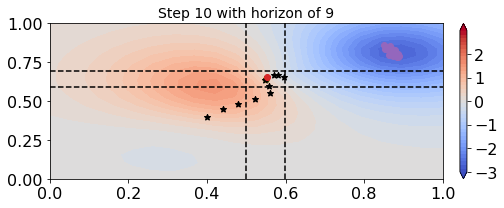

  2%|▏         | 1/50 [00:03<03:03,  3.74s/it]

x0:  [[0.5598702430725098, 0.6670448780059814]] , a:  [[[[[[[[[[[0.6663246154785156, 0.758446455001831]], [[0.6525648832321167, 0.7776898741722107]], [[0.6637071371078491, 0.7462858557701111]], [[0.6549206376075745, 0.7969464063644409]], [[0.6884303092956543, 0.7702693939208984]]], [[[0.6538877487182617, 0.7284944653511047]], [[0.686934769153595, 0.7810685634613037]], [[0.675111711025238, 0.749365508556366]], [[0.6639834642410278, 0.7717629075050354]], [[0.700289249420166, 0.7890850305557251]]], [[[0.6291719079017639, 0.7581402659416199]], [[0.6472713351249695, 0.7772844433784485]], [[0.669867217540741, 0.7724002599716187]], [[0.6419024467468262, 0.7758797407150269]], [[0.6675765514373779, 0.7619673609733582]]], [[[0.6664292216300964, 0.7716673016548157]], [[0.6942272782325745, 0.8004152774810791]], [[0.6655182838439941, 0.7738181352615356]], [[0.6391767859458923, 0.7500553131103516]], [[0.6670956611633301, 0.7750939130783081]]], [[[0.6693748235702515, 0.7826623916625977]], [[0.6826532

 22%|██▏       | 11/50 [00:41<02:26,  3.74s/it]

x0:  [[0.5649764537811279, 0.6726601123809814]] , a:  [[[[[[[[[[[0.8228735327720642, 0.9104655981063843]], [[0.8011289834976196, 0.9233308434486389]], [[0.8222978711128235, 0.9012327194213867]], [[0.8140933513641357, 0.9379289746284485]], [[0.8345378041267395, 0.909080982208252]]], [[[0.8156390190124512, 0.8886238932609558]], [[0.8329991102218628, 0.9135465025901794]], [[0.8294897675514221, 0.8932042717933655]], [[0.8181657791137695, 0.9184763431549072]], [[0.8438102006912231, 0.924291729927063]]], [[[0.8008085489273071, 0.9105848073959351]], [[0.8104057908058167, 0.925995409488678]], [[0.8261103630065918, 0.9152222871780396]], [[0.8064171671867371, 0.92592453956604]], [[0.8237446546554565, 0.9087928533554077]]], [[[0.8233695030212402, 0.9152729511260986]], [[0.8371410369873047, 0.9283223152160645]], [[0.8214638829231262, 0.9138447046279907]], [[0.8037411570549011, 0.910873532295227]], [[0.7995416522026062, 0.9037600159645081]]], [[[0.824195384979248, 0.9157198667526245]], [[0.83190512

 42%|████▏     | 21/50 [01:19<01:48,  3.73s/it]

x0:  [[0.5565440654754639, 0.6730459928512573]] , a:  [[[[[[[[[[[0.8630810976028442, 0.945121169090271]], [[0.8405637741088867, 0.9493083953857422]], [[0.8637174367904663, 0.9340600967407227]], [[0.8516815900802612, 0.9587478041648865]], [[0.86869215965271, 0.9152735471725464]]], [[[0.8592433333396912, 0.9308446049690247]], [[0.8618351817131042, 0.9270346760749817]], [[0.8681662082672119, 0.9014869332313538]], [[0.8543720245361328, 0.9391745924949646]], [[0.8733039498329163, 0.9268454909324646]]], [[[0.8497656583786011, 0.9495309591293335]], [[0.8511471152305603, 0.9525918364524841]], [[0.8647782802581787, 0.9371006488800049]], [[0.8485308289527893, 0.9535907506942749]], [[0.8630748391151428, 0.9272704124450684]]], [[[0.8632239699363708, 0.9437394142150879]], [[0.8642521500587463, 0.9215680956840515]], [[0.8600010275840759, 0.9330011606216431]], [[0.8469365835189819, 0.9481015205383301]], [[0.8372501134872437, 0.9220543503761292]]], [[[0.8608720898628235, 0.9350870847702026]], [[0.8634

 62%|██████▏   | 31/50 [01:58<01:16,  4.01s/it]

x0:  [[0.5487882494926453, 0.6711904406547546]] , a:  [[[[[[[[[[[0.8637449145317078, 0.9259721040725708]], [[0.8377206921577454, 0.9267631769180298]], [[0.8616396188735962, 0.9143593907356262]], [[0.8462736010551453, 0.9292130470275879]], [[0.8629555702209473, 0.866551399230957]]], [[[0.8621885776519775, 0.9195003509521484]], [[0.852081835269928, 0.8843238353729248]], [[0.8667224645614624, 0.8646030426025391]], [[0.8508341908454895, 0.9140064120292664]], [[0.8628367781639099, 0.8743264675140381]]], [[[0.8536865711212158, 0.9419352412223816]], [[0.847520649433136, 0.9255312085151672]], [[0.8603916764259338, 0.9067923426628113]], [[0.8463313579559326, 0.9300565123558044]], [[0.8577558398246765, 0.8922728300094604]]], [[[0.8626871109008789, 0.923357367515564]], [[0.8555054664611816, 0.8539842367172241]], [[0.8554282188415527, 0.9041564464569092]], [[0.8456383347511292, 0.9319865703582764]], [[0.8349438309669495, 0.9032643437385559]]], [[[0.8586828708648682, 0.9057064056396484]], [[0.85616

 82%|████████▏ | 41/50 [02:36<00:33,  3.73s/it]

x0:  [[0.5454684495925903, 0.6689625382423401]] , a:  [[[[[[[[[[[0.8547839522361755, 0.8813748359680176]], [[0.8387948870658875, 0.8825445175170898]], [[0.8523750305175781, 0.872195839881897]], [[0.8321089744567871, 0.8836581707000732]], [[0.8586465120315552, 0.821609616279602]]], [[[0.8549759387969971, 0.8828002214431763]], [[0.8506711721420288, 0.8241437077522278]], [[0.8605077862739563, 0.8199574947357178]], [[0.8389772176742554, 0.8740295767784119]], [[0.8549083471298218, 0.8195443749427795]]], [[[0.8455621600151062, 0.9131675362586975]], [[0.8479681015014648, 0.8755595684051514]], [[0.8498722314834595, 0.8546127080917358]], [[0.8344658017158508, 0.8915867805480957]], [[0.8508686423301697, 0.850561797618866]]], [[[0.852392315864563, 0.8824840188026428]], [[0.8586745262145996, 0.7874853014945984]], [[0.8451261520385742, 0.8555729389190674]], [[0.8338491916656494, 0.9010892510414124]], [[0.8311079144477844, 0.878820538520813]]], [[[0.8493371605873108, 0.8520359992980957]], [[0.856082

100%|██████████| 50/50 [03:09<00:00,  3.80s/it]


Current optimal loss 0.003926772751010544;optimal action: tensor([[0.5598, 0.6841]], grad_fn=<AddBackward0>)


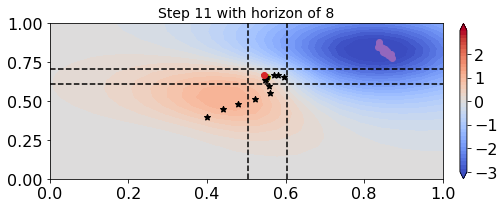

  2%|▏         | 1/50 [00:03<02:38,  3.24s/it]

x0:  [[0.5466209053993225, 0.6746028661727905]] , a:  [[[[[[[[[[0.6360720992088318, 0.7681266665458679]], [[0.6730400323867798, 0.8057743310928345]], [[0.6461498737335205, 0.7555044889450073]], [[0.6608521938323975, 0.7712815403938293]], [[0.6086938977241516, 0.7569817900657654]]], [[[0.6573185324668884, 0.8025657534599304]], [[0.6579542756080627, 0.7471022605895996]], [[0.6598607301712036, 0.748857855796814]], [[0.6495944261550903, 0.7297850251197815]], [[0.6079936027526855, 0.7429616451263428]]], [[[0.6474883556365967, 0.7579367756843567]], [[0.643757700920105, 0.7851593494415283]], [[0.6512860655784607, 0.7825669646263123]], [[0.6335268616676331, 0.7412718534469604]], [[0.6122484803199768, 0.7588938474655151]]], [[[0.6538874506950378, 0.8006040453910828]], [[0.6209787726402283, 0.7433379292488098]], [[0.6596066951751709, 0.7571632266044617]], [[0.6427574157714844, 0.7515638470649719]], [[0.5897945165634155, 0.7371477484703064]]], [[[0.6718307733535767, 0.7632886171340942]], [[0.6322

 22%|██▏       | 11/50 [00:35<02:07,  3.27s/it]

x0:  [[0.5634092092514038, 0.6741336584091187]] , a:  [[[[[[[[[[0.7934781908988953, 0.8965561389923096]], [[0.8127851486206055, 0.9197219014167786]], [[0.7980073094367981, 0.8777041435241699]], [[0.8017289042472839, 0.8761214017868042]], [[0.7764632105827332, 0.891000509262085]]], [[[0.8058919310569763, 0.913650393486023]], [[0.8059658408164978, 0.8826525807380676]], [[0.8099125027656555, 0.8787749409675598]], [[0.8038739562034607, 0.8703089356422424]], [[0.7781556844711304, 0.8875116109848022]]], [[[0.8006307482719421, 0.8902207016944885]], [[0.7954086065292358, 0.9094297289848328]], [[0.803234338760376, 0.9008404016494751]], [[0.7932673692703247, 0.874904990196228]], [[0.7787508964538574, 0.8952010869979858]]], [[[0.8032852411270142, 0.9160037040710449]], [[0.7828395366668701, 0.8857737183570862]], [[0.8083614110946655, 0.884309709072113]], [[0.7977260947227478, 0.8823350071907043]], [[0.7664945125579834, 0.8852970004081726]]], [[[0.8152156472206116, 0.8896418809890747]], [[0.7898638

 42%|████▏     | 21/50 [01:09<01:35,  3.30s/it]

x0:  [[0.5641412734985352, 0.6549884080886841]] , a:  [[[[[[[[[[0.8429878354072571, 0.9022626876831055]], [[0.84758061170578, 0.9136281609535217]], [[0.8480992317199707, 0.8813008069992065]], [[0.8506933450698853, 0.8749716281890869]], [[0.8337370753288269, 0.9124466776847839]]], [[[0.8491791486740112, 0.9027542471885681]], [[0.8470986485481262, 0.8946837186813354]], [[0.8567803502082825, 0.8806172013282776]], [[0.8542861938476562, 0.8816519975662231]], [[0.8363434076309204, 0.9135600328445435]]], [[[0.8475549221038818, 0.8962026834487915]], [[0.8383334279060364, 0.9160953760147095]], [[0.8504020571708679, 0.8943532705307007]], [[0.8482816219329834, 0.8831438422203064]], [[0.8345016837120056, 0.9151826500892639]]], [[[0.8469435572624207, 0.9107916355133057]], [[0.8334839344024658, 0.907702624797821]], [[0.8551766276359558, 0.8822516798973083]], [[0.8490041494369507, 0.8866667151451111]], [[0.8297778964042664, 0.9157556891441345]]], [[[0.8564302325248718, 0.8879826068878174]], [[0.83774

 62%|██████▏   | 31/50 [01:42<01:02,  3.27s/it]

x0:  [[0.5617049932479858, 0.6428656578063965]] , a:  [[[[[[[[[[0.8580090403556824, 0.8831980228424072]], [[0.8475615978240967, 0.8782490491867065]], [[0.8592048287391663, 0.8503147959709167]], [[0.8615743517875671, 0.8470630645751953]], [[0.8464981913566589, 0.9009833931922913]]], [[[0.8609575033187866, 0.8651783466339111]], [[0.8510446548461914, 0.8722041845321655]], [[0.8661478161811829, 0.8473955392837524]], [[0.8651524782180786, 0.8578353524208069]], [[0.8491994142532349, 0.903522253036499]]], [[[0.8614569902420044, 0.8753231167793274]], [[0.8425335884094238, 0.8960347175598145]], [[0.8588991165161133, 0.8598222732543945]], [[0.8615458607673645, 0.8611624240875244]], [[0.846410870552063, 0.9021971821784973]]], [[[0.8578559756278992, 0.8840999603271484]], [[0.8412253260612488, 0.8983997106552124]], [[0.8645031452178955, 0.8461341857910156]], [[0.8602131605148315, 0.8605829477310181]], [[0.8445406556129456, 0.9089047908782959]]], [[[0.8684502243995667, 0.8569912910461426]], [[0.8440

 82%|████████▏ | 41/50 [02:15<00:29,  3.28s/it]

x0:  [[0.5637675523757935, 0.639190673828125]] , a:  [[[[[[[[[[0.8685137033462524, 0.8485139608383179]], [[0.8494549989700317, 0.8399538397789001]], [[0.8650506734848022, 0.8174241185188293]], [[0.8669296503067017, 0.819778561592102]], [[0.8562116026878357, 0.8816899061203003]]], [[[0.8699853420257568, 0.8155264258384705]], [[0.8558019399642944, 0.8438736200332642]], [[0.8710958957672119, 0.8136193156242371]], [[0.8700795769691467, 0.8332799077033997]], [[0.8590025901794434, 0.8850204944610596]]], [[[0.8713168501853943, 0.838268518447876]], [[0.8464908599853516, 0.8693157434463501]], [[0.8625137805938721, 0.8268847465515137]], [[0.868209719657898, 0.8414417505264282]], [[0.855466365814209, 0.8809196949005127]]], [[[0.8643419742584229, 0.841424286365509]], [[0.8472809791564941, 0.8829586505889893]], [[0.8695145845413208, 0.810015857219696]], [[0.865354597568512, 0.8358522653579712]], [[0.8550192713737488, 0.8941116333007812]]], [[[0.8782477974891663, 0.8100783824920654]], [[0.8491177558

100%|██████████| 50/50 [02:46<00:00,  3.32s/it]


Current optimal loss -0.042601349000824885;optimal action: tensor([[0.5780, 0.6536]], grad_fn=<AddBackward0>)


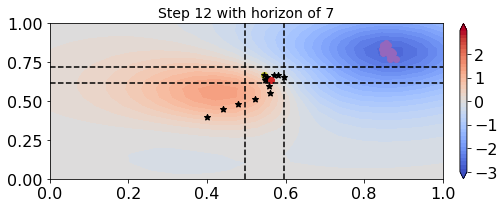

  2%|▏         | 1/50 [00:02<02:18,  2.82s/it]

x0:  [[0.5680521726608276, 0.6444276571273804]] , a:  [[[[[[[[[0.6256746649742126, 0.7305231094360352]], [[0.6323877573013306, 0.7104939222335815]], [[0.6655017137527466, 0.7353271842002869]], [[0.6311460733413696, 0.7569721937179565]], [[0.6777126789093018, 0.7211044430732727]]], [[[0.6359713077545166, 0.7131721377372742]], [[0.6766066551208496, 0.7318490147590637]], [[0.6770929098129272, 0.7146869897842407]], [[0.6842483878135681, 0.7569517493247986]], [[0.6698935627937317, 0.7347517609596252]]], [[[0.6475256681442261, 0.7273234128952026]], [[0.6535710096359253, 0.7434447407722473]], [[0.6560749411582947, 0.716646134853363]], [[0.6510689854621887, 0.7341893911361694]], [[0.6201943159103394, 0.7045204639434814]]], [[[0.6534002423286438, 0.7308306694030762]], [[0.642009973526001, 0.7267773747444153]], [[0.639924168586731, 0.7420944571495056]], [[0.6667229533195496, 0.742072582244873]], [[0.6546518802642822, 0.7045683264732361]]], [[[0.6662405729293823, 0.7271350622177124]], [[0.6689206

 22%|██▏       | 11/50 [00:30<01:48,  2.79s/it]

x0:  [[0.5836735963821411, 0.6522436141967773]] , a:  [[[[[[[[[0.7743382453918457, 0.8532266616821289]], [[0.776160717010498, 0.8365938663482666]], [[0.7924798130989075, 0.846297025680542]], [[0.772391140460968, 0.8661578297615051]], [[0.8034569025039673, 0.8384509682655334]]], [[[0.7668435573577881, 0.8449602127075195]], [[0.8040831089019775, 0.8488530516624451]], [[0.8009644150733948, 0.8336595296859741]], [[0.8069751262664795, 0.8634202480316162]], [[0.7979727983474731, 0.8507689833641052]]], [[[0.7865134477615356, 0.8479886651039124]], [[0.788783073425293, 0.8565416932106018]], [[0.7826197147369385, 0.8237763047218323]], [[0.7866852283477783, 0.853112518787384]], [[0.7673048377037048, 0.8305116891860962]]], [[[0.790256917476654, 0.8550481796264648]], [[0.7813904285430908, 0.8468880653381348]], [[0.776199460029602, 0.8511239290237427]], [[0.795744776725769, 0.8571105003356934]], [[0.7899092435836792, 0.8348385691642761]]], [[[0.7985668778419495, 0.8505472540855408]], [[0.79953968524

 42%|████▏     | 21/50 [00:58<01:21,  2.81s/it]

x0:  [[0.587618350982666, 0.6465635895729065]] , a:  [[[[[[[[[0.832703173160553, 0.8830600380897522]], [[0.8330333232879639, 0.8575263619422913]], [[0.8392934799194336, 0.8669591546058655]], [[0.8289864659309387, 0.8865258097648621]], [[0.8452330827713013, 0.862877607345581]]], [[[0.8258619904518127, 0.8814607858657837]], [[0.8488613367080688, 0.8610391020774841]], [[0.8449842929840088, 0.8599081635475159]], [[0.8496918082237244, 0.884007453918457]], [[0.841537594795227, 0.8732284903526306]]], [[[0.8367031216621399, 0.8771766424179077]], [[0.8390529751777649, 0.8667320609092712]], [[0.8292080163955688, 0.8519346714019775]], [[0.8378863334655762, 0.8788142800331116]], [[0.8251162171363831, 0.8646892309188843]]], [[[0.8388491868972778, 0.8839155435562134]], [[0.8345578908920288, 0.8626084327697754]], [[0.8295719623565674, 0.8704774379730225]], [[0.8422892093658447, 0.8795620203018188]], [[0.8377893567085266, 0.8672270774841309]]], [[[0.8444542288780212, 0.8763940334320068]], [[0.84624373

 62%|██████▏   | 31/50 [01:27<00:53,  2.81s/it]

x0:  [[0.5876873135566711, 0.6320872902870178]] , a:  [[[[[[[[[0.8506110310554504, 0.8721975088119507]], [[0.8506449460983276, 0.8386298418045044]], [[0.852759838104248, 0.8469916582107544]], [[0.8463749885559082, 0.8664593696594238]], [[0.8566544055938721, 0.8433487415313721]]], [[[0.8451157808303833, 0.8720051646232605]], [[0.8610902428627014, 0.8365100622177124]], [[0.8570411205291748, 0.8406604528427124]], [[0.8612104654312134, 0.8619399666786194]], [[0.8536929488182068, 0.8531659841537476]]], [[[0.8516567349433899, 0.8644241094589233]], [[0.853795051574707, 0.8421239852905273]], [[0.8434250354766846, 0.8375858068466187]], [[0.8530450463294983, 0.8603985905647278]], [[0.8434600830078125, 0.8526349067687988]]], [[[0.8527967929840088, 0.8706061244010925]], [[0.8507221341133118, 0.8414656519889832]], [[0.8458881378173828, 0.8516497611999512]], [[0.8549733757972717, 0.8592125177383423]], [[0.8517562747001648, 0.8516697883605957]]], [[[0.857500433921814, 0.8586920499801636]], [[0.859664

 82%|████████▏ | 41/50 [01:54<00:25,  2.80s/it]

x0:  [[0.5856512188911438, 0.6187556385993958]] , a:  [[[[[[[[[0.8526486158370972, 0.8477814793586731]], [[0.854159951210022, 0.8177876472473145]], [[0.8543943762779236, 0.8217403292655945]], [[0.8485789895057678, 0.8392667770385742]], [[0.8564014434814453, 0.8123477697372437]]], [[[0.8480634093284607, 0.8469496369361877]], [[0.8618634343147278, 0.8101392388343811]], [[0.85779869556427, 0.813893735408783]], [[0.8605510592460632, 0.8300904631614685]], [[0.8538331389427185, 0.8228954076766968]]], [[[0.8528486490249634, 0.8359888792037964]], [[0.8559126853942871, 0.8164918422698975]], [[0.8460941314697266, 0.8178721070289612]], [[0.8544002175331116, 0.8334528803825378]], [[0.8466881513595581, 0.8310089707374573]]], [[[0.8529302477836609, 0.8421498537063599]], [[0.8536611795425415, 0.819295346736908]], [[0.8487801551818848, 0.829383909702301]], [[0.854339599609375, 0.8303523063659668]], [[0.8528886437416077, 0.8248180150985718]]], [[[0.8576666116714478, 0.8242303729057312]], [[0.8615293502

100%|██████████| 50/50 [02:21<00:00,  2.83s/it]


Current optimal loss -0.09049262793075381;optimal action: tensor([[0.5981, 0.6279]], grad_fn=<AddBackward0>)


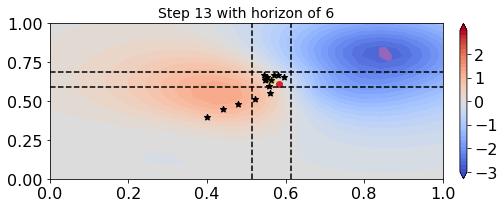

  2%|▏         | 1/50 [00:02<01:56,  2.39s/it]

x0:  [[0.5941791534423828, 0.6291289925575256]] , a:  [[[[[[[[0.6426718235015869, 0.69607013463974]], [[0.69183748960495, 0.7015430331230164]], [[0.6488772034645081, 0.690934419631958]], [[0.6952458024024963, 0.6727251410484314]], [[0.6784511804580688, 0.6897761225700378]]], [[[0.6768906116485596, 0.6982214450836182]], [[0.6730970144271851, 0.7165693640708923]], [[0.6642997860908508, 0.7295961976051331]], [[0.6613200306892395, 0.6865576505661011]], [[0.6479419469833374, 0.6948566436767578]]], [[[0.6743284463882446, 0.7109056115150452]], [[0.6652696132659912, 0.7003864049911499]], [[0.6670275330543518, 0.6875412464141846]], [[0.6644840836524963, 0.6768982410430908]], [[0.6669183969497681, 0.728605329990387]]], [[[0.6518712639808655, 0.7221194505691528]], [[0.6742469072341919, 0.6922839879989624]], [[0.6654053330421448, 0.6797595024108887]], [[0.6711816191673279, 0.6579389572143555]], [[0.6705724596977234, 0.6865491271018982]]], [[[0.6863060593605042, 0.6938732862472534]], [[0.6565870642

 22%|██▏       | 11/50 [00:25<01:28,  2.26s/it]

x0:  [[0.6091812252998352, 0.6357973217964172]] , a:  [[[[[[[[0.7723551988601685, 0.804070770740509]], [[0.8024511337280273, 0.8044474124908447]], [[0.775915801525116, 0.8011173009872437]], [[0.8057034611701965, 0.7842864394187927]], [[0.7960583567619324, 0.7991418838500977]]], [[[0.7943717837333679, 0.8044877052307129]], [[0.7915827631950378, 0.8149611949920654]], [[0.7858909964561462, 0.8267354965209961]], [[0.7838038802146912, 0.8004094362258911]], [[0.7756929397583008, 0.8048310875892639]]], [[[0.7914178371429443, 0.812981128692627]], [[0.7872879505157471, 0.8023295402526855]], [[0.7874032855033875, 0.7994169592857361]], [[0.7858849167823792, 0.7953014969825745]], [[0.7872825264930725, 0.8240309953689575]]], [[[0.7776032090187073, 0.8212732076644897]], [[0.7670557498931885, 0.782772958278656]], [[0.7868573665618896, 0.7948873043060303]], [[0.7903993129730225, 0.7817113995552063]], [[0.7902191281318665, 0.7976604700088501]]], [[[0.8010404109954834, 0.8024259209632874]], [[0.78097456

 42%|████▏     | 21/50 [00:48<01:05,  2.26s/it]

x0:  [[0.6061326861381531, 0.6178154349327087]] , a:  [[[[[[[[0.8178083896636963, 0.8102036118507385]], [[0.8346757888793945, 0.8029775023460388]], [[0.8189518451690674, 0.8094222545623779]], [[0.8375644087791443, 0.8050504326820374]], [[0.8315732479095459, 0.8052952289581299]]], [[[0.8302948474884033, 0.8110314011573792]], [[0.8279467225074768, 0.8107472062110901]], [[0.825262725353241, 0.8236210346221924]], [[0.8230520486831665, 0.8135936856269836]], [[0.8193474411964417, 0.8101164698600769]]], [[[0.8274001479148865, 0.8135181069374084]], [[0.8264634609222412, 0.8012336492538452]], [[0.8257598876953125, 0.8092407584190369]], [[0.8244772553443909, 0.8115124702453613]], [[0.82488614320755, 0.8194416761398315]]], [[[0.8195561170578003, 0.8187315464019775]], [[0.803217351436615, 0.7751850485801697]], [[0.8257195949554443, 0.8063806295394897]], [[0.8279847502708435, 0.8043963313102722]], [[0.8285200595855713, 0.8053258061408997]]], [[[0.8343153595924377, 0.8076989650726318]], [[0.82256209

 62%|██████▏   | 31/50 [01:11<00:43,  2.29s/it]

x0:  [[0.5984341502189636, 0.5989770889282227]] , a:  [[[[[[[[0.828075110912323, 0.7831146717071533]], [[0.8395791053771973, 0.7730884552001953]], [[0.8282163143157959, 0.7826436758041382]], [[0.8413597345352173, 0.7850404977798462]], [[0.8371503353118896, 0.7793401479721069]]], [[[0.8357003331184387, 0.7839264273643494]], [[0.8341954350471497, 0.7801380753517151]], [[0.8325071334838867, 0.7912824749946594]], [[0.8301776051521301, 0.7898736000061035]], [[0.8287943005561829, 0.7833885550498962]]], [[[0.8333878517150879, 0.7836102843284607]], [[0.8340487480163574, 0.772674560546875]], [[0.8325052261352539, 0.782587468624115]], [[0.8312118053436279, 0.7886737585067749]], [[0.8316744565963745, 0.7884928584098816]]], [[[0.8283663392066956, 0.7871734499931335]], [[0.8155892491340637, 0.7513282299041748]], [[0.832970380783081, 0.7806939482688904]], [[0.8342185020446777, 0.7842190861701965]], [[0.8352641463279724, 0.7798977494239807]]], [[[0.8387183547019958, 0.7798716425895691]], [[0.83128511

 82%|████████▏ | 41/50 [01:34<00:21,  2.33s/it]

x0:  [[0.5976446866989136, 0.5927641987800598]] , a:  [[[[[[[[0.8366257548332214, 0.772863507270813]], [[0.8458839058876038, 0.761512041091919]], [[0.8363678455352783, 0.7721682190895081]], [[0.8456753492355347, 0.7740359306335449]], [[0.8429177403450012, 0.7692480683326721]]], [[[0.8411951661109924, 0.7729777097702026]], [[0.8408147692680359, 0.7697280645370483]], [[0.8392288088798523, 0.7778850793838501]], [[0.8364356756210327, 0.7777029275894165]], [[0.8366539478302002, 0.773294985294342]]], [[[0.8396809697151184, 0.7714949250221252]], [[0.8413950204849243, 0.76361483335495]], [[0.8390077352523804, 0.7720480561256409]], [[0.8371611833572388, 0.7765805721282959]], [[0.8383181095123291, 0.7760743498802185]]], [[[0.8364089131355286, 0.7740089893341064]], [[0.82840496301651, 0.7498576641082764]], [[0.8399702906608582, 0.7705400586128235]], [[0.8398870229721069, 0.7728986144065857]], [[0.8413752913475037, 0.770075261592865]]], [[[0.843940258026123, 0.7685362100601196]], [[0.8391360640525

100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


Current optimal loss -0.2296285306245162;optimal action: tensor([[0.6173, 0.6097]], grad_fn=<AddBackward0>)


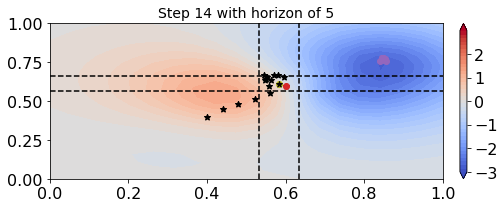

  2%|▏         | 1/50 [00:02<01:38,  2.01s/it]

x0:  [[0.6171674728393555, 0.5990129709243774]] , a:  [[[[[[[0.6522359251976013, 0.6450473666191101]], [[0.6661421656608582, 0.6567612886428833]], [[0.6637040972709656, 0.6509358882904053]], [[0.7088280320167542, 0.6777641773223877]], [[0.6703152656555176, 0.6511211395263672]]], [[[0.6505416035652161, 0.6830351948738098]], [[0.7052444219589233, 0.6614007949829102]], [[0.7004401683807373, 0.637198269367218]], [[0.6602212190628052, 0.6735715270042419]], [[0.68983393907547, 0.6744794845581055]]], [[[0.6641925573348999, 0.6571035385131836]], [[0.6917431354522705, 0.6494244337081909]], [[0.667809784412384, 0.6622443795204163]], [[0.6713312864303589, 0.6605618000030518]], [[0.7020483016967773, 0.6776912212371826]]], [[[0.667012631893158, 0.6591876149177551]], [[0.6812810301780701, 0.6685068607330322]], [[0.6844155788421631, 0.6590954661369324]], [[0.6975541710853577, 0.6486833691596985]], [[0.6808215975761414, 0.6645753979682922]]], [[[0.6589005589485168, 0.6651346683502197]], [[0.6679087281

 22%|██▏       | 11/50 [00:20<01:13,  1.88s/it]

x0:  [[0.6316337585449219, 0.6154030561447144]] , a:  [[[[[[[0.7652302384376526, 0.7577824592590332]], [[0.7740682363510132, 0.7633742094039917]], [[0.7722141146659851, 0.7572419047355652]], [[0.8009228706359863, 0.7746565341949463]], [[0.7759145498275757, 0.7597408890724182]]], [[[0.7633285522460938, 0.7813345193862915]], [[0.7989991307258606, 0.7658904194831848]], [[0.7963130474090576, 0.7521229982376099]], [[0.7694205641746521, 0.7735611796379089]], [[0.7884343266487122, 0.774252712726593]]], [[[0.7733129262924194, 0.763221800327301]], [[0.7903911471366882, 0.7564439177513123]], [[0.7752712368965149, 0.7677618861198425]], [[0.7763043642044067, 0.7646871209144592]], [[0.7966436147689819, 0.7768642902374268]]], [[[0.7753312587738037, 0.7665197253227234]], [[0.7803671956062317, 0.770349383354187]], [[0.7862563729286194, 0.764202892780304]], [[0.7945822477340698, 0.7558875679969788]], [[0.7815192341804504, 0.768475353717804]]], [[[0.7697883248329163, 0.7701009511947632]], [[0.7762883901

 42%|████▏     | 21/50 [00:38<00:53,  1.84s/it]

x0:  [[0.6308514475822449, 0.6068131923675537]] , a:  [[[[[[[0.8065164089202881, 0.7901550531387329]], [[0.8127917051315308, 0.7834362387657166]], [[0.8110384941101074, 0.7850196361541748]], [[0.8281130790710449, 0.7873088121414185]], [[0.8125506639480591, 0.7894019484519958]]], [[[0.8043283820152283, 0.802438497543335]], [[0.8272871971130371, 0.783606767654419]], [[0.8254102468490601, 0.7849652171134949]], [[0.8091549873352051, 0.787844181060791]], [[0.8192328214645386, 0.7964538335800171]]], [[[0.8110679984092712, 0.7916707992553711]], [[0.8224388957023621, 0.7778979539871216]], [[0.8123687505722046, 0.792961061000824]], [[0.8133726119995117, 0.7827100157737732]], [[0.8239321112632751, 0.7984200716018677]]], [[[0.8123943209648132, 0.7943000197410583]], [[0.8141732811927795, 0.7872182130813599]], [[0.8189164996147156, 0.7894712686538696]], [[0.8250463604927063, 0.7769069671630859]], [[0.817240834236145, 0.7938129305839539]]], [[[0.8098558187484741, 0.7959941625595093]], [[0.8152908086

 62%|██████▏   | 31/50 [00:56<00:34,  1.84s/it]

x0:  [[0.6222898364067078, 0.5859296917915344]] , a:  [[[[[[[0.8122132420539856, 0.7814239263534546]], [[0.8188217878341675, 0.7557739615440369]], [[0.8157833218574524, 0.7738322019577026]], [[0.8289009928703308, 0.7562870383262634]], [[0.814873218536377, 0.7785153388977051]]], [[[0.8101077079772949, 0.7889444828033447]], [[0.8285643458366394, 0.7553374171257019]], [[0.8257222175598145, 0.7751680016517639]], [[0.815955638885498, 0.7572376728057861]], [[0.8189384937286377, 0.7825138568878174]]], [[[0.8150423765182495, 0.7818349003791809]], [[0.8254880309104919, 0.7519044876098633]], [[0.8164891600608826, 0.7796697616577148]], [[0.8188050389289856, 0.7537981867790222]], [[0.8220542073249817, 0.7838904857635498]]], [[[0.816042959690094, 0.783667802810669]], [[0.8187239170074463, 0.758527398109436]], [[0.8209280967712402, 0.7767980694770813]], [[0.8273122906684875, 0.7501214146614075]], [[0.8193169832229614, 0.7804786562919617]]], [[[0.814947783946991, 0.7846745252609253]], [[0.82094860076

 82%|████████▏ | 41/50 [01:15<00:16,  1.85s/it]

x0:  [[0.6103442311286926, 0.5685939788818359]] , a:  [[[[[[[0.8048191070556641, 0.7656221985816956]], [[0.8137410283088684, 0.7244647145271301]], [[0.8078057169914246, 0.7570164799690247]], [[0.8210510015487671, 0.7239168882369995]], [[0.8038954138755798, 0.7603784203529358]]], [[[0.8028995990753174, 0.7711508870124817]], [[0.8209222555160522, 0.7239816188812256]], [[0.8154906034469604, 0.7584812045097351]], [[0.8115668296813965, 0.7250001430511475]], [[0.8067380785942078, 0.7631611824035645]]], [[[0.8067185878753662, 0.7657994627952576]], [[0.8188737034797668, 0.7218015193939209]], [[0.8084139227867126, 0.7614152431488037]], [[0.813580334186554, 0.7223262190818787]], [[0.8091506958007812, 0.7640409469604492]]], [[[0.8075436353683472, 0.7671228051185608]], [[0.8130789995193481, 0.7269824147224426]], [[0.8117255568504333, 0.7590586543083191]], [[0.820210874080658, 0.7199169397354126]], [[0.8080710172653198, 0.7608755230903625]]], [[[0.8071279525756836, 0.7678797245025635]], [[0.8152610

100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


Current optimal loss -0.13036457846635943;optimal action: tensor([[0.6226, 0.5784]], grad_fn=<AddBackward0>)


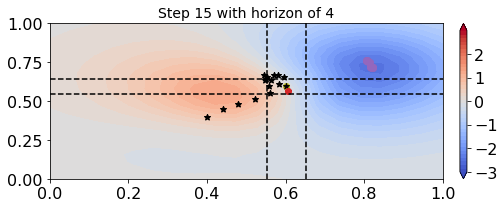

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

x0:  [[0.6118485927581787, 0.5859996676445007]] , a:  [[[[[[0.6711997389793396, 0.6270401477813721]], [[0.6557250022888184, 0.6124770641326904]], [[0.6453690528869629, 0.6352948546409607]], [[0.6595751643180847, 0.6648432612419128]], [[0.6684424877166748, 0.6341074705123901]]], [[[0.6428537368774414, 0.6334888935089111]], [[0.6606257557868958, 0.6098314523696899]], [[0.6638233661651611, 0.6275750398635864]], [[0.6638950109481812, 0.6254994869232178]], [[0.6701408624649048, 0.6428832411766052]]], [[[0.6720560193061829, 0.6137800216674805]], [[0.6466330289840698, 0.6389448046684265]], [[0.6723474860191345, 0.6435286402702332]], [[0.640360951423645, 0.6579472422599792]], [[0.6604087948799133, 0.6407326459884644]]], [[[0.6531515121459961, 0.6404901146888733]], [[0.647249162197113, 0.6413941979408264]], [[0.662516176700592, 0.6469087600708008]], [[0.6693359613418579, 0.6429791450500488]], [[0.6737653017044067, 0.6106021404266357]]], [[[0.6728968620300293, 0.6411387920379639]], [[0.644279122

 22%|██▏       | 11/50 [00:15<01:01,  1.57s/it]

x0:  [[0.6311020255088806, 0.5992223024368286]] , a:  [[[[[[0.7577211260795593, 0.7163404822349548]], [[0.7489845156669617, 0.7078617811203003]], [[0.7409295439720154, 0.7224655151367188]], [[0.7495400309562683, 0.7402499914169312]], [[0.7562325596809387, 0.7215622663497925]]], [[[0.7397427558898926, 0.7216752767562866]], [[0.7515418529510498, 0.7062904834747314]], [[0.7539361715316772, 0.7173175811767578]], [[0.7526893615722656, 0.7161389589309692]], [[0.7581413984298706, 0.7272119522094727]]], [[[0.7582159042358398, 0.7083679437637329]], [[0.7420980930328369, 0.7249749302864075]], [[0.75855553150177, 0.7274166345596313]], [[0.7368759512901306, 0.7365401983261108]], [[0.751868724822998, 0.7258126139640808]]], [[[0.7460516691207886, 0.7248884439468384]], [[0.7417505979537964, 0.7264897227287292]], [[0.752875804901123, 0.7297676801681519]], [[0.7557811737060547, 0.7261610627174377]], [[0.7608932852745056, 0.7061389088630676]]], [[[0.7585188746452332, 0.725936233997345]], [[0.74175906181

 42%|████▏     | 21/50 [00:30<00:40,  1.38s/it]

x0:  [[0.6365888714790344, 0.6010717153549194]] , a:  [[[[[[0.7888707518577576, 0.7525922060012817]], [[0.7848572134971619, 0.7485662698745728]], [[0.7795337438583374, 0.7565252780914307]], [[0.782586932182312, 0.765911340713501]], [[0.7894183397293091, 0.7557713985443115]]], [[[0.7781128287315369, 0.7564127445220947]], [[0.7864456176757812, 0.747708797454834]], [[0.7874113321304321, 0.7538997530937195]], [[0.7851998209953308, 0.7528303861618042]], [[0.7906907796859741, 0.758708119392395]]], [[[0.7893288731575012, 0.7489772439002991]], [[0.7801258563995361, 0.7577130198478699]], [[0.7897475957870483, 0.7589492797851562]], [[0.7752111554145813, 0.7642123103141785]], [[0.7871378064155579, 0.7580054402351379]]], [[[0.7816047668457031, 0.7576592564582825]], [[0.7796106338500977, 0.7585741281509399]], [[0.7864116430282593, 0.7603338360786438]], [[0.7868763208389282, 0.7580429911613464]], [[0.7929779887199402, 0.748908281326294]]], [[[0.7890111804008484, 0.7579695582389832]], [[0.78105098009

 62%|██████▏   | 31/50 [00:43<00:25,  1.34s/it]

x0:  [[0.6347500681877136, 0.5970697402954102]] , a:  [[[[[[0.7947610020637512, 0.7614709138870239]], [[0.7932708263397217, 0.7589659690856934]], [[0.789219319820404, 0.7641245722770691]], [[0.7892886400222778, 0.769888162612915]], [[0.7971999049186707, 0.7631880640983582]]], [[[0.7871341109275818, 0.7642533183097839]], [[0.7944464683532715, 0.7583369016647339]], [[0.794532060623169, 0.7626158595085144]], [[0.7915111184120178, 0.7616481781005859]], [[0.7979508638381958, 0.7649162411689758]]], [[[0.795135498046875, 0.7595822811126709]], [[0.7896746397018433, 0.7644739747047424]], [[0.7960132360458374, 0.7655484676361084]], [[0.7843594551086426, 0.7689845561981201]], [[0.7956249713897705, 0.7645578384399414]]], [[[0.7894992232322693, 0.7646568417549133]], [[0.7893714308738708, 0.7649922370910645]], [[0.7936232686042786, 0.7664204239845276]], [[0.7926284670829773, 0.7648252248764038]], [[0.7998405694961548, 0.7600969076156616]]], [[[0.7945443987846375, 0.7646881937980652]], [[0.7909011244

 82%|████████▏ | 41/50 [00:57<00:12,  1.35s/it]

x0:  [[0.6285353899002075, 0.5863497853279114]] , a:  [[[[[[0.7894331812858582, 0.755565345287323]], [[0.7900660037994385, 0.7535852193832397]], [[0.7861719131469727, 0.7574363350868225]], [[0.7843594551086426, 0.7615986466407776]], [[0.7937975525856018, 0.7559881806373596]]], [[[0.7832804918289185, 0.7577500939369202]], [[0.7910057306289673, 0.7530202269554138]], [[0.7901692390441895, 0.7563687562942505]], [[0.7862747311592102, 0.7555349469184875]], [[0.794191300868988, 0.757196307182312]]], [[[0.7897225618362427, 0.7542939186096191]], [[0.787076473236084, 0.7574653625488281]], [[0.7913120985031128, 0.7584565877914429]], [[0.7806205749511719, 0.761048436164856]], [[0.792454183101654, 0.7570145130157471]]], [[[0.7851905226707458, 0.7577054500579834]], [[0.78704434633255, 0.7577985525131226]], [[0.7893440127372742, 0.7590731978416443]], [[0.7871529459953308, 0.7577973008155823]], [[0.7957649827003479, 0.7544057369232178]]], [[[0.7890005111694336, 0.7576967477798462]], [[0.78831714391708

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Current optimal loss -0.34325474097162006;optimal action: tensor([[0.6356, 0.5852]], grad_fn=<AddBackward0>)


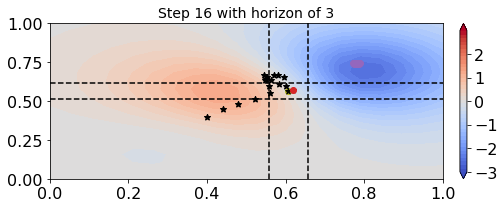

  2%|▏         | 1/50 [00:00<00:42,  1.14it/s]

x0:  [[0.6266726851463318, 0.5916475057601929]] , a:  [[[[[0.6805717945098877, 0.6212992072105408]], [[0.6707683205604553, 0.6330484747886658]], [[0.659315288066864, 0.6180965900421143]], [[0.6416651010513306, 0.6182581782341003]], [[0.6582183241844177, 0.6444816589355469]]], [[[0.6795781254768372, 0.6234660744667053]], [[0.6493977904319763, 0.6394959092140198]], [[0.6448919773101807, 0.6255093812942505]], [[0.6592952013015747, 0.6411013007164001]], [[0.6524304151535034, 0.6322482228279114]]], [[[0.6755340099334717, 0.6223880052566528]], [[0.6454919576644897, 0.6515001654624939]], [[0.6634959578514099, 0.6302650570869446]], [[0.6754451990127563, 0.6462060809135437]], [[0.662704348564148, 0.6258960962295532]]], [[[0.6821378469467163, 0.6271467804908752]], [[0.6487266421318054, 0.6299923658370972]], [[0.6577351689338684, 0.6189282536506653]], [[0.644770085811615, 0.6223685145378113]], [[0.6683303117752075, 0.6394290328025818]]], [[[0.6542483568191528, 0.6188098788261414]], [[0.6386030912

 22%|██▏       | 11/50 [00:09<00:34,  1.13it/s]

x0:  [[0.6461537480354309, 0.6060092449188232]] , a:  [[[[[0.7482373714447021, 0.6926408410072327]], [[0.7405487895011902, 0.7004621624946594]], [[0.7342021465301514, 0.6913900971412659]], [[0.7229790091514587, 0.6913047432899475]], [[0.7325069308280945, 0.7080521583557129]]], [[[0.747650146484375, 0.6933790445327759]], [[0.7270917892456055, 0.7048791646957397]], [[0.7247955203056335, 0.6961537599563599]], [[0.7347798943519592, 0.7056551575660706]], [[0.7285335063934326, 0.7005095481872559]]], [[[0.7448580861091614, 0.6930948495864868]], [[0.7245817184448242, 0.7122360467910767]], [[0.7369151711463928, 0.6987188458442688]], [[0.7447835206985474, 0.7089447975158691]], [[0.7353494167327881, 0.6959884762763977]]], [[[0.7490803003311157, 0.6961555480957031]], [[0.7264721393585205, 0.6992204189300537]], [[0.7336757779121399, 0.6919224262237549]], [[0.7250734567642212, 0.6932321190834045]], [[0.738517701625824, 0.7045283317565918]]], [[[0.7308470010757446, 0.6908032298088074]], [[0.720106899

 42%|████▏     | 21/50 [00:18<00:25,  1.14it/s]

x0:  [[0.6530648469924927, 0.6094160676002502]] , a:  [[[[[0.7735788822174072, 0.7190532088279724]], [[0.7680389285087585, 0.7261804342269897]], [[0.7648997902870178, 0.7205854058265686]], [[0.758698046207428, 0.7220844626426697]], [[0.7623032927513123, 0.7309621572494507]]], [[[0.7732685208320618, 0.7193069458007812]], [[0.7600541114807129, 0.7291024923324585]], [[0.7592206001281738, 0.7234084010124207]], [[0.7652698159217834, 0.7294039130210876]], [[0.760050892829895, 0.7267118692398071]]], [[[0.7717622518539429, 0.7192849516868591]], [[0.7583110332489014, 0.7332383394241333]], [[0.7663548588752747, 0.7245278358459473]], [[0.7711300849914551, 0.7310025691986084]], [[0.764214813709259, 0.7240390181541443]]], [[[0.7740119099617004, 0.7209526300430298]], [[0.7596989274024963, 0.7260808944702148]], [[0.7646428346633911, 0.720911979675293]], [[0.7599520683288574, 0.7223795652389526]], [[0.7659449577331543, 0.7288447022438049]]], [[[0.7633417248725891, 0.7184904217720032]], [[0.75583469867

 62%|██████▏   | 31/50 [00:27<00:16,  1.13it/s]

x0:  [[0.6536871790885925, 0.6075973510742188]] , a:  [[[[[0.7806581854820251, 0.7219030261039734]], [[0.7754877209663391, 0.7323094606399536]], [[0.7740896344184875, 0.7270220518112183]], [[0.7700973153114319, 0.7302974462509155]], [[0.7703065872192383, 0.7358728051185608]]], [[[0.7805181741714478, 0.7220816016197205]], [[0.7699686884880066, 0.7344596982002258]], [[0.7701001167297363, 0.7289108633995056]], [[0.7743040919303894, 0.7345542311668396]], [[0.7687913775444031, 0.7330157160758972]]], [[[0.7795964479446411, 0.7220264673233032]], [[0.7685155868530273, 0.7371937036514282]], [[0.7750057578086853, 0.7295191287994385]], [[0.778337836265564, 0.7353762984275818]], [[0.7718043327331543, 0.7313796281814575]]], [[[0.7809352278709412, 0.7231108546257019]], [[0.7697758674621582, 0.7326599359512329]], [[0.773945152759552, 0.7272568941116333]], [[0.7710532546043396, 0.7301623821258545]], [[0.7729632258415222, 0.7344536781311035]]], [[[0.7737215161323547, 0.7217770218849182]], [[0.766941189

 82%|████████▏ | 41/50 [00:36<00:08,  1.11it/s]

x0:  [[0.6512963771820068, 0.6014285087585449]] , a:  [[[[[0.7807897925376892, 0.709500253200531]], [[0.7749393582344055, 0.7289451956748962]], [[0.7749349474906921, 0.722385585308075]], [[0.7718011140823364, 0.7275872230529785]], [[0.7693878412246704, 0.7320442199707031]]], [[[0.7807708978652954, 0.7096804976463318]], [[0.7706093192100525, 0.7306873798370361]], [[0.7717551589012146, 0.7237960696220398]], [[0.7749402523040771, 0.7305217385292053]], [[0.7681790590286255, 0.7298078536987305]]], [[[0.7800965309143066, 0.7095474600791931]], [[0.7692914605140686, 0.7327664494514465]], [[0.775619626045227, 0.7242250442504883]], [[0.7780987024307251, 0.7309876084327698]], [[0.770671546459198, 0.7287214994430542]]], [[[0.7810029983520508, 0.7103857398033142]], [[0.7705063223838806, 0.7294834852218628]], [[0.7748697400093079, 0.7225757241249084]], [[0.7726666927337646, 0.7274050116539001]], [[0.7715845108032227, 0.7309642434120178]]], [[[0.7754055857658386, 0.7094358801841736]], [[0.76813519001

100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Current optimal loss -0.6736360902063204;optimal action: tensor([[0.6634, 0.6059]], grad_fn=<AddBackward0>)


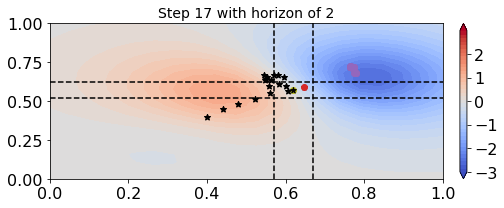

  2%|▏         | 1/50 [00:00<00:21,  2.25it/s]

x0:  [[0.6604670286178589, 0.6090273857116699]] , a:  [[[[0.6949462890625, 0.6167237758636475]], [[0.6786134243011475, 0.6513450145721436]], [[0.6778761744499207, 0.6299642324447632]], [[0.6858924031257629, 0.6340122818946838]], [[0.6773014068603516, 0.6249244809150696]]], [[[0.6869235634803772, 0.619361162185669]], [[0.6933669447898865, 0.6318130493164062]], [[0.6839540004730225, 0.6266394257545471]], [[0.6901916861534119, 0.6287419199943542]], [[0.6776176691055298, 0.6366936564445496]]], [[[0.6881781220436096, 0.620827853679657]], [[0.6933611631393433, 0.6316673755645752]], [[0.6725917458534241, 0.6367802619934082]], [[0.6866046190261841, 0.6352390646934509]], [[0.6823992729187012, 0.627627432346344]]], [[[0.6903082728385925, 0.6184332370758057]], [[0.6808577179908752, 0.6403622031211853]], [[0.6842450499534607, 0.6288997530937195]], [[0.6931318044662476, 0.6276958584785461]], [[0.6776047348976135, 0.6296203136444092]]], [[[0.6927536725997925, 0.6147657632827759]], [[0.69146674871444

 22%|██▏       | 11/50 [00:05<00:18,  2.09it/s]

x0:  [[0.6781446933746338, 0.6242098212242126]] , a:  [[[[0.7446388006210327, 0.6716679334640503]], [[0.7337948083877563, 0.6929823160171509]], [[0.7336216568946838, 0.6802669763565063]], [[0.7381569147109985, 0.6826428174972534]], [[0.7335625290870667, 0.6773059964179993]]], [[[0.7392838597297668, 0.673529863357544]], [[0.7437117099761963, 0.6803115606307983]], [[0.7372980117797852, 0.6777675151824951]], [[0.741243302822113, 0.6789147853851318]], [[0.7337368726730347, 0.6848782300949097]]], [[[0.740153431892395, 0.6744639873504639]], [[0.7437088489532471, 0.680209219455719]], [[0.7301660776138306, 0.6849499940872192]], [[0.7386726140975952, 0.6834261417388916]], [[0.7368542551994324, 0.679058313369751]]], [[[0.7416154146194458, 0.672872006893158]], [[0.7354576587677002, 0.6863648891448975]], [[0.737459123134613, 0.6793923377990723]], [[0.7432346940040588, 0.6780967712402344]], [[0.7337485551834106, 0.6804630756378174]]], [[[0.7432462573051453, 0.6703472137451172]], [[0.742499709129333

 42%|████▏     | 21/50 [00:10<00:13,  2.15it/s]

x0:  [[0.6846607327461243, 0.6269983053207397]] , a:  [[[[0.762081503868103, 0.6860886812210083]], [[0.755236029624939, 0.6959755420684814]], [[0.7554944157600403, 0.6902605295181274]], [[0.7578935623168945, 0.6904062032699585]], [[0.7556084394454956, 0.6889384388923645]]], [[[0.758773684501648, 0.6875792741775513]], [[0.7614586353302002, 0.6872192025184631]], [[0.7577891945838928, 0.6883826851844788]], [[0.7598229050636292, 0.6879560351371765]], [[0.7556420564651489, 0.6935696601867676]]], [[[0.7592896819114685, 0.6880965828895569]], [[0.761458158493042, 0.6871703863143921]], [[0.7533369660377502, 0.6934888362884521]], [[0.758193850517273, 0.6907513737678528]], [[0.757615864276886, 0.6896485090255737]]], [[[0.760206401348114, 0.687020480632782]], [[0.7563132643699646, 0.6918238401412964]], [[0.7578761577606201, 0.6892616748809814]], [[0.7610486745834351, 0.6872508525848389]], [[0.7556902170181274, 0.6908241510391235]]], [[[0.7612444758415222, 0.685387909412384]], [[0.7605947852134705,

 62%|██████▏   | 31/50 [00:14<00:08,  2.15it/s]

x0:  [[0.6863805055618286, 0.6243003010749817]] , a:  [[[[0.7662533521652222, 0.6796261072158813]], [[0.7611249685287476, 0.6796024441719055]], [[0.7616819143295288, 0.6806007623672485]], [[0.7630562782287598, 0.6785557866096497]], [[0.7619212865829468, 0.6805323958396912]]], [[[0.7638306021690369, 0.6812239289283752]], [[0.765803873538971, 0.6738736033439636]], [[0.7634555101394653, 0.6788473129272461]], [[0.764461874961853, 0.6769121885299683]], [[0.7618606090545654, 0.6832992434501648]]], [[[0.7641779780387878, 0.6814722418785095]], [[0.7658050656318665, 0.6738710403442383]], [[0.760044515132904, 0.6831727623939514]], [[0.7632464170455933, 0.6784831285476685]], [[0.7633926868438721, 0.6803246140480042]]], [[[0.7648627161979675, 0.6805822253227234]], [[0.7619672417640686, 0.6778353452682495]], [[0.7635096311569214, 0.6791641116142273]], [[0.7653452157974243, 0.6761633157730103]], [[0.7619457840919495, 0.6816282272338867]]], [[[0.7656626105308533, 0.6793460249900818]], [[0.76501667499

 82%|████████▏ | 41/50 [00:19<00:04,  2.17it/s]

x0:  [[0.6864562630653381, 0.6205200552940369]] , a:  [[[[0.765776515007019, 0.6676107048988342]], [[0.7616682648658752, 0.6617229580879211]], [[0.7624070048332214, 0.6665704846382141]], [[0.7631524801254272, 0.6641325354576111]], [[0.7627690434455872, 0.6671093702316284]]], [[[0.7638276219367981, 0.6692748069763184]], [[0.7655782699584961, 0.6606436371803284]], [[0.7639650106430054, 0.6652091145515442]], [[0.7642792463302612, 0.6635375022888184]], [[0.762628972530365, 0.667569100856781]]], [[[0.7640758156776428, 0.6692414283752441]], [[0.7655807733535767, 0.6606677770614624]], [[0.7609882354736328, 0.6680600047111511]], [[0.7632787227630615, 0.6637452840805054]], [[0.7639857530593872, 0.66608065366745]]], [[[0.7646463513374329, 0.6685638427734375]], [[0.7624049186706543, 0.6628009676933289]], [[0.7640001177787781, 0.6650199890136719]], [[0.7649685144424438, 0.6629513502120972]], [[0.7627532482147217, 0.6673435568809509]]], [[[0.765335738658905, 0.6677281856536865]], [[0.76480364799499

100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Current optimal loss -1.1260096001704314;optimal action: tensor([[0.7030, 0.6354]], grad_fn=<AddBackward0>)


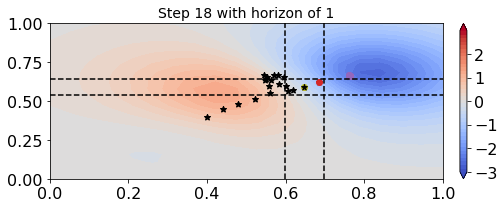

  4%|▍         | 2/50 [00:00<00:03, 12.74it/s]

x0:  [[0.6976991891860962, 0.6413958072662354]] , a:  [[[0.7063669562339783, 0.6428236961364746]], [[0.7016854286193848, 0.647302508354187]], [[0.7188146710395813, 0.656162679195404]], [[0.7050613164901733, 0.6542221903800964]], [[0.7079724669456482, 0.6503666639328003]]] , loss:  -1.1909909527578606


 24%|██▍       | 12/50 [00:00<00:03, 12.59it/s]

x0:  [[0.716311514377594, 0.6553016304969788]] , a:  [[[0.7445805668830872, 0.6773678064346313]], [[0.7413139939308167, 0.6805555820465088]], [[0.7522333264350891, 0.6854414939880371]], [[0.7436764240264893, 0.6848172545433044]], [[0.7456316351890564, 0.6823890805244446]]] , loss:  -1.354590959240431


 44%|████▍     | 22/50 [00:01<00:02, 12.94it/s]

x0:  [[0.7242240309715271, 0.6579224467277527]] , a:  [[[0.7611864805221558, 0.6864733695983887]], [[0.7592959403991699, 0.6882407665252686]], [[0.7655873894691467, 0.6875602006912231]], [[0.76064532995224, 0.6895524859428406]], [[0.7617731690406799, 0.688367486000061]]] , loss:  -1.3702610682524117


 64%|██████▍   | 32/50 [00:02<00:01, 12.83it/s]

x0:  [[0.7270662784576416, 0.6556978821754456]] , a:  [[[0.7672013640403748, 0.6823955774307251]], [[0.7659550905227661, 0.6832122206687927]], [[0.7702355980873108, 0.6764477491378784]], [[0.7668371200561523, 0.6816235184669495]], [[0.767587423324585, 0.6815568208694458]]] , loss:  -1.3752426483425169


 84%|████████▍ | 42/50 [00:03<00:00, 12.33it/s]

x0:  [[0.7281544208526611, 0.6524275541305542]] , a:  [[[0.7695051431655884, 0.674618124961853]], [[0.7685580849647522, 0.6745432019233704]], [[0.771952211856842, 0.6675460934638977]], [[0.7692431807518005, 0.6711300015449524]], [[0.7698131203651428, 0.6719181537628174]]] , loss:  -1.3765164493630615


100%|██████████| 50/50 [00:04<00:00, 12.23it/s]


Current optimal loss -1.457024810547392;optimal action: tensor([[0.7458, 0.6691]], grad_fn=<AddBackward0>)


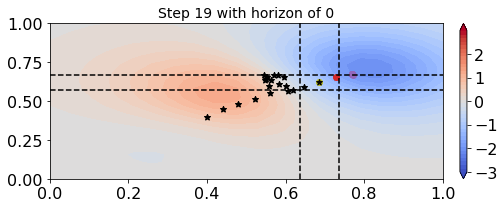

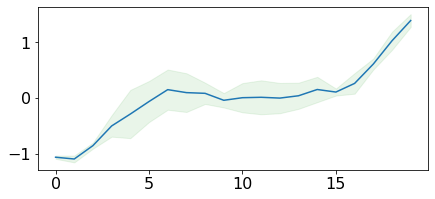

In [5]:
# @title HES
import copy

n_dim = "2"  # @param [1, 2]
n_dim = int(n_dim)
nonmyopic = True  # @param {type:"boolean"}
budget = 20  # @param {type:"integer"}

save = True
draw_legend = False

if n_dim == 1:
    dim_xi = [n_dim]
    prev_x = torch.tensor([0.3])
    prev_x_str = "0.3"
elif n_dim == 2:
    dim_xi = [1, n_dim]
    prev_x = torch.tensor([[0.4, 0.4]])
    prev_x_str = "0.4_0.4"

neighbor_size = 1 / budget  # 0.02
n_init = 0
ehig_opt_epoch = 50
ehig_opt_lr = 0.1
use_lr_schedule = False
train = False

seeds = [0, 1, 2]

optimal_loss_results = []

exp_name = f"{n_dim}D_nonmyopic{nonmyopic}_budget{budget}_\
neighbor_size{neighbor_size}_prev_x{prev_x_str}"

# create folder
if not os.path.exists(f"{path}/{exp_name}"):
    os.makedirs(f"{path}/{exp_name}")
    print(f"Saving to: {path}/{exp_name}")

for seed in seeds:
    if n_dim == 1:
        dim_xi = [n_dim]
        prev_x = torch.tensor([0.3])
    elif n_dim == 2:
        dim_xi = [1, n_dim]
        prev_x = torch.tensor([[0.4, 0.4]])

    if n_dim == 2:
        print("-" * 20, "Ground truth surface", "-" * 20)
        ground_truth(draw_true_model=True, n_dim=n_dim)
        plt.show()

    train_x, train_y = init_data(n_init=n_init)

    model = init_model(
        n_dim=n_dim, prev_x=prev_x, train_x=train_x, train_y=train_y, train=train
    )

    if nonmyopic:
        horizon = budget
    else:
        horizon = 1
    optimal_loss = []
    for step in range(budget):
        best_result = argmax_ehig(
            model,
            prev_x,
            horizon=horizon,
            ehig_opt_epoch=ehig_opt_epoch,
            ehig_opt_lr=ehig_opt_lr,
            neighbor_size=neighbor_size,
            use_lr_schedule=use_lr_schedule,
            seed=seed,
        )

        if nonmyopic:
            horizon = horizon - 1

        with torch.no_grad():
            next_x = best_result[0]
            next_y = func(next_x.reshape(-1, n_dim))

            # draw_posterior(n_dim=n_dim, model=model)
            # if n_dim == 2: plt.show()

            # update data and model
            train_x = torch.cat([train_x, next_x.reshape(-1, n_dim)])
            train_y = torch.cat([train_y, next_y])

            model = init_model(
                n_dim=n_dim,
                prev_x=prev_x,
                train_x=train_x,
                train_y=train_y,
                train=train,
            )

        # eval
        a = (torch.rand([n_dim] if n_dim == 1 else [1, n_dim])).requires_grad_(True)
        optimizer = optim.Adam([a], lr=ehig_opt_lr)

        loss = []
        for epoch in range(10):
            optimizer.zero_grad()

            a = torch.sigmoid(a) * (neighbor_size * 2) + (next_x - neighbor_size)

            p_y_on_a_D = model.posterior(a)
            ell = p_y_on_a_D.mean.mean()
            ell.backward(retain_graph=True)
            optimizer.step()
            loss.append(ell.clone().detach())

        loss = torch.stack(loss).squeeze()
        print(f"Current optimal loss {loss.min().item()};" f"optimal action: {a}")
        optimal_loss.append(loss.min())

        if n_dim == 1:
            dim_xi = [n_dim]
        elif n_dim == 2:
            dim_xi = [1, n_dim]

        # plot & update prev_x
        if n_dim == 1:
            ground_truth(draw_true_model=True, n_dim=n_dim)

        plt.title(f"Step {step} with horizon of {horizon}")

        # draw_posterior(n_dim=n_dim, model=model)

        if n_dim == 1:
            dmin = -4
            dmax = 4
            plt.vlines(prev_x, dmin, dmax, color=color["C5"], label="Current location")
            plt.vlines(
                prev_x - neighbor_size, dmin, dmax, color="black", linestyle="--"
            )
            plt.vlines(
                prev_x + neighbor_size, dmin, dmax, color="black", linestyle="--"
            )
            prev_x = next_x
            plt.plot(
                train_x.squeeze().cpu().numpy(), train_y.squeeze().cpu().numpy(), "k*"
            )
            plt.vlines(
                best_result[0], dmin, dmax, color=color["C3"], label="Optimal query"
            )
            plt.vlines(
                best_result[-1], dmin, dmax, color=color["C4"], label="Optimal action"
            )
            plt.ylim(dmin, dmax)

        elif n_dim == 2:
            plt.hlines(prev_x[0, 1] - neighbor_size, 0, 1, linestyle="--")
            plt.hlines(prev_x[0, 1] + neighbor_size, 0, 1, linestyle="--")
            plt.vlines(prev_x[0, 0] - neighbor_size, 0, 1, linestyle="--")
            plt.vlines(prev_x[0, 0] + neighbor_size, 0, 1, linestyle="--")
            plt.scatter(
                prev_x[0, 0], prev_x[0, 1], color=color["C5"], label="Current location"
            )
            prev_x = next_x
            plt.scatter(train_x[:, 0], train_x[:, 1], marker="*", color="black")
            plt.scatter(
                best_result[0][0, 0],
                best_result[0][0, 1],
                color=color["C3"],
                label="Optimal query",
            )
            plt.scatter(
                best_result[-1][..., 0],
                best_result[-1][..., 1],
                color=color["C4"],
                label="Optimal action",
            )
            plt.ylim(0, 1)

        plt.tight_layout()
        if draw_legend:
            plt.legend()

        if save:
            plt.savefig(
                f"{path}/{exp_name}/seed{seed}_step{step}.{imgtype}",
                dpi=dpi,
                bbox_inches="tight",
            )

        plt.show()

    # plot optimal loss over query
    optimal_loss = torch.stack(optimal_loss).numpy()

    optimal_loss_results.append(optimal_loss)

optimal_loss_results = np.array(optimal_loss_results)
mean = optimal_loss_results.mean(0)
std = optimal_loss_results.std(0)

plt.plot(-mean, label=color["C1"])
plt.fill_between(
    np.arange(len(mean)),
    -(mean - 2 * std),
    -(mean + 2 * std),
    color=color["C2"],
    alpha=0.1,
)

plt.show()

np.save(f"{path}/{exp_name}/data.npy", optimal_loss_results)

In [ ]:
# @title Random
import copy

n_dim = "1"  # @param [1, 2]
n_dim = int(n_dim)
nonmyopic = True  # @param {type:"boolean"}
budget = 20  # @param {type:"integer"}

save = True
draw_legend = False

if n_dim == 1:
    dim_xi = [n_dim]
    prev_x = torch.tensor([0.3])
    prev_x_str = "0.3"
elif n_dim == 2:
    dim_xi = [1, n_dim]
    prev_x = torch.tensor([[0.4, 0.4]])
    prev_x_str = "0.4_0.4"

neighbor_size = 1 / budget  # 0.02
n_init = 0
ehig_opt_epoch = 50
ehig_opt_lr = 0.1
use_lr_schedule = False
train = False

seeds = [0, 1, 2]

optimal_loss_results = []

exp_name = f"{n_dim}D_nonmyopic{nonmyopic}_budget{budget}_\
neighbor_size{neighbor_size}_prev_x{prev_x_str}"

# create folder
if not os.path.exists(f"{path}/{exp_name}"):
    os.makedirs(f"{path}/{exp_name}")
    print(f"Saving to: {path}/{exp_name}")

for seed in seeds:
    if n_dim == 1:
        dim_xi = [n_dim]
        prev_x = torch.tensor([0.3])
    elif n_dim == 2:
        dim_xi = [1, n_dim]
        prev_x = torch.tensor([[0.4, 0.4]])

    if n_dim == 2:
        print("-" * 20, "Ground truth surface", "-" * 20)
        ground_truth(draw_true_model=True, n_dim=n_dim)
        plt.show()

    train_x, train_y = init_data(n_init=n_init)

    model = init_model(
        n_dim=n_dim, prev_x=prev_x, train_x=train_x, train_y=train_y, train=train
    )

    if nonmyopic:
        horizon = budget
    else:
        horizon = 1
    optimal_loss = []
    for step in range(budget):
        with torch.no_grad():
            if n_dim == 1:
                next_x = torch.FloatTensor(1, 2).uniform_(
                    prev_x - neighbor_size, prev_x + neighbor_size
                )
            elif n_dim == 2:
                next_x0 = torch.FloatTensor(1, 1).uniform_(
                    prev_x[0, 0] - neighbor_size, prev_x[0, 0] + neighbor_size
                )
                next_x1 = torch.FloatTensor(1, 1).uniform_(
                    prev_x[0, 1] - neighbor_size, prev_x[0, 1] + neighbor_size
                )
                next_x = torch.stack([next_x0, next_x1], dim=1)

            next_y = func(next_x.reshape(-1, n_dim))

            # draw_posterior(n_dim=n_dim, model=model)
            # if n_dim == 2: plt.show()

            # update data and model
            train_x = torch.cat([train_x, next_x.reshape(-1, n_dim)])
            train_y = torch.cat([train_y, next_y])

            model = init_model(
                n_dim=n_dim,
                prev_x=prev_x,
                train_x=train_x,
                train_y=train_y,
                train=train,
            )

        # eval
        a = (torch.rand([n_dim] if n_dim == 1 else [1, n_dim])).requires_grad_(True)
        optimizer = optim.Adam([a], lr=ehig_opt_lr)

        loss = []
        for epoch in range(10):
            optimizer.zero_grad()

            a = torch.sigmoid(a) * (neighbor_size * 2) + (next_x - neighbor_size)

            p_y_on_a_D = model.posterior(a)
            ell = p_y_on_a_D.mean.mean()
            ell.backward(retain_graph=True)
            optimizer.step()
            loss.append(ell.clone().detach())

        loss = torch.stack(loss).squeeze()
        print(f"Current optimal loss {loss.min().item()};" f"optimal action: {a}")
        optimal_loss.append(loss.min())

        if n_dim == 1:
            dim_xi = [n_dim]
        elif n_dim == 2:
            dim_xi = [1, n_dim]

        # plot & update prev_x
        if n_dim == 1:
            ground_truth(draw_true_model=True, n_dim=n_dim)

        plt.title(f"Step {step} with horizon of {horizon}")

        # draw_posterior(n_dim=n_dim, model=model)

        if n_dim == 1:
            dmin = -4
            dmax = 4
            plt.vlines(prev_x, dmin, dmax, color=color["C5"], label="Current location")
            plt.vlines(
                prev_x - neighbor_size, dmin, dmax, color="black", linestyle="--"
            )
            plt.vlines(
                prev_x + neighbor_size, dmin, dmax, color="black", linestyle="--"
            )
            prev_x = next_x
            plt.plot(
                train_x.squeeze().cpu().numpy(), train_y.squeeze().cpu().numpy(), "k*"
            )
            plt.vlines(
                best_result[0], dmin, dmax, color=color["C3"], label="Optimal query"
            )
            plt.vlines(
                best_result[-1], dmin, dmax, color=color["C4"], label="Optimal action"
            )
            plt.ylim(dmin, dmax)

        elif n_dim == 2:
            plt.hlines(prev_x[0, 1] - neighbor_size, 0, 1, linestyle="--")
            plt.hlines(prev_x[0, 1] + neighbor_size, 0, 1, linestyle="--")
            plt.vlines(prev_x[0, 0] - neighbor_size, 0, 1, linestyle="--")
            plt.vlines(prev_x[0, 0] + neighbor_size, 0, 1, linestyle="--")
            plt.scatter(
                prev_x[0, 0], prev_x[0, 1], color=color["C5"], label="Current location"
            )
            prev_x = next_x
            plt.scatter(train_x[:, 0], train_x[:, 1], marker="*", color="black")
            plt.scatter(
                best_result[0][0, 0],
                best_result[0][0, 1],
                color=color["C3"],
                label="Optimal query",
            )
            plt.scatter(
                best_result[-1][..., 0],
                best_result[-1][..., 1],
                color=color["C4"],
                label="Optimal action",
            )
            plt.ylim(0, 1)

        plt.tight_layout()
        if draw_legend:
            plt.legend()

        if save:
            plt.savefig(
                f"{path}/{exp_name}/seed{seed}_step{step}.{imgtype}",
                dpi=dpi,
                bbox_inches="tight",
            )

        plt.show()

    # plot optimal loss over query
    optimal_loss = torch.stack(optimal_loss).numpy()

    optimal_loss_results.append(optimal_loss)

optimal_loss_results = np.array(optimal_loss_results)
mean = optimal_loss_results.mean(0)
std = optimal_loss_results.std(0)

plt.plot(-mean, label=color["C1"])
plt.fill_between(
    np.arange(len(mean)),
    -(mean - 2 * std),
    -(mean + 2 * std),
    color=color["C2"],
    alpha=0.1,
)

plt.show()

np.save(f"{path}/{exp_name}/data.npy", optimal_loss_results)

In [ ]:
# @title DDPG

#!/usr/bin/env python
"""
Reinformcement learning baseline for non-myopic
Bayesian optimization
"""

from synthfunc import SynthFunc
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from argparse import Namespace, ArgumentParser

__author__ = "Sang T. Truong, Willie Neiswanger, Shengjia Zhao, Stefano Ermon"
__copyright__ = "Copyright 2022, Stanford University"

import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


class SynthFuncEnv(gym.Env):
    def __init__(self, n_dim):
        self.T = 100
        self.state_dim = 1
        self.n_dim = n_dim
        hypers = {"ls": 1.0, "alpha": 2.0, "sigma": 1e-2, "n_dimx": self.n_dim}
        self.sf_bounds = [0, 10]
        sf_domain = [self.sf_bounds] * self.n_dim
        self.lower_bounds = [self.sf_bounds[0]] * self.n_dim
        self.upper_bounds = [self.sf_bounds[1]] * self.n_dim
        self.action_space = gym.spaces.Box(
            low=np.array(self.lower_bounds, dtype=np.float32),
            high=np.array(self.upper_bounds, dtype=np.float32),
        )
        self.state = torch.tensor([])
        self.sf = SynthFunc(seed=12, hypers=hypers, n_obs=50, domain=sf_domain)

    def step(self, action):
        reward = self.sf(action)
        self.state = torch.cat([self.state, action, torch.tensor([reward])])
        self.state_dim = self.state_dim + self.n_dim + 1 if self.state_dim > 1 else 3
        self.T = self.T - 1
        done = False if self.T > 0 else True
        return self.state, reward, done

    def reset(self):
        """
        Return the initial state
        """
        return torch.tensor(0)

    def update_action_bound(self, action, r):
        self.lower_bounds = []
        self.upper_bounds = []
        for i in range(self.n_dim):
            lower_bound = action[i].item() - r
            lower_bound = (
                lower_bound if lower_bound >= self.sf_bounds[0] else self.sf_bounds[0]
            )
            self.lower_bounds.append(lower_bound)

            upper_bound = action[i].item() + r
            upper_bound = (
                upper_bound if upper_bound <= self.sf_bounds[1] else self.sf_bounds[1]
            )
            self.upper_bounds.append(upper_bound)

        self.action_space = gym.spaces.Box(
            low=np.array(self.lower_bounds, dtype=np.float32),
            high=np.array(self.upper_bounds, dtype=np.float32),
        )

        self.lower_bounds = torch.tensor(self.lower_bounds)
        self.upper_bounds = torch.tensor(self.upper_bounds)

        return self.lower_bounds, self.upper_bounds


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.transition = namedtuple(
            "Transition", ("state", "action", "next_state", "reward", "done")
        )

    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = self.transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


class Noise:
    def __init__(self, params):
        self.mu = params.mu
        self.theta = params.theta
        self.sigma = params.sigma
        self.reset()

    def reset(self):
        self.state = np.full(params.action_dim, self.mu)

    def make_noise(self):
        state = self.state
        delta = self.theta * (self.mu - state) + self.sigma * np.random.randn(
            len(state)
        )
        self.state = state + delta
        return self.state


class Actor(nn.Module):
    def __init__(self, params):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(params.state_dim, params.act_hid_1)
        self.fc2 = nn.Linear(params.act_hid_1, params.act_hid_2)
        self.fc3 = nn.Linear(params.act_hid_2, params.action_dim)

    def forward(self, x):
        self.__init__(params)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, params):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(params.state_dim, params.crit_hid_1)
        self.fc2 = nn.Linear(params.crit_hid_1 + params.action_dim, params.crit_hid_2)
        self.fc3 = nn.Linear(params.crit_hid_2, 1)

    def forward(self, x, action):
        x = F.relu(self.fc1(x))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class Model:
    def __init__(self, params):
        self.device = params.device

        self.actor = Actor(params).to(self.device)
        self.actor_target = Actor(params).to(self.device)
        self.critic = Critic(params).to(self.device)
        self.critic_target = Critic(params).to(self.device)

        self.actor_optimizer = torch.optim.Adam(
            self.actor.parameters(), lr=params.lr_actor
        )
        self.critic_optimizer = torch.optim.Adam(
            self.critic.parameters(), lr=params.lr_critic
        )

        self.tau_actor = params.tau_actor
        self.tau_critic = params.tau_critic

        self.__update(self.actor_target, self.actor)
        self.__update(self.critic_target, self.critic)

    def __update(self, target, local):
        target.load_state_dict(local.state_dict())

    def __soft_update(self, target, local, tau):
        for target_param, param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def update_target_nn(self):
        self.__soft_update(self.actor_target, self.actor, self.tau_actor)
        self.__soft_update(self.critic_target, self.critic, self.tau_critic)


class DDPG:
    def __init__(self, params):
        self.device = params.device
        self.gamma = params.gamma
        self.batch_size = params.batch_size
        self.act_up, self.act_down = params.act_up, params.act_down

        self.explor_noise = Noise(params)
        self.buffer = ReplayBuffer(params.buffer_size)
        self.model = Model(params)

    def update(self):
        if len(self.buffer) <= self.batch_size:
            return

        transitions = self.buffer.sample(self.batch_size)
        batch = self.buffer.transition(*zip(*transitions))

        state_batch = self.tensor(batch.state).float()
        action_batch = self.tensor(batch.action).float()
        reward_batch = self.tensor(batch.reward).float()
        next_state_batch = self.tensor(batch.next_state).float()

        with torch.no_grad():
            next_actions = self.model.actor_target(next_state_batch)
        Q_next = self.model.critic_target(next_state_batch, next_actions).detach()

        reward_batch = reward_batch.unsqueeze(1)
        not_terminate_batch = ~torch.tensor(batch.done).to(self.device).unsqueeze(1)

        Q = self.model.critic(state_batch, action_batch)
        Q_expected = reward_batch + self.gamma * Q_next * not_terminate_batch

        L = F.mse_loss(Q, Q_expected)
        self.model.critic_optimizer.zero_grad()
        L.backward()
        for param in self.model.critic.parameters():
            param.grad.data.clamp_(-1, 1)
        self.model.critic_optimizer.step()

        a = self.model.actor(state_batch)
        L_policy = -self.model.critic(state_batch, a).mean()
        self.model.actor_optimizer.zero_grad()
        L_policy.backward()
        for param in self.model.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.model.actor_optimizer.step()

        self.model.update_target_nn()

    def act(self, state, eps=0):
        state = state.float().unsqueeze(0)
        with torch.no_grad():
            action = self.model.actor(state)
        action = action + eps * self.explor_noise.make_noise()
        return np.clip(action, self.act_down, self.act_up)

    def reset(self):
        self.explor_noise.reset()

    def update_action_bound(self):
        self.act_up, self.act_down = params.act_up, params.act_down


class Paramaters:
    def __init__(self, env):
        self.env = env
        self.state_dim = env.state_dim  # env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.act_up = env.upper_bounds  # env.action_space.high[0]
        self.act_down = env.lower_bounds  # env.action_space.low[0]

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 1
        self.gamma = 0.9
        self.episodes = 1  # there is a single episode
        self.max_steps = 1000
        self.batch_size = 256
        self.buffer_size = int(1e4)

        self.eps = 1.0
        self.eps_decay = 0.95
        self.eps_min = 0.01

        self.tau_actor = 0.1
        self.tau_critic = 0.3
        self.lr_actor = 1e-4
        self.lr_critic = 1e-3

        self.mu = 0
        self.theta = 0.15
        self.sigma = 0.2

        self.act_hid_1, self.act_hid_2 = 128, 128
        self.crit_hid_1, self.crit_hid_2 = 128, 128

        self.reward_coef = 20

        self.froze_seed()

        self.r = 0.01  # spotlight radius

    def froze_seed(self):
        self.env.reset()
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

    def update_eps(self):
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

    def update_state_dim(self):
        self.state_dim = self.env.state_dim

    def update_action_bound(self, action):
        self.env.update_action_bound(action, self.r)
        self.act_down = env.lower_bounds
        self.act_up = env.upper_bounds


def run(params, agent, plot_reward=True, plot_action=True):
    rewards = []
    actions = []
    for i in range(1, params.episodes + 1):
        state = env.reset()
        agent.reset()
        params.update_eps()
        total_reward, steps = 0, 0
        done = False
        t = 1
        while not done:
            action = agent.act(state, params.eps).squeeze()
            if len(actions) > 0:
                d = ((action - actions[-1]) ** 2).sum().sqrt()
                # print(d)
            actions.append(action)
            params.update_action_bound(action)
            agent.update_action_bound()
            next_state, reward, done = env.step(action)
            params.update_state_dim()
            agent.buffer.push(state, action, next_state, reward, done)
            state = next_state
            agent.update()
            total_reward += reward
            steps += 1

            print(
                "Time step {}, Action: {}, Reward {:.2f}".format(
                    t, action.numpy(), reward
                )
            )
            t = t + 1
        rewards.append(total_reward)
        # print(f"Episode {i}, reward: {total_reward}")

    if plot_action:
        actions = torch.stack(actions)
        # print(actions.shape)
        plt.scatter(actions[:, 0], actions[:, 1], c=torch.arange(0, actions.shape[0]))
        plt.title("Action")
        plt.show()

    if plot_reward:
        plt.plot(range(1, i + 1), rewards)
        plt.ylabel("Reward")
        plt.xlabel("Episodes")
        plt.title("Training scores")
        plt.show()
    return agent


if __name__ == "__main__":
    env = SynthFuncEnv(n_dim=2)
    params = Paramaters(env)
    agent = DDPG(params)
    run(params=params, agent=agent)

In [ ]:
train_x, train_y = init_data(n_init=n_init)

model = init_model(
    n_dim=n_dim, prev_x=prev_x, train_x=train_x, train_y=train_y, train=train
)

posterior = model.posterior(torch.tensor([0.4]))
ground_truth(n_dim=1, draw_true_model=True)
draw_posterior(n_dim=1, model=model)

samples = sang_sampler(posterior)

for sample in samples:
    plt.scatter(0.4, sample.squeeze().detach().numpy())

new_model = model.condition_on_observations(
    torch.tensor([0.4]),
    # xi[ind[:i]],
    samples[4],
)

draw_posterior(n_dim=1, model=new_model)